In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
from model_helper import promotion_strategy_indicator, test_results, generate_offer_monthly_data,\
do_pca, scree_plot, grid_search_indicator_pca, print_pos_strat_params

%matplotlib inline

warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
monthly_data = pd.read_csv("monthly_data_rolling.csv")
monthly_data.head()

,amt_spent_per_trans,cost,has_profit,month_num,monthly_amt_spent,num_offers,num_trans,offer_id,per_id,profit,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,10.0,2.0,0.0,...,0,0,0,0,0,0,0,1,0,3
1,0.0,0.0,0.0,3.0,0.0,1.0,0.0,10.0,3.0,0.0,...,0,0,0,0,0,0,0,1,0,3
2,0.0,0.0,0.0,3.0,0.0,1.0,0.0,10.0,4.0,0.0,...,0,0,0,0,0,0,0,1,0,3
3,0.0,0.0,0.0,3.0,0.0,1.0,0.0,10.0,5.0,0.0,...,0,0,0,0,0,0,0,1,0,3
4,0.0,0.0,0.0,3.0,0.0,1.0,0.0,10.0,6.0,0.0,...,0,0,0,0,0,0,0,1,0,3


In [3]:
monthly_data['year_num'] = monthly_data['month_num'] // 12
monthly_data['month_in_year'] = monthly_data['month_num'] % 12
monthly_data['quarter_in_year'] = monthly_data['month_num'] // 4

In [4]:
monthly_data_7 = generate_offer_monthly_data('offer_id_7', monthly_data)

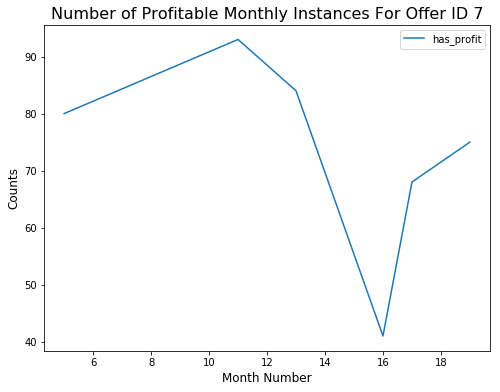

In [5]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==1].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line',ax=ax);
ax.set_title("Number of Profitable Monthly Instances For Offer ID 7", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

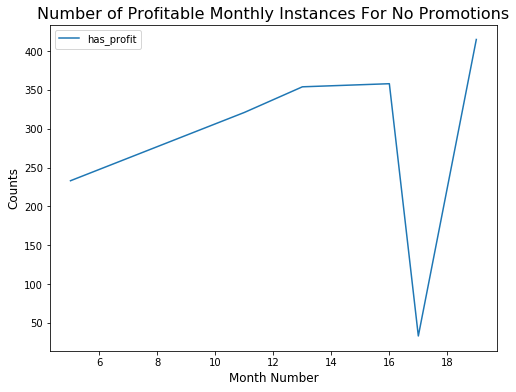

In [6]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==0].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line',ax=ax);
ax.set_title("Number of Profitable Monthly Instances For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

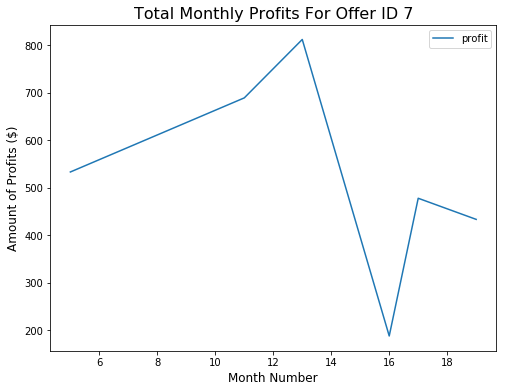

In [7]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==1].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line',ax=ax);
ax.set_title("Total Monthly Profits For Offer ID 7", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

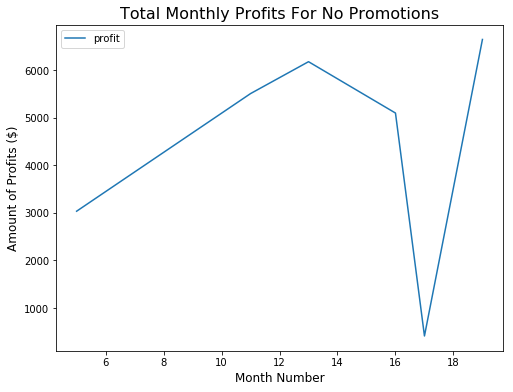

In [8]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_7[monthly_data_7['offer_id_7']==0].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line',ax=ax);
ax.set_title("Total Monthly Profits For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

In [9]:
monthly_data_7.month_num.value_counts().sort_index()

5.0     2638
11.0    2490
13.0    2556
16.0    2374
17.0     136
19.0    2552
Name: month_num, dtype: int64

In [10]:
# use an approximately 70/15/15 split
train_last_month =  16# 4 months
valid_month = 17 # 1 month
test_month = 19 # 1 month

train_7 = monthly_data_7[monthly_data_7['month_num']<=train_last_month].reset_index(drop=True)
valid_7 = monthly_data_7[monthly_data_7['month_num']==valid_month].reset_index(drop=True)
test_7 = monthly_data_7[monthly_data_7['month_num']==test_month].reset_index(drop=True)

## Baseline Model

In [11]:
offer_num = 7

baseline_valid_strat = np.ones(valid_7.shape[0])
valid_irr, valid_nir = test_results(offer_num, baseline_valid_strat, valid_7)
print("Baseline Model Results")
print("Valid IRR:"+str(valid_irr))
print("Valid NIR:"+str(valid_nir))

print()

baseline_test_strat = np.ones(test_7.shape[0])
test_irr, test_nir = test_results(offer_num, baseline_test_strat, test_7)
print("Baseline Model Results")
print("Test IRR:"+str(test_irr))
print("Test NIR:"+str(test_nir))

Baseline Model Results
Valid IRR:0.38235294117647056
Valid NIR:65.13000000000005

Baseline Model Results
Test IRR:-0.3338557993730408
Test NIR:-6207.279999999999


## Model

In [12]:
features = ['month_num', 
            'year_num', 'month_in_year', 'quarter_in_year',
            'cum_monthly_amt_spent_offer_id_0',
           'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
           'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
           'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
           'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
           'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
           'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
           'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
           'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
           'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
           'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
           'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
           'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id_8',
           'cum_num_trans_offer_id_8', 'cum_profit_offer_id_8',
           'cum_monthly_amt_spent_offer_id_9', 'cum_num_trans_offer_id_9',
           'cum_profit_offer_id_9', 'cum_monthly_amt_spent_offer_id_10',
           'cum_num_trans_offer_id_10', 'cum_profit_offer_id_10',
           'cum_spent_per_trans_offer_id_0', 'cum_spent_per_trans_offer_id_1',
           'cum_spent_per_trans_offer_id_2', 'cum_spent_per_trans_offer_id_3',
           'cum_spent_per_trans_offer_id_4', 'cum_spent_per_trans_offer_id_5',
           'cum_spent_per_trans_offer_id_6', 'cum_spent_per_trans_offer_id_7',
           'cum_spent_per_trans_offer_id_8', 'cum_spent_per_trans_offer_id_9',
           'cum_spent_per_trans_offer_id_10',
           'cum_profit_per_trans_offer_id_0',
           'cum_profit_per_trans_offer_id_1',
           'cum_profit_per_trans_offer_id_2',
           'cum_profit_per_trans_offer_id_3',
           'cum_profit_per_trans_offer_id_4',
           'cum_profit_per_trans_offer_id_5',
           'cum_profit_per_trans_offer_id_6',
           'cum_profit_per_trans_offer_id_7',
           'cum_profit_per_trans_offer_id_8',
           'cum_profit_per_trans_offer_id_9',
           'cum_profit_per_trans_offer_id_10', 'cum_total_spend',
           'cum_num_trans', 'cum_profit', 'mov_avg_spent_offer_id_0',
           'mov_avg_spent_offer_id_1', 'mov_avg_spent_offer_id_2',
           'mov_avg_spent_offer_id_3', 'mov_avg_spent_offer_id_4',
           'mov_avg_spent_offer_id_5', 'mov_avg_spent_offer_id_6',
           'mov_avg_spent_offer_id_7', 'mov_avg_spent_offer_id_8',
           'mov_avg_spent_offer_id_9', 'mov_avg_spent_offer_id_10',
            'mov_avg_total_spent',
           'mov_avg_num_trans_offer_id_0', 'mov_avg_num_trans_offer_id_1',
           'mov_avg_num_trans_offer_id_2', 'mov_avg_num_trans_offer_id_3',
           'mov_avg_num_trans_offer_id_4', 'mov_avg_num_trans_offer_id_5',
           'mov_avg_num_trans_offer_id_6', 'mov_avg_num_trans_offer_id_7',
           'mov_avg_num_trans_offer_id_8', 'mov_avg_num_trans_offer_id_9',
           'mov_avg_num_trans_offer_id_10', 'mov_avg_total_num_trans',
            'mov_avg_profit_offer_id_0',
           'mov_avg_profit_offer_id_1', 'mov_avg_profit_offer_id_2',
           'mov_avg_profit_offer_id_3', 'mov_avg_profit_offer_id_4',
           'mov_avg_profit_offer_id_5', 'mov_avg_profit_offer_id_6',
           'mov_avg_profit_offer_id_7', 'mov_avg_profit_offer_id_8',
           'mov_avg_profit_offer_id_9', 'mov_avg_profit_offer_id_10',
            'mov_avg_total_profit',
           'cum_monthly_amt_spent_offer_id_0_1_mo_ago',
           'cum_num_trans_offer_id_0_1_mo_ago',
           'cum_profit_offer_id_0_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_1_1_mo_ago',
           'cum_num_trans_offer_id_1_1_mo_ago',
           'cum_profit_offer_id_1_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_2_1_mo_ago',
           'cum_num_trans_offer_id_2_1_mo_ago',
           'cum_profit_offer_id_2_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_3_1_mo_ago',
           'cum_num_trans_offer_id_3_1_mo_ago',
           'cum_profit_offer_id_3_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_4_1_mo_ago',
           'cum_num_trans_offer_id_4_1_mo_ago',
           'cum_profit_offer_id_4_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_5_1_mo_ago',
           'cum_num_trans_offer_id_5_1_mo_ago',
           'cum_profit_offer_id_5_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_6_1_mo_ago',
           'cum_num_trans_offer_id_6_1_mo_ago',
           'cum_profit_offer_id_6_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_7_1_mo_ago',
           'cum_num_trans_offer_id_7_1_mo_ago',
           'cum_profit_offer_id_7_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_8_1_mo_ago',
           'cum_num_trans_offer_id_8_1_mo_ago',
           'cum_profit_offer_id_8_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_9_1_mo_ago',
           'cum_num_trans_offer_id_9_1_mo_ago',
           'cum_profit_offer_id_9_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_10_1_mo_ago',
           'cum_num_trans_offer_id_10_1_mo_ago',
           'cum_profit_offer_id_10_1_mo_ago',
           'cum_spent_per_trans_offer_id_0_1_mo_ago',
           'cum_spent_per_trans_offer_id_1_1_mo_ago',
           'cum_spent_per_trans_offer_id_2_1_mo_ago',
           'cum_spent_per_trans_offer_id_3_1_mo_ago',
           'cum_spent_per_trans_offer_id_4_1_mo_ago',
           'cum_spent_per_trans_offer_id_5_1_mo_ago',
           'cum_spent_per_trans_offer_id_6_1_mo_ago',
           'cum_spent_per_trans_offer_id_7_1_mo_ago',
           'cum_spent_per_trans_offer_id_8_1_mo_ago',
           'cum_spent_per_trans_offer_id_9_1_mo_ago',
           'cum_spent_per_trans_offer_id_10_1_mo_ago',
           'cum_profit_per_trans_offer_id_0_1_mo_ago',
           'cum_profit_per_trans_offer_id_1_1_mo_ago',
           'cum_profit_per_trans_offer_id_2_1_mo_ago',
           'cum_profit_per_trans_offer_id_3_1_mo_ago',
           'cum_profit_per_trans_offer_id_4_1_mo_ago',
           'cum_profit_per_trans_offer_id_5_1_mo_ago',
           'cum_profit_per_trans_offer_id_6_1_mo_ago',
           'cum_profit_per_trans_offer_id_7_1_mo_ago',
           'cum_profit_per_trans_offer_id_8_1_mo_ago',
           'cum_profit_per_trans_offer_id_9_1_mo_ago',
           'cum_profit_per_trans_offer_id_10_1_mo_ago',
           'cum_total_spend_1_mo_ago', 'cum_num_trans_1_mo_ago',
           'cum_profit_1_mo_ago', 'mov_avg_spent_offer_id_0_1_mo_ago',
           'mov_avg_spent_offer_id_1_1_mo_ago',
           'mov_avg_spent_offer_id_2_1_mo_ago',
           'mov_avg_spent_offer_id_3_1_mo_ago',
           'mov_avg_spent_offer_id_4_1_mo_ago',
           'mov_avg_spent_offer_id_5_1_mo_ago',
           'mov_avg_spent_offer_id_6_1_mo_ago',
           'mov_avg_spent_offer_id_7_1_mo_ago',
           'mov_avg_spent_offer_id_8_1_mo_ago',
           'mov_avg_spent_offer_id_9_1_mo_ago',
           'mov_avg_spent_offer_id_10_1_mo_ago',
            'mov_avg_total_spent_1_mo_ago',
           'mov_avg_num_trans_offer_id_0_1_mo_ago',
           'mov_avg_num_trans_offer_id_1_1_mo_ago',
           'mov_avg_num_trans_offer_id_2_1_mo_ago',
           'mov_avg_num_trans_offer_id_3_1_mo_ago',
           'mov_avg_num_trans_offer_id_4_1_mo_ago',
           'mov_avg_num_trans_offer_id_5_1_mo_ago',
           'mov_avg_num_trans_offer_id_6_1_mo_ago',
           'mov_avg_num_trans_offer_id_7_1_mo_ago',
           'mov_avg_num_trans_offer_id_8_1_mo_ago',
           'mov_avg_num_trans_offer_id_9_1_mo_ago',
           'mov_avg_num_trans_offer_id_10_1_mo_ago',
            'mov_avg_total_num_trans_1_mo_ago',
           'mov_avg_profit_offer_id_0_1_mo_ago',
           'mov_avg_profit_offer_id_1_1_mo_ago',
           'mov_avg_profit_offer_id_2_1_mo_ago',
           'mov_avg_profit_offer_id_3_1_mo_ago',
           'mov_avg_profit_offer_id_4_1_mo_ago',
           'mov_avg_profit_offer_id_5_1_mo_ago',
           'mov_avg_profit_offer_id_6_1_mo_ago',
           'mov_avg_profit_offer_id_7_1_mo_ago',
           'mov_avg_profit_offer_id_8_1_mo_ago',
           'mov_avg_profit_offer_id_9_1_mo_ago',
           'mov_avg_profit_offer_id_10_1_mo_ago',
            'mov_avg_total_profit_1_mo_ago',
            'age', 'income',
           'member_year', 'member_month', 'member_day', 'gender_F',
           'gender_M', 'gender_O']

X_train_7 = train_7[features]
X_valid_7 = valid_7[features]
X_test_7 = test_7[features]

Y_train_7 = train_7.has_profit
Y_valid_7 = valid_7.has_profit
Y_test_7 = test_7.has_profit

In [13]:
# Apply feature scaling
ss = StandardScaler()
X_train_scaled_7 = pd.DataFrame(ss.fit_transform(X_train_7))
X_train_scaled_7.columns = features
X_train_scaled_7.index = X_train_7.index
X_train_scaled_7.head()

X_valid_scaled_7 = pd.DataFrame(ss.transform(X_valid_7))
X_valid_scaled_7.columns = features
X_valid_scaled_7.index = X_valid_7.index

X_test_scaled_7 = pd.DataFrame(ss.transform(X_test_7))
X_test_scaled_7.columns = features
X_test_scaled_7.index = X_test_7.index

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


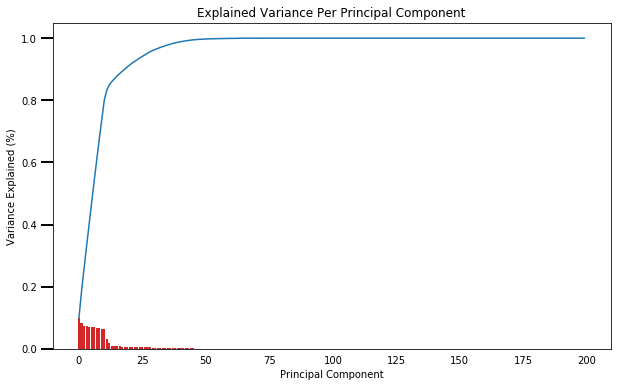

In [14]:
pca, X_train_pca_7 = do_pca(X_train_scaled_7)
scree_plot(pca)

In [15]:
n_components = 50
values = pca.explained_variance_ratio_
cumulative_values = np.cumsum(values)
print("With {} components, {:.4f}% of the variance is explained".format(n_components, cumulative_values[n_components -1]*100))

With 50 components, 99.6979% of the variance is explained


In [16]:
# 50 components explained most variance
n_components = 50
pca, X_train_pca_7 = do_pca(X_train_scaled_7, n_components=n_components)
X_train_pca_7.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_40,pca_comp_41,pca_comp_42,pca_comp_43,pca_comp_44,pca_comp_45,pca_comp_46,pca_comp_47,pca_comp_48,pca_comp_49
0,5.153008,-1.071640,0.062880,0.597409,-0.631008,0.026928,0.870925,0.359074,-1.494528,-2.550781,...,0.025454,0.005355,0.031654,0.130150,-0.444035,-0.231864,-0.050252,-0.001160,-0.166717,-0.364526
1,5.153008,-1.071640,0.062880,0.597409,-0.631008,0.026928,0.870925,0.359074,-1.494528,-2.550781,...,0.025454,0.005355,0.031654,0.130150,-0.444035,-0.231864,-0.050252,-0.001160,-0.166717,-0.364526
2,-3.619395,0.309121,-0.151792,-0.183900,0.048954,-0.193063,-0.172149,-0.109130,0.112153,0.208418,...,-0.089287,-0.055626,-0.178182,-0.193993,0.455541,0.178190,-0.015610,-0.008668,0.059066,0.052013
3,-3.619395,0.309121,-0.151792,-0.183900,0.048954,-0.193063,-0.172149,-0.109130,0.112153,0.208418,...,-0.089287,-0.055626,-0.178182,-0.193993,0.455541,0.178190,-0.015610,-0.008668,0.059066,0.052013
4,-2.807635,0.200949,-0.145326,-0.132833,0.002920,-0.174529,-0.106292,-0.085413,0.064686,0.107154,...,-0.077755,-0.051504,-0.054163,-0.046261,0.064467,-0.014931,-0.030655,0.004455,0.048380,0.168227


In [17]:
# transform valid and test
X_valid_pca_7 = pd.DataFrame(pca.transform(X_valid_scaled_7))
X_valid_pca_7.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_valid_pca_7.index = X_valid_scaled_7.index

X_test_pca_7 = pd.DataFrame(pca.transform(X_test_scaled_7))
X_test_pca_7.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca_7.index = X_test_scaled_7.index

In [18]:
# concat offer ids with X_train, X_valid, X_test
train_ind = train_7['offer_id_7']
valid_ind = valid_7['offer_id_7']
test_ind = test_7['offer_id_7']

X_train_pca_7 = pd.concat([X_train_pca_7, train_ind], axis=1)
X_valid_pca_7 = pd.concat([X_valid_pca_7, valid_ind], axis=1)
X_test_pca_7 = pd.concat([X_test_pca_7, test_ind], axis=1)

In [19]:
# first search to see which parameters to try
max_depth_list = [7]
upsamp_ratio_list = np.arange(0.1, 0.91, 0.1)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 7

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir, pos_strat_params =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_7, Y_train_7, X_valid_pca_7, Y_valid_7, X_test_pca_7, train_7, valid_7, test_7)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/351, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: 0.00, Test NIR: -18.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/351, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -31.25, Test NIR: -909.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/351, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: 12.42, Test NIR: -600.95
Current Best Depth: 7, Upsampling Ratio: 0.1, Min Child Weight: 20
Current Best Valid IRR: 0.40, NIR: 12.4200
Current Best Test IRR: -0.52, NIR: -600.9500


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/351, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: 12.65, Test NIR: -497.72
Current Best Depth: 7, Upsampling Ratio: 0.1, Min Child Weight: 25
Current Best Valid IRR: 0.44, NIR: 12.6500
Current Best Test IRR: -0.53, NIR: -497.7200


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/351, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: 25.49, Test NIR: -381.33
Current Best Depth: 7, Upsampling Ratio: 0.1, Min Child Weight: 30
Current Best Valid IRR: 0.56, NIR: 25.4900
Current Best Test IRR: -0.46, NIR: -381.3300


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/351, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -4.25, Test NIR: -332.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/351, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/351, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/351, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/351, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: 5.54, Test NIR: -103.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/351, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: 8.53, Test NIR: -95.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/351, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/351, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/351, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/351, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/351, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/351, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/351, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/351, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/351, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/351, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: -0.27, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/351, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/351, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/351, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/351, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/351, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/351, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/351, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/351, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/351, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/351, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/351, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/351, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/351, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/351, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/351, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/351, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/351, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/351, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/351, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: 0.00, Test NIR: 2.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/351, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -5.13, Test NIR: -3.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/351, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: 25.59, Test NIR: -101.66
Current Best Depth: 7, Upsampling Ratio: 0.2, Min Child Weight: 20
Current Best Valid IRR: 0.33, NIR: 25.5900
Current Best Test IRR: -0.20, NIR: -101.6600


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/351, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: 31.55, Test NIR: -119.26
Current Best Depth: 7, Upsampling Ratio: 0.2, Min Child Weight: 25
Current Best Valid IRR: 0.38, NIR: 31.5500
Current Best Test IRR: -0.27, NIR: -119.2600


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/351, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -0.13, Test NIR: -45.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/351, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: 10.26, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/351, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: 10.26, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/351, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: 16.09, Test NIR: -58.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/351, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: 10.39, Test NIR: -69.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/351, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/351, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: 15.52, Test NIR: -33.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/351, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/351, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/351, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: 10.97, Test NIR: -38.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/351, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/351, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: 1.51, Test NIR: -37.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/351, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: 1.51, Test NIR: -23.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/351, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: 11.17, Test NIR: -40.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/351, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: 3.85, Test NIR: -91.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/351, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: -9.02, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/351, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/351, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/351, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/351, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/351, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/351, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/351, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: 1.17, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/351, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/351, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/351, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/351, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/351, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/351, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/351, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/351, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/351, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/351, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/351, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/351, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/351, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/351, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: 4.71, Test NIR: -15.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/351, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -0.29, Test NIR: -0.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/351, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: 2.18, Test NIR: -53.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/351, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: 0.28, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/351, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: 0.00, Test NIR: -41.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/351, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/351, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/351, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -44.11, Test NIR: -46.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/351, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/351, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/351, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/351, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: 0.00, Test NIR: -9.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/351, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: 0.00, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/351, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -11.07, Test NIR: -38.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/351, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -2.55, Test NIR: -11.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/351, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/351, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/351, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: 6.93, Test NIR: -76.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/351, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: 2.49, Test NIR: -5.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/351, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/351, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/351, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: 1.19, Test NIR: -3.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/351, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/351, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: -38.42, Test NIR: -316.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/351, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/351, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/351, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/351, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/351, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: 11.55, Test NIR: -1590.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/351, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/351, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/351, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/351, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/351, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/351, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/351, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/351, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/351, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/351, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: 0.00, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/351, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -2.87, Test NIR: -62.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/351, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: 7.62, Test NIR: -31.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/351, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -8.58, Test NIR: -5.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/351, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: 3.55, Test NIR: -158.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/351, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/351, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/351, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/351, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/351, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/351, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: 8.89, Test NIR: -290.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/351, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/351, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/351, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/351, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/351, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/351, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/351, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/351, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/351, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: 1.73, Test NIR: 1.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/351, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: -8.23, Test NIR: -31.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/351, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: 13.58, Test NIR: -26.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/351, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/351, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: -24.19, Test NIR: -1298.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/351, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/351, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: -2.44, Test NIR: -2.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/351, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/351, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: -33.56, Test NIR: -333.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/351, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -5.20, Test NIR: -500.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/351, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/351, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -61.53, Test NIR: -306.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/351, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -34.46, Test NIR: -284.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/351, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: 23.11, Test NIR: -1768.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/351, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/351, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/351, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/351, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/351, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/351, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: -5.05, Test NIR: -1958.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/351, Depth: 7, Ratio: 0.500, Weight: 10, Valid NIR: -42.26, Test NIR: -741.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/351, Depth: 7, Ratio: 0.500, Weight: 15, Valid NIR: -42.26, Test NIR: -530.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/351, Depth: 7, Ratio: 0.500, Weight: 20, Valid NIR: -39.36, Test NIR: -280.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/351, Depth: 7, Ratio: 0.500, Weight: 25, Valid NIR: -39.36, Test NIR: -275.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/351, Depth: 7, Ratio: 0.500, Weight: 30, Valid NIR: -39.36, Test NIR: -267.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/351, Depth: 7, Ratio: 0.500, Weight: 35, Valid NIR: -39.36, Test NIR: -250.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/351, Depth: 7, Ratio: 0.500, Weight: 40, Valid NIR: -33.66, Test NIR: -186.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/351, Depth: 7, Ratio: 0.500, Weight: 45, Valid NIR: -30.46, Test NIR: -279.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/351, Depth: 7, Ratio: 0.500, Weight: 50, Valid NIR: -42.40, Test NIR: -389.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/351, Depth: 7, Ratio: 0.500, Weight: 55, Valid NIR: -42.40, Test NIR: -389.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/351, Depth: 7, Ratio: 0.500, Weight: 60, Valid NIR: -31.79, Test NIR: -490.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/351, Depth: 7, Ratio: 0.500, Weight: 65, Valid NIR: 41.78, Test NIR: -1240.86
Current Best Depth: 7, Upsampling Ratio: 0.5, Min Child Weight: 65
Current Best Valid IRR: 0.57, NIR: 41.7800
Current Best Test IRR: -0.37, NIR: -1240.8600


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/351, Depth: 7, Ratio: 0.500, Weight: 70, Valid NIR: -3.40, Test NIR: -429.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/351, Depth: 7, Ratio: 0.500, Weight: 75, Valid NIR: 10.98, Test NIR: -259.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/351, Depth: 7, Ratio: 0.500, Weight: 80, Valid NIR: 29.55, Test NIR: -151.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/351, Depth: 7, Ratio: 0.500, Weight: 85, Valid NIR: 24.86, Test NIR: -247.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/351, Depth: 7, Ratio: 0.500, Weight: 90, Valid NIR: 13.16, Test NIR: -72.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/351, Depth: 7, Ratio: 0.500, Weight: 95, Valid NIR: 19.72, Test NIR: -140.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/351, Depth: 7, Ratio: 0.500, Weight: 100, Valid NIR: -1.36, Test NIR: -537.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/351, Depth: 7, Ratio: 0.500, Weight: 105, Valid NIR: 27.53, Test NIR: -672.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/351, Depth: 7, Ratio: 0.500, Weight: 110, Valid NIR: 6.74, Test NIR: -1715.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/351, Depth: 7, Ratio: 0.500, Weight: 115, Valid NIR: 6.74, Test NIR: -1708.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/351, Depth: 7, Ratio: 0.500, Weight: 120, Valid NIR: 6.74, Test NIR: -1703.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/351, Depth: 7, Ratio: 0.500, Weight: 125, Valid NIR: 6.74, Test NIR: -1704.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/351, Depth: 7, Ratio: 0.500, Weight: 130, Valid NIR: -1.79, Test NIR: -1686.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/351, Depth: 7, Ratio: 0.500, Weight: 135, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/351, Depth: 7, Ratio: 0.500, Weight: 140, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/351, Depth: 7, Ratio: 0.500, Weight: 145, Valid NIR: -50.36, Test NIR: -124.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/351, Depth: 7, Ratio: 0.500, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/351, Depth: 7, Ratio: 0.500, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/351, Depth: 7, Ratio: 0.500, Weight: 160, Valid NIR: 58.10, Test NIR: -3686.56
Current Best Depth: 7, Upsampling Ratio: 0.5, Min Child Weight: 160
Current Best Valid IRR: 0.32, NIR: 58.1000
Current Best Test IRR: -0.38, NIR: -3686.5600


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/351, Depth: 7, Ratio: 0.500, Weight: 165, Valid NIR: 23.61, Test NIR: -3037.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/351, Depth: 7, Ratio: 0.500, Weight: 170, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/351, Depth: 7, Ratio: 0.500, Weight: 175, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/351, Depth: 7, Ratio: 0.500, Weight: 180, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/351, Depth: 7, Ratio: 0.500, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/351, Depth: 7, Ratio: 0.500, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/351, Depth: 7, Ratio: 0.500, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/351, Depth: 7, Ratio: 0.500, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/351, Depth: 7, Ratio: 0.600, Weight: 10, Valid NIR: 48.67, Test NIR: -1122.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/351, Depth: 7, Ratio: 0.600, Weight: 15, Valid NIR: -5.66, Test NIR: -28.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/351, Depth: 7, Ratio: 0.600, Weight: 20, Valid NIR: 34.14, Test NIR: -1034.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/351, Depth: 7, Ratio: 0.600, Weight: 25, Valid NIR: -51.72, Test NIR: -673.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/351, Depth: 7, Ratio: 0.600, Weight: 30, Valid NIR: -18.81, Test NIR: -1367.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/351, Depth: 7, Ratio: 0.600, Weight: 35, Valid NIR: -1.23, Test NIR: -1296.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/351, Depth: 7, Ratio: 0.600, Weight: 40, Valid NIR: 40.00, Test NIR: -1357.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/351, Depth: 7, Ratio: 0.600, Weight: 45, Valid NIR: -12.25, Test NIR: -364.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/351, Depth: 7, Ratio: 0.600, Weight: 50, Valid NIR: -32.96, Test NIR: -448.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/351, Depth: 7, Ratio: 0.600, Weight: 55, Valid NIR: -32.96, Test NIR: -472.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/351, Depth: 7, Ratio: 0.600, Weight: 60, Valid NIR: 4.85, Test NIR: -1307.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/351, Depth: 7, Ratio: 0.600, Weight: 65, Valid NIR: -17.85, Test NIR: -1862.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/351, Depth: 7, Ratio: 0.600, Weight: 70, Valid NIR: 15.24, Test NIR: -1743.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/351, Depth: 7, Ratio: 0.600, Weight: 75, Valid NIR: -24.54, Test NIR: -597.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/351, Depth: 7, Ratio: 0.600, Weight: 80, Valid NIR: -4.54, Test NIR: -90.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/351, Depth: 7, Ratio: 0.600, Weight: 85, Valid NIR: 75.61, Test NIR: -2269.07
Current Best Depth: 7, Upsampling Ratio: 0.6, Min Child Weight: 85
Current Best Valid IRR: 0.41, NIR: 75.6100
Current Best Test IRR: -0.33, NIR: -2269.0700


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/351, Depth: 7, Ratio: 0.600, Weight: 90, Valid NIR: 10.59, Test NIR: -2677.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/351, Depth: 7, Ratio: 0.600, Weight: 95, Valid NIR: 25.79, Test NIR: -2819.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/351, Depth: 7, Ratio: 0.600, Weight: 100, Valid NIR: 78.48, Test NIR: -2058.53
Current Best Depth: 7, Upsampling Ratio: 0.6, Min Child Weight: 100
Current Best Valid IRR: 0.39, NIR: 78.4800
Current Best Test IRR: -0.35, NIR: -2058.5300


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/351, Depth: 7, Ratio: 0.600, Weight: 105, Valid NIR: 73.53, Test NIR: -2203.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/351, Depth: 7, Ratio: 0.600, Weight: 110, Valid NIR: 104.08, Test NIR: -2236.50
Current Best Depth: 7, Upsampling Ratio: 0.6, Min Child Weight: 110
Current Best Valid IRR: 0.36, NIR: 104.0800
Current Best Test IRR: -0.35, NIR: -2236.5000


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/351, Depth: 7, Ratio: 0.600, Weight: 115, Valid NIR: 83.48, Test NIR: -2085.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/351, Depth: 7, Ratio: 0.600, Weight: 120, Valid NIR: 84.68, Test NIR: -2111.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/351, Depth: 7, Ratio: 0.600, Weight: 125, Valid NIR: 57.67, Test NIR: -3145.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/351, Depth: 7, Ratio: 0.600, Weight: 130, Valid NIR: 86.68, Test NIR: -2605.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/351, Depth: 7, Ratio: 0.600, Weight: 135, Valid NIR: 86.68, Test NIR: -2605.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/351, Depth: 7, Ratio: 0.600, Weight: 140, Valid NIR: 76.61, Test NIR: -2597.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/351, Depth: 7, Ratio: 0.600, Weight: 145, Valid NIR: 90.16, Test NIR: -2649.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/351, Depth: 7, Ratio: 0.600, Weight: 150, Valid NIR: 76.61, Test NIR: -2601.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/351, Depth: 7, Ratio: 0.600, Weight: 155, Valid NIR: 22.57, Test NIR: -1360.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/351, Depth: 7, Ratio: 0.600, Weight: 160, Valid NIR: 77.16, Test NIR: -3235.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/351, Depth: 7, Ratio: 0.600, Weight: 165, Valid NIR: 61.96, Test NIR: -3228.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/351, Depth: 7, Ratio: 0.600, Weight: 170, Valid NIR: 54.58, Test NIR: -3657.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/351, Depth: 7, Ratio: 0.600, Weight: 175, Valid NIR: 54.58, Test NIR: -3815.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/351, Depth: 7, Ratio: 0.600, Weight: 180, Valid NIR: 54.58, Test NIR: -3800.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/351, Depth: 7, Ratio: 0.600, Weight: 185, Valid NIR: 54.30, Test NIR: -3859.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/351, Depth: 7, Ratio: 0.600, Weight: 190, Valid NIR: 41.65, Test NIR: -3194.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/351, Depth: 7, Ratio: 0.600, Weight: 195, Valid NIR: 40.08, Test NIR: -3188.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/351, Depth: 7, Ratio: 0.600, Weight: 200, Valid NIR: 27.04, Test NIR: -3835.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/351, Depth: 7, Ratio: 0.700, Weight: 10, Valid NIR: -16.33, Test NIR: -402.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/351, Depth: 7, Ratio: 0.700, Weight: 15, Valid NIR: -66.85, Test NIR: -1091.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/351, Depth: 7, Ratio: 0.700, Weight: 20, Valid NIR: -70.21, Test NIR: -1259.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/351, Depth: 7, Ratio: 0.700, Weight: 25, Valid NIR: -5.76, Test NIR: -2919.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/351, Depth: 7, Ratio: 0.700, Weight: 30, Valid NIR: -55.84, Test NIR: -892.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/351, Depth: 7, Ratio: 0.700, Weight: 35, Valid NIR: 11.51, Test NIR: -3082.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/351, Depth: 7, Ratio: 0.700, Weight: 40, Valid NIR: 1.95, Test NIR: -2802.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/351, Depth: 7, Ratio: 0.700, Weight: 45, Valid NIR: -30.72, Test NIR: -423.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/351, Depth: 7, Ratio: 0.700, Weight: 50, Valid NIR: -36.32, Test NIR: -2255.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/351, Depth: 7, Ratio: 0.700, Weight: 55, Valid NIR: 1.59, Test NIR: -2428.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/351, Depth: 7, Ratio: 0.700, Weight: 60, Valid NIR: 15.57, Test NIR: -1775.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/351, Depth: 7, Ratio: 0.700, Weight: 65, Valid NIR: -53.61, Test NIR: -1902.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/351, Depth: 7, Ratio: 0.700, Weight: 70, Valid NIR: -52.70, Test NIR: -1724.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/351, Depth: 7, Ratio: 0.700, Weight: 75, Valid NIR: -59.48, Test NIR: -1401.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/351, Depth: 7, Ratio: 0.700, Weight: 80, Valid NIR: 7.90, Test NIR: -2180.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/351, Depth: 7, Ratio: 0.700, Weight: 85, Valid NIR: 12.45, Test NIR: -1792.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/351, Depth: 7, Ratio: 0.700, Weight: 90, Valid NIR: -0.10, Test NIR: -2296.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/351, Depth: 7, Ratio: 0.700, Weight: 95, Valid NIR: 12.73, Test NIR: -2905.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/351, Depth: 7, Ratio: 0.700, Weight: 100, Valid NIR: 12.73, Test NIR: -2905.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/351, Depth: 7, Ratio: 0.700, Weight: 105, Valid NIR: 20.45, Test NIR: -2874.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/351, Depth: 7, Ratio: 0.700, Weight: 110, Valid NIR: 22.41, Test NIR: -2944.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/351, Depth: 7, Ratio: 0.700, Weight: 115, Valid NIR: 22.41, Test NIR: -2944.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/351, Depth: 7, Ratio: 0.700, Weight: 120, Valid NIR: 22.41, Test NIR: -2944.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/351, Depth: 7, Ratio: 0.700, Weight: 125, Valid NIR: 49.88, Test NIR: -3062.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/351, Depth: 7, Ratio: 0.700, Weight: 130, Valid NIR: 35.42, Test NIR: -3042.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/351, Depth: 7, Ratio: 0.700, Weight: 135, Valid NIR: 15.61, Test NIR: -2940.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/351, Depth: 7, Ratio: 0.700, Weight: 140, Valid NIR: 15.61, Test NIR: -2940.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/351, Depth: 7, Ratio: 0.700, Weight: 145, Valid NIR: 14.12, Test NIR: -2959.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/351, Depth: 7, Ratio: 0.700, Weight: 150, Valid NIR: 15.68, Test NIR: -3150.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/351, Depth: 7, Ratio: 0.700, Weight: 155, Valid NIR: 20.07, Test NIR: -3129.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/351, Depth: 7, Ratio: 0.700, Weight: 160, Valid NIR: 20.07, Test NIR: -3129.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/351, Depth: 7, Ratio: 0.700, Weight: 165, Valid NIR: -2.73, Test NIR: -3083.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/351, Depth: 7, Ratio: 0.700, Weight: 170, Valid NIR: -2.73, Test NIR: -3071.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/351, Depth: 7, Ratio: 0.700, Weight: 175, Valid NIR: 24.29, Test NIR: -2995.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/351, Depth: 7, Ratio: 0.700, Weight: 180, Valid NIR: 24.29, Test NIR: -2969.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/351, Depth: 7, Ratio: 0.700, Weight: 185, Valid NIR: 25.86, Test NIR: -2974.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/351, Depth: 7, Ratio: 0.700, Weight: 190, Valid NIR: 27.79, Test NIR: -3854.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/351, Depth: 7, Ratio: 0.700, Weight: 195, Valid NIR: 33.20, Test NIR: -2930.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/351, Depth: 7, Ratio: 0.700, Weight: 200, Valid NIR: 21.74, Test NIR: -3709.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/351, Depth: 7, Ratio: 0.800, Weight: 10, Valid NIR: 77.43, Test NIR: -360.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/351, Depth: 7, Ratio: 0.800, Weight: 15, Valid NIR: 26.46, Test NIR: -709.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/351, Depth: 7, Ratio: 0.800, Weight: 20, Valid NIR: -13.95, Test NIR: -2160.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/351, Depth: 7, Ratio: 0.800, Weight: 25, Valid NIR: -17.86, Test NIR: -2033.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/351, Depth: 7, Ratio: 0.800, Weight: 30, Valid NIR: -1.61, Test NIR: -1821.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/351, Depth: 7, Ratio: 0.800, Weight: 35, Valid NIR: 13.11, Test NIR: -650.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/351, Depth: 7, Ratio: 0.800, Weight: 40, Valid NIR: 29.58, Test NIR: -710.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/351, Depth: 7, Ratio: 0.800, Weight: 45, Valid NIR: -21.54, Test NIR: -756.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/351, Depth: 7, Ratio: 0.800, Weight: 50, Valid NIR: -11.15, Test NIR: -1281.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/351, Depth: 7, Ratio: 0.800, Weight: 55, Valid NIR: -28.74, Test NIR: -640.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/351, Depth: 7, Ratio: 0.800, Weight: 60, Valid NIR: -11.52, Test NIR: -535.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/351, Depth: 7, Ratio: 0.800, Weight: 65, Valid NIR: -2.67, Test NIR: -777.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/351, Depth: 7, Ratio: 0.800, Weight: 70, Valid NIR: -29.37, Test NIR: -163.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/351, Depth: 7, Ratio: 0.800, Weight: 75, Valid NIR: 44.78, Test NIR: -1377.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/351, Depth: 7, Ratio: 0.800, Weight: 80, Valid NIR: 19.83, Test NIR: -1239.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/351, Depth: 7, Ratio: 0.800, Weight: 85, Valid NIR: -16.42, Test NIR: -897.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/351, Depth: 7, Ratio: 0.800, Weight: 90, Valid NIR: 54.34, Test NIR: -1334.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/351, Depth: 7, Ratio: 0.800, Weight: 95, Valid NIR: -18.07, Test NIR: -894.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/351, Depth: 7, Ratio: 0.800, Weight: 100, Valid NIR: -6.73, Test NIR: -1760.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/351, Depth: 7, Ratio: 0.800, Weight: 105, Valid NIR: 35.97, Test NIR: -1629.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/351, Depth: 7, Ratio: 0.800, Weight: 110, Valid NIR: 37.17, Test NIR: -1616.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/351, Depth: 7, Ratio: 0.800, Weight: 115, Valid NIR: 37.17, Test NIR: -1616.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/351, Depth: 7, Ratio: 0.800, Weight: 120, Valid NIR: -6.40, Test NIR: -1789.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/351, Depth: 7, Ratio: 0.800, Weight: 125, Valid NIR: -6.40, Test NIR: -1775.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/351, Depth: 7, Ratio: 0.800, Weight: 130, Valid NIR: -6.40, Test NIR: -1789.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/351, Depth: 7, Ratio: 0.800, Weight: 135, Valid NIR: -6.73, Test NIR: -1768.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/351, Depth: 7, Ratio: 0.800, Weight: 140, Valid NIR: -6.73, Test NIR: -1754.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/351, Depth: 7, Ratio: 0.800, Weight: 145, Valid NIR: -20.57, Test NIR: -1715.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/351, Depth: 7, Ratio: 0.800, Weight: 150, Valid NIR: -6.73, Test NIR: -1792.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/351, Depth: 7, Ratio: 0.800, Weight: 155, Valid NIR: 6.20, Test NIR: -1672.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/351, Depth: 7, Ratio: 0.800, Weight: 160, Valid NIR: -23.16, Test NIR: -1650.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/351, Depth: 7, Ratio: 0.800, Weight: 165, Valid NIR: -5.00, Test NIR: -1821.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/351, Depth: 7, Ratio: 0.800, Weight: 170, Valid NIR: -16.65, Test NIR: -1765.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/351, Depth: 7, Ratio: 0.800, Weight: 175, Valid NIR: 15.31, Test NIR: -1778.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/351, Depth: 7, Ratio: 0.800, Weight: 180, Valid NIR: 14.02, Test NIR: -1730.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/351, Depth: 7, Ratio: 0.800, Weight: 185, Valid NIR: 21.72, Test NIR: -1750.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/351, Depth: 7, Ratio: 0.800, Weight: 190, Valid NIR: 14.02, Test NIR: -1691.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/351, Depth: 7, Ratio: 0.800, Weight: 195, Valid NIR: 10.82, Test NIR: -1647.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/351, Depth: 7, Ratio: 0.800, Weight: 200, Valid NIR: 15.92, Test NIR: -1680.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/351, Depth: 7, Ratio: 0.900, Weight: 10, Valid NIR: -4.06, Test NIR: -1809.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/351, Depth: 7, Ratio: 0.900, Weight: 15, Valid NIR: -14.64, Test NIR: -2332.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/351, Depth: 7, Ratio: 0.900, Weight: 20, Valid NIR: -23.95, Test NIR: -2406.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/351, Depth: 7, Ratio: 0.900, Weight: 25, Valid NIR: -4.82, Test NIR: -2429.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/351, Depth: 7, Ratio: 0.900, Weight: 30, Valid NIR: 11.71, Test NIR: -1313.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/351, Depth: 7, Ratio: 0.900, Weight: 35, Valid NIR: -3.54, Test NIR: -1566.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/351, Depth: 7, Ratio: 0.900, Weight: 40, Valid NIR: 36.00, Test NIR: -312.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/351, Depth: 7, Ratio: 0.900, Weight: 45, Valid NIR: 8.21, Test NIR: -1575.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/351, Depth: 7, Ratio: 0.900, Weight: 50, Valid NIR: 37.82, Test NIR: -1026.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/351, Depth: 7, Ratio: 0.900, Weight: 55, Valid NIR: 10.53, Test NIR: -467.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/351, Depth: 7, Ratio: 0.900, Weight: 60, Valid NIR: 46.54, Test NIR: -943.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/351, Depth: 7, Ratio: 0.900, Weight: 65, Valid NIR: 0.42, Test NIR: -1508.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/351, Depth: 7, Ratio: 0.900, Weight: 70, Valid NIR: 20.34, Test NIR: -1402.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/351, Depth: 7, Ratio: 0.900, Weight: 75, Valid NIR: -17.78, Test NIR: -1297.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/351, Depth: 7, Ratio: 0.900, Weight: 80, Valid NIR: 51.23, Test NIR: -1593.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/351, Depth: 7, Ratio: 0.900, Weight: 85, Valid NIR: 11.38, Test NIR: -1457.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/351, Depth: 7, Ratio: 0.900, Weight: 90, Valid NIR: 22.32, Test NIR: -1438.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/351, Depth: 7, Ratio: 0.900, Weight: 95, Valid NIR: 62.63, Test NIR: -1773.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/351, Depth: 7, Ratio: 0.900, Weight: 100, Valid NIR: 47.77, Test NIR: -980.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/351, Depth: 7, Ratio: 0.900, Weight: 105, Valid NIR: 40.33, Test NIR: -1535.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/351, Depth: 7, Ratio: 0.900, Weight: 110, Valid NIR: 42.46, Test NIR: -1548.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/351, Depth: 7, Ratio: 0.900, Weight: 115, Valid NIR: 42.46, Test NIR: -1548.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/351, Depth: 7, Ratio: 0.900, Weight: 120, Valid NIR: 42.46, Test NIR: -1548.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/351, Depth: 7, Ratio: 0.900, Weight: 125, Valid NIR: 27.48, Test NIR: -1643.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/351, Depth: 7, Ratio: 0.900, Weight: 130, Valid NIR: 27.48, Test NIR: -1643.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/351, Depth: 7, Ratio: 0.900, Weight: 135, Valid NIR: 36.03, Test NIR: -1536.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/351, Depth: 7, Ratio: 0.900, Weight: 140, Valid NIR: 36.03, Test NIR: -1536.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/351, Depth: 7, Ratio: 0.900, Weight: 145, Valid NIR: 36.03, Test NIR: -1515.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/351, Depth: 7, Ratio: 0.900, Weight: 150, Valid NIR: 36.03, Test NIR: -1515.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/351, Depth: 7, Ratio: 0.900, Weight: 155, Valid NIR: 40.81, Test NIR: -1705.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/351, Depth: 7, Ratio: 0.900, Weight: 160, Valid NIR: 25.77, Test NIR: -1607.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/351, Depth: 7, Ratio: 0.900, Weight: 165, Valid NIR: 25.77, Test NIR: -1607.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/351, Depth: 7, Ratio: 0.900, Weight: 170, Valid NIR: 30.27, Test NIR: -1642.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/351, Depth: 7, Ratio: 0.900, Weight: 175, Valid NIR: 21.46, Test NIR: -1524.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/351, Depth: 7, Ratio: 0.900, Weight: 180, Valid NIR: 31.98, Test NIR: -1720.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/351, Depth: 7, Ratio: 0.900, Weight: 185, Valid NIR: 31.98, Test NIR: -1720.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/351, Depth: 7, Ratio: 0.900, Weight: 190, Valid NIR: 31.98, Test NIR: -1659.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/351, Depth: 7, Ratio: 0.900, Weight: 195, Valid NIR: 15.59, Test NIR: -1727.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/351, Depth: 7, Ratio: 0.900, Weight: 200, Valid NIR: 23.26, Test NIR: -1782.14


In [20]:
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

7
0.6
110
104.08000000000001
-2236.5000000000005


In [21]:
print_pos_strat_params(pos_strat_params)

Valid NIR: 1.73, Test NIR: 1.04, Tree Depth: 7, Upsampling Ratio: 0.40, Min Child Weight: 105


In [22]:
max_depth_list = [7,8,9]
upsamp_ratio_list = np.arange(0.08, 0.51, 0.01)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 7

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir, pos_strat_params =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_7, Y_train_7, X_valid_pca_7, Y_valid_7, X_test_pca_7, train_7, valid_7, test_7)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/5031, Depth: 7, Ratio: 0.080, Weight: 10, Valid NIR: -17.46, Test NIR: -1244.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/5031, Depth: 7, Ratio: 0.080, Weight: 15, Valid NIR: -17.48, Test NIR: -752.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/5031, Depth: 7, Ratio: 0.080, Weight: 20, Valid NIR: 9.91, Test NIR: -185.28
Current Best Depth: 7, Upsampling Ratio: 0.08, Min Child Weight: 20
Current Best Valid IRR: 0.00, NIR: 9.9100
Current Best Test IRR: -0.27, NIR: -185.2800


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/5031, Depth: 7, Ratio: 0.080, Weight: 25, Valid NIR: 9.91, Test NIR: -145.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/5031, Depth: 7, Ratio: 0.080, Weight: 30, Valid NIR: 25.79, Test NIR: -96.77
Current Best Depth: 7, Upsampling Ratio: 0.08, Min Child Weight: 30
Current Best Valid IRR: 0.00, NIR: 25.7900
Current Best Test IRR: -0.37, NIR: -96.7700


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/5031, Depth: 7, Ratio: 0.080, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/5031, Depth: 7, Ratio: 0.080, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/5031, Depth: 7, Ratio: 0.080, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/5031, Depth: 7, Ratio: 0.080, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/5031, Depth: 7, Ratio: 0.080, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/5031, Depth: 7, Ratio: 0.080, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/5031, Depth: 7, Ratio: 0.080, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/5031, Depth: 7, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/5031, Depth: 7, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/5031, Depth: 7, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/5031, Depth: 7, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/5031, Depth: 7, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/5031, Depth: 7, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/5031, Depth: 7, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/5031, Depth: 7, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/5031, Depth: 7, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/5031, Depth: 7, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/5031, Depth: 7, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/5031, Depth: 7, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/5031, Depth: 7, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/5031, Depth: 7, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/5031, Depth: 7, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/5031, Depth: 7, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/5031, Depth: 7, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/5031, Depth: 7, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/5031, Depth: 7, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/5031, Depth: 7, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/5031, Depth: 7, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/5031, Depth: 7, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/5031, Depth: 7, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/5031, Depth: 7, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/5031, Depth: 7, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/5031, Depth: 7, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/5031, Depth: 7, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/5031, Depth: 7, Ratio: 0.090, Weight: 10, Valid NIR: 20.62, Test NIR: -750.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/5031, Depth: 7, Ratio: 0.090, Weight: 15, Valid NIR: 24.78, Test NIR: -936.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/5031, Depth: 7, Ratio: 0.090, Weight: 20, Valid NIR: 15.45, Test NIR: -425.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/5031, Depth: 7, Ratio: 0.090, Weight: 25, Valid NIR: 15.45, Test NIR: -379.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/5031, Depth: 7, Ratio: 0.090, Weight: 30, Valid NIR: 15.45, Test NIR: -359.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/5031, Depth: 7, Ratio: 0.090, Weight: 35, Valid NIR: 3.50, Test NIR: -148.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/5031, Depth: 7, Ratio: 0.090, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/5031, Depth: 7, Ratio: 0.090, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/5031, Depth: 7, Ratio: 0.090, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/5031, Depth: 7, Ratio: 0.090, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/5031, Depth: 7, Ratio: 0.090, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/5031, Depth: 7, Ratio: 0.090, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/5031, Depth: 7, Ratio: 0.090, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/5031, Depth: 7, Ratio: 0.090, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/5031, Depth: 7, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/5031, Depth: 7, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/5031, Depth: 7, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/5031, Depth: 7, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/5031, Depth: 7, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/5031, Depth: 7, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/5031, Depth: 7, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/5031, Depth: 7, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/5031, Depth: 7, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/5031, Depth: 7, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/5031, Depth: 7, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/5031, Depth: 7, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/5031, Depth: 7, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/5031, Depth: 7, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/5031, Depth: 7, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/5031, Depth: 7, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/5031, Depth: 7, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/5031, Depth: 7, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/5031, Depth: 7, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/5031, Depth: 7, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/5031, Depth: 7, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/5031, Depth: 7, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/5031, Depth: 7, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/5031, Depth: 7, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/5031, Depth: 7, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/5031, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: 55.71, Test NIR: -1258.55
Current Best Depth: 7, Upsampling Ratio: 0.09999999999999999, Min Child Weight: 10
Current Best Valid IRR: 0.64, NIR: 55.7100
Current Best Test IRR: -0.46, NIR: -1258.5500


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/5031, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -31.25, Test NIR: -909.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/5031, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: 12.42, Test NIR: -600.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/5031, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: 12.65, Test NIR: -497.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/5031, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: 25.49, Test NIR: -381.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/5031, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -4.25, Test NIR: -332.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/5031, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/5031, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/5031, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/5031, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: 5.54, Test NIR: -103.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/5031, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: 8.53, Test NIR: -95.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/5031, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/5031, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/5031, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/5031, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/5031, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/5031, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/5031, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/5031, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/5031, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/5031, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: -0.27, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/5031, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/5031, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/5031, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/5031, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/5031, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/5031, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/5031, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/5031, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/5031, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/5031, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/5031, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/5031, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/5031, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/5031, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/5031, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/5031, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/5031, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/5031, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/5031, Depth: 7, Ratio: 0.110, Weight: 10, Valid NIR: 12.51, Test NIR: -1344.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/5031, Depth: 7, Ratio: 0.110, Weight: 15, Valid NIR: 74.62, Test NIR: -809.16
Current Best Depth: 7, Upsampling Ratio: 0.10999999999999999, Min Child Weight: 15
Current Best Valid IRR: 0.60, NIR: 74.6200
Current Best Test IRR: -0.40, NIR: -809.1600


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/5031, Depth: 7, Ratio: 0.110, Weight: 20, Valid NIR: 57.99, Test NIR: -854.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/5031, Depth: 7, Ratio: 0.110, Weight: 25, Valid NIR: 41.66, Test NIR: -714.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/5031, Depth: 7, Ratio: 0.110, Weight: 30, Valid NIR: 2.28, Test NIR: -392.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/5031, Depth: 7, Ratio: 0.110, Weight: 35, Valid NIR: -13.91, Test NIR: -314.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/5031, Depth: 7, Ratio: 0.110, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/5031, Depth: 7, Ratio: 0.110, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/5031, Depth: 7, Ratio: 0.110, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/5031, Depth: 7, Ratio: 0.110, Weight: 55, Valid NIR: 8.26, Test NIR: -2.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/5031, Depth: 7, Ratio: 0.110, Weight: 60, Valid NIR: 8.26, Test NIR: -58.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/5031, Depth: 7, Ratio: 0.110, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/5031, Depth: 7, Ratio: 0.110, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/5031, Depth: 7, Ratio: 0.110, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/5031, Depth: 7, Ratio: 0.110, Weight: 80, Valid NIR: -0.27, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/5031, Depth: 7, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/5031, Depth: 7, Ratio: 0.110, Weight: 90, Valid NIR: -0.27, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/5031, Depth: 7, Ratio: 0.110, Weight: 95, Valid NIR: -0.27, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/5031, Depth: 7, Ratio: 0.110, Weight: 100, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/5031, Depth: 7, Ratio: 0.110, Weight: 105, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/5031, Depth: 7, Ratio: 0.110, Weight: 110, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/5031, Depth: 7, Ratio: 0.110, Weight: 115, Valid NIR: -0.27, Test NIR: 1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/5031, Depth: 7, Ratio: 0.110, Weight: 120, Valid NIR: -0.27, Test NIR: 1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/5031, Depth: 7, Ratio: 0.110, Weight: 125, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/5031, Depth: 7, Ratio: 0.110, Weight: 130, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/5031, Depth: 7, Ratio: 0.110, Weight: 135, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/5031, Depth: 7, Ratio: 0.110, Weight: 140, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/5031, Depth: 7, Ratio: 0.110, Weight: 145, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/5031, Depth: 7, Ratio: 0.110, Weight: 150, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/5031, Depth: 7, Ratio: 0.110, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/5031, Depth: 7, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/5031, Depth: 7, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/5031, Depth: 7, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/5031, Depth: 7, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/5031, Depth: 7, Ratio: 0.110, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/5031, Depth: 7, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/5031, Depth: 7, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/5031, Depth: 7, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/5031, Depth: 7, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/5031, Depth: 7, Ratio: 0.120, Weight: 10, Valid NIR: 5.72, Test NIR: -1379.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/5031, Depth: 7, Ratio: 0.120, Weight: 15, Valid NIR: -30.33, Test NIR: -1297.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/5031, Depth: 7, Ratio: 0.120, Weight: 20, Valid NIR: -6.14, Test NIR: -1681.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/5031, Depth: 7, Ratio: 0.120, Weight: 25, Valid NIR: 42.78, Test NIR: -679.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/5031, Depth: 7, Ratio: 0.120, Weight: 30, Valid NIR: 10.28, Test NIR: -608.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/5031, Depth: 7, Ratio: 0.120, Weight: 35, Valid NIR: 6.01, Test NIR: -313.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/5031, Depth: 7, Ratio: 0.120, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/5031, Depth: 7, Ratio: 0.120, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/5031, Depth: 7, Ratio: 0.120, Weight: 50, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/5031, Depth: 7, Ratio: 0.120, Weight: 55, Valid NIR: 24.33, Test NIR: -84.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/5031, Depth: 7, Ratio: 0.120, Weight: 60, Valid NIR: 24.33, Test NIR: -84.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/5031, Depth: 7, Ratio: 0.120, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/5031, Depth: 7, Ratio: 0.120, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/5031, Depth: 7, Ratio: 0.120, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/5031, Depth: 7, Ratio: 0.120, Weight: 80, Valid NIR: 21.61, Test NIR: -34.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/5031, Depth: 7, Ratio: 0.120, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/5031, Depth: 7, Ratio: 0.120, Weight: 90, Valid NIR: 21.34, Test NIR: -39.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/5031, Depth: 7, Ratio: 0.120, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/5031, Depth: 7, Ratio: 0.120, Weight: 100, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/5031, Depth: 7, Ratio: 0.120, Weight: 105, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/5031, Depth: 7, Ratio: 0.120, Weight: 110, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/5031, Depth: 7, Ratio: 0.120, Weight: 115, Valid NIR: -0.27, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/5031, Depth: 7, Ratio: 0.120, Weight: 120, Valid NIR: -0.27, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/5031, Depth: 7, Ratio: 0.120, Weight: 125, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/5031, Depth: 7, Ratio: 0.120, Weight: 130, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/5031, Depth: 7, Ratio: 0.120, Weight: 135, Valid NIR: -24.36, Test NIR: -71.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/5031, Depth: 7, Ratio: 0.120, Weight: 140, Valid NIR: 26.69, Test NIR: -60.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/5031, Depth: 7, Ratio: 0.120, Weight: 145, Valid NIR: -0.27, Test NIR: -1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/5031, Depth: 7, Ratio: 0.120, Weight: 150, Valid NIR: -0.27, Test NIR: -1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/5031, Depth: 7, Ratio: 0.120, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/5031, Depth: 7, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/5031, Depth: 7, Ratio: 0.120, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/5031, Depth: 7, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/5031, Depth: 7, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/5031, Depth: 7, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/5031, Depth: 7, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/5031, Depth: 7, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/5031, Depth: 7, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/5031, Depth: 7, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/5031, Depth: 7, Ratio: 0.130, Weight: 10, Valid NIR: 3.10, Test NIR: -1369.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/5031, Depth: 7, Ratio: 0.130, Weight: 15, Valid NIR: 27.21, Test NIR: -1089.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/5031, Depth: 7, Ratio: 0.130, Weight: 20, Valid NIR: 56.33, Test NIR: -991.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/5031, Depth: 7, Ratio: 0.130, Weight: 25, Valid NIR: 56.33, Test NIR: -973.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/5031, Depth: 7, Ratio: 0.130, Weight: 30, Valid NIR: 24.72, Test NIR: -520.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/5031, Depth: 7, Ratio: 0.130, Weight: 35, Valid NIR: 17.88, Test NIR: -560.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/5031, Depth: 7, Ratio: 0.130, Weight: 40, Valid NIR: 0.00, Test NIR: -1.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/5031, Depth: 7, Ratio: 0.130, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/5031, Depth: 7, Ratio: 0.130, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/5031, Depth: 7, Ratio: 0.130, Weight: 55, Valid NIR: 13.76, Test NIR: -141.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/5031, Depth: 7, Ratio: 0.130, Weight: 60, Valid NIR: 27.78, Test NIR: -638.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/5031, Depth: 7, Ratio: 0.130, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/5031, Depth: 7, Ratio: 0.130, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/5031, Depth: 7, Ratio: 0.130, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/5031, Depth: 7, Ratio: 0.130, Weight: 80, Valid NIR: 22.29, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/5031, Depth: 7, Ratio: 0.130, Weight: 85, Valid NIR: 0.00, Test NIR: -24.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/5031, Depth: 7, Ratio: 0.130, Weight: 90, Valid NIR: 22.29, Test NIR: -21.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/5031, Depth: 7, Ratio: 0.130, Weight: 95, Valid NIR: 22.29, Test NIR: -28.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/5031, Depth: 7, Ratio: 0.130, Weight: 100, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/5031, Depth: 7, Ratio: 0.130, Weight: 105, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/5031, Depth: 7, Ratio: 0.130, Weight: 110, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/5031, Depth: 7, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: 13.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/5031, Depth: 7, Ratio: 0.130, Weight: 120, Valid NIR: 0.00, Test NIR: 13.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/5031, Depth: 7, Ratio: 0.130, Weight: 125, Valid NIR: 3.50, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/5031, Depth: 7, Ratio: 0.130, Weight: 130, Valid NIR: 3.50, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/5031, Depth: 7, Ratio: 0.130, Weight: 135, Valid NIR: 34.05, Test NIR: -77.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/5031, Depth: 7, Ratio: 0.130, Weight: 140, Valid NIR: 56.34, Test NIR: -43.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/5031, Depth: 7, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/5031, Depth: 7, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/5031, Depth: 7, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/5031, Depth: 7, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/5031, Depth: 7, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/5031, Depth: 7, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/5031, Depth: 7, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/5031, Depth: 7, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/5031, Depth: 7, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/5031, Depth: 7, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/5031, Depth: 7, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/5031, Depth: 7, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/5031, Depth: 7, Ratio: 0.140, Weight: 10, Valid NIR: 8.63, Test NIR: -662.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/5031, Depth: 7, Ratio: 0.140, Weight: 15, Valid NIR: 14.18, Test NIR: -411.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/5031, Depth: 7, Ratio: 0.140, Weight: 20, Valid NIR: 15.41, Test NIR: -623.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/5031, Depth: 7, Ratio: 0.140, Weight: 25, Valid NIR: 5.59, Test NIR: -848.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/5031, Depth: 7, Ratio: 0.140, Weight: 30, Valid NIR: 42.24, Test NIR: -619.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/5031, Depth: 7, Ratio: 0.140, Weight: 35, Valid NIR: 9.54, Test NIR: -494.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/5031, Depth: 7, Ratio: 0.140, Weight: 40, Valid NIR: 0.00, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/5031, Depth: 7, Ratio: 0.140, Weight: 45, Valid NIR: 0.00, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/5031, Depth: 7, Ratio: 0.140, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/5031, Depth: 7, Ratio: 0.140, Weight: 55, Valid NIR: -6.17, Test NIR: -336.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/5031, Depth: 7, Ratio: 0.140, Weight: 60, Valid NIR: -6.17, Test NIR: -336.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/5031, Depth: 7, Ratio: 0.140, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/5031, Depth: 7, Ratio: 0.140, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/5031, Depth: 7, Ratio: 0.140, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/5031, Depth: 7, Ratio: 0.140, Weight: 80, Valid NIR: -17.62, Test NIR: -277.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/5031, Depth: 7, Ratio: 0.140, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/5031, Depth: 7, Ratio: 0.140, Weight: 90, Valid NIR: -21.19, Test NIR: -170.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/5031, Depth: 7, Ratio: 0.140, Weight: 95, Valid NIR: 4.00, Test NIR: -79.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/5031, Depth: 7, Ratio: 0.140, Weight: 100, Valid NIR: 9.04, Test NIR: -28.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/5031, Depth: 7, Ratio: 0.140, Weight: 105, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/5031, Depth: 7, Ratio: 0.140, Weight: 110, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/5031, Depth: 7, Ratio: 0.140, Weight: 115, Valid NIR: 0.00, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/5031, Depth: 7, Ratio: 0.140, Weight: 120, Valid NIR: 0.00, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/5031, Depth: 7, Ratio: 0.140, Weight: 125, Valid NIR: 22.21, Test NIR: -40.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/5031, Depth: 7, Ratio: 0.140, Weight: 130, Valid NIR: 22.21, Test NIR: -40.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/5031, Depth: 7, Ratio: 0.140, Weight: 135, Valid NIR: 8.77, Test NIR: -104.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/5031, Depth: 7, Ratio: 0.140, Weight: 140, Valid NIR: 31.96, Test NIR: -154.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/5031, Depth: 7, Ratio: 0.140, Weight: 145, Valid NIR: 8.77, Test NIR: -85.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/5031, Depth: 7, Ratio: 0.140, Weight: 150, Valid NIR: 8.77, Test NIR: -85.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/5031, Depth: 7, Ratio: 0.140, Weight: 155, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/5031, Depth: 7, Ratio: 0.140, Weight: 160, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/5031, Depth: 7, Ratio: 0.140, Weight: 165, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/5031, Depth: 7, Ratio: 0.140, Weight: 170, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/5031, Depth: 7, Ratio: 0.140, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/5031, Depth: 7, Ratio: 0.140, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/5031, Depth: 7, Ratio: 0.140, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/5031, Depth: 7, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/5031, Depth: 7, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/5031, Depth: 7, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/5031, Depth: 7, Ratio: 0.150, Weight: 10, Valid NIR: 12.23, Test NIR: -1492.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/5031, Depth: 7, Ratio: 0.150, Weight: 15, Valid NIR: 0.58, Test NIR: -1305.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/5031, Depth: 7, Ratio: 0.150, Weight: 20, Valid NIR: 7.61, Test NIR: -485.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/5031, Depth: 7, Ratio: 0.150, Weight: 25, Valid NIR: 38.16, Test NIR: -417.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/5031, Depth: 7, Ratio: 0.150, Weight: 30, Valid NIR: 35.03, Test NIR: -401.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/5031, Depth: 7, Ratio: 0.150, Weight: 35, Valid NIR: 14.17, Test NIR: -1146.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/5031, Depth: 7, Ratio: 0.150, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/5031, Depth: 7, Ratio: 0.150, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/5031, Depth: 7, Ratio: 0.150, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/5031, Depth: 7, Ratio: 0.150, Weight: 55, Valid NIR: -18.87, Test NIR: -390.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/5031, Depth: 7, Ratio: 0.150, Weight: 60, Valid NIR: 36.80, Test NIR: -220.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/5031, Depth: 7, Ratio: 0.150, Weight: 65, Valid NIR: 22.29, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/5031, Depth: 7, Ratio: 0.150, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/5031, Depth: 7, Ratio: 0.150, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/5031, Depth: 7, Ratio: 0.150, Weight: 80, Valid NIR: 33.30, Test NIR: -62.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/5031, Depth: 7, Ratio: 0.150, Weight: 85, Valid NIR: 0.00, Test NIR: -25.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/5031, Depth: 7, Ratio: 0.150, Weight: 90, Valid NIR: 22.29, Test NIR: -60.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/5031, Depth: 7, Ratio: 0.150, Weight: 95, Valid NIR: 22.29, Test NIR: -49.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/5031, Depth: 7, Ratio: 0.150, Weight: 100, Valid NIR: 3.50, Test NIR: -40.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/5031, Depth: 7, Ratio: 0.150, Weight: 105, Valid NIR: 3.50, Test NIR: -41.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/5031, Depth: 7, Ratio: 0.150, Weight: 110, Valid NIR: 3.50, Test NIR: -40.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/5031, Depth: 7, Ratio: 0.150, Weight: 115, Valid NIR: 3.50, Test NIR: -17.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/5031, Depth: 7, Ratio: 0.150, Weight: 120, Valid NIR: 3.50, Test NIR: -17.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/5031, Depth: 7, Ratio: 0.150, Weight: 125, Valid NIR: 4.25, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/5031, Depth: 7, Ratio: 0.150, Weight: 130, Valid NIR: 4.25, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/5031, Depth: 7, Ratio: 0.150, Weight: 135, Valid NIR: 4.25, Test NIR: -57.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/5031, Depth: 7, Ratio: 0.150, Weight: 140, Valid NIR: 4.25, Test NIR: -36.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/5031, Depth: 7, Ratio: 0.150, Weight: 145, Valid NIR: 4.25, Test NIR: -50.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/5031, Depth: 7, Ratio: 0.150, Weight: 150, Valid NIR: 0.75, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/5031, Depth: 7, Ratio: 0.150, Weight: 155, Valid NIR: 0.75, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/5031, Depth: 7, Ratio: 0.150, Weight: 160, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/5031, Depth: 7, Ratio: 0.150, Weight: 165, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/5031, Depth: 7, Ratio: 0.150, Weight: 170, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/5031, Depth: 7, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/5031, Depth: 7, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/5031, Depth: 7, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/5031, Depth: 7, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/5031, Depth: 7, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/5031, Depth: 7, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/5031, Depth: 7, Ratio: 0.160, Weight: 10, Valid NIR: 74.99, Test NIR: -662.73
Current Best Depth: 7, Upsampling Ratio: 0.15999999999999998, Min Child Weight: 10
Current Best Valid IRR: 0.42, NIR: 74.9900
Current Best Test IRR: -0.37, NIR: -662.7300


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/5031, Depth: 7, Ratio: 0.160, Weight: 15, Valid NIR: 18.54, Test NIR: -717.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/5031, Depth: 7, Ratio: 0.160, Weight: 20, Valid NIR: 102.56, Test NIR: -1302.27
Current Best Depth: 7, Upsampling Ratio: 0.15999999999999998, Min Child Weight: 20
Current Best Valid IRR: 0.50, NIR: 102.5600
Current Best Test IRR: -0.42, NIR: -1302.2700


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/5031, Depth: 7, Ratio: 0.160, Weight: 25, Valid NIR: 37.11, Test NIR: -894.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/5031, Depth: 7, Ratio: 0.160, Weight: 30, Valid NIR: -37.16, Test NIR: -1248.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/5031, Depth: 7, Ratio: 0.160, Weight: 35, Valid NIR: 78.50, Test NIR: -662.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/5031, Depth: 7, Ratio: 0.160, Weight: 40, Valid NIR: 20.05, Test NIR: -704.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/5031, Depth: 7, Ratio: 0.160, Weight: 45, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/5031, Depth: 7, Ratio: 0.160, Weight: 50, Valid NIR: 42.95, Test NIR: -760.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/5031, Depth: 7, Ratio: 0.160, Weight: 55, Valid NIR: 23.91, Test NIR: -710.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/5031, Depth: 7, Ratio: 0.160, Weight: 60, Valid NIR: 39.82, Test NIR: -270.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/5031, Depth: 7, Ratio: 0.160, Weight: 65, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/5031, Depth: 7, Ratio: 0.160, Weight: 70, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/5031, Depth: 7, Ratio: 0.160, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/5031, Depth: 7, Ratio: 0.160, Weight: 80, Valid NIR: 10.74, Test NIR: -52.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/5031, Depth: 7, Ratio: 0.160, Weight: 85, Valid NIR: 0.00, Test NIR: -48.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/5031, Depth: 7, Ratio: 0.160, Weight: 90, Valid NIR: 10.74, Test NIR: -52.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/5031, Depth: 7, Ratio: 0.160, Weight: 95, Valid NIR: 2.28, Test NIR: -60.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/5031, Depth: 7, Ratio: 0.160, Weight: 100, Valid NIR: 10.26, Test NIR: -45.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/5031, Depth: 7, Ratio: 0.160, Weight: 105, Valid NIR: 9.99, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/5031, Depth: 7, Ratio: 0.160, Weight: 110, Valid NIR: 9.99, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/5031, Depth: 7, Ratio: 0.160, Weight: 115, Valid NIR: 10.74, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/5031, Depth: 7, Ratio: 0.160, Weight: 120, Valid NIR: 10.74, Test NIR: -27.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/5031, Depth: 7, Ratio: 0.160, Weight: 125, Valid NIR: 40.33, Test NIR: -124.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/5031, Depth: 7, Ratio: 0.160, Weight: 130, Valid NIR: 40.33, Test NIR: -138.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/5031, Depth: 7, Ratio: 0.160, Weight: 135, Valid NIR: 19.78, Test NIR: -90.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/5031, Depth: 7, Ratio: 0.160, Weight: 140, Valid NIR: 19.78, Test NIR: -85.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/5031, Depth: 7, Ratio: 0.160, Weight: 145, Valid NIR: 19.78, Test NIR: -83.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/5031, Depth: 7, Ratio: 0.160, Weight: 150, Valid NIR: 9.52, Test NIR: -59.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/5031, Depth: 7, Ratio: 0.160, Weight: 155, Valid NIR: 19.78, Test NIR: -134.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/5031, Depth: 7, Ratio: 0.160, Weight: 160, Valid NIR: 5.27, Test NIR: -92.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/5031, Depth: 7, Ratio: 0.160, Weight: 165, Valid NIR: 5.27, Test NIR: -92.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/5031, Depth: 7, Ratio: 0.160, Weight: 170, Valid NIR: 5.27, Test NIR: -90.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/5031, Depth: 7, Ratio: 0.160, Weight: 175, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/5031, Depth: 7, Ratio: 0.160, Weight: 180, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/5031, Depth: 7, Ratio: 0.160, Weight: 185, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/5031, Depth: 7, Ratio: 0.160, Weight: 190, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/5031, Depth: 7, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/5031, Depth: 7, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 352/5031, Depth: 7, Ratio: 0.170, Weight: 10, Valid NIR: 16.90, Test NIR: -991.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 353/5031, Depth: 7, Ratio: 0.170, Weight: 15, Valid NIR: 18.16, Test NIR: -1164.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 354/5031, Depth: 7, Ratio: 0.170, Weight: 20, Valid NIR: 8.82, Test NIR: -11.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 355/5031, Depth: 7, Ratio: 0.170, Weight: 25, Valid NIR: 0.86, Test NIR: -1059.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 356/5031, Depth: 7, Ratio: 0.170, Weight: 30, Valid NIR: 1.04, Test NIR: -1116.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 357/5031, Depth: 7, Ratio: 0.170, Weight: 35, Valid NIR: 41.95, Test NIR: -1079.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 358/5031, Depth: 7, Ratio: 0.170, Weight: 40, Valid NIR: 41.71, Test NIR: -924.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 359/5031, Depth: 7, Ratio: 0.170, Weight: 45, Valid NIR: 10.26, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 360/5031, Depth: 7, Ratio: 0.170, Weight: 50, Valid NIR: 47.41, Test NIR: -959.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 361/5031, Depth: 7, Ratio: 0.170, Weight: 55, Valid NIR: 45.94, Test NIR: -964.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 362/5031, Depth: 7, Ratio: 0.170, Weight: 60, Valid NIR: 41.05, Test NIR: -863.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 363/5031, Depth: 7, Ratio: 0.170, Weight: 65, Valid NIR: 9.54, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 364/5031, Depth: 7, Ratio: 0.170, Weight: 70, Valid NIR: 8.79, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 365/5031, Depth: 7, Ratio: 0.170, Weight: 75, Valid NIR: 8.79, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 366/5031, Depth: 7, Ratio: 0.170, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 367/5031, Depth: 7, Ratio: 0.170, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 368/5031, Depth: 7, Ratio: 0.170, Weight: 90, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 369/5031, Depth: 7, Ratio: 0.170, Weight: 95, Valid NIR: -9.02, Test NIR: -40.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 370/5031, Depth: 7, Ratio: 0.170, Weight: 100, Valid NIR: -9.02, Test NIR: -40.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 371/5031, Depth: 7, Ratio: 0.170, Weight: 105, Valid NIR: -9.40, Test NIR: -63.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 372/5031, Depth: 7, Ratio: 0.170, Weight: 110, Valid NIR: -15.25, Test NIR: -114.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 373/5031, Depth: 7, Ratio: 0.170, Weight: 115, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 374/5031, Depth: 7, Ratio: 0.170, Weight: 120, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 375/5031, Depth: 7, Ratio: 0.170, Weight: 125, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 376/5031, Depth: 7, Ratio: 0.170, Weight: 130, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 377/5031, Depth: 7, Ratio: 0.170, Weight: 135, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 378/5031, Depth: 7, Ratio: 0.170, Weight: 140, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 379/5031, Depth: 7, Ratio: 0.170, Weight: 145, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 380/5031, Depth: 7, Ratio: 0.170, Weight: 150, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 381/5031, Depth: 7, Ratio: 0.170, Weight: 155, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 382/5031, Depth: 7, Ratio: 0.170, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 383/5031, Depth: 7, Ratio: 0.170, Weight: 165, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 384/5031, Depth: 7, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 385/5031, Depth: 7, Ratio: 0.170, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 386/5031, Depth: 7, Ratio: 0.170, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 387/5031, Depth: 7, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 388/5031, Depth: 7, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 389/5031, Depth: 7, Ratio: 0.170, Weight: 195, Valid NIR: 8.57, Test NIR: -84.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 390/5031, Depth: 7, Ratio: 0.170, Weight: 200, Valid NIR: -1.69, Test NIR: -56.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 391/5031, Depth: 7, Ratio: 0.180, Weight: 10, Valid NIR: 7.56, Test NIR: -187.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 392/5031, Depth: 7, Ratio: 0.180, Weight: 15, Valid NIR: 0.75, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 393/5031, Depth: 7, Ratio: 0.180, Weight: 20, Valid NIR: 25.68, Test NIR: -61.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 394/5031, Depth: 7, Ratio: 0.180, Weight: 25, Valid NIR: 12.51, Test NIR: -106.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 395/5031, Depth: 7, Ratio: 0.180, Weight: 30, Valid NIR: 5.21, Test NIR: -65.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 396/5031, Depth: 7, Ratio: 0.180, Weight: 35, Valid NIR: 5.70, Test NIR: -2.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 397/5031, Depth: 7, Ratio: 0.180, Weight: 40, Valid NIR: 0.00, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 398/5031, Depth: 7, Ratio: 0.180, Weight: 45, Valid NIR: 0.00, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 399/5031, Depth: 7, Ratio: 0.180, Weight: 50, Valid NIR: 10.28, Test NIR: -48.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 400/5031, Depth: 7, Ratio: 0.180, Weight: 55, Valid NIR: 11.97, Test NIR: -27.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 401/5031, Depth: 7, Ratio: 0.180, Weight: 60, Valid NIR: 8.81, Test NIR: -35.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 402/5031, Depth: 7, Ratio: 0.180, Weight: 65, Valid NIR: 7.10, Test NIR: -0.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 403/5031, Depth: 7, Ratio: 0.180, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 404/5031, Depth: 7, Ratio: 0.180, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 405/5031, Depth: 7, Ratio: 0.180, Weight: 80, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 406/5031, Depth: 7, Ratio: 0.180, Weight: 85, Valid NIR: 0.00, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 407/5031, Depth: 7, Ratio: 0.180, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 408/5031, Depth: 7, Ratio: 0.180, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 409/5031, Depth: 7, Ratio: 0.180, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 410/5031, Depth: 7, Ratio: 0.180, Weight: 105, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 411/5031, Depth: 7, Ratio: 0.180, Weight: 110, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 412/5031, Depth: 7, Ratio: 0.180, Weight: 115, Valid NIR: 0.00, Test NIR: 5.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 413/5031, Depth: 7, Ratio: 0.180, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 414/5031, Depth: 7, Ratio: 0.180, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 415/5031, Depth: 7, Ratio: 0.180, Weight: 130, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 416/5031, Depth: 7, Ratio: 0.180, Weight: 135, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 417/5031, Depth: 7, Ratio: 0.180, Weight: 140, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 418/5031, Depth: 7, Ratio: 0.180, Weight: 145, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 419/5031, Depth: 7, Ratio: 0.180, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 420/5031, Depth: 7, Ratio: 0.180, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 421/5031, Depth: 7, Ratio: 0.180, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 422/5031, Depth: 7, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 423/5031, Depth: 7, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 424/5031, Depth: 7, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 425/5031, Depth: 7, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 426/5031, Depth: 7, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 427/5031, Depth: 7, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 428/5031, Depth: 7, Ratio: 0.180, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 429/5031, Depth: 7, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 430/5031, Depth: 7, Ratio: 0.190, Weight: 10, Valid NIR: -42.15, Test NIR: -258.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 431/5031, Depth: 7, Ratio: 0.190, Weight: 15, Valid NIR: -28.57, Test NIR: -229.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 432/5031, Depth: 7, Ratio: 0.190, Weight: 20, Valid NIR: 23.53, Test NIR: -0.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 433/5031, Depth: 7, Ratio: 0.190, Weight: 25, Valid NIR: -4.38, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 434/5031, Depth: 7, Ratio: 0.190, Weight: 30, Valid NIR: 11.01, Test NIR: -0.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 435/5031, Depth: 7, Ratio: 0.190, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 436/5031, Depth: 7, Ratio: 0.190, Weight: 40, Valid NIR: 0.00, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 437/5031, Depth: 7, Ratio: 0.190, Weight: 45, Valid NIR: 0.00, Test NIR: -33.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 438/5031, Depth: 7, Ratio: 0.190, Weight: 50, Valid NIR: 4.45, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 439/5031, Depth: 7, Ratio: 0.190, Weight: 55, Valid NIR: 4.45, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 440/5031, Depth: 7, Ratio: 0.190, Weight: 60, Valid NIR: 11.97, Test NIR: -16.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 441/5031, Depth: 7, Ratio: 0.190, Weight: 65, Valid NIR: 16.42, Test NIR: -41.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 442/5031, Depth: 7, Ratio: 0.190, Weight: 70, Valid NIR: 16.42, Test NIR: -27.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 443/5031, Depth: 7, Ratio: 0.190, Weight: 75, Valid NIR: -8.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 444/5031, Depth: 7, Ratio: 0.190, Weight: 80, Valid NIR: 10.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 445/5031, Depth: 7, Ratio: 0.190, Weight: 85, Valid NIR: 10.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 446/5031, Depth: 7, Ratio: 0.190, Weight: 90, Valid NIR: 8.57, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 447/5031, Depth: 7, Ratio: 0.190, Weight: 95, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 448/5031, Depth: 7, Ratio: 0.190, Weight: 100, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 449/5031, Depth: 7, Ratio: 0.190, Weight: 105, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 450/5031, Depth: 7, Ratio: 0.190, Weight: 110, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 451/5031, Depth: 7, Ratio: 0.190, Weight: 115, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 452/5031, Depth: 7, Ratio: 0.190, Weight: 120, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 453/5031, Depth: 7, Ratio: 0.190, Weight: 125, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 454/5031, Depth: 7, Ratio: 0.190, Weight: 130, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 455/5031, Depth: 7, Ratio: 0.190, Weight: 135, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 456/5031, Depth: 7, Ratio: 0.190, Weight: 140, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 457/5031, Depth: 7, Ratio: 0.190, Weight: 145, Valid NIR: -1.69, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 458/5031, Depth: 7, Ratio: 0.190, Weight: 150, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 459/5031, Depth: 7, Ratio: 0.190, Weight: 155, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 460/5031, Depth: 7, Ratio: 0.190, Weight: 160, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 461/5031, Depth: 7, Ratio: 0.190, Weight: 165, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 462/5031, Depth: 7, Ratio: 0.190, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 463/5031, Depth: 7, Ratio: 0.190, Weight: 175, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 464/5031, Depth: 7, Ratio: 0.190, Weight: 180, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 465/5031, Depth: 7, Ratio: 0.190, Weight: 185, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 466/5031, Depth: 7, Ratio: 0.190, Weight: 190, Valid NIR: 8.57, Test NIR: -20.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 467/5031, Depth: 7, Ratio: 0.190, Weight: 195, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 468/5031, Depth: 7, Ratio: 0.190, Weight: 200, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 469/5031, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: 0.00, Test NIR: 2.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 470/5031, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -5.13, Test NIR: -3.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 471/5031, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: 25.59, Test NIR: -101.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 472/5031, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: 31.55, Test NIR: -119.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 473/5031, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -0.13, Test NIR: -45.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 474/5031, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: 10.26, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 475/5031, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: 10.26, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 476/5031, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: 16.09, Test NIR: -58.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 477/5031, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: 10.39, Test NIR: -69.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 478/5031, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 479/5031, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: 15.52, Test NIR: -33.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 480/5031, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 481/5031, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 482/5031, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: 10.97, Test NIR: -38.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 483/5031, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 484/5031, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: 1.51, Test NIR: -37.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 485/5031, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: 1.51, Test NIR: -23.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 486/5031, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: 11.17, Test NIR: -40.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 487/5031, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: 3.85, Test NIR: -91.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 488/5031, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: -9.02, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 489/5031, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 490/5031, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 491/5031, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 492/5031, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 493/5031, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 494/5031, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 495/5031, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: 1.17, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 496/5031, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 497/5031, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 498/5031, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 499/5031, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 500/5031, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 501/5031, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 502/5031, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 503/5031, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 504/5031, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 505/5031, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 506/5031, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 507/5031, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 508/5031, Depth: 7, Ratio: 0.210, Weight: 10, Valid NIR: -28.34, Test NIR: -122.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 509/5031, Depth: 7, Ratio: 0.210, Weight: 15, Valid NIR: -38.41, Test NIR: -211.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 510/5031, Depth: 7, Ratio: 0.210, Weight: 20, Valid NIR: -5.92, Test NIR: -62.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 511/5031, Depth: 7, Ratio: 0.210, Weight: 25, Valid NIR: -14.88, Test NIR: -53.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 512/5031, Depth: 7, Ratio: 0.210, Weight: 30, Valid NIR: -10.76, Test NIR: -51.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 513/5031, Depth: 7, Ratio: 0.210, Weight: 35, Valid NIR: 11.16, Test NIR: -28.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 514/5031, Depth: 7, Ratio: 0.210, Weight: 40, Valid NIR: 13.62, Test NIR: -62.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 515/5031, Depth: 7, Ratio: 0.210, Weight: 45, Valid NIR: 11.82, Test NIR: -49.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 516/5031, Depth: 7, Ratio: 0.210, Weight: 50, Valid NIR: 1.56, Test NIR: -47.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 517/5031, Depth: 7, Ratio: 0.210, Weight: 55, Valid NIR: 11.82, Test NIR: -35.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 518/5031, Depth: 7, Ratio: 0.210, Weight: 60, Valid NIR: 11.82, Test NIR: -61.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 519/5031, Depth: 7, Ratio: 0.210, Weight: 65, Valid NIR: 10.68, Test NIR: -32.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 520/5031, Depth: 7, Ratio: 0.210, Weight: 70, Valid NIR: 11.40, Test NIR: -33.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 521/5031, Depth: 7, Ratio: 0.210, Weight: 75, Valid NIR: 11.40, Test NIR: -81.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 522/5031, Depth: 7, Ratio: 0.210, Weight: 80, Valid NIR: -4.57, Test NIR: -306.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 523/5031, Depth: 7, Ratio: 0.210, Weight: 85, Valid NIR: 22.18, Test NIR: -83.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 524/5031, Depth: 7, Ratio: 0.210, Weight: 90, Valid NIR: 3.31, Test NIR: -89.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 525/5031, Depth: 7, Ratio: 0.210, Weight: 95, Valid NIR: 15.07, Test NIR: -237.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 526/5031, Depth: 7, Ratio: 0.210, Weight: 100, Valid NIR: 3.27, Test NIR: -346.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 527/5031, Depth: 7, Ratio: 0.210, Weight: 105, Valid NIR: 3.27, Test NIR: -346.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 528/5031, Depth: 7, Ratio: 0.210, Weight: 110, Valid NIR: -3.94, Test NIR: -140.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 529/5031, Depth: 7, Ratio: 0.210, Weight: 115, Valid NIR: 35.17, Test NIR: -191.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 530/5031, Depth: 7, Ratio: 0.210, Weight: 120, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 531/5031, Depth: 7, Ratio: 0.210, Weight: 125, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 532/5031, Depth: 7, Ratio: 0.210, Weight: 130, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 533/5031, Depth: 7, Ratio: 0.210, Weight: 135, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 534/5031, Depth: 7, Ratio: 0.210, Weight: 140, Valid NIR: -1.95, Test NIR: -186.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 535/5031, Depth: 7, Ratio: 0.210, Weight: 145, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 536/5031, Depth: 7, Ratio: 0.210, Weight: 150, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 537/5031, Depth: 7, Ratio: 0.210, Weight: 155, Valid NIR: -38.91, Test NIR: -557.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 538/5031, Depth: 7, Ratio: 0.210, Weight: 160, Valid NIR: -42.41, Test NIR: -551.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 539/5031, Depth: 7, Ratio: 0.210, Weight: 165, Valid NIR: -12.96, Test NIR: -532.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 540/5031, Depth: 7, Ratio: 0.210, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 541/5031, Depth: 7, Ratio: 0.210, Weight: 175, Valid NIR: 0.00, Test NIR: -318.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 542/5031, Depth: 7, Ratio: 0.210, Weight: 180, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 543/5031, Depth: 7, Ratio: 0.210, Weight: 185, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 544/5031, Depth: 7, Ratio: 0.210, Weight: 190, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 545/5031, Depth: 7, Ratio: 0.210, Weight: 195, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 546/5031, Depth: 7, Ratio: 0.210, Weight: 200, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 547/5031, Depth: 7, Ratio: 0.220, Weight: 10, Valid NIR: -21.02, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 548/5031, Depth: 7, Ratio: 0.220, Weight: 15, Valid NIR: -6.16, Test NIR: -14.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 549/5031, Depth: 7, Ratio: 0.220, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 550/5031, Depth: 7, Ratio: 0.220, Weight: 25, Valid NIR: -13.40, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 551/5031, Depth: 7, Ratio: 0.220, Weight: 30, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 552/5031, Depth: 7, Ratio: 0.220, Weight: 35, Valid NIR: 16.64, Test NIR: -37.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 553/5031, Depth: 7, Ratio: 0.220, Weight: 40, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 554/5031, Depth: 7, Ratio: 0.220, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 555/5031, Depth: 7, Ratio: 0.220, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 556/5031, Depth: 7, Ratio: 0.220, Weight: 55, Valid NIR: 0.00, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 557/5031, Depth: 7, Ratio: 0.220, Weight: 60, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 558/5031, Depth: 7, Ratio: 0.220, Weight: 65, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 559/5031, Depth: 7, Ratio: 0.220, Weight: 70, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 560/5031, Depth: 7, Ratio: 0.220, Weight: 75, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 561/5031, Depth: 7, Ratio: 0.220, Weight: 80, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 562/5031, Depth: 7, Ratio: 0.220, Weight: 85, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 563/5031, Depth: 7, Ratio: 0.220, Weight: 90, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 564/5031, Depth: 7, Ratio: 0.220, Weight: 95, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 565/5031, Depth: 7, Ratio: 0.220, Weight: 100, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 566/5031, Depth: 7, Ratio: 0.220, Weight: 105, Valid NIR: -12.39, Test NIR: -63.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 567/5031, Depth: 7, Ratio: 0.220, Weight: 110, Valid NIR: -10.74, Test NIR: -108.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 568/5031, Depth: 7, Ratio: 0.220, Weight: 115, Valid NIR: -10.74, Test NIR: -108.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 569/5031, Depth: 7, Ratio: 0.220, Weight: 120, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 570/5031, Depth: 7, Ratio: 0.220, Weight: 125, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 571/5031, Depth: 7, Ratio: 0.220, Weight: 130, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 572/5031, Depth: 7, Ratio: 0.220, Weight: 135, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 573/5031, Depth: 7, Ratio: 0.220, Weight: 140, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 574/5031, Depth: 7, Ratio: 0.220, Weight: 145, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 575/5031, Depth: 7, Ratio: 0.220, Weight: 150, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 576/5031, Depth: 7, Ratio: 0.220, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 577/5031, Depth: 7, Ratio: 0.220, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 578/5031, Depth: 7, Ratio: 0.220, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 579/5031, Depth: 7, Ratio: 0.220, Weight: 170, Valid NIR: 0.00, Test NIR: -12.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 580/5031, Depth: 7, Ratio: 0.220, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 581/5031, Depth: 7, Ratio: 0.220, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 582/5031, Depth: 7, Ratio: 0.220, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 583/5031, Depth: 7, Ratio: 0.220, Weight: 190, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 584/5031, Depth: 7, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 585/5031, Depth: 7, Ratio: 0.220, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 586/5031, Depth: 7, Ratio: 0.230, Weight: 10, Valid NIR: 1.46, Test NIR: -20.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 587/5031, Depth: 7, Ratio: 0.230, Weight: 15, Valid NIR: 0.00, Test NIR: -62.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 588/5031, Depth: 7, Ratio: 0.230, Weight: 20, Valid NIR: 5.14, Test NIR: -47.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 589/5031, Depth: 7, Ratio: 0.230, Weight: 25, Valid NIR: -41.42, Test NIR: -17.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 590/5031, Depth: 7, Ratio: 0.230, Weight: 30, Valid NIR: -24.54, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 591/5031, Depth: 7, Ratio: 0.230, Weight: 35, Valid NIR: -12.06, Test NIR: -40.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 592/5031, Depth: 7, Ratio: 0.230, Weight: 40, Valid NIR: -9.20, Test NIR: -25.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 593/5031, Depth: 7, Ratio: 0.230, Weight: 45, Valid NIR: -12.81, Test NIR: -67.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 594/5031, Depth: 7, Ratio: 0.230, Weight: 50, Valid NIR: -12.81, Test NIR: -67.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 595/5031, Depth: 7, Ratio: 0.230, Weight: 55, Valid NIR: -12.81, Test NIR: -67.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 596/5031, Depth: 7, Ratio: 0.230, Weight: 60, Valid NIR: -9.95, Test NIR: -67.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 597/5031, Depth: 7, Ratio: 0.230, Weight: 65, Valid NIR: 16.40, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 598/5031, Depth: 7, Ratio: 0.230, Weight: 70, Valid NIR: 3.13, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 599/5031, Depth: 7, Ratio: 0.230, Weight: 75, Valid NIR: 13.39, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 600/5031, Depth: 7, Ratio: 0.230, Weight: 80, Valid NIR: 13.39, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 601/5031, Depth: 7, Ratio: 0.230, Weight: 85, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 602/5031, Depth: 7, Ratio: 0.230, Weight: 90, Valid NIR: 10.26, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 603/5031, Depth: 7, Ratio: 0.230, Weight: 95, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 604/5031, Depth: 7, Ratio: 0.230, Weight: 100, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 605/5031, Depth: 7, Ratio: 0.230, Weight: 105, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 606/5031, Depth: 7, Ratio: 0.230, Weight: 110, Valid NIR: -3.05, Test NIR: -657.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 607/5031, Depth: 7, Ratio: 0.230, Weight: 115, Valid NIR: 0.45, Test NIR: -670.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 608/5031, Depth: 7, Ratio: 0.230, Weight: 120, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 609/5031, Depth: 7, Ratio: 0.230, Weight: 125, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 610/5031, Depth: 7, Ratio: 0.230, Weight: 130, Valid NIR: 3.57, Test NIR: -37.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 611/5031, Depth: 7, Ratio: 0.230, Weight: 135, Valid NIR: 3.57, Test NIR: -37.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 612/5031, Depth: 7, Ratio: 0.230, Weight: 140, Valid NIR: 3.57, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 613/5031, Depth: 7, Ratio: 0.230, Weight: 145, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 614/5031, Depth: 7, Ratio: 0.230, Weight: 150, Valid NIR: 3.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 615/5031, Depth: 7, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 616/5031, Depth: 7, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 617/5031, Depth: 7, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 618/5031, Depth: 7, Ratio: 0.230, Weight: 170, Valid NIR: 0.28, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 619/5031, Depth: 7, Ratio: 0.230, Weight: 175, Valid NIR: 0.28, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 620/5031, Depth: 7, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 621/5031, Depth: 7, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 622/5031, Depth: 7, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 623/5031, Depth: 7, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 624/5031, Depth: 7, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 625/5031, Depth: 7, Ratio: 0.240, Weight: 10, Valid NIR: 1.72, Test NIR: 4.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 626/5031, Depth: 7, Ratio: 0.240, Weight: 15, Valid NIR: 5.87, Test NIR: -31.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 627/5031, Depth: 7, Ratio: 0.240, Weight: 20, Valid NIR: 16.01, Test NIR: -98.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 628/5031, Depth: 7, Ratio: 0.240, Weight: 25, Valid NIR: 30.39, Test NIR: -70.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 629/5031, Depth: 7, Ratio: 0.240, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 630/5031, Depth: 7, Ratio: 0.240, Weight: 35, Valid NIR: 19.11, Test NIR: -29.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 631/5031, Depth: 7, Ratio: 0.240, Weight: 40, Valid NIR: 18.21, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 632/5031, Depth: 7, Ratio: 0.240, Weight: 45, Valid NIR: 18.21, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 633/5031, Depth: 7, Ratio: 0.240, Weight: 50, Valid NIR: 18.49, Test NIR: -69.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 634/5031, Depth: 7, Ratio: 0.240, Weight: 55, Valid NIR: 12.81, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 635/5031, Depth: 7, Ratio: 0.240, Weight: 60, Valid NIR: 12.81, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 636/5031, Depth: 7, Ratio: 0.240, Weight: 65, Valid NIR: 12.81, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 637/5031, Depth: 7, Ratio: 0.240, Weight: 70, Valid NIR: 15.94, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 638/5031, Depth: 7, Ratio: 0.240, Weight: 75, Valid NIR: 5.68, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 639/5031, Depth: 7, Ratio: 0.240, Weight: 80, Valid NIR: 5.68, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 640/5031, Depth: 7, Ratio: 0.240, Weight: 85, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 641/5031, Depth: 7, Ratio: 0.240, Weight: 90, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 642/5031, Depth: 7, Ratio: 0.240, Weight: 95, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 643/5031, Depth: 7, Ratio: 0.240, Weight: 100, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 644/5031, Depth: 7, Ratio: 0.240, Weight: 105, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 645/5031, Depth: 7, Ratio: 0.240, Weight: 110, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 646/5031, Depth: 7, Ratio: 0.240, Weight: 115, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 647/5031, Depth: 7, Ratio: 0.240, Weight: 120, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 648/5031, Depth: 7, Ratio: 0.240, Weight: 125, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 649/5031, Depth: 7, Ratio: 0.240, Weight: 130, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 650/5031, Depth: 7, Ratio: 0.240, Weight: 135, Valid NIR: 5.68, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 651/5031, Depth: 7, Ratio: 0.240, Weight: 140, Valid NIR: 5.68, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 652/5031, Depth: 7, Ratio: 0.240, Weight: 145, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 653/5031, Depth: 7, Ratio: 0.240, Weight: 150, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 654/5031, Depth: 7, Ratio: 0.240, Weight: 155, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 655/5031, Depth: 7, Ratio: 0.240, Weight: 160, Valid NIR: -8.58, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 656/5031, Depth: 7, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 657/5031, Depth: 7, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 658/5031, Depth: 7, Ratio: 0.240, Weight: 175, Valid NIR: 2.83, Test NIR: -70.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 659/5031, Depth: 7, Ratio: 0.240, Weight: 180, Valid NIR: 2.83, Test NIR: -56.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 660/5031, Depth: 7, Ratio: 0.240, Weight: 185, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 661/5031, Depth: 7, Ratio: 0.240, Weight: 190, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 662/5031, Depth: 7, Ratio: 0.240, Weight: 195, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 663/5031, Depth: 7, Ratio: 0.240, Weight: 200, Valid NIR: 2.83, Test NIR: -0.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 664/5031, Depth: 7, Ratio: 0.250, Weight: 10, Valid NIR: -23.19, Test NIR: -415.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 665/5031, Depth: 7, Ratio: 0.250, Weight: 15, Valid NIR: 15.26, Test NIR: -351.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 666/5031, Depth: 7, Ratio: 0.250, Weight: 20, Valid NIR: -31.92, Test NIR: -17.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 667/5031, Depth: 7, Ratio: 0.250, Weight: 25, Valid NIR: 9.57, Test NIR: -33.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 668/5031, Depth: 7, Ratio: 0.250, Weight: 30, Valid NIR: -5.65, Test NIR: -206.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 669/5031, Depth: 7, Ratio: 0.250, Weight: 35, Valid NIR: -36.56, Test NIR: -102.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 670/5031, Depth: 7, Ratio: 0.250, Weight: 40, Valid NIR: -35.80, Test NIR: -194.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 671/5031, Depth: 7, Ratio: 0.250, Weight: 45, Valid NIR: 0.00, Test NIR: 9.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 672/5031, Depth: 7, Ratio: 0.250, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 673/5031, Depth: 7, Ratio: 0.250, Weight: 55, Valid NIR: -20.74, Test NIR: -148.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 674/5031, Depth: 7, Ratio: 0.250, Weight: 60, Valid NIR: -12.16, Test NIR: -148.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 675/5031, Depth: 7, Ratio: 0.250, Weight: 65, Valid NIR: 3.13, Test NIR: -247.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 676/5031, Depth: 7, Ratio: 0.250, Weight: 70, Valid NIR: 7.82, Test NIR: -163.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 677/5031, Depth: 7, Ratio: 0.250, Weight: 75, Valid NIR: 7.82, Test NIR: -163.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 678/5031, Depth: 7, Ratio: 0.250, Weight: 80, Valid NIR: 7.82, Test NIR: -32.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 679/5031, Depth: 7, Ratio: 0.250, Weight: 85, Valid NIR: 7.82, Test NIR: -32.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 680/5031, Depth: 7, Ratio: 0.250, Weight: 90, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 681/5031, Depth: 7, Ratio: 0.250, Weight: 95, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 682/5031, Depth: 7, Ratio: 0.250, Weight: 100, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 683/5031, Depth: 7, Ratio: 0.250, Weight: 105, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 684/5031, Depth: 7, Ratio: 0.250, Weight: 110, Valid NIR: -35.80, Test NIR: -172.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 685/5031, Depth: 7, Ratio: 0.250, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 686/5031, Depth: 7, Ratio: 0.250, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 687/5031, Depth: 7, Ratio: 0.250, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 688/5031, Depth: 7, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 689/5031, Depth: 7, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 690/5031, Depth: 7, Ratio: 0.250, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 691/5031, Depth: 7, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 692/5031, Depth: 7, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 693/5031, Depth: 7, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 694/5031, Depth: 7, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 695/5031, Depth: 7, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 696/5031, Depth: 7, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 697/5031, Depth: 7, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 698/5031, Depth: 7, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 699/5031, Depth: 7, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 700/5031, Depth: 7, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 701/5031, Depth: 7, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 702/5031, Depth: 7, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 703/5031, Depth: 7, Ratio: 0.260, Weight: 10, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 704/5031, Depth: 7, Ratio: 0.260, Weight: 15, Valid NIR: 0.00, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 705/5031, Depth: 7, Ratio: 0.260, Weight: 20, Valid NIR: 0.00, Test NIR: -5.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 706/5031, Depth: 7, Ratio: 0.260, Weight: 25, Valid NIR: 0.25, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 707/5031, Depth: 7, Ratio: 0.260, Weight: 30, Valid NIR: 0.00, Test NIR: -2.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 708/5031, Depth: 7, Ratio: 0.260, Weight: 35, Valid NIR: 16.40, Test NIR: -96.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 709/5031, Depth: 7, Ratio: 0.260, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 710/5031, Depth: 7, Ratio: 0.260, Weight: 45, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 711/5031, Depth: 7, Ratio: 0.260, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 712/5031, Depth: 7, Ratio: 0.260, Weight: 55, Valid NIR: 3.13, Test NIR: -31.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 713/5031, Depth: 7, Ratio: 0.260, Weight: 60, Valid NIR: -27.22, Test NIR: -142.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 714/5031, Depth: 7, Ratio: 0.260, Weight: 65, Valid NIR: 3.13, Test NIR: -208.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 715/5031, Depth: 7, Ratio: 0.260, Weight: 70, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 716/5031, Depth: 7, Ratio: 0.260, Weight: 75, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 717/5031, Depth: 7, Ratio: 0.260, Weight: 80, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 718/5031, Depth: 7, Ratio: 0.260, Weight: 85, Valid NIR: -27.22, Test NIR: -165.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 719/5031, Depth: 7, Ratio: 0.260, Weight: 90, Valid NIR: -27.22, Test NIR: -165.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 720/5031, Depth: 7, Ratio: 0.260, Weight: 95, Valid NIR: -27.22, Test NIR: -103.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 721/5031, Depth: 7, Ratio: 0.260, Weight: 100, Valid NIR: -27.22, Test NIR: -103.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 722/5031, Depth: 7, Ratio: 0.260, Weight: 105, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 723/5031, Depth: 7, Ratio: 0.260, Weight: 110, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 724/5031, Depth: 7, Ratio: 0.260, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 725/5031, Depth: 7, Ratio: 0.260, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 726/5031, Depth: 7, Ratio: 0.260, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 727/5031, Depth: 7, Ratio: 0.260, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 728/5031, Depth: 7, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 729/5031, Depth: 7, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 730/5031, Depth: 7, Ratio: 0.260, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 731/5031, Depth: 7, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 732/5031, Depth: 7, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 733/5031, Depth: 7, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 734/5031, Depth: 7, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 735/5031, Depth: 7, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 736/5031, Depth: 7, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 737/5031, Depth: 7, Ratio: 0.260, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 738/5031, Depth: 7, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 739/5031, Depth: 7, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 740/5031, Depth: 7, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 741/5031, Depth: 7, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 742/5031, Depth: 7, Ratio: 0.270, Weight: 10, Valid NIR: -5.74, Test NIR: -122.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 743/5031, Depth: 7, Ratio: 0.270, Weight: 15, Valid NIR: -2.86, Test NIR: -22.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 744/5031, Depth: 7, Ratio: 0.270, Weight: 20, Valid NIR: 1.19, Test NIR: -35.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 745/5031, Depth: 7, Ratio: 0.270, Weight: 25, Valid NIR: 13.71, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 746/5031, Depth: 7, Ratio: 0.270, Weight: 30, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 747/5031, Depth: 7, Ratio: 0.270, Weight: 35, Valid NIR: -13.08, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 748/5031, Depth: 7, Ratio: 0.270, Weight: 40, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 749/5031, Depth: 7, Ratio: 0.270, Weight: 45, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 750/5031, Depth: 7, Ratio: 0.270, Weight: 50, Valid NIR: -9.57, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 751/5031, Depth: 7, Ratio: 0.270, Weight: 55, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 752/5031, Depth: 7, Ratio: 0.270, Weight: 60, Valid NIR: -2.42, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 753/5031, Depth: 7, Ratio: 0.270, Weight: 65, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 754/5031, Depth: 7, Ratio: 0.270, Weight: 70, Valid NIR: 13.27, Test NIR: -28.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 755/5031, Depth: 7, Ratio: 0.270, Weight: 75, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 756/5031, Depth: 7, Ratio: 0.270, Weight: 80, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 757/5031, Depth: 7, Ratio: 0.270, Weight: 85, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 758/5031, Depth: 7, Ratio: 0.270, Weight: 90, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 759/5031, Depth: 7, Ratio: 0.270, Weight: 95, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 760/5031, Depth: 7, Ratio: 0.270, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 761/5031, Depth: 7, Ratio: 0.270, Weight: 105, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 762/5031, Depth: 7, Ratio: 0.270, Weight: 110, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 763/5031, Depth: 7, Ratio: 0.270, Weight: 115, Valid NIR: 1.19, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 764/5031, Depth: 7, Ratio: 0.270, Weight: 120, Valid NIR: 1.19, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 765/5031, Depth: 7, Ratio: 0.270, Weight: 125, Valid NIR: 1.19, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 766/5031, Depth: 7, Ratio: 0.270, Weight: 130, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 767/5031, Depth: 7, Ratio: 0.270, Weight: 135, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 768/5031, Depth: 7, Ratio: 0.270, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 769/5031, Depth: 7, Ratio: 0.270, Weight: 145, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 770/5031, Depth: 7, Ratio: 0.270, Weight: 150, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 771/5031, Depth: 7, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 772/5031, Depth: 7, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 773/5031, Depth: 7, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 774/5031, Depth: 7, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 775/5031, Depth: 7, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 776/5031, Depth: 7, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 777/5031, Depth: 7, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 778/5031, Depth: 7, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 779/5031, Depth: 7, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 780/5031, Depth: 7, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 781/5031, Depth: 7, Ratio: 0.280, Weight: 10, Valid NIR: 0.00, Test NIR: -38.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 782/5031, Depth: 7, Ratio: 0.280, Weight: 15, Valid NIR: 0.00, Test NIR: -19.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 783/5031, Depth: 7, Ratio: 0.280, Weight: 20, Valid NIR: 0.75, Test NIR: -87.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 784/5031, Depth: 7, Ratio: 0.280, Weight: 25, Valid NIR: 0.00, Test NIR: -10.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 785/5031, Depth: 7, Ratio: 0.280, Weight: 30, Valid NIR: 0.75, Test NIR: -73.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 786/5031, Depth: 7, Ratio: 0.280, Weight: 35, Valid NIR: 0.00, Test NIR: -15.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 787/5031, Depth: 7, Ratio: 0.280, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 788/5031, Depth: 7, Ratio: 0.280, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 789/5031, Depth: 7, Ratio: 0.280, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 790/5031, Depth: 7, Ratio: 0.280, Weight: 55, Valid NIR: 0.00, Test NIR: -10.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 791/5031, Depth: 7, Ratio: 0.280, Weight: 60, Valid NIR: 0.00, Test NIR: 5.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 792/5031, Depth: 7, Ratio: 0.280, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 793/5031, Depth: 7, Ratio: 0.280, Weight: 70, Valid NIR: -0.27, Test NIR: -48.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 794/5031, Depth: 7, Ratio: 0.280, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 795/5031, Depth: 7, Ratio: 0.280, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 796/5031, Depth: 7, Ratio: 0.280, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 797/5031, Depth: 7, Ratio: 0.280, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 798/5031, Depth: 7, Ratio: 0.280, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 799/5031, Depth: 7, Ratio: 0.280, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 800/5031, Depth: 7, Ratio: 0.280, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 801/5031, Depth: 7, Ratio: 0.280, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 802/5031, Depth: 7, Ratio: 0.280, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 803/5031, Depth: 7, Ratio: 0.280, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 804/5031, Depth: 7, Ratio: 0.280, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 805/5031, Depth: 7, Ratio: 0.280, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 806/5031, Depth: 7, Ratio: 0.280, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 807/5031, Depth: 7, Ratio: 0.280, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 808/5031, Depth: 7, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 809/5031, Depth: 7, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 810/5031, Depth: 7, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 811/5031, Depth: 7, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 812/5031, Depth: 7, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 813/5031, Depth: 7, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 814/5031, Depth: 7, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 815/5031, Depth: 7, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 816/5031, Depth: 7, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 817/5031, Depth: 7, Ratio: 0.280, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 818/5031, Depth: 7, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 819/5031, Depth: 7, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 820/5031, Depth: 7, Ratio: 0.290, Weight: 10, Valid NIR: 4.12, Test NIR: -72.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 821/5031, Depth: 7, Ratio: 0.290, Weight: 15, Valid NIR: 17.39, Test NIR: -7.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 822/5031, Depth: 7, Ratio: 0.290, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 823/5031, Depth: 7, Ratio: 0.290, Weight: 25, Valid NIR: 0.00, Test NIR: -74.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 824/5031, Depth: 7, Ratio: 0.290, Weight: 30, Valid NIR: 0.90, Test NIR: -3.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 825/5031, Depth: 7, Ratio: 0.290, Weight: 35, Valid NIR: 0.00, Test NIR: 4.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 826/5031, Depth: 7, Ratio: 0.290, Weight: 40, Valid NIR: 0.00, Test NIR: -1.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 827/5031, Depth: 7, Ratio: 0.290, Weight: 45, Valid NIR: 0.00, Test NIR: 4.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 828/5031, Depth: 7, Ratio: 0.290, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 829/5031, Depth: 7, Ratio: 0.290, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 830/5031, Depth: 7, Ratio: 0.290, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 831/5031, Depth: 7, Ratio: 0.290, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 832/5031, Depth: 7, Ratio: 0.290, Weight: 70, Valid NIR: 0.00, Test NIR: -32.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 833/5031, Depth: 7, Ratio: 0.290, Weight: 75, Valid NIR: 0.00, Test NIR: -32.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 834/5031, Depth: 7, Ratio: 0.290, Weight: 80, Valid NIR: 0.00, Test NIR: -32.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 835/5031, Depth: 7, Ratio: 0.290, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 836/5031, Depth: 7, Ratio: 0.290, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 837/5031, Depth: 7, Ratio: 0.290, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 838/5031, Depth: 7, Ratio: 0.290, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 839/5031, Depth: 7, Ratio: 0.290, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 840/5031, Depth: 7, Ratio: 0.290, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 841/5031, Depth: 7, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 842/5031, Depth: 7, Ratio: 0.290, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 843/5031, Depth: 7, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 844/5031, Depth: 7, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 845/5031, Depth: 7, Ratio: 0.290, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 846/5031, Depth: 7, Ratio: 0.290, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 847/5031, Depth: 7, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 848/5031, Depth: 7, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 849/5031, Depth: 7, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 850/5031, Depth: 7, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 851/5031, Depth: 7, Ratio: 0.290, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 852/5031, Depth: 7, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 853/5031, Depth: 7, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 854/5031, Depth: 7, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 855/5031, Depth: 7, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 856/5031, Depth: 7, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 857/5031, Depth: 7, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 858/5031, Depth: 7, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 859/5031, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 860/5031, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: 4.71, Test NIR: -15.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 861/5031, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -0.29, Test NIR: -0.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 862/5031, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: 2.18, Test NIR: -53.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 863/5031, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: 0.28, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 864/5031, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: 0.00, Test NIR: -41.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 865/5031, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 866/5031, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 867/5031, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -44.11, Test NIR: -46.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 868/5031, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 869/5031, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 870/5031, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 871/5031, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: 0.00, Test NIR: -9.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 872/5031, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: 0.00, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 873/5031, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -11.07, Test NIR: -38.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 874/5031, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -2.55, Test NIR: -11.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 875/5031, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 876/5031, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 877/5031, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: 6.93, Test NIR: -76.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 878/5031, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: 2.49, Test NIR: -5.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 879/5031, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 880/5031, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 881/5031, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: 1.19, Test NIR: -3.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 882/5031, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 883/5031, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: -38.42, Test NIR: -316.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 884/5031, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 885/5031, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 886/5031, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 887/5031, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 888/5031, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: 11.55, Test NIR: -1590.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 889/5031, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 890/5031, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 891/5031, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 892/5031, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 893/5031, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 894/5031, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 895/5031, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 896/5031, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 897/5031, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 898/5031, Depth: 7, Ratio: 0.310, Weight: 10, Valid NIR: -13.29, Test NIR: 6.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 899/5031, Depth: 7, Ratio: 0.310, Weight: 15, Valid NIR: 0.90, Test NIR: -47.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 900/5031, Depth: 7, Ratio: 0.310, Weight: 20, Valid NIR: -4.27, Test NIR: -31.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 901/5031, Depth: 7, Ratio: 0.310, Weight: 25, Valid NIR: 0.90, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 902/5031, Depth: 7, Ratio: 0.310, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 903/5031, Depth: 7, Ratio: 0.310, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 904/5031, Depth: 7, Ratio: 0.310, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 905/5031, Depth: 7, Ratio: 0.310, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 906/5031, Depth: 7, Ratio: 0.310, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 907/5031, Depth: 7, Ratio: 0.310, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 908/5031, Depth: 7, Ratio: 0.310, Weight: 60, Valid NIR: 0.00, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 909/5031, Depth: 7, Ratio: 0.310, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 910/5031, Depth: 7, Ratio: 0.310, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 911/5031, Depth: 7, Ratio: 0.310, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 912/5031, Depth: 7, Ratio: 0.310, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 913/5031, Depth: 7, Ratio: 0.310, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 914/5031, Depth: 7, Ratio: 0.310, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 915/5031, Depth: 7, Ratio: 0.310, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 916/5031, Depth: 7, Ratio: 0.310, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 917/5031, Depth: 7, Ratio: 0.310, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 918/5031, Depth: 7, Ratio: 0.310, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 919/5031, Depth: 7, Ratio: 0.310, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 920/5031, Depth: 7, Ratio: 0.310, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 921/5031, Depth: 7, Ratio: 0.310, Weight: 125, Valid NIR: -42.49, Test NIR: -222.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 922/5031, Depth: 7, Ratio: 0.310, Weight: 130, Valid NIR: 3.20, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 923/5031, Depth: 7, Ratio: 0.310, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 924/5031, Depth: 7, Ratio: 0.310, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 925/5031, Depth: 7, Ratio: 0.310, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 926/5031, Depth: 7, Ratio: 0.310, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 927/5031, Depth: 7, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 928/5031, Depth: 7, Ratio: 0.310, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 929/5031, Depth: 7, Ratio: 0.310, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 930/5031, Depth: 7, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 931/5031, Depth: 7, Ratio: 0.310, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 932/5031, Depth: 7, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 933/5031, Depth: 7, Ratio: 0.310, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 934/5031, Depth: 7, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 935/5031, Depth: 7, Ratio: 0.310, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 936/5031, Depth: 7, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 937/5031, Depth: 7, Ratio: 0.320, Weight: 10, Valid NIR: 17.70, Test NIR: -372.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 938/5031, Depth: 7, Ratio: 0.320, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 939/5031, Depth: 7, Ratio: 0.320, Weight: 20, Valid NIR: -5.13, Test NIR: -15.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 940/5031, Depth: 7, Ratio: 0.320, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 941/5031, Depth: 7, Ratio: 0.320, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 942/5031, Depth: 7, Ratio: 0.320, Weight: 35, Valid NIR: -41.07, Test NIR: -15.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 943/5031, Depth: 7, Ratio: 0.320, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 944/5031, Depth: 7, Ratio: 0.320, Weight: 45, Valid NIR: 13.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 945/5031, Depth: 7, Ratio: 0.320, Weight: 50, Valid NIR: -10.01, Test NIR: -28.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 946/5031, Depth: 7, Ratio: 0.320, Weight: 55, Valid NIR: 13.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 947/5031, Depth: 7, Ratio: 0.320, Weight: 60, Valid NIR: -15.60, Test NIR: -17.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 948/5031, Depth: 7, Ratio: 0.320, Weight: 65, Valid NIR: -1.47, Test NIR: 10.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 949/5031, Depth: 7, Ratio: 0.320, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 950/5031, Depth: 7, Ratio: 0.320, Weight: 75, Valid NIR: -7.13, Test NIR: 4.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 951/5031, Depth: 7, Ratio: 0.320, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 952/5031, Depth: 7, Ratio: 0.320, Weight: 85, Valid NIR: -1.32, Test NIR: -55.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 953/5031, Depth: 7, Ratio: 0.320, Weight: 90, Valid NIR: 10.92, Test NIR: -301.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 954/5031, Depth: 7, Ratio: 0.320, Weight: 95, Valid NIR: 12.16, Test NIR: -255.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 955/5031, Depth: 7, Ratio: 0.320, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 956/5031, Depth: 7, Ratio: 0.320, Weight: 105, Valid NIR: 13.08, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 957/5031, Depth: 7, Ratio: 0.320, Weight: 110, Valid NIR: -32.18, Test NIR: -52.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 958/5031, Depth: 7, Ratio: 0.320, Weight: 115, Valid NIR: -6.66, Test NIR: -358.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 959/5031, Depth: 7, Ratio: 0.320, Weight: 120, Valid NIR: -6.85, Test NIR: -165.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 960/5031, Depth: 7, Ratio: 0.320, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 961/5031, Depth: 7, Ratio: 0.320, Weight: 130, Valid NIR: -27.28, Test NIR: -261.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 962/5031, Depth: 7, Ratio: 0.320, Weight: 135, Valid NIR: -17.60, Test NIR: -298.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 963/5031, Depth: 7, Ratio: 0.320, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 964/5031, Depth: 7, Ratio: 0.320, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 965/5031, Depth: 7, Ratio: 0.320, Weight: 150, Valid NIR: 27.08, Test NIR: -1563.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 966/5031, Depth: 7, Ratio: 0.320, Weight: 155, Valid NIR: 38.22, Test NIR: -654.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 967/5031, Depth: 7, Ratio: 0.320, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 968/5031, Depth: 7, Ratio: 0.320, Weight: 165, Valid NIR: 0.00, Test NIR: -12.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 969/5031, Depth: 7, Ratio: 0.320, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 970/5031, Depth: 7, Ratio: 0.320, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 971/5031, Depth: 7, Ratio: 0.320, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 972/5031, Depth: 7, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 973/5031, Depth: 7, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 974/5031, Depth: 7, Ratio: 0.320, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 975/5031, Depth: 7, Ratio: 0.320, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 976/5031, Depth: 7, Ratio: 0.330, Weight: 10, Valid NIR: 11.12, Test NIR: -183.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 977/5031, Depth: 7, Ratio: 0.330, Weight: 15, Valid NIR: 0.65, Test NIR: -67.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 978/5031, Depth: 7, Ratio: 0.330, Weight: 20, Valid NIR: 0.44, Test NIR: -1.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 979/5031, Depth: 7, Ratio: 0.330, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 980/5031, Depth: 7, Ratio: 0.330, Weight: 30, Valid NIR: 8.04, Test NIR: -43.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 981/5031, Depth: 7, Ratio: 0.330, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 982/5031, Depth: 7, Ratio: 0.330, Weight: 40, Valid NIR: 0.00, Test NIR: -2.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 983/5031, Depth: 7, Ratio: 0.330, Weight: 45, Valid NIR: -10.78, Test NIR: -5.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 984/5031, Depth: 7, Ratio: 0.330, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 985/5031, Depth: 7, Ratio: 0.330, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 986/5031, Depth: 7, Ratio: 0.330, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 987/5031, Depth: 7, Ratio: 0.330, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 988/5031, Depth: 7, Ratio: 0.330, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 989/5031, Depth: 7, Ratio: 0.330, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 990/5031, Depth: 7, Ratio: 0.330, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 991/5031, Depth: 7, Ratio: 0.330, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 992/5031, Depth: 7, Ratio: 0.330, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 993/5031, Depth: 7, Ratio: 0.330, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 994/5031, Depth: 7, Ratio: 0.330, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 995/5031, Depth: 7, Ratio: 0.330, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 996/5031, Depth: 7, Ratio: 0.330, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 997/5031, Depth: 7, Ratio: 0.330, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 998/5031, Depth: 7, Ratio: 0.330, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 999/5031, Depth: 7, Ratio: 0.330, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1000/5031, Depth: 7, Ratio: 0.330, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1001/5031, Depth: 7, Ratio: 0.330, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1002/5031, Depth: 7, Ratio: 0.330, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1003/5031, Depth: 7, Ratio: 0.330, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1004/5031, Depth: 7, Ratio: 0.330, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1005/5031, Depth: 7, Ratio: 0.330, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1006/5031, Depth: 7, Ratio: 0.330, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1007/5031, Depth: 7, Ratio: 0.330, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1008/5031, Depth: 7, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1009/5031, Depth: 7, Ratio: 0.330, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1010/5031, Depth: 7, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1011/5031, Depth: 7, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1012/5031, Depth: 7, Ratio: 0.330, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1013/5031, Depth: 7, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1014/5031, Depth: 7, Ratio: 0.330, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1015/5031, Depth: 7, Ratio: 0.340, Weight: 10, Valid NIR: 0.00, Test NIR: -145.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1016/5031, Depth: 7, Ratio: 0.340, Weight: 15, Valid NIR: 0.00, Test NIR: -17.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1017/5031, Depth: 7, Ratio: 0.340, Weight: 20, Valid NIR: -5.13, Test NIR: -2.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1018/5031, Depth: 7, Ratio: 0.340, Weight: 25, Valid NIR: -10.01, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1019/5031, Depth: 7, Ratio: 0.340, Weight: 30, Valid NIR: -12.81, Test NIR: -17.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1020/5031, Depth: 7, Ratio: 0.340, Weight: 35, Valid NIR: -5.13, Test NIR: -0.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1021/5031, Depth: 7, Ratio: 0.340, Weight: 40, Valid NIR: 7.81, Test NIR: -19.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1022/5031, Depth: 7, Ratio: 0.340, Weight: 45, Valid NIR: 3.88, Test NIR: -19.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1023/5031, Depth: 7, Ratio: 0.340, Weight: 50, Valid NIR: -15.14, Test NIR: -15.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1024/5031, Depth: 7, Ratio: 0.340, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1025/5031, Depth: 7, Ratio: 0.340, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1026/5031, Depth: 7, Ratio: 0.340, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1027/5031, Depth: 7, Ratio: 0.340, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1028/5031, Depth: 7, Ratio: 0.340, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1029/5031, Depth: 7, Ratio: 0.340, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1030/5031, Depth: 7, Ratio: 0.340, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1031/5031, Depth: 7, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1032/5031, Depth: 7, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1033/5031, Depth: 7, Ratio: 0.340, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1034/5031, Depth: 7, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1035/5031, Depth: 7, Ratio: 0.340, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1036/5031, Depth: 7, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1037/5031, Depth: 7, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1038/5031, Depth: 7, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1039/5031, Depth: 7, Ratio: 0.340, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1040/5031, Depth: 7, Ratio: 0.340, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1041/5031, Depth: 7, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1042/5031, Depth: 7, Ratio: 0.340, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1043/5031, Depth: 7, Ratio: 0.340, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1044/5031, Depth: 7, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1045/5031, Depth: 7, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1046/5031, Depth: 7, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1047/5031, Depth: 7, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1048/5031, Depth: 7, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1049/5031, Depth: 7, Ratio: 0.340, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1050/5031, Depth: 7, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1051/5031, Depth: 7, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1052/5031, Depth: 7, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1053/5031, Depth: 7, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1054/5031, Depth: 7, Ratio: 0.350, Weight: 10, Valid NIR: -4.73, Test NIR: -963.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1055/5031, Depth: 7, Ratio: 0.350, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1056/5031, Depth: 7, Ratio: 0.350, Weight: 20, Valid NIR: 12.99, Test NIR: -35.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1057/5031, Depth: 7, Ratio: 0.350, Weight: 25, Valid NIR: 3.99, Test NIR: -51.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1058/5031, Depth: 7, Ratio: 0.350, Weight: 30, Valid NIR: -13.10, Test NIR: -24.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1059/5031, Depth: 7, Ratio: 0.350, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1060/5031, Depth: 7, Ratio: 0.350, Weight: 40, Valid NIR: 10.72, Test NIR: -40.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1061/5031, Depth: 7, Ratio: 0.350, Weight: 45, Valid NIR: 6.79, Test NIR: -59.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1062/5031, Depth: 7, Ratio: 0.350, Weight: 50, Valid NIR: -13.84, Test NIR: -47.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1063/5031, Depth: 7, Ratio: 0.350, Weight: 55, Valid NIR: -10.01, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1064/5031, Depth: 7, Ratio: 0.350, Weight: 60, Valid NIR: -1.24, Test NIR: -180.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1065/5031, Depth: 7, Ratio: 0.350, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1066/5031, Depth: 7, Ratio: 0.350, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1067/5031, Depth: 7, Ratio: 0.350, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1068/5031, Depth: 7, Ratio: 0.350, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1069/5031, Depth: 7, Ratio: 0.350, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1070/5031, Depth: 7, Ratio: 0.350, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1071/5031, Depth: 7, Ratio: 0.350, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1072/5031, Depth: 7, Ratio: 0.350, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1073/5031, Depth: 7, Ratio: 0.350, Weight: 105, Valid NIR: 6.18, Test NIR: -43.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1074/5031, Depth: 7, Ratio: 0.350, Weight: 110, Valid NIR: 0.42, Test NIR: -255.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1075/5031, Depth: 7, Ratio: 0.350, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1076/5031, Depth: 7, Ratio: 0.350, Weight: 120, Valid NIR: -21.02, Test NIR: -160.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1077/5031, Depth: 7, Ratio: 0.350, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1078/5031, Depth: 7, Ratio: 0.350, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1079/5031, Depth: 7, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1080/5031, Depth: 7, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1081/5031, Depth: 7, Ratio: 0.350, Weight: 145, Valid NIR: -11.91, Test NIR: -422.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1082/5031, Depth: 7, Ratio: 0.350, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1083/5031, Depth: 7, Ratio: 0.350, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1084/5031, Depth: 7, Ratio: 0.350, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1085/5031, Depth: 7, Ratio: 0.350, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1086/5031, Depth: 7, Ratio: 0.350, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1087/5031, Depth: 7, Ratio: 0.350, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1088/5031, Depth: 7, Ratio: 0.350, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1089/5031, Depth: 7, Ratio: 0.350, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1090/5031, Depth: 7, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1091/5031, Depth: 7, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1092/5031, Depth: 7, Ratio: 0.350, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1093/5031, Depth: 7, Ratio: 0.360, Weight: 10, Valid NIR: 27.18, Test NIR: -674.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1094/5031, Depth: 7, Ratio: 0.360, Weight: 15, Valid NIR: 27.18, Test NIR: -674.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1095/5031, Depth: 7, Ratio: 0.360, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1096/5031, Depth: 7, Ratio: 0.360, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1097/5031, Depth: 7, Ratio: 0.360, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1098/5031, Depth: 7, Ratio: 0.360, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1099/5031, Depth: 7, Ratio: 0.360, Weight: 40, Valid NIR: -30.22, Test NIR: -134.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1100/5031, Depth: 7, Ratio: 0.360, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1101/5031, Depth: 7, Ratio: 0.360, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1102/5031, Depth: 7, Ratio: 0.360, Weight: 55, Valid NIR: 0.00, Test NIR: -17.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1103/5031, Depth: 7, Ratio: 0.360, Weight: 60, Valid NIR: 19.77, Test NIR: -101.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1104/5031, Depth: 7, Ratio: 0.360, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1105/5031, Depth: 7, Ratio: 0.360, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1106/5031, Depth: 7, Ratio: 0.360, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1107/5031, Depth: 7, Ratio: 0.360, Weight: 80, Valid NIR: -24.03, Test NIR: -143.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1108/5031, Depth: 7, Ratio: 0.360, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1109/5031, Depth: 7, Ratio: 0.360, Weight: 90, Valid NIR: -24.03, Test NIR: -136.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1110/5031, Depth: 7, Ratio: 0.360, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1111/5031, Depth: 7, Ratio: 0.360, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1112/5031, Depth: 7, Ratio: 0.360, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1113/5031, Depth: 7, Ratio: 0.360, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1114/5031, Depth: 7, Ratio: 0.360, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1115/5031, Depth: 7, Ratio: 0.360, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1116/5031, Depth: 7, Ratio: 0.360, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1117/5031, Depth: 7, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1118/5031, Depth: 7, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1119/5031, Depth: 7, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1120/5031, Depth: 7, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1121/5031, Depth: 7, Ratio: 0.360, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1122/5031, Depth: 7, Ratio: 0.360, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1123/5031, Depth: 7, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1124/5031, Depth: 7, Ratio: 0.360, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1125/5031, Depth: 7, Ratio: 0.360, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1126/5031, Depth: 7, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1127/5031, Depth: 7, Ratio: 0.360, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1128/5031, Depth: 7, Ratio: 0.360, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1129/5031, Depth: 7, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1130/5031, Depth: 7, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1131/5031, Depth: 7, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1132/5031, Depth: 7, Ratio: 0.370, Weight: 10, Valid NIR: -24.24, Test NIR: -1088.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1133/5031, Depth: 7, Ratio: 0.370, Weight: 15, Valid NIR: 0.00, Test NIR: -239.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1134/5031, Depth: 7, Ratio: 0.370, Weight: 20, Valid NIR: -1.14, Test NIR: -72.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1135/5031, Depth: 7, Ratio: 0.370, Weight: 25, Valid NIR: 0.00, Test NIR: -132.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1136/5031, Depth: 7, Ratio: 0.370, Weight: 30, Valid NIR: 15.85, Test NIR: -39.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1137/5031, Depth: 7, Ratio: 0.370, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1138/5031, Depth: 7, Ratio: 0.370, Weight: 40, Valid NIR: 12.58, Test NIR: -70.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1139/5031, Depth: 7, Ratio: 0.370, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1140/5031, Depth: 7, Ratio: 0.370, Weight: 50, Valid NIR: 26.21, Test NIR: -210.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1141/5031, Depth: 7, Ratio: 0.370, Weight: 55, Valid NIR: 33.68, Test NIR: -103.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1142/5031, Depth: 7, Ratio: 0.370, Weight: 60, Valid NIR: 33.68, Test NIR: -103.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1143/5031, Depth: 7, Ratio: 0.370, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1144/5031, Depth: 7, Ratio: 0.370, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1145/5031, Depth: 7, Ratio: 0.370, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1146/5031, Depth: 7, Ratio: 0.370, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1147/5031, Depth: 7, Ratio: 0.370, Weight: 85, Valid NIR: 39.21, Test NIR: -215.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1148/5031, Depth: 7, Ratio: 0.370, Weight: 90, Valid NIR: 39.21, Test NIR: -215.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1149/5031, Depth: 7, Ratio: 0.370, Weight: 95, Valid NIR: 39.21, Test NIR: -215.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1150/5031, Depth: 7, Ratio: 0.370, Weight: 100, Valid NIR: 16.13, Test NIR: -117.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1151/5031, Depth: 7, Ratio: 0.370, Weight: 105, Valid NIR: 3.13, Test NIR: -116.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1152/5031, Depth: 7, Ratio: 0.370, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1153/5031, Depth: 7, Ratio: 0.370, Weight: 115, Valid NIR: -0.34, Test NIR: -289.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1154/5031, Depth: 7, Ratio: 0.370, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1155/5031, Depth: 7, Ratio: 0.370, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1156/5031, Depth: 7, Ratio: 0.370, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1157/5031, Depth: 7, Ratio: 0.370, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1158/5031, Depth: 7, Ratio: 0.370, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1159/5031, Depth: 7, Ratio: 0.370, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1160/5031, Depth: 7, Ratio: 0.370, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1161/5031, Depth: 7, Ratio: 0.370, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1162/5031, Depth: 7, Ratio: 0.370, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1163/5031, Depth: 7, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1164/5031, Depth: 7, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1165/5031, Depth: 7, Ratio: 0.370, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1166/5031, Depth: 7, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1167/5031, Depth: 7, Ratio: 0.370, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1168/5031, Depth: 7, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1169/5031, Depth: 7, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1170/5031, Depth: 7, Ratio: 0.370, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1171/5031, Depth: 7, Ratio: 0.380, Weight: 10, Valid NIR: -16.45, Test NIR: -1096.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1172/5031, Depth: 7, Ratio: 0.380, Weight: 15, Valid NIR: 0.75, Test NIR: -36.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1173/5031, Depth: 7, Ratio: 0.380, Weight: 20, Valid NIR: -5.28, Test NIR: -35.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1174/5031, Depth: 7, Ratio: 0.380, Weight: 25, Valid NIR: -4.55, Test NIR: -8.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1175/5031, Depth: 7, Ratio: 0.380, Weight: 30, Valid NIR: 10.70, Test NIR: -31.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1176/5031, Depth: 7, Ratio: 0.380, Weight: 35, Valid NIR: -20.50, Test NIR: -25.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1177/5031, Depth: 7, Ratio: 0.380, Weight: 40, Valid NIR: -8.70, Test NIR: -227.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1178/5031, Depth: 7, Ratio: 0.380, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1179/5031, Depth: 7, Ratio: 0.380, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1180/5031, Depth: 7, Ratio: 0.380, Weight: 55, Valid NIR: -0.64, Test NIR: -288.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1181/5031, Depth: 7, Ratio: 0.380, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1182/5031, Depth: 7, Ratio: 0.380, Weight: 65, Valid NIR: -30.01, Test NIR: -726.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1183/5031, Depth: 7, Ratio: 0.380, Weight: 70, Valid NIR: -10.01, Test NIR: -10.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1184/5031, Depth: 7, Ratio: 0.380, Weight: 75, Valid NIR: 9.64, Test NIR: -464.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1185/5031, Depth: 7, Ratio: 0.380, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1186/5031, Depth: 7, Ratio: 0.380, Weight: 85, Valid NIR: 25.00, Test NIR: -466.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1187/5031, Depth: 7, Ratio: 0.380, Weight: 90, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1188/5031, Depth: 7, Ratio: 0.380, Weight: 95, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1189/5031, Depth: 7, Ratio: 0.380, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1190/5031, Depth: 7, Ratio: 0.380, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1191/5031, Depth: 7, Ratio: 0.380, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1192/5031, Depth: 7, Ratio: 0.380, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1193/5031, Depth: 7, Ratio: 0.380, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1194/5031, Depth: 7, Ratio: 0.380, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1195/5031, Depth: 7, Ratio: 0.380, Weight: 130, Valid NIR: 64.38, Test NIR: -1796.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1196/5031, Depth: 7, Ratio: 0.380, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1197/5031, Depth: 7, Ratio: 0.380, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1198/5031, Depth: 7, Ratio: 0.380, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1199/5031, Depth: 7, Ratio: 0.380, Weight: 150, Valid NIR: 23.53, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1200/5031, Depth: 7, Ratio: 0.380, Weight: 155, Valid NIR: 23.53, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1201/5031, Depth: 7, Ratio: 0.380, Weight: 160, Valid NIR: -0.93, Test NIR: -19.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1202/5031, Depth: 7, Ratio: 0.380, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1203/5031, Depth: 7, Ratio: 0.380, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1204/5031, Depth: 7, Ratio: 0.380, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1205/5031, Depth: 7, Ratio: 0.380, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1206/5031, Depth: 7, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1207/5031, Depth: 7, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1208/5031, Depth: 7, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1209/5031, Depth: 7, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1210/5031, Depth: 7, Ratio: 0.390, Weight: 10, Valid NIR: 4.90, Test NIR: -669.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1211/5031, Depth: 7, Ratio: 0.390, Weight: 15, Valid NIR: -29.70, Test NIR: -19.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1212/5031, Depth: 7, Ratio: 0.390, Weight: 20, Valid NIR: -7.43, Test NIR: -30.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1213/5031, Depth: 7, Ratio: 0.390, Weight: 25, Valid NIR: -9.39, Test NIR: -17.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1214/5031, Depth: 7, Ratio: 0.390, Weight: 30, Valid NIR: -9.39, Test NIR: -19.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1215/5031, Depth: 7, Ratio: 0.390, Weight: 35, Valid NIR: -0.68, Test NIR: -21.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1216/5031, Depth: 7, Ratio: 0.390, Weight: 40, Valid NIR: 0.22, Test NIR: -61.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1217/5031, Depth: 7, Ratio: 0.390, Weight: 45, Valid NIR: -12.80, Test NIR: -38.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1218/5031, Depth: 7, Ratio: 0.390, Weight: 50, Valid NIR: -12.80, Test NIR: -33.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1219/5031, Depth: 7, Ratio: 0.390, Weight: 55, Valid NIR: -5.80, Test NIR: -92.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1220/5031, Depth: 7, Ratio: 0.390, Weight: 60, Valid NIR: -9.57, Test NIR: -19.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1221/5031, Depth: 7, Ratio: 0.390, Weight: 65, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1222/5031, Depth: 7, Ratio: 0.390, Weight: 70, Valid NIR: -26.29, Test NIR: -78.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1223/5031, Depth: 7, Ratio: 0.390, Weight: 75, Valid NIR: 3.50, Test NIR: -15.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1224/5031, Depth: 7, Ratio: 0.390, Weight: 80, Valid NIR: -9.74, Test NIR: -240.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1225/5031, Depth: 7, Ratio: 0.390, Weight: 85, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1226/5031, Depth: 7, Ratio: 0.390, Weight: 90, Valid NIR: -17.07, Test NIR: -94.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1227/5031, Depth: 7, Ratio: 0.390, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1228/5031, Depth: 7, Ratio: 0.390, Weight: 100, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1229/5031, Depth: 7, Ratio: 0.390, Weight: 105, Valid NIR: -20.78, Test NIR: -285.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1230/5031, Depth: 7, Ratio: 0.390, Weight: 110, Valid NIR: 12.95, Test NIR: -107.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1231/5031, Depth: 7, Ratio: 0.390, Weight: 115, Valid NIR: 0.00, Test NIR: -17.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1232/5031, Depth: 7, Ratio: 0.390, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1233/5031, Depth: 7, Ratio: 0.390, Weight: 125, Valid NIR: -56.02, Test NIR: -241.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1234/5031, Depth: 7, Ratio: 0.390, Weight: 130, Valid NIR: 30.49, Test NIR: -650.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1235/5031, Depth: 7, Ratio: 0.390, Weight: 135, Valid NIR: -14.10, Test NIR: -50.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1236/5031, Depth: 7, Ratio: 0.390, Weight: 140, Valid NIR: -28.14, Test NIR: -301.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1237/5031, Depth: 7, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1238/5031, Depth: 7, Ratio: 0.390, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1239/5031, Depth: 7, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1240/5031, Depth: 7, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1241/5031, Depth: 7, Ratio: 0.390, Weight: 165, Valid NIR: -44.32, Test NIR: -368.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1242/5031, Depth: 7, Ratio: 0.390, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1243/5031, Depth: 7, Ratio: 0.390, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1244/5031, Depth: 7, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1245/5031, Depth: 7, Ratio: 0.390, Weight: 185, Valid NIR: 8.88, Test NIR: -204.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1246/5031, Depth: 7, Ratio: 0.390, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1247/5031, Depth: 7, Ratio: 0.390, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1248/5031, Depth: 7, Ratio: 0.390, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1249/5031, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: 0.00, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1250/5031, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -2.87, Test NIR: -62.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1251/5031, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: 7.62, Test NIR: -31.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1252/5031, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -8.58, Test NIR: -5.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1253/5031, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: 3.55, Test NIR: -158.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1254/5031, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1255/5031, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1256/5031, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1257/5031, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1258/5031, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1259/5031, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: 8.89, Test NIR: -290.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1260/5031, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1261/5031, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1262/5031, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1263/5031, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1264/5031, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1265/5031, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1266/5031, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1267/5031, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1268/5031, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: 1.73, Test NIR: 1.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1269/5031, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: -8.23, Test NIR: -31.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1270/5031, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: 13.58, Test NIR: -26.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1271/5031, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1272/5031, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: -24.19, Test NIR: -1298.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1273/5031, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1274/5031, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: -2.44, Test NIR: -2.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1275/5031, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1276/5031, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: -33.56, Test NIR: -333.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1277/5031, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -5.20, Test NIR: -500.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1278/5031, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1279/5031, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -61.53, Test NIR: -306.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1280/5031, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -34.46, Test NIR: -284.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1281/5031, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: 23.11, Test NIR: -1768.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1282/5031, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1283/5031, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1284/5031, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1285/5031, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1286/5031, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1287/5031, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: -5.05, Test NIR: -1958.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1288/5031, Depth: 7, Ratio: 0.410, Weight: 10, Valid NIR: -3.80, Test NIR: -269.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1289/5031, Depth: 7, Ratio: 0.410, Weight: 15, Valid NIR: 14.61, Test NIR: -217.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1290/5031, Depth: 7, Ratio: 0.410, Weight: 20, Valid NIR: 6.39, Test NIR: -65.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1291/5031, Depth: 7, Ratio: 0.410, Weight: 25, Valid NIR: -33.74, Test NIR: -109.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1292/5031, Depth: 7, Ratio: 0.410, Weight: 30, Valid NIR: -17.93, Test NIR: 10.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1293/5031, Depth: 7, Ratio: 0.410, Weight: 35, Valid NIR: 3.82, Test NIR: -28.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1294/5031, Depth: 7, Ratio: 0.410, Weight: 40, Valid NIR: -15.91, Test NIR: -50.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1295/5031, Depth: 7, Ratio: 0.410, Weight: 45, Valid NIR: -11.09, Test NIR: -147.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1296/5031, Depth: 7, Ratio: 0.410, Weight: 50, Valid NIR: -11.09, Test NIR: -150.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1297/5031, Depth: 7, Ratio: 0.410, Weight: 55, Valid NIR: -11.09, Test NIR: -150.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1298/5031, Depth: 7, Ratio: 0.410, Weight: 60, Valid NIR: -58.51, Test NIR: -175.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1299/5031, Depth: 7, Ratio: 0.410, Weight: 65, Valid NIR: -11.09, Test NIR: -36.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1300/5031, Depth: 7, Ratio: 0.410, Weight: 70, Valid NIR: -17.74, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1301/5031, Depth: 7, Ratio: 0.410, Weight: 75, Valid NIR: -17.74, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1302/5031, Depth: 7, Ratio: 0.410, Weight: 80, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1303/5031, Depth: 7, Ratio: 0.410, Weight: 85, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1304/5031, Depth: 7, Ratio: 0.410, Weight: 90, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1305/5031, Depth: 7, Ratio: 0.410, Weight: 95, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1306/5031, Depth: 7, Ratio: 0.410, Weight: 100, Valid NIR: -35.84, Test NIR: -782.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1307/5031, Depth: 7, Ratio: 0.410, Weight: 105, Valid NIR: -58.30, Test NIR: -581.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1308/5031, Depth: 7, Ratio: 0.410, Weight: 110, Valid NIR: -35.65, Test NIR: -1008.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1309/5031, Depth: 7, Ratio: 0.410, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1310/5031, Depth: 7, Ratio: 0.410, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1311/5031, Depth: 7, Ratio: 0.410, Weight: 125, Valid NIR: -3.76, Test NIR: -1186.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1312/5031, Depth: 7, Ratio: 0.410, Weight: 130, Valid NIR: 27.96, Test NIR: -845.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1313/5031, Depth: 7, Ratio: 0.410, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1314/5031, Depth: 7, Ratio: 0.410, Weight: 140, Valid NIR: 34.03, Test NIR: -1817.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1315/5031, Depth: 7, Ratio: 0.410, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1316/5031, Depth: 7, Ratio: 0.410, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1317/5031, Depth: 7, Ratio: 0.410, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1318/5031, Depth: 7, Ratio: 0.410, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1319/5031, Depth: 7, Ratio: 0.410, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1320/5031, Depth: 7, Ratio: 0.410, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1321/5031, Depth: 7, Ratio: 0.410, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1322/5031, Depth: 7, Ratio: 0.410, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1323/5031, Depth: 7, Ratio: 0.410, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1324/5031, Depth: 7, Ratio: 0.410, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1325/5031, Depth: 7, Ratio: 0.410, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1326/5031, Depth: 7, Ratio: 0.410, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1327/5031, Depth: 7, Ratio: 0.420, Weight: 10, Valid NIR: -21.26, Test NIR: -158.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1328/5031, Depth: 7, Ratio: 0.420, Weight: 15, Valid NIR: 26.11, Test NIR: -48.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1329/5031, Depth: 7, Ratio: 0.420, Weight: 20, Valid NIR: 3.13, Test NIR: -88.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1330/5031, Depth: 7, Ratio: 0.420, Weight: 25, Valid NIR: -37.31, Test NIR: -143.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1331/5031, Depth: 7, Ratio: 0.420, Weight: 30, Valid NIR: 8.21, Test NIR: -98.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1332/5031, Depth: 7, Ratio: 0.420, Weight: 35, Valid NIR: 1.55, Test NIR: -246.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1333/5031, Depth: 7, Ratio: 0.420, Weight: 40, Valid NIR: 12.92, Test NIR: -214.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1334/5031, Depth: 7, Ratio: 0.420, Weight: 45, Valid NIR: 4.66, Test NIR: -184.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1335/5031, Depth: 7, Ratio: 0.420, Weight: 50, Valid NIR: 13.79, Test NIR: -96.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1336/5031, Depth: 7, Ratio: 0.420, Weight: 55, Valid NIR: 9.49, Test NIR: -10.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1337/5031, Depth: 7, Ratio: 0.420, Weight: 60, Valid NIR: -17.22, Test NIR: -11.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1338/5031, Depth: 7, Ratio: 0.420, Weight: 65, Valid NIR: 25.44, Test NIR: -340.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1339/5031, Depth: 7, Ratio: 0.420, Weight: 70, Valid NIR: 16.75, Test NIR: -1354.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1340/5031, Depth: 7, Ratio: 0.420, Weight: 75, Valid NIR: 3.13, Test NIR: -88.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1341/5031, Depth: 7, Ratio: 0.420, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1342/5031, Depth: 7, Ratio: 0.420, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1343/5031, Depth: 7, Ratio: 0.420, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1344/5031, Depth: 7, Ratio: 0.420, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1345/5031, Depth: 7, Ratio: 0.420, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1346/5031, Depth: 7, Ratio: 0.420, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1347/5031, Depth: 7, Ratio: 0.420, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1348/5031, Depth: 7, Ratio: 0.420, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1349/5031, Depth: 7, Ratio: 0.420, Weight: 120, Valid NIR: 3.13, Test NIR: -113.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1350/5031, Depth: 7, Ratio: 0.420, Weight: 125, Valid NIR: 3.13, Test NIR: -113.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1351/5031, Depth: 7, Ratio: 0.420, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1352/5031, Depth: 7, Ratio: 0.420, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1353/5031, Depth: 7, Ratio: 0.420, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1354/5031, Depth: 7, Ratio: 0.420, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1355/5031, Depth: 7, Ratio: 0.420, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1356/5031, Depth: 7, Ratio: 0.420, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1357/5031, Depth: 7, Ratio: 0.420, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1358/5031, Depth: 7, Ratio: 0.420, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1359/5031, Depth: 7, Ratio: 0.420, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1360/5031, Depth: 7, Ratio: 0.420, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1361/5031, Depth: 7, Ratio: 0.420, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1362/5031, Depth: 7, Ratio: 0.420, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1363/5031, Depth: 7, Ratio: 0.420, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1364/5031, Depth: 7, Ratio: 0.420, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1365/5031, Depth: 7, Ratio: 0.420, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1366/5031, Depth: 7, Ratio: 0.430, Weight: 10, Valid NIR: -6.45, Test NIR: -307.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1367/5031, Depth: 7, Ratio: 0.430, Weight: 15, Valid NIR: 0.00, Test NIR: -10.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1368/5031, Depth: 7, Ratio: 0.430, Weight: 20, Valid NIR: -10.54, Test NIR: -125.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1369/5031, Depth: 7, Ratio: 0.430, Weight: 25, Valid NIR: 5.38, Test NIR: -166.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1370/5031, Depth: 7, Ratio: 0.430, Weight: 30, Valid NIR: -2.13, Test NIR: -185.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1371/5031, Depth: 7, Ratio: 0.430, Weight: 35, Valid NIR: -1.48, Test NIR: -115.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1372/5031, Depth: 7, Ratio: 0.430, Weight: 40, Valid NIR: 4.92, Test NIR: -184.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1373/5031, Depth: 7, Ratio: 0.430, Weight: 45, Valid NIR: 28.71, Test NIR: -24.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1374/5031, Depth: 7, Ratio: 0.430, Weight: 50, Valid NIR: -21.52, Test NIR: -113.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1375/5031, Depth: 7, Ratio: 0.430, Weight: 55, Valid NIR: -12.02, Test NIR: -351.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1376/5031, Depth: 7, Ratio: 0.430, Weight: 60, Valid NIR: -18.44, Test NIR: -753.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1377/5031, Depth: 7, Ratio: 0.430, Weight: 65, Valid NIR: -39.93, Test NIR: -283.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1378/5031, Depth: 7, Ratio: 0.430, Weight: 70, Valid NIR: -25.25, Test NIR: -691.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1379/5031, Depth: 7, Ratio: 0.430, Weight: 75, Valid NIR: 16.80, Test NIR: -755.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1380/5031, Depth: 7, Ratio: 0.430, Weight: 80, Valid NIR: -12.02, Test NIR: -351.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1381/5031, Depth: 7, Ratio: 0.430, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1382/5031, Depth: 7, Ratio: 0.430, Weight: 90, Valid NIR: -45.95, Test NIR: -1363.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1383/5031, Depth: 7, Ratio: 0.430, Weight: 95, Valid NIR: -13.83, Test NIR: -1111.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1384/5031, Depth: 7, Ratio: 0.430, Weight: 100, Valid NIR: -70.21, Test NIR: -973.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1385/5031, Depth: 7, Ratio: 0.430, Weight: 105, Valid NIR: -0.80, Test NIR: -9.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1386/5031, Depth: 7, Ratio: 0.430, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1387/5031, Depth: 7, Ratio: 0.430, Weight: 115, Valid NIR: -40.95, Test NIR: -1036.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1388/5031, Depth: 7, Ratio: 0.430, Weight: 120, Valid NIR: 43.14, Test NIR: -863.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1389/5031, Depth: 7, Ratio: 0.430, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1390/5031, Depth: 7, Ratio: 0.430, Weight: 130, Valid NIR: 3.55, Test NIR: -283.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1391/5031, Depth: 7, Ratio: 0.430, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1392/5031, Depth: 7, Ratio: 0.430, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1393/5031, Depth: 7, Ratio: 0.430, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1394/5031, Depth: 7, Ratio: 0.430, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1395/5031, Depth: 7, Ratio: 0.430, Weight: 155, Valid NIR: 12.14, Test NIR: -87.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1396/5031, Depth: 7, Ratio: 0.430, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1397/5031, Depth: 7, Ratio: 0.430, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1398/5031, Depth: 7, Ratio: 0.430, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1399/5031, Depth: 7, Ratio: 0.430, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1400/5031, Depth: 7, Ratio: 0.430, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1401/5031, Depth: 7, Ratio: 0.430, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1402/5031, Depth: 7, Ratio: 0.430, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1403/5031, Depth: 7, Ratio: 0.430, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1404/5031, Depth: 7, Ratio: 0.430, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1405/5031, Depth: 7, Ratio: 0.440, Weight: 10, Valid NIR: -5.03, Test NIR: -143.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1406/5031, Depth: 7, Ratio: 0.440, Weight: 15, Valid NIR: 2.11, Test NIR: -210.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1407/5031, Depth: 7, Ratio: 0.440, Weight: 20, Valid NIR: -8.37, Test NIR: -259.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1408/5031, Depth: 7, Ratio: 0.440, Weight: 25, Valid NIR: -15.51, Test NIR: -231.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1409/5031, Depth: 7, Ratio: 0.440, Weight: 30, Valid NIR: -25.06, Test NIR: -34.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1410/5031, Depth: 7, Ratio: 0.440, Weight: 35, Valid NIR: -46.94, Test NIR: -128.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1411/5031, Depth: 7, Ratio: 0.440, Weight: 40, Valid NIR: -69.00, Test NIR: -542.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1412/5031, Depth: 7, Ratio: 0.440, Weight: 45, Valid NIR: -23.64, Test NIR: -46.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1413/5031, Depth: 7, Ratio: 0.440, Weight: 50, Valid NIR: 4.99, Test NIR: -255.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1414/5031, Depth: 7, Ratio: 0.440, Weight: 55, Valid NIR: -22.60, Test NIR: -197.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1415/5031, Depth: 7, Ratio: 0.440, Weight: 60, Valid NIR: -29.38, Test NIR: -622.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1416/5031, Depth: 7, Ratio: 0.440, Weight: 65, Valid NIR: 12.28, Test NIR: -9.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1417/5031, Depth: 7, Ratio: 0.440, Weight: 70, Valid NIR: -19.26, Test NIR: -28.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1418/5031, Depth: 7, Ratio: 0.440, Weight: 75, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1419/5031, Depth: 7, Ratio: 0.440, Weight: 80, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1420/5031, Depth: 7, Ratio: 0.440, Weight: 85, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1421/5031, Depth: 7, Ratio: 0.440, Weight: 90, Valid NIR: -25.91, Test NIR: -47.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1422/5031, Depth: 7, Ratio: 0.440, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1423/5031, Depth: 7, Ratio: 0.440, Weight: 100, Valid NIR: -35.07, Test NIR: -79.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1424/5031, Depth: 7, Ratio: 0.440, Weight: 105, Valid NIR: -25.91, Test NIR: -16.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1425/5031, Depth: 7, Ratio: 0.440, Weight: 110, Valid NIR: -17.80, Test NIR: -647.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1426/5031, Depth: 7, Ratio: 0.440, Weight: 115, Valid NIR: -11.14, Test NIR: -22.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1427/5031, Depth: 7, Ratio: 0.440, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1428/5031, Depth: 7, Ratio: 0.440, Weight: 125, Valid NIR: -23.52, Test NIR: -150.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1429/5031, Depth: 7, Ratio: 0.440, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1430/5031, Depth: 7, Ratio: 0.440, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1431/5031, Depth: 7, Ratio: 0.440, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1432/5031, Depth: 7, Ratio: 0.440, Weight: 145, Valid NIR: 2.55, Test NIR: -27.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1433/5031, Depth: 7, Ratio: 0.440, Weight: 150, Valid NIR: 6.16, Test NIR: -3072.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1434/5031, Depth: 7, Ratio: 0.440, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1435/5031, Depth: 7, Ratio: 0.440, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1436/5031, Depth: 7, Ratio: 0.440, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1437/5031, Depth: 7, Ratio: 0.440, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1438/5031, Depth: 7, Ratio: 0.440, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1439/5031, Depth: 7, Ratio: 0.440, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1440/5031, Depth: 7, Ratio: 0.440, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1441/5031, Depth: 7, Ratio: 0.440, Weight: 190, Valid NIR: -20.95, Test NIR: -100.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1442/5031, Depth: 7, Ratio: 0.440, Weight: 195, Valid NIR: 0.44, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1443/5031, Depth: 7, Ratio: 0.440, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1444/5031, Depth: 7, Ratio: 0.450, Weight: 10, Valid NIR: 8.71, Test NIR: -301.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1445/5031, Depth: 7, Ratio: 0.450, Weight: 15, Valid NIR: 33.65, Test NIR: -167.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1446/5031, Depth: 7, Ratio: 0.450, Weight: 20, Valid NIR: 4.53, Test NIR: -152.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1447/5031, Depth: 7, Ratio: 0.450, Weight: 25, Valid NIR: -4.18, Test NIR: -674.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1448/5031, Depth: 7, Ratio: 0.450, Weight: 30, Valid NIR: -2.38, Test NIR: -101.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1449/5031, Depth: 7, Ratio: 0.450, Weight: 35, Valid NIR: 2.33, Test NIR: -21.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1450/5031, Depth: 7, Ratio: 0.450, Weight: 40, Valid NIR: -1.70, Test NIR: -24.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1451/5031, Depth: 7, Ratio: 0.450, Weight: 45, Valid NIR: 1.34, Test NIR: -388.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1452/5031, Depth: 7, Ratio: 0.450, Weight: 50, Valid NIR: 1.34, Test NIR: -374.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1453/5031, Depth: 7, Ratio: 0.450, Weight: 55, Valid NIR: 0.10, Test NIR: -93.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1454/5031, Depth: 7, Ratio: 0.450, Weight: 60, Valid NIR: 1.34, Test NIR: -388.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1455/5031, Depth: 7, Ratio: 0.450, Weight: 65, Valid NIR: 3.13, Test NIR: -37.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1456/5031, Depth: 7, Ratio: 0.450, Weight: 70, Valid NIR: -10.84, Test NIR: -417.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1457/5031, Depth: 7, Ratio: 0.450, Weight: 75, Valid NIR: 2.24, Test NIR: -369.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1458/5031, Depth: 7, Ratio: 0.450, Weight: 80, Valid NIR: 2.24, Test NIR: -369.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1459/5031, Depth: 7, Ratio: 0.450, Weight: 85, Valid NIR: -6.13, Test NIR: -746.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1460/5031, Depth: 7, Ratio: 0.450, Weight: 90, Valid NIR: -2.03, Test NIR: -449.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1461/5031, Depth: 7, Ratio: 0.450, Weight: 95, Valid NIR: -8.07, Test NIR: -987.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1462/5031, Depth: 7, Ratio: 0.450, Weight: 100, Valid NIR: 4.30, Test NIR: -739.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1463/5031, Depth: 7, Ratio: 0.450, Weight: 105, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1464/5031, Depth: 7, Ratio: 0.450, Weight: 110, Valid NIR: 54.45, Test NIR: -1999.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1465/5031, Depth: 7, Ratio: 0.450, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1466/5031, Depth: 7, Ratio: 0.450, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1467/5031, Depth: 7, Ratio: 0.450, Weight: 125, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1468/5031, Depth: 7, Ratio: 0.450, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1469/5031, Depth: 7, Ratio: 0.450, Weight: 135, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1470/5031, Depth: 7, Ratio: 0.450, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1471/5031, Depth: 7, Ratio: 0.450, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1472/5031, Depth: 7, Ratio: 0.450, Weight: 150, Valid NIR: 49.74, Test NIR: -2425.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1473/5031, Depth: 7, Ratio: 0.450, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1474/5031, Depth: 7, Ratio: 0.450, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1475/5031, Depth: 7, Ratio: 0.450, Weight: 165, Valid NIR: 70.68, Test NIR: -4218.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1476/5031, Depth: 7, Ratio: 0.450, Weight: 170, Valid NIR: -37.66, Test NIR: -434.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1477/5031, Depth: 7, Ratio: 0.450, Weight: 175, Valid NIR: -12.37, Test NIR: -2019.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1478/5031, Depth: 7, Ratio: 0.450, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1479/5031, Depth: 7, Ratio: 0.450, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1480/5031, Depth: 7, Ratio: 0.450, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1481/5031, Depth: 7, Ratio: 0.450, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1482/5031, Depth: 7, Ratio: 0.450, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1483/5031, Depth: 7, Ratio: 0.460, Weight: 10, Valid NIR: -62.24, Test NIR: -445.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1484/5031, Depth: 7, Ratio: 0.460, Weight: 15, Valid NIR: 24.68, Test NIR: -177.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1485/5031, Depth: 7, Ratio: 0.460, Weight: 20, Valid NIR: 12.01, Test NIR: -119.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1486/5031, Depth: 7, Ratio: 0.460, Weight: 25, Valid NIR: 7.80, Test NIR: -100.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1487/5031, Depth: 7, Ratio: 0.460, Weight: 30, Valid NIR: 26.73, Test NIR: -156.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1488/5031, Depth: 7, Ratio: 0.460, Weight: 35, Valid NIR: 27.13, Test NIR: -1199.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1489/5031, Depth: 7, Ratio: 0.460, Weight: 40, Valid NIR: -7.53, Test NIR: -1097.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1490/5031, Depth: 7, Ratio: 0.460, Weight: 45, Valid NIR: 21.15, Test NIR: -306.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1491/5031, Depth: 7, Ratio: 0.460, Weight: 50, Valid NIR: 3.63, Test NIR: -448.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1492/5031, Depth: 7, Ratio: 0.460, Weight: 55, Valid NIR: -2.12, Test NIR: -87.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1493/5031, Depth: 7, Ratio: 0.460, Weight: 60, Valid NIR: 9.85, Test NIR: -489.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1494/5031, Depth: 7, Ratio: 0.460, Weight: 65, Valid NIR: 27.67, Test NIR: -266.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1495/5031, Depth: 7, Ratio: 0.460, Weight: 70, Valid NIR: -22.48, Test NIR: -48.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1496/5031, Depth: 7, Ratio: 0.460, Weight: 75, Valid NIR: 44.16, Test NIR: -1370.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1497/5031, Depth: 7, Ratio: 0.460, Weight: 80, Valid NIR: 46.36, Test NIR: -1267.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1498/5031, Depth: 7, Ratio: 0.460, Weight: 85, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1499/5031, Depth: 7, Ratio: 0.460, Weight: 90, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1500/5031, Depth: 7, Ratio: 0.460, Weight: 95, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1501/5031, Depth: 7, Ratio: 0.460, Weight: 100, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1502/5031, Depth: 7, Ratio: 0.460, Weight: 105, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1503/5031, Depth: 7, Ratio: 0.460, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1504/5031, Depth: 7, Ratio: 0.460, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1505/5031, Depth: 7, Ratio: 0.460, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1506/5031, Depth: 7, Ratio: 0.460, Weight: 125, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1507/5031, Depth: 7, Ratio: 0.460, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1508/5031, Depth: 7, Ratio: 0.460, Weight: 135, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1509/5031, Depth: 7, Ratio: 0.460, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1510/5031, Depth: 7, Ratio: 0.460, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1511/5031, Depth: 7, Ratio: 0.460, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1512/5031, Depth: 7, Ratio: 0.460, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1513/5031, Depth: 7, Ratio: 0.460, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1514/5031, Depth: 7, Ratio: 0.460, Weight: 165, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1515/5031, Depth: 7, Ratio: 0.460, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1516/5031, Depth: 7, Ratio: 0.460, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1517/5031, Depth: 7, Ratio: 0.460, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1518/5031, Depth: 7, Ratio: 0.460, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1519/5031, Depth: 7, Ratio: 0.460, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1520/5031, Depth: 7, Ratio: 0.460, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1521/5031, Depth: 7, Ratio: 0.460, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1522/5031, Depth: 7, Ratio: 0.470, Weight: 10, Valid NIR: -53.66, Test NIR: -683.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1523/5031, Depth: 7, Ratio: 0.470, Weight: 15, Valid NIR: -9.44, Test NIR: -472.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1524/5031, Depth: 7, Ratio: 0.470, Weight: 20, Valid NIR: 5.69, Test NIR: -249.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1525/5031, Depth: 7, Ratio: 0.470, Weight: 25, Valid NIR: -11.24, Test NIR: -176.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1526/5031, Depth: 7, Ratio: 0.470, Weight: 30, Valid NIR: 6.63, Test NIR: -1.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1527/5031, Depth: 7, Ratio: 0.470, Weight: 35, Valid NIR: 2.25, Test NIR: -417.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1528/5031, Depth: 7, Ratio: 0.470, Weight: 40, Valid NIR: 0.87, Test NIR: -280.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1529/5031, Depth: 7, Ratio: 0.470, Weight: 45, Valid NIR: -25.39, Test NIR: -297.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1530/5031, Depth: 7, Ratio: 0.470, Weight: 50, Valid NIR: 20.25, Test NIR: -247.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1531/5031, Depth: 7, Ratio: 0.470, Weight: 55, Valid NIR: -9.96, Test NIR: -103.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1532/5031, Depth: 7, Ratio: 0.470, Weight: 60, Valid NIR: -28.29, Test NIR: -1123.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1533/5031, Depth: 7, Ratio: 0.470, Weight: 65, Valid NIR: 21.58, Test NIR: -183.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1534/5031, Depth: 7, Ratio: 0.470, Weight: 70, Valid NIR: -14.54, Test NIR: -362.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1535/5031, Depth: 7, Ratio: 0.470, Weight: 75, Valid NIR: -17.83, Test NIR: -394.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1536/5031, Depth: 7, Ratio: 0.470, Weight: 80, Valid NIR: 25.55, Test NIR: -567.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1537/5031, Depth: 7, Ratio: 0.470, Weight: 85, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1538/5031, Depth: 7, Ratio: 0.470, Weight: 90, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1539/5031, Depth: 7, Ratio: 0.470, Weight: 95, Valid NIR: -9.25, Test NIR: -383.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1540/5031, Depth: 7, Ratio: 0.470, Weight: 100, Valid NIR: -9.25, Test NIR: -383.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1541/5031, Depth: 7, Ratio: 0.470, Weight: 105, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1542/5031, Depth: 7, Ratio: 0.470, Weight: 110, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1543/5031, Depth: 7, Ratio: 0.470, Weight: 115, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1544/5031, Depth: 7, Ratio: 0.470, Weight: 120, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1545/5031, Depth: 7, Ratio: 0.470, Weight: 125, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1546/5031, Depth: 7, Ratio: 0.470, Weight: 130, Valid NIR: -11.80, Test NIR: -1802.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1547/5031, Depth: 7, Ratio: 0.470, Weight: 135, Valid NIR: 58.54, Test NIR: -1675.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1548/5031, Depth: 7, Ratio: 0.470, Weight: 140, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1549/5031, Depth: 7, Ratio: 0.470, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1550/5031, Depth: 7, Ratio: 0.470, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1551/5031, Depth: 7, Ratio: 0.470, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1552/5031, Depth: 7, Ratio: 0.470, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1553/5031, Depth: 7, Ratio: 0.470, Weight: 165, Valid NIR: -32.02, Test NIR: -284.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1554/5031, Depth: 7, Ratio: 0.470, Weight: 170, Valid NIR: -22.63, Test NIR: -1579.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1555/5031, Depth: 7, Ratio: 0.470, Weight: 175, Valid NIR: 5.15, Test NIR: -2491.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1556/5031, Depth: 7, Ratio: 0.470, Weight: 180, Valid NIR: -1.53, Test NIR: -1345.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1557/5031, Depth: 7, Ratio: 0.470, Weight: 185, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1558/5031, Depth: 7, Ratio: 0.470, Weight: 190, Valid NIR: 12.48, Test NIR: -181.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1559/5031, Depth: 7, Ratio: 0.470, Weight: 195, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1560/5031, Depth: 7, Ratio: 0.470, Weight: 200, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1561/5031, Depth: 7, Ratio: 0.480, Weight: 10, Valid NIR: 47.33, Test NIR: -237.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1562/5031, Depth: 7, Ratio: 0.480, Weight: 15, Valid NIR: 63.26, Test NIR: -594.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1563/5031, Depth: 7, Ratio: 0.480, Weight: 20, Valid NIR: -0.15, Test NIR: -2.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1564/5031, Depth: 7, Ratio: 0.480, Weight: 25, Valid NIR: 69.44, Test NIR: -177.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1565/5031, Depth: 7, Ratio: 0.480, Weight: 30, Valid NIR: 26.87, Test NIR: -114.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1566/5031, Depth: 7, Ratio: 0.480, Weight: 35, Valid NIR: 21.73, Test NIR: -1193.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1567/5031, Depth: 7, Ratio: 0.480, Weight: 40, Valid NIR: 1.71, Test NIR: 10.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1568/5031, Depth: 7, Ratio: 0.480, Weight: 45, Valid NIR: -13.16, Test NIR: -938.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1569/5031, Depth: 7, Ratio: 0.480, Weight: 50, Valid NIR: 2.05, Test NIR: -231.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1570/5031, Depth: 7, Ratio: 0.480, Weight: 55, Valid NIR: -23.06, Test NIR: -1220.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1571/5031, Depth: 7, Ratio: 0.480, Weight: 60, Valid NIR: 16.48, Test NIR: -1032.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1572/5031, Depth: 7, Ratio: 0.480, Weight: 65, Valid NIR: -1.70, Test NIR: -24.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1573/5031, Depth: 7, Ratio: 0.480, Weight: 70, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1574/5031, Depth: 7, Ratio: 0.480, Weight: 75, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1575/5031, Depth: 7, Ratio: 0.480, Weight: 80, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1576/5031, Depth: 7, Ratio: 0.480, Weight: 85, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1577/5031, Depth: 7, Ratio: 0.480, Weight: 90, Valid NIR: 25.19, Test NIR: -22.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1578/5031, Depth: 7, Ratio: 0.480, Weight: 95, Valid NIR: 18.00, Test NIR: -353.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1579/5031, Depth: 7, Ratio: 0.480, Weight: 100, Valid NIR: -2.38, Test NIR: -846.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1580/5031, Depth: 7, Ratio: 0.480, Weight: 105, Valid NIR: 4.20, Test NIR: -2119.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1581/5031, Depth: 7, Ratio: 0.480, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1582/5031, Depth: 7, Ratio: 0.480, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1583/5031, Depth: 7, Ratio: 0.480, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1584/5031, Depth: 7, Ratio: 0.480, Weight: 125, Valid NIR: -2.74, Test NIR: -641.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1585/5031, Depth: 7, Ratio: 0.480, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1586/5031, Depth: 7, Ratio: 0.480, Weight: 135, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1587/5031, Depth: 7, Ratio: 0.480, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1588/5031, Depth: 7, Ratio: 0.480, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1589/5031, Depth: 7, Ratio: 0.480, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1590/5031, Depth: 7, Ratio: 0.480, Weight: 155, Valid NIR: 26.49, Test NIR: -614.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1591/5031, Depth: 7, Ratio: 0.480, Weight: 160, Valid NIR: -32.02, Test NIR: -308.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1592/5031, Depth: 7, Ratio: 0.480, Weight: 165, Valid NIR: -6.61, Test NIR: -387.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1593/5031, Depth: 7, Ratio: 0.480, Weight: 170, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1594/5031, Depth: 7, Ratio: 0.480, Weight: 175, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1595/5031, Depth: 7, Ratio: 0.480, Weight: 180, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1596/5031, Depth: 7, Ratio: 0.480, Weight: 185, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1597/5031, Depth: 7, Ratio: 0.480, Weight: 190, Valid NIR: 28.79, Test NIR: -3711.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1598/5031, Depth: 7, Ratio: 0.480, Weight: 195, Valid NIR: 25.41, Test NIR: -101.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1599/5031, Depth: 7, Ratio: 0.480, Weight: 200, Valid NIR: 25.41, Test NIR: -101.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1600/5031, Depth: 7, Ratio: 0.490, Weight: 10, Valid NIR: -18.51, Test NIR: -1341.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1601/5031, Depth: 7, Ratio: 0.490, Weight: 15, Valid NIR: 54.65, Test NIR: -1003.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1602/5031, Depth: 7, Ratio: 0.490, Weight: 20, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1603/5031, Depth: 7, Ratio: 0.490, Weight: 25, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1604/5031, Depth: 7, Ratio: 0.490, Weight: 30, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1605/5031, Depth: 7, Ratio: 0.490, Weight: 35, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1606/5031, Depth: 7, Ratio: 0.490, Weight: 40, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1607/5031, Depth: 7, Ratio: 0.490, Weight: 45, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1608/5031, Depth: 7, Ratio: 0.490, Weight: 50, Valid NIR: 56.38, Test NIR: -1006.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1609/5031, Depth: 7, Ratio: 0.490, Weight: 55, Valid NIR: 44.36, Test NIR: -1396.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1610/5031, Depth: 7, Ratio: 0.490, Weight: 60, Valid NIR: 44.36, Test NIR: -1381.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1611/5031, Depth: 7, Ratio: 0.490, Weight: 65, Valid NIR: -46.73, Test NIR: -699.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1612/5031, Depth: 7, Ratio: 0.490, Weight: 70, Valid NIR: -38.02, Test NIR: -187.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1613/5031, Depth: 7, Ratio: 0.490, Weight: 75, Valid NIR: -18.19, Test NIR: -173.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1614/5031, Depth: 7, Ratio: 0.490, Weight: 80, Valid NIR: -18.19, Test NIR: -177.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1615/5031, Depth: 7, Ratio: 0.490, Weight: 85, Valid NIR: -9.35, Test NIR: -291.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1616/5031, Depth: 7, Ratio: 0.490, Weight: 90, Valid NIR: -33.73, Test NIR: -291.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1617/5031, Depth: 7, Ratio: 0.490, Weight: 95, Valid NIR: -33.73, Test NIR: -256.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1618/5031, Depth: 7, Ratio: 0.490, Weight: 100, Valid NIR: -33.73, Test NIR: -256.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1619/5031, Depth: 7, Ratio: 0.490, Weight: 105, Valid NIR: 32.79, Test NIR: -1548.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1620/5031, Depth: 7, Ratio: 0.490, Weight: 110, Valid NIR: 32.79, Test NIR: -1527.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1621/5031, Depth: 7, Ratio: 0.490, Weight: 115, Valid NIR: 14.86, Test NIR: -1770.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1622/5031, Depth: 7, Ratio: 0.490, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1623/5031, Depth: 7, Ratio: 0.490, Weight: 125, Valid NIR: -27.31, Test NIR: -156.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1624/5031, Depth: 7, Ratio: 0.490, Weight: 130, Valid NIR: -27.31, Test NIR: -154.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1625/5031, Depth: 7, Ratio: 0.490, Weight: 135, Valid NIR: -10.75, Test NIR: -2621.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1626/5031, Depth: 7, Ratio: 0.490, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1627/5031, Depth: 7, Ratio: 0.490, Weight: 145, Valid NIR: -20.31, Test NIR: -3033.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1628/5031, Depth: 7, Ratio: 0.490, Weight: 150, Valid NIR: 34.46, Test NIR: -3163.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1629/5031, Depth: 7, Ratio: 0.490, Weight: 155, Valid NIR: 34.74, Test NIR: -3127.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1630/5031, Depth: 7, Ratio: 0.490, Weight: 160, Valid NIR: 35.41, Test NIR: -3214.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1631/5031, Depth: 7, Ratio: 0.490, Weight: 165, Valid NIR: 37.58, Test NIR: -3704.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1632/5031, Depth: 7, Ratio: 0.490, Weight: 170, Valid NIR: 25.41, Test NIR: -100.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1633/5031, Depth: 7, Ratio: 0.490, Weight: 175, Valid NIR: 25.41, Test NIR: -100.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1634/5031, Depth: 7, Ratio: 0.490, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1635/5031, Depth: 7, Ratio: 0.490, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1636/5031, Depth: 7, Ratio: 0.490, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1637/5031, Depth: 7, Ratio: 0.490, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1638/5031, Depth: 7, Ratio: 0.490, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1639/5031, Depth: 7, Ratio: 0.500, Weight: 10, Valid NIR: -42.26, Test NIR: -741.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1640/5031, Depth: 7, Ratio: 0.500, Weight: 15, Valid NIR: -42.26, Test NIR: -530.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1641/5031, Depth: 7, Ratio: 0.500, Weight: 20, Valid NIR: -39.36, Test NIR: -280.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1642/5031, Depth: 7, Ratio: 0.500, Weight: 25, Valid NIR: -39.36, Test NIR: -275.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1643/5031, Depth: 7, Ratio: 0.500, Weight: 30, Valid NIR: -39.36, Test NIR: -267.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1644/5031, Depth: 7, Ratio: 0.500, Weight: 35, Valid NIR: -39.36, Test NIR: -250.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1645/5031, Depth: 7, Ratio: 0.500, Weight: 40, Valid NIR: -33.66, Test NIR: -186.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1646/5031, Depth: 7, Ratio: 0.500, Weight: 45, Valid NIR: -30.46, Test NIR: -279.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1647/5031, Depth: 7, Ratio: 0.500, Weight: 50, Valid NIR: -42.40, Test NIR: -389.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1648/5031, Depth: 7, Ratio: 0.500, Weight: 55, Valid NIR: -42.40, Test NIR: -389.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1649/5031, Depth: 7, Ratio: 0.500, Weight: 60, Valid NIR: -31.79, Test NIR: -490.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1650/5031, Depth: 7, Ratio: 0.500, Weight: 65, Valid NIR: 41.78, Test NIR: -1240.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1651/5031, Depth: 7, Ratio: 0.500, Weight: 70, Valid NIR: -3.40, Test NIR: -429.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1652/5031, Depth: 7, Ratio: 0.500, Weight: 75, Valid NIR: 10.98, Test NIR: -259.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1653/5031, Depth: 7, Ratio: 0.500, Weight: 80, Valid NIR: 29.55, Test NIR: -151.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1654/5031, Depth: 7, Ratio: 0.500, Weight: 85, Valid NIR: 24.86, Test NIR: -247.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1655/5031, Depth: 7, Ratio: 0.500, Weight: 90, Valid NIR: 13.16, Test NIR: -72.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1656/5031, Depth: 7, Ratio: 0.500, Weight: 95, Valid NIR: 19.72, Test NIR: -140.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1657/5031, Depth: 7, Ratio: 0.500, Weight: 100, Valid NIR: -1.36, Test NIR: -537.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1658/5031, Depth: 7, Ratio: 0.500, Weight: 105, Valid NIR: 27.53, Test NIR: -672.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1659/5031, Depth: 7, Ratio: 0.500, Weight: 110, Valid NIR: 6.74, Test NIR: -1715.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1660/5031, Depth: 7, Ratio: 0.500, Weight: 115, Valid NIR: 6.74, Test NIR: -1708.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1661/5031, Depth: 7, Ratio: 0.500, Weight: 120, Valid NIR: 6.74, Test NIR: -1703.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1662/5031, Depth: 7, Ratio: 0.500, Weight: 125, Valid NIR: 6.74, Test NIR: -1704.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1663/5031, Depth: 7, Ratio: 0.500, Weight: 130, Valid NIR: -1.79, Test NIR: -1686.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1664/5031, Depth: 7, Ratio: 0.500, Weight: 135, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1665/5031, Depth: 7, Ratio: 0.500, Weight: 140, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1666/5031, Depth: 7, Ratio: 0.500, Weight: 145, Valid NIR: -50.36, Test NIR: -124.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1667/5031, Depth: 7, Ratio: 0.500, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1668/5031, Depth: 7, Ratio: 0.500, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1669/5031, Depth: 7, Ratio: 0.500, Weight: 160, Valid NIR: 58.10, Test NIR: -3686.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1670/5031, Depth: 7, Ratio: 0.500, Weight: 165, Valid NIR: 23.61, Test NIR: -3037.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1671/5031, Depth: 7, Ratio: 0.500, Weight: 170, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1672/5031, Depth: 7, Ratio: 0.500, Weight: 175, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1673/5031, Depth: 7, Ratio: 0.500, Weight: 180, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1674/5031, Depth: 7, Ratio: 0.500, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1675/5031, Depth: 7, Ratio: 0.500, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1676/5031, Depth: 7, Ratio: 0.500, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1677/5031, Depth: 7, Ratio: 0.500, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1678/5031, Depth: 8, Ratio: 0.080, Weight: 10, Valid NIR: -34.24, Test NIR: -971.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1679/5031, Depth: 8, Ratio: 0.080, Weight: 15, Valid NIR: -12.38, Test NIR: -913.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1680/5031, Depth: 8, Ratio: 0.080, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1681/5031, Depth: 8, Ratio: 0.080, Weight: 25, Valid NIR: 9.91, Test NIR: -145.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1682/5031, Depth: 8, Ratio: 0.080, Weight: 30, Valid NIR: 25.79, Test NIR: -71.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1683/5031, Depth: 8, Ratio: 0.080, Weight: 35, Valid NIR: 0.00, Test NIR: -23.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1684/5031, Depth: 8, Ratio: 0.080, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1685/5031, Depth: 8, Ratio: 0.080, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1686/5031, Depth: 8, Ratio: 0.080, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1687/5031, Depth: 8, Ratio: 0.080, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1688/5031, Depth: 8, Ratio: 0.080, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1689/5031, Depth: 8, Ratio: 0.080, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1690/5031, Depth: 8, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1691/5031, Depth: 8, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1692/5031, Depth: 8, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1693/5031, Depth: 8, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1694/5031, Depth: 8, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1695/5031, Depth: 8, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1696/5031, Depth: 8, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1697/5031, Depth: 8, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1698/5031, Depth: 8, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1699/5031, Depth: 8, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1700/5031, Depth: 8, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1701/5031, Depth: 8, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1702/5031, Depth: 8, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1703/5031, Depth: 8, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1704/5031, Depth: 8, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1705/5031, Depth: 8, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1706/5031, Depth: 8, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1707/5031, Depth: 8, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1708/5031, Depth: 8, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1709/5031, Depth: 8, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1710/5031, Depth: 8, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1711/5031, Depth: 8, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1712/5031, Depth: 8, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1713/5031, Depth: 8, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1714/5031, Depth: 8, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1715/5031, Depth: 8, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1716/5031, Depth: 8, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1717/5031, Depth: 8, Ratio: 0.090, Weight: 10, Valid NIR: 4.65, Test NIR: -556.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1718/5031, Depth: 8, Ratio: 0.090, Weight: 15, Valid NIR: 13.79, Test NIR: -1040.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1719/5031, Depth: 8, Ratio: 0.090, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1720/5031, Depth: 8, Ratio: 0.090, Weight: 25, Valid NIR: 20.99, Test NIR: -386.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1721/5031, Depth: 8, Ratio: 0.090, Weight: 30, Valid NIR: 15.45, Test NIR: -363.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1722/5031, Depth: 8, Ratio: 0.090, Weight: 35, Valid NIR: 0.00, Test NIR: -82.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1723/5031, Depth: 8, Ratio: 0.090, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1724/5031, Depth: 8, Ratio: 0.090, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1725/5031, Depth: 8, Ratio: 0.090, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1726/5031, Depth: 8, Ratio: 0.090, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1727/5031, Depth: 8, Ratio: 0.090, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1728/5031, Depth: 8, Ratio: 0.090, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1729/5031, Depth: 8, Ratio: 0.090, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1730/5031, Depth: 8, Ratio: 0.090, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1731/5031, Depth: 8, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1732/5031, Depth: 8, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1733/5031, Depth: 8, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1734/5031, Depth: 8, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1735/5031, Depth: 8, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1736/5031, Depth: 8, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1737/5031, Depth: 8, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1738/5031, Depth: 8, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1739/5031, Depth: 8, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1740/5031, Depth: 8, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1741/5031, Depth: 8, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1742/5031, Depth: 8, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1743/5031, Depth: 8, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1744/5031, Depth: 8, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1745/5031, Depth: 8, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1746/5031, Depth: 8, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1747/5031, Depth: 8, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1748/5031, Depth: 8, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1749/5031, Depth: 8, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1750/5031, Depth: 8, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1751/5031, Depth: 8, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1752/5031, Depth: 8, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1753/5031, Depth: 8, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1754/5031, Depth: 8, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1755/5031, Depth: 8, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1756/5031, Depth: 8, Ratio: 0.100, Weight: 10, Valid NIR: -4.57, Test NIR: -989.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1757/5031, Depth: 8, Ratio: 0.100, Weight: 15, Valid NIR: -31.25, Test NIR: -965.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1758/5031, Depth: 8, Ratio: 0.100, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1759/5031, Depth: 8, Ratio: 0.100, Weight: 25, Valid NIR: 17.75, Test NIR: -666.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1760/5031, Depth: 8, Ratio: 0.100, Weight: 30, Valid NIR: 25.93, Test NIR: -361.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1761/5031, Depth: 8, Ratio: 0.100, Weight: 35, Valid NIR: -4.25, Test NIR: -306.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1762/5031, Depth: 8, Ratio: 0.100, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1763/5031, Depth: 8, Ratio: 0.100, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1764/5031, Depth: 8, Ratio: 0.100, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1765/5031, Depth: 8, Ratio: 0.100, Weight: 55, Valid NIR: 5.54, Test NIR: -49.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1766/5031, Depth: 8, Ratio: 0.100, Weight: 60, Valid NIR: 0.00, Test NIR: -42.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1767/5031, Depth: 8, Ratio: 0.100, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1768/5031, Depth: 8, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1769/5031, Depth: 8, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1770/5031, Depth: 8, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1771/5031, Depth: 8, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1772/5031, Depth: 8, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1773/5031, Depth: 8, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1774/5031, Depth: 8, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1775/5031, Depth: 8, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1776/5031, Depth: 8, Ratio: 0.100, Weight: 110, Valid NIR: -0.27, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1777/5031, Depth: 8, Ratio: 0.100, Weight: 115, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1778/5031, Depth: 8, Ratio: 0.100, Weight: 120, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1779/5031, Depth: 8, Ratio: 0.100, Weight: 125, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1780/5031, Depth: 8, Ratio: 0.100, Weight: 130, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1781/5031, Depth: 8, Ratio: 0.100, Weight: 135, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1782/5031, Depth: 8, Ratio: 0.100, Weight: 140, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1783/5031, Depth: 8, Ratio: 0.100, Weight: 145, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1784/5031, Depth: 8, Ratio: 0.100, Weight: 150, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1785/5031, Depth: 8, Ratio: 0.100, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1786/5031, Depth: 8, Ratio: 0.100, Weight: 160, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1787/5031, Depth: 8, Ratio: 0.100, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1788/5031, Depth: 8, Ratio: 0.100, Weight: 170, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1789/5031, Depth: 8, Ratio: 0.100, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1790/5031, Depth: 8, Ratio: 0.100, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1791/5031, Depth: 8, Ratio: 0.100, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1792/5031, Depth: 8, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1793/5031, Depth: 8, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1794/5031, Depth: 8, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1795/5031, Depth: 8, Ratio: 0.110, Weight: 10, Valid NIR: 1.01, Test NIR: -1122.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1796/5031, Depth: 8, Ratio: 0.110, Weight: 15, Valid NIR: 39.01, Test NIR: -728.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1797/5031, Depth: 8, Ratio: 0.110, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1798/5031, Depth: 8, Ratio: 0.110, Weight: 25, Valid NIR: 16.47, Test NIR: -769.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1799/5031, Depth: 8, Ratio: 0.110, Weight: 30, Valid NIR: 2.28, Test NIR: -390.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1800/5031, Depth: 8, Ratio: 0.110, Weight: 35, Valid NIR: -13.91, Test NIR: -439.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1801/5031, Depth: 8, Ratio: 0.110, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1802/5031, Depth: 8, Ratio: 0.110, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1803/5031, Depth: 8, Ratio: 0.110, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1804/5031, Depth: 8, Ratio: 0.110, Weight: 55, Valid NIR: -0.27, Test NIR: -2.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1805/5031, Depth: 8, Ratio: 0.110, Weight: 60, Valid NIR: -0.27, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1806/5031, Depth: 8, Ratio: 0.110, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1807/5031, Depth: 8, Ratio: 0.110, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1808/5031, Depth: 8, Ratio: 0.110, Weight: 75, Valid NIR: 0.00, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1809/5031, Depth: 8, Ratio: 0.110, Weight: 80, Valid NIR: -0.27, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1810/5031, Depth: 8, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1811/5031, Depth: 8, Ratio: 0.110, Weight: 90, Valid NIR: -0.27, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1812/5031, Depth: 8, Ratio: 0.110, Weight: 95, Valid NIR: -0.27, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1813/5031, Depth: 8, Ratio: 0.110, Weight: 100, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1814/5031, Depth: 8, Ratio: 0.110, Weight: 105, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1815/5031, Depth: 8, Ratio: 0.110, Weight: 110, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1816/5031, Depth: 8, Ratio: 0.110, Weight: 115, Valid NIR: -0.27, Test NIR: 1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1817/5031, Depth: 8, Ratio: 0.110, Weight: 120, Valid NIR: -0.27, Test NIR: 1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1818/5031, Depth: 8, Ratio: 0.110, Weight: 125, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1819/5031, Depth: 8, Ratio: 0.110, Weight: 130, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1820/5031, Depth: 8, Ratio: 0.110, Weight: 135, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1821/5031, Depth: 8, Ratio: 0.110, Weight: 140, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1822/5031, Depth: 8, Ratio: 0.110, Weight: 145, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1823/5031, Depth: 8, Ratio: 0.110, Weight: 150, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1824/5031, Depth: 8, Ratio: 0.110, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1825/5031, Depth: 8, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1826/5031, Depth: 8, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1827/5031, Depth: 8, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1828/5031, Depth: 8, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1829/5031, Depth: 8, Ratio: 0.110, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1830/5031, Depth: 8, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1831/5031, Depth: 8, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1832/5031, Depth: 8, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1833/5031, Depth: 8, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1834/5031, Depth: 8, Ratio: 0.120, Weight: 10, Valid NIR: -34.18, Test NIR: -1038.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1835/5031, Depth: 8, Ratio: 0.120, Weight: 15, Valid NIR: -21.54, Test NIR: -1267.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1836/5031, Depth: 8, Ratio: 0.120, Weight: 20, Valid NIR: 4.87, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1837/5031, Depth: 8, Ratio: 0.120, Weight: 25, Valid NIR: 42.78, Test NIR: -679.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1838/5031, Depth: 8, Ratio: 0.120, Weight: 30, Valid NIR: 53.91, Test NIR: -638.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1839/5031, Depth: 8, Ratio: 0.120, Weight: 35, Valid NIR: 41.12, Test NIR: -203.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1840/5031, Depth: 8, Ratio: 0.120, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1841/5031, Depth: 8, Ratio: 0.120, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1842/5031, Depth: 8, Ratio: 0.120, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1843/5031, Depth: 8, Ratio: 0.120, Weight: 55, Valid NIR: 15.80, Test NIR: -84.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1844/5031, Depth: 8, Ratio: 0.120, Weight: 60, Valid NIR: 15.80, Test NIR: -84.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1845/5031, Depth: 8, Ratio: 0.120, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1846/5031, Depth: 8, Ratio: 0.120, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1847/5031, Depth: 8, Ratio: 0.120, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1848/5031, Depth: 8, Ratio: 0.120, Weight: 80, Valid NIR: 21.61, Test NIR: -34.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1849/5031, Depth: 8, Ratio: 0.120, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1850/5031, Depth: 8, Ratio: 0.120, Weight: 90, Valid NIR: 21.34, Test NIR: -39.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1851/5031, Depth: 8, Ratio: 0.120, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1852/5031, Depth: 8, Ratio: 0.120, Weight: 100, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1853/5031, Depth: 8, Ratio: 0.120, Weight: 105, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1854/5031, Depth: 8, Ratio: 0.120, Weight: 110, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1855/5031, Depth: 8, Ratio: 0.120, Weight: 115, Valid NIR: -0.27, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1856/5031, Depth: 8, Ratio: 0.120, Weight: 120, Valid NIR: -0.27, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1857/5031, Depth: 8, Ratio: 0.120, Weight: 125, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1858/5031, Depth: 8, Ratio: 0.120, Weight: 130, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1859/5031, Depth: 8, Ratio: 0.120, Weight: 135, Valid NIR: -24.36, Test NIR: -71.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1860/5031, Depth: 8, Ratio: 0.120, Weight: 140, Valid NIR: 26.69, Test NIR: -60.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1861/5031, Depth: 8, Ratio: 0.120, Weight: 145, Valid NIR: -0.27, Test NIR: -1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1862/5031, Depth: 8, Ratio: 0.120, Weight: 150, Valid NIR: -0.27, Test NIR: -1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1863/5031, Depth: 8, Ratio: 0.120, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1864/5031, Depth: 8, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1865/5031, Depth: 8, Ratio: 0.120, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1866/5031, Depth: 8, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1867/5031, Depth: 8, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1868/5031, Depth: 8, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1869/5031, Depth: 8, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1870/5031, Depth: 8, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1871/5031, Depth: 8, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1872/5031, Depth: 8, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1873/5031, Depth: 8, Ratio: 0.130, Weight: 10, Valid NIR: -12.28, Test NIR: -1126.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1874/5031, Depth: 8, Ratio: 0.130, Weight: 15, Valid NIR: 3.55, Test NIR: -1050.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1875/5031, Depth: 8, Ratio: 0.130, Weight: 20, Valid NIR: 3.50, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1876/5031, Depth: 8, Ratio: 0.130, Weight: 25, Valid NIR: 32.67, Test NIR: -1183.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1877/5031, Depth: 8, Ratio: 0.130, Weight: 30, Valid NIR: 5.88, Test NIR: -570.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1878/5031, Depth: 8, Ratio: 0.130, Weight: 35, Valid NIR: 17.88, Test NIR: -534.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1879/5031, Depth: 8, Ratio: 0.130, Weight: 40, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1880/5031, Depth: 8, Ratio: 0.130, Weight: 45, Valid NIR: 3.50, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1881/5031, Depth: 8, Ratio: 0.130, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1882/5031, Depth: 8, Ratio: 0.130, Weight: 55, Valid NIR: 13.76, Test NIR: -68.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1883/5031, Depth: 8, Ratio: 0.130, Weight: 60, Valid NIR: 27.78, Test NIR: -565.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1884/5031, Depth: 8, Ratio: 0.130, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1885/5031, Depth: 8, Ratio: 0.130, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1886/5031, Depth: 8, Ratio: 0.130, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1887/5031, Depth: 8, Ratio: 0.130, Weight: 80, Valid NIR: 22.29, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1888/5031, Depth: 8, Ratio: 0.130, Weight: 85, Valid NIR: 0.00, Test NIR: -24.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1889/5031, Depth: 8, Ratio: 0.130, Weight: 90, Valid NIR: 22.29, Test NIR: -21.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1890/5031, Depth: 8, Ratio: 0.130, Weight: 95, Valid NIR: 22.29, Test NIR: -28.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1891/5031, Depth: 8, Ratio: 0.130, Weight: 100, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1892/5031, Depth: 8, Ratio: 0.130, Weight: 105, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1893/5031, Depth: 8, Ratio: 0.130, Weight: 110, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1894/5031, Depth: 8, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: 13.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1895/5031, Depth: 8, Ratio: 0.130, Weight: 120, Valid NIR: 0.00, Test NIR: 13.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1896/5031, Depth: 8, Ratio: 0.130, Weight: 125, Valid NIR: 3.50, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1897/5031, Depth: 8, Ratio: 0.130, Weight: 130, Valid NIR: 3.50, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1898/5031, Depth: 8, Ratio: 0.130, Weight: 135, Valid NIR: 34.05, Test NIR: -77.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1899/5031, Depth: 8, Ratio: 0.130, Weight: 140, Valid NIR: 56.34, Test NIR: -43.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1900/5031, Depth: 8, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1901/5031, Depth: 8, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1902/5031, Depth: 8, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1903/5031, Depth: 8, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1904/5031, Depth: 8, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1905/5031, Depth: 8, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1906/5031, Depth: 8, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1907/5031, Depth: 8, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1908/5031, Depth: 8, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1909/5031, Depth: 8, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1910/5031, Depth: 8, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1911/5031, Depth: 8, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1912/5031, Depth: 8, Ratio: 0.140, Weight: 10, Valid NIR: 8.18, Test NIR: -664.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1913/5031, Depth: 8, Ratio: 0.140, Weight: 15, Valid NIR: -12.02, Test NIR: -491.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1914/5031, Depth: 8, Ratio: 0.140, Weight: 20, Valid NIR: 3.50, Test NIR: -15.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1915/5031, Depth: 8, Ratio: 0.140, Weight: 25, Valid NIR: 5.59, Test NIR: -962.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1916/5031, Depth: 8, Ratio: 0.140, Weight: 30, Valid NIR: 42.24, Test NIR: -572.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1917/5031, Depth: 8, Ratio: 0.140, Weight: 35, Valid NIR: 9.54, Test NIR: -450.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1918/5031, Depth: 8, Ratio: 0.140, Weight: 40, Valid NIR: 3.50, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1919/5031, Depth: 8, Ratio: 0.140, Weight: 45, Valid NIR: 3.50, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1920/5031, Depth: 8, Ratio: 0.140, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1921/5031, Depth: 8, Ratio: 0.140, Weight: 55, Valid NIR: 16.29, Test NIR: -287.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1922/5031, Depth: 8, Ratio: 0.140, Weight: 60, Valid NIR: 26.55, Test NIR: -287.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1923/5031, Depth: 8, Ratio: 0.140, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1924/5031, Depth: 8, Ratio: 0.140, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1925/5031, Depth: 8, Ratio: 0.140, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1926/5031, Depth: 8, Ratio: 0.140, Weight: 80, Valid NIR: -17.62, Test NIR: -277.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1927/5031, Depth: 8, Ratio: 0.140, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1928/5031, Depth: 8, Ratio: 0.140, Weight: 90, Valid NIR: -21.19, Test NIR: -170.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1929/5031, Depth: 8, Ratio: 0.140, Weight: 95, Valid NIR: 4.00, Test NIR: -79.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1930/5031, Depth: 8, Ratio: 0.140, Weight: 100, Valid NIR: 9.04, Test NIR: -28.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1931/5031, Depth: 8, Ratio: 0.140, Weight: 105, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1932/5031, Depth: 8, Ratio: 0.140, Weight: 110, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1933/5031, Depth: 8, Ratio: 0.140, Weight: 115, Valid NIR: 0.00, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1934/5031, Depth: 8, Ratio: 0.140, Weight: 120, Valid NIR: 0.00, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1935/5031, Depth: 8, Ratio: 0.140, Weight: 125, Valid NIR: 22.21, Test NIR: -40.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1936/5031, Depth: 8, Ratio: 0.140, Weight: 130, Valid NIR: 22.21, Test NIR: -40.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1937/5031, Depth: 8, Ratio: 0.140, Weight: 135, Valid NIR: 8.77, Test NIR: -104.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1938/5031, Depth: 8, Ratio: 0.140, Weight: 140, Valid NIR: 31.96, Test NIR: -154.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1939/5031, Depth: 8, Ratio: 0.140, Weight: 145, Valid NIR: 8.77, Test NIR: -85.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1940/5031, Depth: 8, Ratio: 0.140, Weight: 150, Valid NIR: 8.77, Test NIR: -85.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1941/5031, Depth: 8, Ratio: 0.140, Weight: 155, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1942/5031, Depth: 8, Ratio: 0.140, Weight: 160, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1943/5031, Depth: 8, Ratio: 0.140, Weight: 165, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1944/5031, Depth: 8, Ratio: 0.140, Weight: 170, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1945/5031, Depth: 8, Ratio: 0.140, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1946/5031, Depth: 8, Ratio: 0.140, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1947/5031, Depth: 8, Ratio: 0.140, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1948/5031, Depth: 8, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1949/5031, Depth: 8, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1950/5031, Depth: 8, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1951/5031, Depth: 8, Ratio: 0.150, Weight: 10, Valid NIR: 9.40, Test NIR: -970.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1952/5031, Depth: 8, Ratio: 0.150, Weight: 15, Valid NIR: -29.34, Test NIR: -1183.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1953/5031, Depth: 8, Ratio: 0.150, Weight: 20, Valid NIR: 7.62, Test NIR: -14.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1954/5031, Depth: 8, Ratio: 0.150, Weight: 25, Valid NIR: 39.06, Test NIR: -696.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1955/5031, Depth: 8, Ratio: 0.150, Weight: 30, Valid NIR: 33.24, Test NIR: -414.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1956/5031, Depth: 8, Ratio: 0.150, Weight: 35, Valid NIR: 14.17, Test NIR: -1141.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1957/5031, Depth: 8, Ratio: 0.150, Weight: 40, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1958/5031, Depth: 8, Ratio: 0.150, Weight: 45, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1959/5031, Depth: 8, Ratio: 0.150, Weight: 50, Valid NIR: 7.62, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1960/5031, Depth: 8, Ratio: 0.150, Weight: 55, Valid NIR: -18.87, Test NIR: -390.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1961/5031, Depth: 8, Ratio: 0.150, Weight: 60, Valid NIR: 36.80, Test NIR: -147.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1962/5031, Depth: 8, Ratio: 0.150, Weight: 65, Valid NIR: 36.80, Test NIR: -220.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1963/5031, Depth: 8, Ratio: 0.150, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1964/5031, Depth: 8, Ratio: 0.150, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1965/5031, Depth: 8, Ratio: 0.150, Weight: 80, Valid NIR: 33.30, Test NIR: -62.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1966/5031, Depth: 8, Ratio: 0.150, Weight: 85, Valid NIR: 0.00, Test NIR: -56.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1967/5031, Depth: 8, Ratio: 0.150, Weight: 90, Valid NIR: 22.29, Test NIR: -60.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1968/5031, Depth: 8, Ratio: 0.150, Weight: 95, Valid NIR: 22.29, Test NIR: -49.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1969/5031, Depth: 8, Ratio: 0.150, Weight: 100, Valid NIR: 3.50, Test NIR: -40.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1970/5031, Depth: 8, Ratio: 0.150, Weight: 105, Valid NIR: 3.50, Test NIR: -41.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1971/5031, Depth: 8, Ratio: 0.150, Weight: 110, Valid NIR: 3.50, Test NIR: -40.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1972/5031, Depth: 8, Ratio: 0.150, Weight: 115, Valid NIR: 3.50, Test NIR: -17.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1973/5031, Depth: 8, Ratio: 0.150, Weight: 120, Valid NIR: 3.50, Test NIR: -17.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1974/5031, Depth: 8, Ratio: 0.150, Weight: 125, Valid NIR: 4.25, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1975/5031, Depth: 8, Ratio: 0.150, Weight: 130, Valid NIR: 4.25, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1976/5031, Depth: 8, Ratio: 0.150, Weight: 135, Valid NIR: 4.25, Test NIR: -57.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1977/5031, Depth: 8, Ratio: 0.150, Weight: 140, Valid NIR: 4.25, Test NIR: -36.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1978/5031, Depth: 8, Ratio: 0.150, Weight: 145, Valid NIR: 4.25, Test NIR: -50.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1979/5031, Depth: 8, Ratio: 0.150, Weight: 150, Valid NIR: 0.75, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1980/5031, Depth: 8, Ratio: 0.150, Weight: 155, Valid NIR: 0.75, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1981/5031, Depth: 8, Ratio: 0.150, Weight: 160, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1982/5031, Depth: 8, Ratio: 0.150, Weight: 165, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1983/5031, Depth: 8, Ratio: 0.150, Weight: 170, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1984/5031, Depth: 8, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1985/5031, Depth: 8, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1986/5031, Depth: 8, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1987/5031, Depth: 8, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1988/5031, Depth: 8, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1989/5031, Depth: 8, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1990/5031, Depth: 8, Ratio: 0.160, Weight: 10, Valid NIR: 53.54, Test NIR: -596.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1991/5031, Depth: 8, Ratio: 0.160, Weight: 15, Valid NIR: 58.30, Test NIR: -901.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1992/5031, Depth: 8, Ratio: 0.160, Weight: 20, Valid NIR: 0.75, Test NIR: 1.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1993/5031, Depth: 8, Ratio: 0.160, Weight: 25, Valid NIR: 43.07, Test NIR: -990.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1994/5031, Depth: 8, Ratio: 0.160, Weight: 30, Valid NIR: 20.59, Test NIR: -1444.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1995/5031, Depth: 8, Ratio: 0.160, Weight: 35, Valid NIR: 73.63, Test NIR: -653.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1996/5031, Depth: 8, Ratio: 0.160, Weight: 40, Valid NIR: 0.75, Test NIR: -11.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1997/5031, Depth: 8, Ratio: 0.160, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1998/5031, Depth: 8, Ratio: 0.160, Weight: 50, Valid NIR: 42.95, Test NIR: -760.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1999/5031, Depth: 8, Ratio: 0.160, Weight: 55, Valid NIR: 23.91, Test NIR: -710.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2000/5031, Depth: 8, Ratio: 0.160, Weight: 60, Valid NIR: 39.82, Test NIR: -270.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2001/5031, Depth: 8, Ratio: 0.160, Weight: 65, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2002/5031, Depth: 8, Ratio: 0.160, Weight: 70, Valid NIR: 0.75, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2003/5031, Depth: 8, Ratio: 0.160, Weight: 75, Valid NIR: 0.75, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2004/5031, Depth: 8, Ratio: 0.160, Weight: 80, Valid NIR: 10.74, Test NIR: -52.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2005/5031, Depth: 8, Ratio: 0.160, Weight: 85, Valid NIR: 0.00, Test NIR: -48.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2006/5031, Depth: 8, Ratio: 0.160, Weight: 90, Valid NIR: 10.74, Test NIR: -52.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2007/5031, Depth: 8, Ratio: 0.160, Weight: 95, Valid NIR: 2.28, Test NIR: -60.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2008/5031, Depth: 8, Ratio: 0.160, Weight: 100, Valid NIR: 10.26, Test NIR: -45.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2009/5031, Depth: 8, Ratio: 0.160, Weight: 105, Valid NIR: 9.99, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2010/5031, Depth: 8, Ratio: 0.160, Weight: 110, Valid NIR: 9.99, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2011/5031, Depth: 8, Ratio: 0.160, Weight: 115, Valid NIR: 10.74, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2012/5031, Depth: 8, Ratio: 0.160, Weight: 120, Valid NIR: 10.74, Test NIR: -27.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2013/5031, Depth: 8, Ratio: 0.160, Weight: 125, Valid NIR: 40.33, Test NIR: -124.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2014/5031, Depth: 8, Ratio: 0.160, Weight: 130, Valid NIR: 40.33, Test NIR: -138.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2015/5031, Depth: 8, Ratio: 0.160, Weight: 135, Valid NIR: 19.78, Test NIR: -90.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2016/5031, Depth: 8, Ratio: 0.160, Weight: 140, Valid NIR: 19.78, Test NIR: -85.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2017/5031, Depth: 8, Ratio: 0.160, Weight: 145, Valid NIR: 19.78, Test NIR: -83.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2018/5031, Depth: 8, Ratio: 0.160, Weight: 150, Valid NIR: 9.52, Test NIR: -59.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2019/5031, Depth: 8, Ratio: 0.160, Weight: 155, Valid NIR: 19.78, Test NIR: -134.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2020/5031, Depth: 8, Ratio: 0.160, Weight: 160, Valid NIR: 5.27, Test NIR: -92.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2021/5031, Depth: 8, Ratio: 0.160, Weight: 165, Valid NIR: 5.27, Test NIR: -92.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2022/5031, Depth: 8, Ratio: 0.160, Weight: 170, Valid NIR: 5.27, Test NIR: -90.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2023/5031, Depth: 8, Ratio: 0.160, Weight: 175, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2024/5031, Depth: 8, Ratio: 0.160, Weight: 180, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2025/5031, Depth: 8, Ratio: 0.160, Weight: 185, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2026/5031, Depth: 8, Ratio: 0.160, Weight: 190, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2027/5031, Depth: 8, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2028/5031, Depth: 8, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2029/5031, Depth: 8, Ratio: 0.170, Weight: 10, Valid NIR: 19.89, Test NIR: -1096.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2030/5031, Depth: 8, Ratio: 0.170, Weight: 15, Valid NIR: -0.73, Test NIR: -338.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2031/5031, Depth: 8, Ratio: 0.170, Weight: 20, Valid NIR: 10.26, Test NIR: -873.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2032/5031, Depth: 8, Ratio: 0.170, Weight: 25, Valid NIR: -10.92, Test NIR: -1038.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2033/5031, Depth: 8, Ratio: 0.170, Weight: 30, Valid NIR: 0.29, Test NIR: -1068.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2034/5031, Depth: 8, Ratio: 0.170, Weight: 35, Valid NIR: 41.95, Test NIR: -860.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2035/5031, Depth: 8, Ratio: 0.170, Weight: 40, Valid NIR: 41.71, Test NIR: -769.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2036/5031, Depth: 8, Ratio: 0.170, Weight: 45, Valid NIR: 3.50, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2037/5031, Depth: 8, Ratio: 0.170, Weight: 50, Valid NIR: 47.41, Test NIR: -959.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2038/5031, Depth: 8, Ratio: 0.170, Weight: 55, Valid NIR: 45.94, Test NIR: -964.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2039/5031, Depth: 8, Ratio: 0.170, Weight: 60, Valid NIR: 41.05, Test NIR: -863.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2040/5031, Depth: 8, Ratio: 0.170, Weight: 65, Valid NIR: 9.54, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2041/5031, Depth: 8, Ratio: 0.170, Weight: 70, Valid NIR: 8.79, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2042/5031, Depth: 8, Ratio: 0.170, Weight: 75, Valid NIR: 10.26, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2043/5031, Depth: 8, Ratio: 0.170, Weight: 80, Valid NIR: 8.79, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2044/5031, Depth: 8, Ratio: 0.170, Weight: 85, Valid NIR: 10.23, Test NIR: -6.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2045/5031, Depth: 8, Ratio: 0.170, Weight: 90, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2046/5031, Depth: 8, Ratio: 0.170, Weight: 95, Valid NIR: -9.02, Test NIR: -40.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2047/5031, Depth: 8, Ratio: 0.170, Weight: 100, Valid NIR: -9.02, Test NIR: -40.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2048/5031, Depth: 8, Ratio: 0.170, Weight: 105, Valid NIR: -9.40, Test NIR: -63.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2049/5031, Depth: 8, Ratio: 0.170, Weight: 110, Valid NIR: -15.25, Test NIR: -114.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2050/5031, Depth: 8, Ratio: 0.170, Weight: 115, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2051/5031, Depth: 8, Ratio: 0.170, Weight: 120, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2052/5031, Depth: 8, Ratio: 0.170, Weight: 125, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2053/5031, Depth: 8, Ratio: 0.170, Weight: 130, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2054/5031, Depth: 8, Ratio: 0.170, Weight: 135, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2055/5031, Depth: 8, Ratio: 0.170, Weight: 140, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2056/5031, Depth: 8, Ratio: 0.170, Weight: 145, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2057/5031, Depth: 8, Ratio: 0.170, Weight: 150, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2058/5031, Depth: 8, Ratio: 0.170, Weight: 155, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2059/5031, Depth: 8, Ratio: 0.170, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2060/5031, Depth: 8, Ratio: 0.170, Weight: 165, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2061/5031, Depth: 8, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2062/5031, Depth: 8, Ratio: 0.170, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2063/5031, Depth: 8, Ratio: 0.170, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2064/5031, Depth: 8, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2065/5031, Depth: 8, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2066/5031, Depth: 8, Ratio: 0.170, Weight: 195, Valid NIR: 8.57, Test NIR: -84.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2067/5031, Depth: 8, Ratio: 0.170, Weight: 200, Valid NIR: -1.69, Test NIR: -56.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2068/5031, Depth: 8, Ratio: 0.180, Weight: 10, Valid NIR: -0.11, Test NIR: -228.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2069/5031, Depth: 8, Ratio: 0.180, Weight: 15, Valid NIR: -10.76, Test NIR: -111.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2070/5031, Depth: 8, Ratio: 0.180, Weight: 20, Valid NIR: 5.70, Test NIR: -11.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2071/5031, Depth: 8, Ratio: 0.180, Weight: 25, Valid NIR: 6.45, Test NIR: -1.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2072/5031, Depth: 8, Ratio: 0.180, Weight: 30, Valid NIR: 5.49, Test NIR: -65.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2073/5031, Depth: 8, Ratio: 0.180, Weight: 35, Valid NIR: 0.00, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2074/5031, Depth: 8, Ratio: 0.180, Weight: 40, Valid NIR: 0.00, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2075/5031, Depth: 8, Ratio: 0.180, Weight: 45, Valid NIR: 10.56, Test NIR: -90.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2076/5031, Depth: 8, Ratio: 0.180, Weight: 50, Valid NIR: 10.56, Test NIR: -48.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2077/5031, Depth: 8, Ratio: 0.180, Weight: 55, Valid NIR: 12.25, Test NIR: -27.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2078/5031, Depth: 8, Ratio: 0.180, Weight: 60, Valid NIR: 8.81, Test NIR: -35.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2079/5031, Depth: 8, Ratio: 0.180, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2080/5031, Depth: 8, Ratio: 0.180, Weight: 70, Valid NIR: 7.10, Test NIR: -0.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2081/5031, Depth: 8, Ratio: 0.180, Weight: 75, Valid NIR: 0.00, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2082/5031, Depth: 8, Ratio: 0.180, Weight: 80, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2083/5031, Depth: 8, Ratio: 0.180, Weight: 85, Valid NIR: 0.00, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2084/5031, Depth: 8, Ratio: 0.180, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2085/5031, Depth: 8, Ratio: 0.180, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2086/5031, Depth: 8, Ratio: 0.180, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2087/5031, Depth: 8, Ratio: 0.180, Weight: 105, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2088/5031, Depth: 8, Ratio: 0.180, Weight: 110, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2089/5031, Depth: 8, Ratio: 0.180, Weight: 115, Valid NIR: 0.00, Test NIR: 5.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2090/5031, Depth: 8, Ratio: 0.180, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2091/5031, Depth: 8, Ratio: 0.180, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2092/5031, Depth: 8, Ratio: 0.180, Weight: 130, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2093/5031, Depth: 8, Ratio: 0.180, Weight: 135, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2094/5031, Depth: 8, Ratio: 0.180, Weight: 140, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2095/5031, Depth: 8, Ratio: 0.180, Weight: 145, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2096/5031, Depth: 8, Ratio: 0.180, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2097/5031, Depth: 8, Ratio: 0.180, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2098/5031, Depth: 8, Ratio: 0.180, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2099/5031, Depth: 8, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2100/5031, Depth: 8, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2101/5031, Depth: 8, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2102/5031, Depth: 8, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2103/5031, Depth: 8, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2104/5031, Depth: 8, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2105/5031, Depth: 8, Ratio: 0.180, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2106/5031, Depth: 8, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2107/5031, Depth: 8, Ratio: 0.190, Weight: 10, Valid NIR: -3.51, Test NIR: -53.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2108/5031, Depth: 8, Ratio: 0.190, Weight: 15, Valid NIR: 1.20, Test NIR: -202.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2109/5031, Depth: 8, Ratio: 0.190, Weight: 20, Valid NIR: 11.01, Test NIR: -16.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2110/5031, Depth: 8, Ratio: 0.190, Weight: 25, Valid NIR: 11.01, Test NIR: -14.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2111/5031, Depth: 8, Ratio: 0.190, Weight: 30, Valid NIR: 11.01, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2112/5031, Depth: 8, Ratio: 0.190, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2113/5031, Depth: 8, Ratio: 0.190, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2114/5031, Depth: 8, Ratio: 0.190, Weight: 45, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2115/5031, Depth: 8, Ratio: 0.190, Weight: 50, Valid NIR: 4.45, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2116/5031, Depth: 8, Ratio: 0.190, Weight: 55, Valid NIR: 4.45, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2117/5031, Depth: 8, Ratio: 0.190, Weight: 60, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2118/5031, Depth: 8, Ratio: 0.190, Weight: 65, Valid NIR: 16.42, Test NIR: -41.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2119/5031, Depth: 8, Ratio: 0.190, Weight: 70, Valid NIR: 0.75, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2120/5031, Depth: 8, Ratio: 0.190, Weight: 75, Valid NIR: 14.56, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2121/5031, Depth: 8, Ratio: 0.190, Weight: 80, Valid NIR: 10.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2122/5031, Depth: 8, Ratio: 0.190, Weight: 85, Valid NIR: 10.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2123/5031, Depth: 8, Ratio: 0.190, Weight: 90, Valid NIR: 8.57, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2124/5031, Depth: 8, Ratio: 0.190, Weight: 95, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2125/5031, Depth: 8, Ratio: 0.190, Weight: 100, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2126/5031, Depth: 8, Ratio: 0.190, Weight: 105, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2127/5031, Depth: 8, Ratio: 0.190, Weight: 110, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2128/5031, Depth: 8, Ratio: 0.190, Weight: 115, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2129/5031, Depth: 8, Ratio: 0.190, Weight: 120, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2130/5031, Depth: 8, Ratio: 0.190, Weight: 125, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2131/5031, Depth: 8, Ratio: 0.190, Weight: 130, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2132/5031, Depth: 8, Ratio: 0.190, Weight: 135, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2133/5031, Depth: 8, Ratio: 0.190, Weight: 140, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2134/5031, Depth: 8, Ratio: 0.190, Weight: 145, Valid NIR: -1.69, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2135/5031, Depth: 8, Ratio: 0.190, Weight: 150, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2136/5031, Depth: 8, Ratio: 0.190, Weight: 155, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2137/5031, Depth: 8, Ratio: 0.190, Weight: 160, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2138/5031, Depth: 8, Ratio: 0.190, Weight: 165, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2139/5031, Depth: 8, Ratio: 0.190, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2140/5031, Depth: 8, Ratio: 0.190, Weight: 175, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2141/5031, Depth: 8, Ratio: 0.190, Weight: 180, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2142/5031, Depth: 8, Ratio: 0.190, Weight: 185, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2143/5031, Depth: 8, Ratio: 0.190, Weight: 190, Valid NIR: 8.57, Test NIR: -20.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2144/5031, Depth: 8, Ratio: 0.190, Weight: 195, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2145/5031, Depth: 8, Ratio: 0.190, Weight: 200, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2146/5031, Depth: 8, Ratio: 0.200, Weight: 10, Valid NIR: 14.64, Test NIR: -435.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2147/5031, Depth: 8, Ratio: 0.200, Weight: 15, Valid NIR: -31.17, Test NIR: -1.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2148/5031, Depth: 8, Ratio: 0.200, Weight: 20, Valid NIR: 25.59, Test NIR: -92.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2149/5031, Depth: 8, Ratio: 0.200, Weight: 25, Valid NIR: 0.44, Test NIR: -4.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2150/5031, Depth: 8, Ratio: 0.200, Weight: 30, Valid NIR: -0.71, Test NIR: -129.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2151/5031, Depth: 8, Ratio: 0.200, Weight: 35, Valid NIR: 12.41, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2152/5031, Depth: 8, Ratio: 0.200, Weight: 40, Valid NIR: -14.38, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2153/5031, Depth: 8, Ratio: 0.200, Weight: 45, Valid NIR: 16.09, Test NIR: -58.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2154/5031, Depth: 8, Ratio: 0.200, Weight: 50, Valid NIR: 7.26, Test NIR: -69.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2155/5031, Depth: 8, Ratio: 0.200, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2156/5031, Depth: 8, Ratio: 0.200, Weight: 60, Valid NIR: 11.97, Test NIR: -27.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2157/5031, Depth: 8, Ratio: 0.200, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2158/5031, Depth: 8, Ratio: 0.200, Weight: 70, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2159/5031, Depth: 8, Ratio: 0.200, Weight: 75, Valid NIR: 15.78, Test NIR: -38.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2160/5031, Depth: 8, Ratio: 0.200, Weight: 80, Valid NIR: 5.01, Test NIR: -23.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2161/5031, Depth: 8, Ratio: 0.200, Weight: 85, Valid NIR: 1.51, Test NIR: -37.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2162/5031, Depth: 8, Ratio: 0.200, Weight: 90, Valid NIR: 1.51, Test NIR: -23.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2163/5031, Depth: 8, Ratio: 0.200, Weight: 95, Valid NIR: 11.17, Test NIR: -40.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2164/5031, Depth: 8, Ratio: 0.200, Weight: 100, Valid NIR: 3.85, Test NIR: -91.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2165/5031, Depth: 8, Ratio: 0.200, Weight: 105, Valid NIR: -9.02, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2166/5031, Depth: 8, Ratio: 0.200, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2167/5031, Depth: 8, Ratio: 0.200, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2168/5031, Depth: 8, Ratio: 0.200, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2169/5031, Depth: 8, Ratio: 0.200, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2170/5031, Depth: 8, Ratio: 0.200, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2171/5031, Depth: 8, Ratio: 0.200, Weight: 135, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2172/5031, Depth: 8, Ratio: 0.200, Weight: 140, Valid NIR: 1.17, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2173/5031, Depth: 8, Ratio: 0.200, Weight: 145, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2174/5031, Depth: 8, Ratio: 0.200, Weight: 150, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2175/5031, Depth: 8, Ratio: 0.200, Weight: 155, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2176/5031, Depth: 8, Ratio: 0.200, Weight: 160, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2177/5031, Depth: 8, Ratio: 0.200, Weight: 165, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2178/5031, Depth: 8, Ratio: 0.200, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2179/5031, Depth: 8, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2180/5031, Depth: 8, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2181/5031, Depth: 8, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2182/5031, Depth: 8, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2183/5031, Depth: 8, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2184/5031, Depth: 8, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2185/5031, Depth: 8, Ratio: 0.210, Weight: 10, Valid NIR: 3.13, Test NIR: -26.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2186/5031, Depth: 8, Ratio: 0.210, Weight: 15, Valid NIR: -41.02, Test NIR: -175.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2187/5031, Depth: 8, Ratio: 0.210, Weight: 20, Valid NIR: -12.81, Test NIR: -77.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2188/5031, Depth: 8, Ratio: 0.210, Weight: 25, Valid NIR: 11.01, Test NIR: -77.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2189/5031, Depth: 8, Ratio: 0.210, Weight: 30, Valid NIR: 15.13, Test NIR: -75.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2190/5031, Depth: 8, Ratio: 0.210, Weight: 35, Valid NIR: 11.16, Test NIR: -28.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2191/5031, Depth: 8, Ratio: 0.210, Weight: 40, Valid NIR: 13.62, Test NIR: -62.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2192/5031, Depth: 8, Ratio: 0.210, Weight: 45, Valid NIR: 11.82, Test NIR: -49.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2193/5031, Depth: 8, Ratio: 0.210, Weight: 50, Valid NIR: 1.56, Test NIR: -33.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2194/5031, Depth: 8, Ratio: 0.210, Weight: 55, Valid NIR: 11.82, Test NIR: -35.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2195/5031, Depth: 8, Ratio: 0.210, Weight: 60, Valid NIR: 11.82, Test NIR: -61.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2196/5031, Depth: 8, Ratio: 0.210, Weight: 65, Valid NIR: 10.68, Test NIR: -32.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2197/5031, Depth: 8, Ratio: 0.210, Weight: 70, Valid NIR: 11.40, Test NIR: -33.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2198/5031, Depth: 8, Ratio: 0.210, Weight: 75, Valid NIR: 11.40, Test NIR: -81.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2199/5031, Depth: 8, Ratio: 0.210, Weight: 80, Valid NIR: -4.57, Test NIR: -306.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2200/5031, Depth: 8, Ratio: 0.210, Weight: 85, Valid NIR: 11.92, Test NIR: -83.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2201/5031, Depth: 8, Ratio: 0.210, Weight: 90, Valid NIR: 3.31, Test NIR: -89.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2202/5031, Depth: 8, Ratio: 0.210, Weight: 95, Valid NIR: 15.07, Test NIR: -237.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2203/5031, Depth: 8, Ratio: 0.210, Weight: 100, Valid NIR: 3.27, Test NIR: -346.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2204/5031, Depth: 8, Ratio: 0.210, Weight: 105, Valid NIR: 3.27, Test NIR: -346.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2205/5031, Depth: 8, Ratio: 0.210, Weight: 110, Valid NIR: -3.94, Test NIR: -140.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2206/5031, Depth: 8, Ratio: 0.210, Weight: 115, Valid NIR: 35.17, Test NIR: -191.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2207/5031, Depth: 8, Ratio: 0.210, Weight: 120, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2208/5031, Depth: 8, Ratio: 0.210, Weight: 125, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2209/5031, Depth: 8, Ratio: 0.210, Weight: 130, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2210/5031, Depth: 8, Ratio: 0.210, Weight: 135, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2211/5031, Depth: 8, Ratio: 0.210, Weight: 140, Valid NIR: -1.95, Test NIR: -186.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2212/5031, Depth: 8, Ratio: 0.210, Weight: 145, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2213/5031, Depth: 8, Ratio: 0.210, Weight: 150, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2214/5031, Depth: 8, Ratio: 0.210, Weight: 155, Valid NIR: -38.91, Test NIR: -557.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2215/5031, Depth: 8, Ratio: 0.210, Weight: 160, Valid NIR: -42.41, Test NIR: -551.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2216/5031, Depth: 8, Ratio: 0.210, Weight: 165, Valid NIR: -12.96, Test NIR: -532.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2217/5031, Depth: 8, Ratio: 0.210, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2218/5031, Depth: 8, Ratio: 0.210, Weight: 175, Valid NIR: 0.00, Test NIR: -318.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2219/5031, Depth: 8, Ratio: 0.210, Weight: 180, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2220/5031, Depth: 8, Ratio: 0.210, Weight: 185, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2221/5031, Depth: 8, Ratio: 0.210, Weight: 190, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2222/5031, Depth: 8, Ratio: 0.210, Weight: 195, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2223/5031, Depth: 8, Ratio: 0.210, Weight: 200, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2224/5031, Depth: 8, Ratio: 0.220, Weight: 10, Valid NIR: -3.26, Test NIR: -90.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2225/5031, Depth: 8, Ratio: 0.220, Weight: 15, Valid NIR: -3.26, Test NIR: -175.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2226/5031, Depth: 8, Ratio: 0.220, Weight: 20, Valid NIR: -28.26, Test NIR: -22.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2227/5031, Depth: 8, Ratio: 0.220, Weight: 25, Valid NIR: -3.26, Test NIR: -136.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2228/5031, Depth: 8, Ratio: 0.220, Weight: 30, Valid NIR: 13.27, Test NIR: -137.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2229/5031, Depth: 8, Ratio: 0.220, Weight: 35, Valid NIR: 4.27, Test NIR: -24.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2230/5031, Depth: 8, Ratio: 0.220, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2231/5031, Depth: 8, Ratio: 0.220, Weight: 45, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2232/5031, Depth: 8, Ratio: 0.220, Weight: 50, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2233/5031, Depth: 8, Ratio: 0.220, Weight: 55, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2234/5031, Depth: 8, Ratio: 0.220, Weight: 60, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2235/5031, Depth: 8, Ratio: 0.220, Weight: 65, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2236/5031, Depth: 8, Ratio: 0.220, Weight: 70, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2237/5031, Depth: 8, Ratio: 0.220, Weight: 75, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2238/5031, Depth: 8, Ratio: 0.220, Weight: 80, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2239/5031, Depth: 8, Ratio: 0.220, Weight: 85, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2240/5031, Depth: 8, Ratio: 0.220, Weight: 90, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2241/5031, Depth: 8, Ratio: 0.220, Weight: 95, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2242/5031, Depth: 8, Ratio: 0.220, Weight: 100, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2243/5031, Depth: 8, Ratio: 0.220, Weight: 105, Valid NIR: -18.42, Test NIR: -60.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2244/5031, Depth: 8, Ratio: 0.220, Weight: 110, Valid NIR: -10.74, Test NIR: -108.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2245/5031, Depth: 8, Ratio: 0.220, Weight: 115, Valid NIR: -10.74, Test NIR: -108.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2246/5031, Depth: 8, Ratio: 0.220, Weight: 120, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2247/5031, Depth: 8, Ratio: 0.220, Weight: 125, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2248/5031, Depth: 8, Ratio: 0.220, Weight: 130, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2249/5031, Depth: 8, Ratio: 0.220, Weight: 135, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2250/5031, Depth: 8, Ratio: 0.220, Weight: 140, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2251/5031, Depth: 8, Ratio: 0.220, Weight: 145, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2252/5031, Depth: 8, Ratio: 0.220, Weight: 150, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2253/5031, Depth: 8, Ratio: 0.220, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2254/5031, Depth: 8, Ratio: 0.220, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2255/5031, Depth: 8, Ratio: 0.220, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2256/5031, Depth: 8, Ratio: 0.220, Weight: 170, Valid NIR: 0.00, Test NIR: -12.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2257/5031, Depth: 8, Ratio: 0.220, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2258/5031, Depth: 8, Ratio: 0.220, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2259/5031, Depth: 8, Ratio: 0.220, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2260/5031, Depth: 8, Ratio: 0.220, Weight: 190, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2261/5031, Depth: 8, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2262/5031, Depth: 8, Ratio: 0.220, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2263/5031, Depth: 8, Ratio: 0.230, Weight: 10, Valid NIR: -1.50, Test NIR: -121.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2264/5031, Depth: 8, Ratio: 0.230, Weight: 15, Valid NIR: 3.57, Test NIR: -143.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2265/5031, Depth: 8, Ratio: 0.230, Weight: 20, Valid NIR: -26.35, Test NIR: -1.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2266/5031, Depth: 8, Ratio: 0.230, Weight: 25, Valid NIR: 0.00, Test NIR: -2.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2267/5031, Depth: 8, Ratio: 0.230, Weight: 30, Valid NIR: -9.95, Test NIR: -124.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2268/5031, Depth: 8, Ratio: 0.230, Weight: 35, Valid NIR: -12.81, Test NIR: -151.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2269/5031, Depth: 8, Ratio: 0.230, Weight: 40, Valid NIR: -13.08, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2270/5031, Depth: 8, Ratio: 0.230, Weight: 45, Valid NIR: -12.81, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2271/5031, Depth: 8, Ratio: 0.230, Weight: 50, Valid NIR: -15.94, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2272/5031, Depth: 8, Ratio: 0.230, Weight: 55, Valid NIR: -15.94, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2273/5031, Depth: 8, Ratio: 0.230, Weight: 60, Valid NIR: -13.08, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2274/5031, Depth: 8, Ratio: 0.230, Weight: 65, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2275/5031, Depth: 8, Ratio: 0.230, Weight: 70, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2276/5031, Depth: 8, Ratio: 0.230, Weight: 75, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2277/5031, Depth: 8, Ratio: 0.230, Weight: 80, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2278/5031, Depth: 8, Ratio: 0.230, Weight: 85, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2279/5031, Depth: 8, Ratio: 0.230, Weight: 90, Valid NIR: 10.26, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2280/5031, Depth: 8, Ratio: 0.230, Weight: 95, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2281/5031, Depth: 8, Ratio: 0.230, Weight: 100, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2282/5031, Depth: 8, Ratio: 0.230, Weight: 105, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2283/5031, Depth: 8, Ratio: 0.230, Weight: 110, Valid NIR: -3.05, Test NIR: -657.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2284/5031, Depth: 8, Ratio: 0.230, Weight: 115, Valid NIR: 0.45, Test NIR: -670.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2285/5031, Depth: 8, Ratio: 0.230, Weight: 120, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2286/5031, Depth: 8, Ratio: 0.230, Weight: 125, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2287/5031, Depth: 8, Ratio: 0.230, Weight: 130, Valid NIR: 3.57, Test NIR: -37.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2288/5031, Depth: 8, Ratio: 0.230, Weight: 135, Valid NIR: 3.57, Test NIR: -37.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2289/5031, Depth: 8, Ratio: 0.230, Weight: 140, Valid NIR: 3.57, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2290/5031, Depth: 8, Ratio: 0.230, Weight: 145, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2291/5031, Depth: 8, Ratio: 0.230, Weight: 150, Valid NIR: 3.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2292/5031, Depth: 8, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2293/5031, Depth: 8, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2294/5031, Depth: 8, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2295/5031, Depth: 8, Ratio: 0.230, Weight: 170, Valid NIR: 0.28, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2296/5031, Depth: 8, Ratio: 0.230, Weight: 175, Valid NIR: 0.28, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2297/5031, Depth: 8, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2298/5031, Depth: 8, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2299/5031, Depth: 8, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2300/5031, Depth: 8, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2301/5031, Depth: 8, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2302/5031, Depth: 8, Ratio: 0.240, Weight: 10, Valid NIR: 15.22, Test NIR: -291.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2303/5031, Depth: 8, Ratio: 0.240, Weight: 15, Valid NIR: 15.45, Test NIR: -173.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2304/5031, Depth: 8, Ratio: 0.240, Weight: 20, Valid NIR: 21.11, Test NIR: -134.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2305/5031, Depth: 8, Ratio: 0.240, Weight: 25, Valid NIR: -18.65, Test NIR: 7.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2306/5031, Depth: 8, Ratio: 0.240, Weight: 30, Valid NIR: -5.13, Test NIR: -2.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2307/5031, Depth: 8, Ratio: 0.240, Weight: 35, Valid NIR: 19.11, Test NIR: -101.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2308/5031, Depth: 8, Ratio: 0.240, Weight: 40, Valid NIR: 15.08, Test NIR: -37.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2309/5031, Depth: 8, Ratio: 0.240, Weight: 45, Valid NIR: 15.08, Test NIR: -15.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2310/5031, Depth: 8, Ratio: 0.240, Weight: 50, Valid NIR: 10.26, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2311/5031, Depth: 8, Ratio: 0.240, Weight: 55, Valid NIR: 0.00, Test NIR: -4.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2312/5031, Depth: 8, Ratio: 0.240, Weight: 60, Valid NIR: 29.49, Test NIR: -49.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2313/5031, Depth: 8, Ratio: 0.240, Weight: 65, Valid NIR: 20.63, Test NIR: -47.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2314/5031, Depth: 8, Ratio: 0.240, Weight: 70, Valid NIR: 20.63, Test NIR: -47.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2315/5031, Depth: 8, Ratio: 0.240, Weight: 75, Valid NIR: 10.65, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2316/5031, Depth: 8, Ratio: 0.240, Weight: 80, Valid NIR: 10.37, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2317/5031, Depth: 8, Ratio: 0.240, Weight: 85, Valid NIR: 18.95, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2318/5031, Depth: 8, Ratio: 0.240, Weight: 90, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2319/5031, Depth: 8, Ratio: 0.240, Weight: 95, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2320/5031, Depth: 8, Ratio: 0.240, Weight: 100, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2321/5031, Depth: 8, Ratio: 0.240, Weight: 105, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2322/5031, Depth: 8, Ratio: 0.240, Weight: 110, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2323/5031, Depth: 8, Ratio: 0.240, Weight: 115, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2324/5031, Depth: 8, Ratio: 0.240, Weight: 120, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2325/5031, Depth: 8, Ratio: 0.240, Weight: 125, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2326/5031, Depth: 8, Ratio: 0.240, Weight: 130, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2327/5031, Depth: 8, Ratio: 0.240, Weight: 135, Valid NIR: 5.68, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2328/5031, Depth: 8, Ratio: 0.240, Weight: 140, Valid NIR: 5.68, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2329/5031, Depth: 8, Ratio: 0.240, Weight: 145, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2330/5031, Depth: 8, Ratio: 0.240, Weight: 150, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2331/5031, Depth: 8, Ratio: 0.240, Weight: 155, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2332/5031, Depth: 8, Ratio: 0.240, Weight: 160, Valid NIR: -8.58, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2333/5031, Depth: 8, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2334/5031, Depth: 8, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2335/5031, Depth: 8, Ratio: 0.240, Weight: 175, Valid NIR: 2.83, Test NIR: -70.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2336/5031, Depth: 8, Ratio: 0.240, Weight: 180, Valid NIR: 2.83, Test NIR: -56.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2337/5031, Depth: 8, Ratio: 0.240, Weight: 185, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2338/5031, Depth: 8, Ratio: 0.240, Weight: 190, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2339/5031, Depth: 8, Ratio: 0.240, Weight: 195, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2340/5031, Depth: 8, Ratio: 0.240, Weight: 200, Valid NIR: 2.83, Test NIR: -0.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2341/5031, Depth: 8, Ratio: 0.250, Weight: 10, Valid NIR: -8.24, Test NIR: -628.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2342/5031, Depth: 8, Ratio: 0.250, Weight: 15, Valid NIR: -1.40, Test NIR: -27.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2343/5031, Depth: 8, Ratio: 0.250, Weight: 20, Valid NIR: -9.40, Test NIR: -27.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2344/5031, Depth: 8, Ratio: 0.250, Weight: 25, Valid NIR: 0.00, Test NIR: -22.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2345/5031, Depth: 8, Ratio: 0.250, Weight: 30, Valid NIR: 27.66, Test NIR: -740.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2346/5031, Depth: 8, Ratio: 0.250, Weight: 35, Valid NIR: -36.56, Test NIR: -91.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2347/5031, Depth: 8, Ratio: 0.250, Weight: 40, Valid NIR: -35.80, Test NIR: -183.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2348/5031, Depth: 8, Ratio: 0.250, Weight: 45, Valid NIR: -35.80, Test NIR: -156.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2349/5031, Depth: 8, Ratio: 0.250, Weight: 50, Valid NIR: -9.40, Test NIR: -7.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2350/5031, Depth: 8, Ratio: 0.250, Weight: 55, Valid NIR: -20.74, Test NIR: -148.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2351/5031, Depth: 8, Ratio: 0.250, Weight: 60, Valid NIR: -12.16, Test NIR: -148.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2352/5031, Depth: 8, Ratio: 0.250, Weight: 65, Valid NIR: -5.45, Test NIR: -264.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2353/5031, Depth: 8, Ratio: 0.250, Weight: 70, Valid NIR: 7.82, Test NIR: -163.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2354/5031, Depth: 8, Ratio: 0.250, Weight: 75, Valid NIR: 7.82, Test NIR: -163.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2355/5031, Depth: 8, Ratio: 0.250, Weight: 80, Valid NIR: 7.82, Test NIR: -32.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2356/5031, Depth: 8, Ratio: 0.250, Weight: 85, Valid NIR: 7.82, Test NIR: -32.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2357/5031, Depth: 8, Ratio: 0.250, Weight: 90, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2358/5031, Depth: 8, Ratio: 0.250, Weight: 95, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2359/5031, Depth: 8, Ratio: 0.250, Weight: 100, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2360/5031, Depth: 8, Ratio: 0.250, Weight: 105, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2361/5031, Depth: 8, Ratio: 0.250, Weight: 110, Valid NIR: -35.80, Test NIR: -172.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2362/5031, Depth: 8, Ratio: 0.250, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2363/5031, Depth: 8, Ratio: 0.250, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2364/5031, Depth: 8, Ratio: 0.250, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2365/5031, Depth: 8, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2366/5031, Depth: 8, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2367/5031, Depth: 8, Ratio: 0.250, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2368/5031, Depth: 8, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2369/5031, Depth: 8, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2370/5031, Depth: 8, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2371/5031, Depth: 8, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2372/5031, Depth: 8, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2373/5031, Depth: 8, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2374/5031, Depth: 8, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2375/5031, Depth: 8, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2376/5031, Depth: 8, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2377/5031, Depth: 8, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2378/5031, Depth: 8, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2379/5031, Depth: 8, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2380/5031, Depth: 8, Ratio: 0.260, Weight: 10, Valid NIR: 0.63, Test NIR: -377.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2381/5031, Depth: 8, Ratio: 0.260, Weight: 15, Valid NIR: -5.13, Test NIR: -25.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2382/5031, Depth: 8, Ratio: 0.260, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2383/5031, Depth: 8, Ratio: 0.260, Weight: 25, Valid NIR: 10.26, Test NIR: -1.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2384/5031, Depth: 8, Ratio: 0.260, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2385/5031, Depth: 8, Ratio: 0.260, Weight: 35, Valid NIR: 0.00, Test NIR: -2.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2386/5031, Depth: 8, Ratio: 0.260, Weight: 40, Valid NIR: -1.47, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2387/5031, Depth: 8, Ratio: 0.260, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2388/5031, Depth: 8, Ratio: 0.260, Weight: 50, Valid NIR: 0.00, Test NIR: -7.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2389/5031, Depth: 8, Ratio: 0.260, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2390/5031, Depth: 8, Ratio: 0.260, Weight: 60, Valid NIR: -27.22, Test NIR: -142.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2391/5031, Depth: 8, Ratio: 0.260, Weight: 65, Valid NIR: 3.13, Test NIR: -227.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2392/5031, Depth: 8, Ratio: 0.260, Weight: 70, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2393/5031, Depth: 8, Ratio: 0.260, Weight: 75, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2394/5031, Depth: 8, Ratio: 0.260, Weight: 80, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2395/5031, Depth: 8, Ratio: 0.260, Weight: 85, Valid NIR: -27.22, Test NIR: -165.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2396/5031, Depth: 8, Ratio: 0.260, Weight: 90, Valid NIR: -27.22, Test NIR: -165.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2397/5031, Depth: 8, Ratio: 0.260, Weight: 95, Valid NIR: -27.22, Test NIR: -103.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2398/5031, Depth: 8, Ratio: 0.260, Weight: 100, Valid NIR: -27.22, Test NIR: -103.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2399/5031, Depth: 8, Ratio: 0.260, Weight: 105, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2400/5031, Depth: 8, Ratio: 0.260, Weight: 110, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2401/5031, Depth: 8, Ratio: 0.260, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2402/5031, Depth: 8, Ratio: 0.260, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2403/5031, Depth: 8, Ratio: 0.260, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2404/5031, Depth: 8, Ratio: 0.260, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2405/5031, Depth: 8, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2406/5031, Depth: 8, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2407/5031, Depth: 8, Ratio: 0.260, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2408/5031, Depth: 8, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2409/5031, Depth: 8, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2410/5031, Depth: 8, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2411/5031, Depth: 8, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2412/5031, Depth: 8, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2413/5031, Depth: 8, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2414/5031, Depth: 8, Ratio: 0.260, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2415/5031, Depth: 8, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2416/5031, Depth: 8, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2417/5031, Depth: 8, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2418/5031, Depth: 8, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2419/5031, Depth: 8, Ratio: 0.270, Weight: 10, Valid NIR: -21.73, Test NIR: -269.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2420/5031, Depth: 8, Ratio: 0.270, Weight: 15, Valid NIR: -0.57, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2421/5031, Depth: 8, Ratio: 0.270, Weight: 20, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2422/5031, Depth: 8, Ratio: 0.270, Weight: 25, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2423/5031, Depth: 8, Ratio: 0.270, Weight: 30, Valid NIR: -5.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2424/5031, Depth: 8, Ratio: 0.270, Weight: 35, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2425/5031, Depth: 8, Ratio: 0.270, Weight: 40, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2426/5031, Depth: 8, Ratio: 0.270, Weight: 45, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2427/5031, Depth: 8, Ratio: 0.270, Weight: 50, Valid NIR: 13.98, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2428/5031, Depth: 8, Ratio: 0.270, Weight: 55, Valid NIR: 0.71, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2429/5031, Depth: 8, Ratio: 0.270, Weight: 60, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2430/5031, Depth: 8, Ratio: 0.270, Weight: 65, Valid NIR: -29.16, Test NIR: -48.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2431/5031, Depth: 8, Ratio: 0.270, Weight: 70, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2432/5031, Depth: 8, Ratio: 0.270, Weight: 75, Valid NIR: 18.44, Test NIR: -48.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2433/5031, Depth: 8, Ratio: 0.270, Weight: 80, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2434/5031, Depth: 8, Ratio: 0.270, Weight: 85, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2435/5031, Depth: 8, Ratio: 0.270, Weight: 90, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2436/5031, Depth: 8, Ratio: 0.270, Weight: 95, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2437/5031, Depth: 8, Ratio: 0.270, Weight: 100, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2438/5031, Depth: 8, Ratio: 0.270, Weight: 105, Valid NIR: 2.99, Test NIR: -9.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2439/5031, Depth: 8, Ratio: 0.270, Weight: 110, Valid NIR: 21.06, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2440/5031, Depth: 8, Ratio: 0.270, Weight: 115, Valid NIR: 0.75, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2441/5031, Depth: 8, Ratio: 0.270, Weight: 120, Valid NIR: 1.19, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2442/5031, Depth: 8, Ratio: 0.270, Weight: 125, Valid NIR: 1.19, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2443/5031, Depth: 8, Ratio: 0.270, Weight: 130, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2444/5031, Depth: 8, Ratio: 0.270, Weight: 135, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2445/5031, Depth: 8, Ratio: 0.270, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2446/5031, Depth: 8, Ratio: 0.270, Weight: 145, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2447/5031, Depth: 8, Ratio: 0.270, Weight: 150, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2448/5031, Depth: 8, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2449/5031, Depth: 8, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2450/5031, Depth: 8, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2451/5031, Depth: 8, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2452/5031, Depth: 8, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2453/5031, Depth: 8, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2454/5031, Depth: 8, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2455/5031, Depth: 8, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2456/5031, Depth: 8, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2457/5031, Depth: 8, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2458/5031, Depth: 8, Ratio: 0.280, Weight: 10, Valid NIR: 4.24, Test NIR: -862.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2459/5031, Depth: 8, Ratio: 0.280, Weight: 15, Valid NIR: 13.27, Test NIR: 8.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2460/5031, Depth: 8, Ratio: 0.280, Weight: 20, Valid NIR: 13.27, Test NIR: -4.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2461/5031, Depth: 8, Ratio: 0.280, Weight: 25, Valid NIR: 0.00, Test NIR: -11.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2462/5031, Depth: 8, Ratio: 0.280, Weight: 30, Valid NIR: 13.27, Test NIR: -34.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2463/5031, Depth: 8, Ratio: 0.280, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2464/5031, Depth: 8, Ratio: 0.280, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2465/5031, Depth: 8, Ratio: 0.280, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2466/5031, Depth: 8, Ratio: 0.280, Weight: 50, Valid NIR: 0.00, Test NIR: -15.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2467/5031, Depth: 8, Ratio: 0.280, Weight: 55, Valid NIR: 0.00, Test NIR: -10.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2468/5031, Depth: 8, Ratio: 0.280, Weight: 60, Valid NIR: 0.75, Test NIR: 5.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2469/5031, Depth: 8, Ratio: 0.280, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2470/5031, Depth: 8, Ratio: 0.280, Weight: 70, Valid NIR: -0.27, Test NIR: -48.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2471/5031, Depth: 8, Ratio: 0.280, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2472/5031, Depth: 8, Ratio: 0.280, Weight: 80, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2473/5031, Depth: 8, Ratio: 0.280, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2474/5031, Depth: 8, Ratio: 0.280, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2475/5031, Depth: 8, Ratio: 0.280, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2476/5031, Depth: 8, Ratio: 0.280, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2477/5031, Depth: 8, Ratio: 0.280, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2478/5031, Depth: 8, Ratio: 0.280, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2479/5031, Depth: 8, Ratio: 0.280, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2480/5031, Depth: 8, Ratio: 0.280, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2481/5031, Depth: 8, Ratio: 0.280, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2482/5031, Depth: 8, Ratio: 0.280, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2483/5031, Depth: 8, Ratio: 0.280, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2484/5031, Depth: 8, Ratio: 0.280, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2485/5031, Depth: 8, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2486/5031, Depth: 8, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2487/5031, Depth: 8, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2488/5031, Depth: 8, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2489/5031, Depth: 8, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2490/5031, Depth: 8, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2491/5031, Depth: 8, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2492/5031, Depth: 8, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2493/5031, Depth: 8, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2494/5031, Depth: 8, Ratio: 0.280, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2495/5031, Depth: 8, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2496/5031, Depth: 8, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2497/5031, Depth: 8, Ratio: 0.290, Weight: 10, Valid NIR: 0.00, Test NIR: -2.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2498/5031, Depth: 8, Ratio: 0.290, Weight: 15, Valid NIR: 4.12, Test NIR: -55.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2499/5031, Depth: 8, Ratio: 0.290, Weight: 20, Valid NIR: 0.90, Test NIR: -16.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2500/5031, Depth: 8, Ratio: 0.290, Weight: 25, Valid NIR: 0.00, Test NIR: -47.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2501/5031, Depth: 8, Ratio: 0.290, Weight: 30, Valid NIR: 0.00, Test NIR: -13.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2502/5031, Depth: 8, Ratio: 0.290, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2503/5031, Depth: 8, Ratio: 0.290, Weight: 40, Valid NIR: 0.00, Test NIR: -28.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2504/5031, Depth: 8, Ratio: 0.290, Weight: 45, Valid NIR: 3.13, Test NIR: 4.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2505/5031, Depth: 8, Ratio: 0.290, Weight: 50, Valid NIR: 0.00, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2506/5031, Depth: 8, Ratio: 0.290, Weight: 55, Valid NIR: 0.00, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2507/5031, Depth: 8, Ratio: 0.290, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2508/5031, Depth: 8, Ratio: 0.290, Weight: 65, Valid NIR: 0.00, Test NIR: -19.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2509/5031, Depth: 8, Ratio: 0.290, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2510/5031, Depth: 8, Ratio: 0.290, Weight: 75, Valid NIR: 0.00, Test NIR: -32.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2511/5031, Depth: 8, Ratio: 0.290, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2512/5031, Depth: 8, Ratio: 0.290, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2513/5031, Depth: 8, Ratio: 0.290, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2514/5031, Depth: 8, Ratio: 0.290, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2515/5031, Depth: 8, Ratio: 0.290, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2516/5031, Depth: 8, Ratio: 0.290, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2517/5031, Depth: 8, Ratio: 0.290, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2518/5031, Depth: 8, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2519/5031, Depth: 8, Ratio: 0.290, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2520/5031, Depth: 8, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2521/5031, Depth: 8, Ratio: 0.290, Weight: 130, Valid NIR: -2.44, Test NIR: -28.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2522/5031, Depth: 8, Ratio: 0.290, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2523/5031, Depth: 8, Ratio: 0.290, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2524/5031, Depth: 8, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2525/5031, Depth: 8, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2526/5031, Depth: 8, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2527/5031, Depth: 8, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2528/5031, Depth: 8, Ratio: 0.290, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2529/5031, Depth: 8, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2530/5031, Depth: 8, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2531/5031, Depth: 8, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2532/5031, Depth: 8, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2533/5031, Depth: 8, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2534/5031, Depth: 8, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2535/5031, Depth: 8, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2536/5031, Depth: 8, Ratio: 0.300, Weight: 10, Valid NIR: 0.00, Test NIR: -23.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2537/5031, Depth: 8, Ratio: 0.300, Weight: 15, Valid NIR: -9.40, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2538/5031, Depth: 8, Ratio: 0.300, Weight: 20, Valid NIR: 2.32, Test NIR: -0.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2539/5031, Depth: 8, Ratio: 0.300, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2540/5031, Depth: 8, Ratio: 0.300, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2541/5031, Depth: 8, Ratio: 0.300, Weight: 35, Valid NIR: 0.00, Test NIR: -19.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2542/5031, Depth: 8, Ratio: 0.300, Weight: 40, Valid NIR: 0.00, Test NIR: -4.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2543/5031, Depth: 8, Ratio: 0.300, Weight: 45, Valid NIR: -0.23, Test NIR: -10.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2544/5031, Depth: 8, Ratio: 0.300, Weight: 50, Valid NIR: -10.01, Test NIR: -21.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2545/5031, Depth: 8, Ratio: 0.300, Weight: 55, Valid NIR: 0.00, Test NIR: -10.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2546/5031, Depth: 8, Ratio: 0.300, Weight: 60, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2547/5031, Depth: 8, Ratio: 0.300, Weight: 65, Valid NIR: -23.69, Test NIR: -54.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2548/5031, Depth: 8, Ratio: 0.300, Weight: 70, Valid NIR: -4.08, Test NIR: -178.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2549/5031, Depth: 8, Ratio: 0.300, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2550/5031, Depth: 8, Ratio: 0.300, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2551/5031, Depth: 8, Ratio: 0.300, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2552/5031, Depth: 8, Ratio: 0.300, Weight: 90, Valid NIR: 0.00, Test NIR: -22.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2553/5031, Depth: 8, Ratio: 0.300, Weight: 95, Valid NIR: 1.11, Test NIR: -132.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2554/5031, Depth: 8, Ratio: 0.300, Weight: 100, Valid NIR: 7.62, Test NIR: -2.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2555/5031, Depth: 8, Ratio: 0.300, Weight: 105, Valid NIR: -11.31, Test NIR: -9.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2556/5031, Depth: 8, Ratio: 0.300, Weight: 110, Valid NIR: -34.65, Test NIR: -93.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2557/5031, Depth: 8, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2558/5031, Depth: 8, Ratio: 0.300, Weight: 120, Valid NIR: -13.82, Test NIR: -235.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2559/5031, Depth: 8, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2560/5031, Depth: 8, Ratio: 0.300, Weight: 130, Valid NIR: -38.42, Test NIR: -316.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2561/5031, Depth: 8, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2562/5031, Depth: 8, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2563/5031, Depth: 8, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2564/5031, Depth: 8, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2565/5031, Depth: 8, Ratio: 0.300, Weight: 155, Valid NIR: -32.97, Test NIR: -275.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2566/5031, Depth: 8, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2567/5031, Depth: 8, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2568/5031, Depth: 8, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2569/5031, Depth: 8, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2570/5031, Depth: 8, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2571/5031, Depth: 8, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2572/5031, Depth: 8, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2573/5031, Depth: 8, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2574/5031, Depth: 8, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2575/5031, Depth: 8, Ratio: 0.310, Weight: 10, Valid NIR: 2.55, Test NIR: -69.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2576/5031, Depth: 8, Ratio: 0.310, Weight: 15, Valid NIR: 0.00, Test NIR: -11.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2577/5031, Depth: 8, Ratio: 0.310, Weight: 20, Valid NIR: -4.27, Test NIR: 1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2578/5031, Depth: 8, Ratio: 0.310, Weight: 25, Valid NIR: 0.00, Test NIR: -17.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2579/5031, Depth: 8, Ratio: 0.310, Weight: 30, Valid NIR: 0.90, Test NIR: 16.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2580/5031, Depth: 8, Ratio: 0.310, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2581/5031, Depth: 8, Ratio: 0.310, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2582/5031, Depth: 8, Ratio: 0.310, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2583/5031, Depth: 8, Ratio: 0.310, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2584/5031, Depth: 8, Ratio: 0.310, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2585/5031, Depth: 8, Ratio: 0.310, Weight: 60, Valid NIR: 13.27, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2586/5031, Depth: 8, Ratio: 0.310, Weight: 65, Valid NIR: 2.32, Test NIR: -1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2587/5031, Depth: 8, Ratio: 0.310, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2588/5031, Depth: 8, Ratio: 0.310, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2589/5031, Depth: 8, Ratio: 0.310, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2590/5031, Depth: 8, Ratio: 0.310, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2591/5031, Depth: 8, Ratio: 0.310, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2592/5031, Depth: 8, Ratio: 0.310, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2593/5031, Depth: 8, Ratio: 0.310, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2594/5031, Depth: 8, Ratio: 0.310, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2595/5031, Depth: 8, Ratio: 0.310, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2596/5031, Depth: 8, Ratio: 0.310, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2597/5031, Depth: 8, Ratio: 0.310, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2598/5031, Depth: 8, Ratio: 0.310, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2599/5031, Depth: 8, Ratio: 0.310, Weight: 130, Valid NIR: 3.20, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2600/5031, Depth: 8, Ratio: 0.310, Weight: 135, Valid NIR: 0.00, Test NIR: -40.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2601/5031, Depth: 8, Ratio: 0.310, Weight: 140, Valid NIR: -13.77, Test NIR: -71.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2602/5031, Depth: 8, Ratio: 0.310, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2603/5031, Depth: 8, Ratio: 0.310, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2604/5031, Depth: 8, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2605/5031, Depth: 8, Ratio: 0.310, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2606/5031, Depth: 8, Ratio: 0.310, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2607/5031, Depth: 8, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2608/5031, Depth: 8, Ratio: 0.310, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2609/5031, Depth: 8, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2610/5031, Depth: 8, Ratio: 0.310, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2611/5031, Depth: 8, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2612/5031, Depth: 8, Ratio: 0.310, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2613/5031, Depth: 8, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2614/5031, Depth: 8, Ratio: 0.320, Weight: 10, Valid NIR: -1.90, Test NIR: -307.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2615/5031, Depth: 8, Ratio: 0.320, Weight: 15, Valid NIR: -5.89, Test NIR: 4.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2616/5031, Depth: 8, Ratio: 0.320, Weight: 20, Valid NIR: 12.67, Test NIR: -57.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2617/5031, Depth: 8, Ratio: 0.320, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2618/5031, Depth: 8, Ratio: 0.320, Weight: 30, Valid NIR: 0.00, Test NIR: -8.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2619/5031, Depth: 8, Ratio: 0.320, Weight: 35, Valid NIR: -4.27, Test NIR: 0.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2620/5031, Depth: 8, Ratio: 0.320, Weight: 40, Valid NIR: 0.00, Test NIR: -2.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2621/5031, Depth: 8, Ratio: 0.320, Weight: 45, Valid NIR: -19.88, Test NIR: -40.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2622/5031, Depth: 8, Ratio: 0.320, Weight: 50, Valid NIR: -10.01, Test NIR: -11.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2623/5031, Depth: 8, Ratio: 0.320, Weight: 55, Valid NIR: -14.28, Test NIR: -2.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2624/5031, Depth: 8, Ratio: 0.320, Weight: 60, Valid NIR: 0.00, Test NIR: -10.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2625/5031, Depth: 8, Ratio: 0.320, Weight: 65, Valid NIR: 0.00, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2626/5031, Depth: 8, Ratio: 0.320, Weight: 70, Valid NIR: 6.41, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2627/5031, Depth: 8, Ratio: 0.320, Weight: 75, Valid NIR: -1.99, Test NIR: -192.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2628/5031, Depth: 8, Ratio: 0.320, Weight: 80, Valid NIR: 3.77, Test NIR: -90.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2629/5031, Depth: 8, Ratio: 0.320, Weight: 85, Valid NIR: 3.22, Test NIR: -25.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2630/5031, Depth: 8, Ratio: 0.320, Weight: 90, Valid NIR: 13.02, Test NIR: -121.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2631/5031, Depth: 8, Ratio: 0.320, Weight: 95, Valid NIR: -2.44, Test NIR: -7.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2632/5031, Depth: 8, Ratio: 0.320, Weight: 100, Valid NIR: 4.37, Test NIR: -122.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2633/5031, Depth: 8, Ratio: 0.320, Weight: 105, Valid NIR: -10.01, Test NIR: -67.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2634/5031, Depth: 8, Ratio: 0.320, Weight: 110, Valid NIR: 0.00, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2635/5031, Depth: 8, Ratio: 0.320, Weight: 115, Valid NIR: 1.18, Test NIR: -57.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2636/5031, Depth: 8, Ratio: 0.320, Weight: 120, Valid NIR: 7.62, Test NIR: -96.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2637/5031, Depth: 8, Ratio: 0.320, Weight: 125, Valid NIR: 4.12, Test NIR: -186.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2638/5031, Depth: 8, Ratio: 0.320, Weight: 130, Valid NIR: 0.00, Test NIR: -3.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2639/5031, Depth: 8, Ratio: 0.320, Weight: 135, Valid NIR: -2.50, Test NIR: -239.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2640/5031, Depth: 8, Ratio: 0.320, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2641/5031, Depth: 8, Ratio: 0.320, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2642/5031, Depth: 8, Ratio: 0.320, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2643/5031, Depth: 8, Ratio: 0.320, Weight: 155, Valid NIR: 89.44, Test NIR: -1458.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2644/5031, Depth: 8, Ratio: 0.320, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2645/5031, Depth: 8, Ratio: 0.320, Weight: 165, Valid NIR: -10.29, Test NIR: -17.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2646/5031, Depth: 8, Ratio: 0.320, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2647/5031, Depth: 8, Ratio: 0.320, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2648/5031, Depth: 8, Ratio: 0.320, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2649/5031, Depth: 8, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2650/5031, Depth: 8, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2651/5031, Depth: 8, Ratio: 0.320, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2652/5031, Depth: 8, Ratio: 0.320, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2653/5031, Depth: 8, Ratio: 0.330, Weight: 10, Valid NIR: 16.84, Test NIR: -118.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2654/5031, Depth: 8, Ratio: 0.330, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2655/5031, Depth: 8, Ratio: 0.330, Weight: 20, Valid NIR: 3.20, Test NIR: -31.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2656/5031, Depth: 8, Ratio: 0.330, Weight: 25, Valid NIR: -5.56, Test NIR: -10.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2657/5031, Depth: 8, Ratio: 0.330, Weight: 30, Valid NIR: 0.00, Test NIR: -2.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2658/5031, Depth: 8, Ratio: 0.330, Weight: 35, Valid NIR: 3.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2659/5031, Depth: 8, Ratio: 0.330, Weight: 40, Valid NIR: 3.13, Test NIR: -3.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2660/5031, Depth: 8, Ratio: 0.330, Weight: 45, Valid NIR: -1.70, Test NIR: -34.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2661/5031, Depth: 8, Ratio: 0.330, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2662/5031, Depth: 8, Ratio: 0.330, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2663/5031, Depth: 8, Ratio: 0.330, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2664/5031, Depth: 8, Ratio: 0.330, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2665/5031, Depth: 8, Ratio: 0.330, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2666/5031, Depth: 8, Ratio: 0.330, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2667/5031, Depth: 8, Ratio: 0.330, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2668/5031, Depth: 8, Ratio: 0.330, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2669/5031, Depth: 8, Ratio: 0.330, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2670/5031, Depth: 8, Ratio: 0.330, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2671/5031, Depth: 8, Ratio: 0.330, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2672/5031, Depth: 8, Ratio: 0.330, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2673/5031, Depth: 8, Ratio: 0.330, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2674/5031, Depth: 8, Ratio: 0.330, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2675/5031, Depth: 8, Ratio: 0.330, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2676/5031, Depth: 8, Ratio: 0.330, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2677/5031, Depth: 8, Ratio: 0.330, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2678/5031, Depth: 8, Ratio: 0.330, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2679/5031, Depth: 8, Ratio: 0.330, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2680/5031, Depth: 8, Ratio: 0.330, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2681/5031, Depth: 8, Ratio: 0.330, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2682/5031, Depth: 8, Ratio: 0.330, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2683/5031, Depth: 8, Ratio: 0.330, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2684/5031, Depth: 8, Ratio: 0.330, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2685/5031, Depth: 8, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2686/5031, Depth: 8, Ratio: 0.330, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2687/5031, Depth: 8, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2688/5031, Depth: 8, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2689/5031, Depth: 8, Ratio: 0.330, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2690/5031, Depth: 8, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2691/5031, Depth: 8, Ratio: 0.330, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2692/5031, Depth: 8, Ratio: 0.340, Weight: 10, Valid NIR: 10.81, Test NIR: -243.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2693/5031, Depth: 8, Ratio: 0.340, Weight: 15, Valid NIR: -6.60, Test NIR: -7.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2694/5031, Depth: 8, Ratio: 0.340, Weight: 20, Valid NIR: 7.62, Test NIR: -4.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2695/5031, Depth: 8, Ratio: 0.340, Weight: 25, Valid NIR: -11.02, Test NIR: -11.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2696/5031, Depth: 8, Ratio: 0.340, Weight: 30, Valid NIR: 0.00, Test NIR: -6.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2697/5031, Depth: 8, Ratio: 0.340, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2698/5031, Depth: 8, Ratio: 0.340, Weight: 40, Valid NIR: -12.39, Test NIR: -65.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2699/5031, Depth: 8, Ratio: 0.340, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2700/5031, Depth: 8, Ratio: 0.340, Weight: 50, Valid NIR: 1.74, Test NIR: -18.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2701/5031, Depth: 8, Ratio: 0.340, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2702/5031, Depth: 8, Ratio: 0.340, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2703/5031, Depth: 8, Ratio: 0.340, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2704/5031, Depth: 8, Ratio: 0.340, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2705/5031, Depth: 8, Ratio: 0.340, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2706/5031, Depth: 8, Ratio: 0.340, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2707/5031, Depth: 8, Ratio: 0.340, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2708/5031, Depth: 8, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2709/5031, Depth: 8, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2710/5031, Depth: 8, Ratio: 0.340, Weight: 100, Valid NIR: 19.73, Test NIR: -267.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2711/5031, Depth: 8, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2712/5031, Depth: 8, Ratio: 0.340, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2713/5031, Depth: 8, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2714/5031, Depth: 8, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2715/5031, Depth: 8, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2716/5031, Depth: 8, Ratio: 0.340, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2717/5031, Depth: 8, Ratio: 0.340, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2718/5031, Depth: 8, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2719/5031, Depth: 8, Ratio: 0.340, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2720/5031, Depth: 8, Ratio: 0.340, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2721/5031, Depth: 8, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2722/5031, Depth: 8, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2723/5031, Depth: 8, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2724/5031, Depth: 8, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2725/5031, Depth: 8, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2726/5031, Depth: 8, Ratio: 0.340, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2727/5031, Depth: 8, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2728/5031, Depth: 8, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2729/5031, Depth: 8, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2730/5031, Depth: 8, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2731/5031, Depth: 8, Ratio: 0.350, Weight: 10, Valid NIR: -5.63, Test NIR: -969.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2732/5031, Depth: 8, Ratio: 0.350, Weight: 15, Valid NIR: -6.27, Test NIR: -49.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2733/5031, Depth: 8, Ratio: 0.350, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2734/5031, Depth: 8, Ratio: 0.350, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2735/5031, Depth: 8, Ratio: 0.350, Weight: 30, Valid NIR: -5.13, Test NIR: -11.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2736/5031, Depth: 8, Ratio: 0.350, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2737/5031, Depth: 8, Ratio: 0.350, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2738/5031, Depth: 8, Ratio: 0.350, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2739/5031, Depth: 8, Ratio: 0.350, Weight: 50, Valid NIR: 11.85, Test NIR: -78.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2740/5031, Depth: 8, Ratio: 0.350, Weight: 55, Valid NIR: -9.65, Test NIR: -25.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2741/5031, Depth: 8, Ratio: 0.350, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2742/5031, Depth: 8, Ratio: 0.350, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2743/5031, Depth: 8, Ratio: 0.350, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2744/5031, Depth: 8, Ratio: 0.350, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2745/5031, Depth: 8, Ratio: 0.350, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2746/5031, Depth: 8, Ratio: 0.350, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2747/5031, Depth: 8, Ratio: 0.350, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2748/5031, Depth: 8, Ratio: 0.350, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2749/5031, Depth: 8, Ratio: 0.350, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2750/5031, Depth: 8, Ratio: 0.350, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2751/5031, Depth: 8, Ratio: 0.350, Weight: 110, Valid NIR: 14.38, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2752/5031, Depth: 8, Ratio: 0.350, Weight: 115, Valid NIR: 1.78, Test NIR: -23.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2753/5031, Depth: 8, Ratio: 0.350, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2754/5031, Depth: 8, Ratio: 0.350, Weight: 125, Valid NIR: 4.96, Test NIR: -151.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2755/5031, Depth: 8, Ratio: 0.350, Weight: 130, Valid NIR: -8.27, Test NIR: -253.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2756/5031, Depth: 8, Ratio: 0.350, Weight: 135, Valid NIR: 7.17, Test NIR: -205.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2757/5031, Depth: 8, Ratio: 0.350, Weight: 140, Valid NIR: -22.70, Test NIR: -203.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2758/5031, Depth: 8, Ratio: 0.350, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2759/5031, Depth: 8, Ratio: 0.350, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2760/5031, Depth: 8, Ratio: 0.350, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2761/5031, Depth: 8, Ratio: 0.350, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2762/5031, Depth: 8, Ratio: 0.350, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2763/5031, Depth: 8, Ratio: 0.350, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2764/5031, Depth: 8, Ratio: 0.350, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2765/5031, Depth: 8, Ratio: 0.350, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2766/5031, Depth: 8, Ratio: 0.350, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2767/5031, Depth: 8, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2768/5031, Depth: 8, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2769/5031, Depth: 8, Ratio: 0.350, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2770/5031, Depth: 8, Ratio: 0.360, Weight: 10, Valid NIR: 27.18, Test NIR: -674.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2771/5031, Depth: 8, Ratio: 0.360, Weight: 15, Valid NIR: 27.18, Test NIR: -674.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2772/5031, Depth: 8, Ratio: 0.360, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2773/5031, Depth: 8, Ratio: 0.360, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2774/5031, Depth: 8, Ratio: 0.360, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2775/5031, Depth: 8, Ratio: 0.360, Weight: 35, Valid NIR: -15.42, Test NIR: -109.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2776/5031, Depth: 8, Ratio: 0.360, Weight: 40, Valid NIR: -26.58, Test NIR: -117.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2777/5031, Depth: 8, Ratio: 0.360, Weight: 45, Valid NIR: 0.75, Test NIR: -1.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2778/5031, Depth: 8, Ratio: 0.360, Weight: 50, Valid NIR: 0.75, Test NIR: -1.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2779/5031, Depth: 8, Ratio: 0.360, Weight: 55, Valid NIR: 15.95, Test NIR: -108.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2780/5031, Depth: 8, Ratio: 0.360, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2781/5031, Depth: 8, Ratio: 0.360, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2782/5031, Depth: 8, Ratio: 0.360, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2783/5031, Depth: 8, Ratio: 0.360, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2784/5031, Depth: 8, Ratio: 0.360, Weight: 80, Valid NIR: -24.03, Test NIR: -87.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2785/5031, Depth: 8, Ratio: 0.360, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2786/5031, Depth: 8, Ratio: 0.360, Weight: 90, Valid NIR: -24.03, Test NIR: -165.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2787/5031, Depth: 8, Ratio: 0.360, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2788/5031, Depth: 8, Ratio: 0.360, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2789/5031, Depth: 8, Ratio: 0.360, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2790/5031, Depth: 8, Ratio: 0.360, Weight: 110, Valid NIR: 18.14, Test NIR: -611.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2791/5031, Depth: 8, Ratio: 0.360, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2792/5031, Depth: 8, Ratio: 0.360, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2793/5031, Depth: 8, Ratio: 0.360, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2794/5031, Depth: 8, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2795/5031, Depth: 8, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2796/5031, Depth: 8, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2797/5031, Depth: 8, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2798/5031, Depth: 8, Ratio: 0.360, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2799/5031, Depth: 8, Ratio: 0.360, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2800/5031, Depth: 8, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2801/5031, Depth: 8, Ratio: 0.360, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2802/5031, Depth: 8, Ratio: 0.360, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2803/5031, Depth: 8, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2804/5031, Depth: 8, Ratio: 0.360, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2805/5031, Depth: 8, Ratio: 0.360, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2806/5031, Depth: 8, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2807/5031, Depth: 8, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2808/5031, Depth: 8, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2809/5031, Depth: 8, Ratio: 0.370, Weight: 10, Valid NIR: -2.00, Test NIR: -147.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2810/5031, Depth: 8, Ratio: 0.370, Weight: 15, Valid NIR: 5.32, Test NIR: -306.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2811/5031, Depth: 8, Ratio: 0.370, Weight: 20, Valid NIR: 21.73, Test NIR: -414.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2812/5031, Depth: 8, Ratio: 0.370, Weight: 25, Valid NIR: -9.83, Test NIR: -434.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2813/5031, Depth: 8, Ratio: 0.370, Weight: 30, Valid NIR: 21.27, Test NIR: -346.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2814/5031, Depth: 8, Ratio: 0.370, Weight: 35, Valid NIR: -11.51, Test NIR: -23.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2815/5031, Depth: 8, Ratio: 0.370, Weight: 40, Valid NIR: 15.99, Test NIR: -111.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2816/5031, Depth: 8, Ratio: 0.370, Weight: 45, Valid NIR: 12.54, Test NIR: -347.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2817/5031, Depth: 8, Ratio: 0.370, Weight: 50, Valid NIR: 57.04, Test NIR: -350.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2818/5031, Depth: 8, Ratio: 0.370, Weight: 55, Valid NIR: 3.13, Test NIR: -19.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2819/5031, Depth: 8, Ratio: 0.370, Weight: 60, Valid NIR: 34.43, Test NIR: -150.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2820/5031, Depth: 8, Ratio: 0.370, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2821/5031, Depth: 8, Ratio: 0.370, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2822/5031, Depth: 8, Ratio: 0.370, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2823/5031, Depth: 8, Ratio: 0.370, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2824/5031, Depth: 8, Ratio: 0.370, Weight: 85, Valid NIR: 25.46, Test NIR: -197.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2825/5031, Depth: 8, Ratio: 0.370, Weight: 90, Valid NIR: 26.21, Test NIR: -80.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2826/5031, Depth: 8, Ratio: 0.370, Weight: 95, Valid NIR: -1.01, Test NIR: -230.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2827/5031, Depth: 8, Ratio: 0.370, Weight: 100, Valid NIR: 3.13, Test NIR: -136.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2828/5031, Depth: 8, Ratio: 0.370, Weight: 105, Valid NIR: 3.13, Test NIR: -112.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2829/5031, Depth: 8, Ratio: 0.370, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2830/5031, Depth: 8, Ratio: 0.370, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2831/5031, Depth: 8, Ratio: 0.370, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2832/5031, Depth: 8, Ratio: 0.370, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2833/5031, Depth: 8, Ratio: 0.370, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2834/5031, Depth: 8, Ratio: 0.370, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2835/5031, Depth: 8, Ratio: 0.370, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2836/5031, Depth: 8, Ratio: 0.370, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2837/5031, Depth: 8, Ratio: 0.370, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2838/5031, Depth: 8, Ratio: 0.370, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2839/5031, Depth: 8, Ratio: 0.370, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2840/5031, Depth: 8, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2841/5031, Depth: 8, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2842/5031, Depth: 8, Ratio: 0.370, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2843/5031, Depth: 8, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2844/5031, Depth: 8, Ratio: 0.370, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2845/5031, Depth: 8, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2846/5031, Depth: 8, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2847/5031, Depth: 8, Ratio: 0.370, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2848/5031, Depth: 8, Ratio: 0.380, Weight: 10, Valid NIR: -4.67, Test NIR: -1060.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2849/5031, Depth: 8, Ratio: 0.380, Weight: 15, Valid NIR: 0.75, Test NIR: -97.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2850/5031, Depth: 8, Ratio: 0.380, Weight: 20, Valid NIR: -19.51, Test NIR: -19.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2851/5031, Depth: 8, Ratio: 0.380, Weight: 25, Valid NIR: -11.48, Test NIR: -3.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2852/5031, Depth: 8, Ratio: 0.380, Weight: 30, Valid NIR: 10.70, Test NIR: -31.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2853/5031, Depth: 8, Ratio: 0.380, Weight: 35, Valid NIR: 25.36, Test NIR: -133.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2854/5031, Depth: 8, Ratio: 0.380, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2855/5031, Depth: 8, Ratio: 0.380, Weight: 45, Valid NIR: 3.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2856/5031, Depth: 8, Ratio: 0.380, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2857/5031, Depth: 8, Ratio: 0.380, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2858/5031, Depth: 8, Ratio: 0.380, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2859/5031, Depth: 8, Ratio: 0.380, Weight: 65, Valid NIR: 44.10, Test NIR: -315.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2860/5031, Depth: 8, Ratio: 0.380, Weight: 70, Valid NIR: 7.32, Test NIR: -316.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2861/5031, Depth: 8, Ratio: 0.380, Weight: 75, Valid NIR: -22.34, Test NIR: -269.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2862/5031, Depth: 8, Ratio: 0.380, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2863/5031, Depth: 8, Ratio: 0.380, Weight: 85, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2864/5031, Depth: 8, Ratio: 0.380, Weight: 90, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2865/5031, Depth: 8, Ratio: 0.380, Weight: 95, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2866/5031, Depth: 8, Ratio: 0.380, Weight: 100, Valid NIR: 8.34, Test NIR: -49.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2867/5031, Depth: 8, Ratio: 0.380, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2868/5031, Depth: 8, Ratio: 0.380, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2869/5031, Depth: 8, Ratio: 0.380, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2870/5031, Depth: 8, Ratio: 0.380, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2871/5031, Depth: 8, Ratio: 0.380, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2872/5031, Depth: 8, Ratio: 0.380, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2873/5031, Depth: 8, Ratio: 0.380, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2874/5031, Depth: 8, Ratio: 0.380, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2875/5031, Depth: 8, Ratio: 0.380, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2876/5031, Depth: 8, Ratio: 0.380, Weight: 150, Valid NIR: 23.53, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2877/5031, Depth: 8, Ratio: 0.380, Weight: 155, Valid NIR: 23.53, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2878/5031, Depth: 8, Ratio: 0.380, Weight: 160, Valid NIR: -0.93, Test NIR: -19.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2879/5031, Depth: 8, Ratio: 0.380, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2880/5031, Depth: 8, Ratio: 0.380, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2881/5031, Depth: 8, Ratio: 0.380, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2882/5031, Depth: 8, Ratio: 0.380, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2883/5031, Depth: 8, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2884/5031, Depth: 8, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2885/5031, Depth: 8, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2886/5031, Depth: 8, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2887/5031, Depth: 8, Ratio: 0.390, Weight: 10, Valid NIR: -20.91, Test NIR: -35.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2888/5031, Depth: 8, Ratio: 0.390, Weight: 15, Valid NIR: -22.66, Test NIR: -102.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2889/5031, Depth: 8, Ratio: 0.390, Weight: 20, Valid NIR: -27.39, Test NIR: -12.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2890/5031, Depth: 8, Ratio: 0.390, Weight: 25, Valid NIR: -3.57, Test NIR: -56.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2891/5031, Depth: 8, Ratio: 0.390, Weight: 30, Valid NIR: -10.86, Test NIR: -33.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2892/5031, Depth: 8, Ratio: 0.390, Weight: 35, Valid NIR: -11.76, Test NIR: -36.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2893/5031, Depth: 8, Ratio: 0.390, Weight: 40, Valid NIR: -13.70, Test NIR: -26.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2894/5031, Depth: 8, Ratio: 0.390, Weight: 45, Valid NIR: -12.80, Test NIR: -26.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2895/5031, Depth: 8, Ratio: 0.390, Weight: 50, Valid NIR: -5.13, Test NIR: -0.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2896/5031, Depth: 8, Ratio: 0.390, Weight: 55, Valid NIR: -12.80, Test NIR: -33.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2897/5031, Depth: 8, Ratio: 0.390, Weight: 60, Valid NIR: -20.66, Test NIR: -118.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2898/5031, Depth: 8, Ratio: 0.390, Weight: 65, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2899/5031, Depth: 8, Ratio: 0.390, Weight: 70, Valid NIR: -20.06, Test NIR: -482.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2900/5031, Depth: 8, Ratio: 0.390, Weight: 75, Valid NIR: -19.44, Test NIR: -28.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2901/5031, Depth: 8, Ratio: 0.390, Weight: 80, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2902/5031, Depth: 8, Ratio: 0.390, Weight: 85, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2903/5031, Depth: 8, Ratio: 0.390, Weight: 90, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2904/5031, Depth: 8, Ratio: 0.390, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2905/5031, Depth: 8, Ratio: 0.390, Weight: 100, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2906/5031, Depth: 8, Ratio: 0.390, Weight: 105, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2907/5031, Depth: 8, Ratio: 0.390, Weight: 110, Valid NIR: -11.53, Test NIR: -364.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2908/5031, Depth: 8, Ratio: 0.390, Weight: 115, Valid NIR: -13.33, Test NIR: -145.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2909/5031, Depth: 8, Ratio: 0.390, Weight: 120, Valid NIR: 6.21, Test NIR: -1107.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2910/5031, Depth: 8, Ratio: 0.390, Weight: 125, Valid NIR: 13.29, Test NIR: 2.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2911/5031, Depth: 8, Ratio: 0.390, Weight: 130, Valid NIR: -29.85, Test NIR: -319.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2912/5031, Depth: 8, Ratio: 0.390, Weight: 135, Valid NIR: -35.13, Test NIR: -290.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2913/5031, Depth: 8, Ratio: 0.390, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2914/5031, Depth: 8, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2915/5031, Depth: 8, Ratio: 0.390, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2916/5031, Depth: 8, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2917/5031, Depth: 8, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2918/5031, Depth: 8, Ratio: 0.390, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2919/5031, Depth: 8, Ratio: 0.390, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2920/5031, Depth: 8, Ratio: 0.390, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2921/5031, Depth: 8, Ratio: 0.390, Weight: 180, Valid NIR: 12.08, Test NIR: -2216.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2922/5031, Depth: 8, Ratio: 0.390, Weight: 185, Valid NIR: 8.88, Test NIR: -204.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2923/5031, Depth: 8, Ratio: 0.390, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2924/5031, Depth: 8, Ratio: 0.390, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2925/5031, Depth: 8, Ratio: 0.390, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2926/5031, Depth: 8, Ratio: 0.400, Weight: 10, Valid NIR: -20.73, Test NIR: -156.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2927/5031, Depth: 8, Ratio: 0.400, Weight: 15, Valid NIR: 0.00, Test NIR: -121.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2928/5031, Depth: 8, Ratio: 0.400, Weight: 20, Valid NIR: 7.62, Test NIR: -131.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2929/5031, Depth: 8, Ratio: 0.400, Weight: 25, Valid NIR: 7.62, Test NIR: -31.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2930/5031, Depth: 8, Ratio: 0.400, Weight: 30, Valid NIR: 0.00, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2931/5031, Depth: 8, Ratio: 0.400, Weight: 35, Valid NIR: 0.00, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2932/5031, Depth: 8, Ratio: 0.400, Weight: 40, Valid NIR: -4.75, Test NIR: -20.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2933/5031, Depth: 8, Ratio: 0.400, Weight: 45, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2934/5031, Depth: 8, Ratio: 0.400, Weight: 50, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2935/5031, Depth: 8, Ratio: 0.400, Weight: 55, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2936/5031, Depth: 8, Ratio: 0.400, Weight: 60, Valid NIR: 19.56, Test NIR: -311.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2937/5031, Depth: 8, Ratio: 0.400, Weight: 65, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2938/5031, Depth: 8, Ratio: 0.400, Weight: 70, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2939/5031, Depth: 8, Ratio: 0.400, Weight: 75, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2940/5031, Depth: 8, Ratio: 0.400, Weight: 80, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2941/5031, Depth: 8, Ratio: 0.400, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2942/5031, Depth: 8, Ratio: 0.400, Weight: 90, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2943/5031, Depth: 8, Ratio: 0.400, Weight: 95, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2944/5031, Depth: 8, Ratio: 0.400, Weight: 100, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2945/5031, Depth: 8, Ratio: 0.400, Weight: 105, Valid NIR: -10.58, Test NIR: -558.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2946/5031, Depth: 8, Ratio: 0.400, Weight: 110, Valid NIR: 0.24, Test NIR: 3.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2947/5031, Depth: 8, Ratio: 0.400, Weight: 115, Valid NIR: 8.37, Test NIR: 5.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2948/5031, Depth: 8, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2949/5031, Depth: 8, Ratio: 0.400, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2950/5031, Depth: 8, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2951/5031, Depth: 8, Ratio: 0.400, Weight: 135, Valid NIR: -2.44, Test NIR: -2.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2952/5031, Depth: 8, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2953/5031, Depth: 8, Ratio: 0.400, Weight: 145, Valid NIR: -33.56, Test NIR: -333.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2954/5031, Depth: 8, Ratio: 0.400, Weight: 150, Valid NIR: -5.20, Test NIR: -500.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2955/5031, Depth: 8, Ratio: 0.400, Weight: 155, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2956/5031, Depth: 8, Ratio: 0.400, Weight: 160, Valid NIR: 20.67, Test NIR: -2177.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2957/5031, Depth: 8, Ratio: 0.400, Weight: 165, Valid NIR: -34.46, Test NIR: -284.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2958/5031, Depth: 8, Ratio: 0.400, Weight: 170, Valid NIR: 23.11, Test NIR: -1768.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2959/5031, Depth: 8, Ratio: 0.400, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2960/5031, Depth: 8, Ratio: 0.400, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2961/5031, Depth: 8, Ratio: 0.400, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2962/5031, Depth: 8, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2963/5031, Depth: 8, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2964/5031, Depth: 8, Ratio: 0.400, Weight: 200, Valid NIR: -5.05, Test NIR: -1958.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2965/5031, Depth: 8, Ratio: 0.410, Weight: 10, Valid NIR: -29.78, Test NIR: -530.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2966/5031, Depth: 8, Ratio: 0.410, Weight: 15, Valid NIR: 2.37, Test NIR: -84.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2967/5031, Depth: 8, Ratio: 0.410, Weight: 20, Valid NIR: 2.13, Test NIR: -36.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2968/5031, Depth: 8, Ratio: 0.410, Weight: 25, Valid NIR: 23.58, Test NIR: -229.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2969/5031, Depth: 8, Ratio: 0.410, Weight: 30, Valid NIR: -5.76, Test NIR: -69.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2970/5031, Depth: 8, Ratio: 0.410, Weight: 35, Valid NIR: 0.24, Test NIR: -400.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2971/5031, Depth: 8, Ratio: 0.410, Weight: 40, Valid NIR: -12.50, Test NIR: -84.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2972/5031, Depth: 8, Ratio: 0.410, Weight: 45, Valid NIR: -11.09, Test NIR: -147.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2973/5031, Depth: 8, Ratio: 0.410, Weight: 50, Valid NIR: -13.95, Test NIR: -151.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2974/5031, Depth: 8, Ratio: 0.410, Weight: 55, Valid NIR: -11.09, Test NIR: -150.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2975/5031, Depth: 8, Ratio: 0.410, Weight: 60, Valid NIR: 16.32, Test NIR: -450.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2976/5031, Depth: 8, Ratio: 0.410, Weight: 65, Valid NIR: -11.09, Test NIR: -36.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2977/5031, Depth: 8, Ratio: 0.410, Weight: 70, Valid NIR: -17.74, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2978/5031, Depth: 8, Ratio: 0.410, Weight: 75, Valid NIR: -17.74, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2979/5031, Depth: 8, Ratio: 0.410, Weight: 80, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2980/5031, Depth: 8, Ratio: 0.410, Weight: 85, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2981/5031, Depth: 8, Ratio: 0.410, Weight: 90, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2982/5031, Depth: 8, Ratio: 0.410, Weight: 95, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2983/5031, Depth: 8, Ratio: 0.410, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2984/5031, Depth: 8, Ratio: 0.410, Weight: 105, Valid NIR: 4.68, Test NIR: -532.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2985/5031, Depth: 8, Ratio: 0.410, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2986/5031, Depth: 8, Ratio: 0.410, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2987/5031, Depth: 8, Ratio: 0.410, Weight: 120, Valid NIR: -20.12, Test NIR: -114.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2988/5031, Depth: 8, Ratio: 0.410, Weight: 125, Valid NIR: 3.56, Test NIR: -208.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2989/5031, Depth: 8, Ratio: 0.410, Weight: 130, Valid NIR: -22.81, Test NIR: -72.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2990/5031, Depth: 8, Ratio: 0.410, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2991/5031, Depth: 8, Ratio: 0.410, Weight: 140, Valid NIR: -35.93, Test NIR: -776.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2992/5031, Depth: 8, Ratio: 0.410, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2993/5031, Depth: 8, Ratio: 0.410, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2994/5031, Depth: 8, Ratio: 0.410, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2995/5031, Depth: 8, Ratio: 0.410, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2996/5031, Depth: 8, Ratio: 0.410, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2997/5031, Depth: 8, Ratio: 0.410, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2998/5031, Depth: 8, Ratio: 0.410, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2999/5031, Depth: 8, Ratio: 0.410, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3000/5031, Depth: 8, Ratio: 0.410, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3001/5031, Depth: 8, Ratio: 0.410, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3002/5031, Depth: 8, Ratio: 0.410, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3003/5031, Depth: 8, Ratio: 0.410, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3004/5031, Depth: 8, Ratio: 0.420, Weight: 10, Valid NIR: 15.05, Test NIR: -312.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3005/5031, Depth: 8, Ratio: 0.420, Weight: 15, Valid NIR: 65.53, Test NIR: -238.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3006/5031, Depth: 8, Ratio: 0.420, Weight: 20, Valid NIR: -22.10, Test NIR: -154.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3007/5031, Depth: 8, Ratio: 0.420, Weight: 25, Valid NIR: 4.03, Test NIR: -23.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3008/5031, Depth: 8, Ratio: 0.420, Weight: 30, Valid NIR: 4.03, Test NIR: -36.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3009/5031, Depth: 8, Ratio: 0.420, Weight: 35, Valid NIR: 3.13, Test NIR: -63.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3010/5031, Depth: 8, Ratio: 0.420, Weight: 40, Valid NIR: 15.59, Test NIR: -95.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3011/5031, Depth: 8, Ratio: 0.420, Weight: 45, Valid NIR: 1.05, Test NIR: -165.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3012/5031, Depth: 8, Ratio: 0.420, Weight: 50, Valid NIR: 10.11, Test NIR: -242.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3013/5031, Depth: 8, Ratio: 0.420, Weight: 55, Valid NIR: 3.13, Test NIR: -89.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3014/5031, Depth: 8, Ratio: 0.420, Weight: 60, Valid NIR: 0.35, Test NIR: -380.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3015/5031, Depth: 8, Ratio: 0.420, Weight: 65, Valid NIR: 34.05, Test NIR: -1276.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3016/5031, Depth: 8, Ratio: 0.420, Weight: 70, Valid NIR: 12.24, Test NIR: -186.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3017/5031, Depth: 8, Ratio: 0.420, Weight: 75, Valid NIR: 12.24, Test NIR: -186.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3018/5031, Depth: 8, Ratio: 0.420, Weight: 80, Valid NIR: -0.27, Test NIR: -13.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3019/5031, Depth: 8, Ratio: 0.420, Weight: 85, Valid NIR: -0.27, Test NIR: -13.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3020/5031, Depth: 8, Ratio: 0.420, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3021/5031, Depth: 8, Ratio: 0.420, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3022/5031, Depth: 8, Ratio: 0.420, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3023/5031, Depth: 8, Ratio: 0.420, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3024/5031, Depth: 8, Ratio: 0.420, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3025/5031, Depth: 8, Ratio: 0.420, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3026/5031, Depth: 8, Ratio: 0.420, Weight: 120, Valid NIR: 3.13, Test NIR: -113.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3027/5031, Depth: 8, Ratio: 0.420, Weight: 125, Valid NIR: 3.13, Test NIR: -113.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3028/5031, Depth: 8, Ratio: 0.420, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3029/5031, Depth: 8, Ratio: 0.420, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3030/5031, Depth: 8, Ratio: 0.420, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3031/5031, Depth: 8, Ratio: 0.420, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3032/5031, Depth: 8, Ratio: 0.420, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3033/5031, Depth: 8, Ratio: 0.420, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3034/5031, Depth: 8, Ratio: 0.420, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3035/5031, Depth: 8, Ratio: 0.420, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3036/5031, Depth: 8, Ratio: 0.420, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3037/5031, Depth: 8, Ratio: 0.420, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3038/5031, Depth: 8, Ratio: 0.420, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3039/5031, Depth: 8, Ratio: 0.420, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3040/5031, Depth: 8, Ratio: 0.420, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3041/5031, Depth: 8, Ratio: 0.420, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3042/5031, Depth: 8, Ratio: 0.420, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3043/5031, Depth: 8, Ratio: 0.430, Weight: 10, Valid NIR: -47.95, Test NIR: -723.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3044/5031, Depth: 8, Ratio: 0.430, Weight: 15, Valid NIR: -3.71, Test NIR: -80.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3045/5031, Depth: 8, Ratio: 0.430, Weight: 20, Valid NIR: 2.37, Test NIR: -72.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3046/5031, Depth: 8, Ratio: 0.430, Weight: 25, Valid NIR: 5.71, Test NIR: -157.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3047/5031, Depth: 8, Ratio: 0.430, Weight: 30, Valid NIR: -2.00, Test NIR: -44.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3048/5031, Depth: 8, Ratio: 0.430, Weight: 35, Valid NIR: 3.12, Test NIR: -137.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3049/5031, Depth: 8, Ratio: 0.430, Weight: 40, Valid NIR: 18.98, Test NIR: -89.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3050/5031, Depth: 8, Ratio: 0.430, Weight: 45, Valid NIR: -3.99, Test NIR: -77.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3051/5031, Depth: 8, Ratio: 0.430, Weight: 50, Valid NIR: -12.77, Test NIR: -174.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3052/5031, Depth: 8, Ratio: 0.430, Weight: 55, Valid NIR: -12.02, Test NIR: -351.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3053/5031, Depth: 8, Ratio: 0.430, Weight: 60, Valid NIR: -19.17, Test NIR: -381.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3054/5031, Depth: 8, Ratio: 0.430, Weight: 65, Valid NIR: -12.02, Test NIR: -351.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3055/5031, Depth: 8, Ratio: 0.430, Weight: 70, Valid NIR: -12.19, Test NIR: -342.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3056/5031, Depth: 8, Ratio: 0.430, Weight: 75, Valid NIR: 39.86, Test NIR: -243.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3057/5031, Depth: 8, Ratio: 0.430, Weight: 80, Valid NIR: -12.29, Test NIR: -450.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3058/5031, Depth: 8, Ratio: 0.430, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3059/5031, Depth: 8, Ratio: 0.430, Weight: 90, Valid NIR: -26.80, Test NIR: -285.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3060/5031, Depth: 8, Ratio: 0.430, Weight: 95, Valid NIR: -26.80, Test NIR: -285.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3061/5031, Depth: 8, Ratio: 0.430, Weight: 100, Valid NIR: 15.41, Test NIR: -519.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3062/5031, Depth: 8, Ratio: 0.430, Weight: 105, Valid NIR: -0.80, Test NIR: -9.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3063/5031, Depth: 8, Ratio: 0.430, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3064/5031, Depth: 8, Ratio: 0.430, Weight: 115, Valid NIR: -17.96, Test NIR: -163.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3065/5031, Depth: 8, Ratio: 0.430, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3066/5031, Depth: 8, Ratio: 0.430, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3067/5031, Depth: 8, Ratio: 0.430, Weight: 130, Valid NIR: 3.55, Test NIR: -283.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3068/5031, Depth: 8, Ratio: 0.430, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3069/5031, Depth: 8, Ratio: 0.430, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3070/5031, Depth: 8, Ratio: 0.430, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3071/5031, Depth: 8, Ratio: 0.430, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3072/5031, Depth: 8, Ratio: 0.430, Weight: 155, Valid NIR: 12.14, Test NIR: -87.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3073/5031, Depth: 8, Ratio: 0.430, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3074/5031, Depth: 8, Ratio: 0.430, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3075/5031, Depth: 8, Ratio: 0.430, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3076/5031, Depth: 8, Ratio: 0.430, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3077/5031, Depth: 8, Ratio: 0.430, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3078/5031, Depth: 8, Ratio: 0.430, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3079/5031, Depth: 8, Ratio: 0.430, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3080/5031, Depth: 8, Ratio: 0.430, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3081/5031, Depth: 8, Ratio: 0.430, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3082/5031, Depth: 8, Ratio: 0.440, Weight: 10, Valid NIR: -62.14, Test NIR: -508.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3083/5031, Depth: 8, Ratio: 0.440, Weight: 15, Valid NIR: -50.85, Test NIR: -546.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3084/5031, Depth: 8, Ratio: 0.440, Weight: 20, Valid NIR: 25.07, Test NIR: -252.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3085/5031, Depth: 8, Ratio: 0.440, Weight: 25, Valid NIR: -3.20, Test NIR: -740.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3086/5031, Depth: 8, Ratio: 0.440, Weight: 30, Valid NIR: -15.47, Test NIR: -96.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3087/5031, Depth: 8, Ratio: 0.440, Weight: 35, Valid NIR: 3.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3088/5031, Depth: 8, Ratio: 0.440, Weight: 40, Valid NIR: 37.66, Test NIR: -552.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3089/5031, Depth: 8, Ratio: 0.440, Weight: 45, Valid NIR: -5.90, Test NIR: -207.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3090/5031, Depth: 8, Ratio: 0.440, Weight: 50, Valid NIR: -19.26, Test NIR: -19.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3091/5031, Depth: 8, Ratio: 0.440, Weight: 55, Valid NIR: 36.32, Test NIR: -313.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3092/5031, Depth: 8, Ratio: 0.440, Weight: 60, Valid NIR: -10.01, Test NIR: -33.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3093/5031, Depth: 8, Ratio: 0.440, Weight: 65, Valid NIR: 20.59, Test NIR: -1453.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3094/5031, Depth: 8, Ratio: 0.440, Weight: 70, Valid NIR: -46.48, Test NIR: -103.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3095/5031, Depth: 8, Ratio: 0.440, Weight: 75, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3096/5031, Depth: 8, Ratio: 0.440, Weight: 80, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3097/5031, Depth: 8, Ratio: 0.440, Weight: 85, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3098/5031, Depth: 8, Ratio: 0.440, Weight: 90, Valid NIR: -25.91, Test NIR: -47.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3099/5031, Depth: 8, Ratio: 0.440, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3100/5031, Depth: 8, Ratio: 0.440, Weight: 100, Valid NIR: -4.19, Test NIR: -23.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3101/5031, Depth: 8, Ratio: 0.440, Weight: 105, Valid NIR: -25.91, Test NIR: -16.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3102/5031, Depth: 8, Ratio: 0.440, Weight: 110, Valid NIR: -17.80, Test NIR: -647.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3103/5031, Depth: 8, Ratio: 0.440, Weight: 115, Valid NIR: 32.51, Test NIR: -2159.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3104/5031, Depth: 8, Ratio: 0.440, Weight: 120, Valid NIR: 39.06, Test NIR: -2802.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3105/5031, Depth: 8, Ratio: 0.440, Weight: 125, Valid NIR: -23.52, Test NIR: -150.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3106/5031, Depth: 8, Ratio: 0.440, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3107/5031, Depth: 8, Ratio: 0.440, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3108/5031, Depth: 8, Ratio: 0.440, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3109/5031, Depth: 8, Ratio: 0.440, Weight: 145, Valid NIR: 2.55, Test NIR: -27.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3110/5031, Depth: 8, Ratio: 0.440, Weight: 150, Valid NIR: 6.66, Test NIR: -2501.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3111/5031, Depth: 8, Ratio: 0.440, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3112/5031, Depth: 8, Ratio: 0.440, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3113/5031, Depth: 8, Ratio: 0.440, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3114/5031, Depth: 8, Ratio: 0.440, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3115/5031, Depth: 8, Ratio: 0.440, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3116/5031, Depth: 8, Ratio: 0.440, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3117/5031, Depth: 8, Ratio: 0.440, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3118/5031, Depth: 8, Ratio: 0.440, Weight: 190, Valid NIR: -20.95, Test NIR: -100.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3119/5031, Depth: 8, Ratio: 0.440, Weight: 195, Valid NIR: 0.44, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3120/5031, Depth: 8, Ratio: 0.440, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3121/5031, Depth: 8, Ratio: 0.450, Weight: 10, Valid NIR: -3.75, Test NIR: -94.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3122/5031, Depth: 8, Ratio: 0.450, Weight: 15, Valid NIR: 29.32, Test NIR: -429.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3123/5031, Depth: 8, Ratio: 0.450, Weight: 20, Valid NIR: 17.88, Test NIR: -134.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3124/5031, Depth: 8, Ratio: 0.450, Weight: 25, Valid NIR: 1.71, Test NIR: -215.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3125/5031, Depth: 8, Ratio: 0.450, Weight: 30, Valid NIR: 20.08, Test NIR: -44.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3126/5031, Depth: 8, Ratio: 0.450, Weight: 35, Valid NIR: 30.09, Test NIR: -216.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3127/5031, Depth: 8, Ratio: 0.450, Weight: 40, Valid NIR: -32.83, Test NIR: -39.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3128/5031, Depth: 8, Ratio: 0.450, Weight: 45, Valid NIR: 28.56, Test NIR: -232.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3129/5031, Depth: 8, Ratio: 0.450, Weight: 50, Valid NIR: 35.10, Test NIR: -323.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3130/5031, Depth: 8, Ratio: 0.450, Weight: 55, Valid NIR: 31.69, Test NIR: -325.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3131/5031, Depth: 8, Ratio: 0.450, Weight: 60, Valid NIR: 31.69, Test NIR: -325.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3132/5031, Depth: 8, Ratio: 0.450, Weight: 65, Valid NIR: -5.02, Test NIR: -103.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3133/5031, Depth: 8, Ratio: 0.450, Weight: 70, Valid NIR: -8.08, Test NIR: -447.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3134/5031, Depth: 8, Ratio: 0.450, Weight: 75, Valid NIR: 5.00, Test NIR: -399.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3135/5031, Depth: 8, Ratio: 0.450, Weight: 80, Valid NIR: 2.24, Test NIR: -369.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3136/5031, Depth: 8, Ratio: 0.450, Weight: 85, Valid NIR: -14.32, Test NIR: -35.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3137/5031, Depth: 8, Ratio: 0.450, Weight: 90, Valid NIR: 5.27, Test NIR: -648.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3138/5031, Depth: 8, Ratio: 0.450, Weight: 95, Valid NIR: -52.63, Test NIR: -654.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3139/5031, Depth: 8, Ratio: 0.450, Weight: 100, Valid NIR: 5.29, Test NIR: -6.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3140/5031, Depth: 8, Ratio: 0.450, Weight: 105, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3141/5031, Depth: 8, Ratio: 0.450, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3142/5031, Depth: 8, Ratio: 0.450, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3143/5031, Depth: 8, Ratio: 0.450, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3144/5031, Depth: 8, Ratio: 0.450, Weight: 125, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3145/5031, Depth: 8, Ratio: 0.450, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3146/5031, Depth: 8, Ratio: 0.450, Weight: 135, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3147/5031, Depth: 8, Ratio: 0.450, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3148/5031, Depth: 8, Ratio: 0.450, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3149/5031, Depth: 8, Ratio: 0.450, Weight: 150, Valid NIR: 49.74, Test NIR: -2425.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3150/5031, Depth: 8, Ratio: 0.450, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3151/5031, Depth: 8, Ratio: 0.450, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3152/5031, Depth: 8, Ratio: 0.450, Weight: 165, Valid NIR: 70.68, Test NIR: -4218.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3153/5031, Depth: 8, Ratio: 0.450, Weight: 170, Valid NIR: -37.66, Test NIR: -434.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3154/5031, Depth: 8, Ratio: 0.450, Weight: 175, Valid NIR: -12.37, Test NIR: -2019.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3155/5031, Depth: 8, Ratio: 0.450, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3156/5031, Depth: 8, Ratio: 0.450, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3157/5031, Depth: 8, Ratio: 0.450, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3158/5031, Depth: 8, Ratio: 0.450, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3159/5031, Depth: 8, Ratio: 0.450, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3160/5031, Depth: 8, Ratio: 0.460, Weight: 10, Valid NIR: -66.19, Test NIR: -343.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3161/5031, Depth: 8, Ratio: 0.460, Weight: 15, Valid NIR: -4.94, Test NIR: -182.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3162/5031, Depth: 8, Ratio: 0.460, Weight: 20, Valid NIR: -33.09, Test NIR: -251.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3163/5031, Depth: 8, Ratio: 0.460, Weight: 25, Valid NIR: 18.29, Test NIR: -11.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3164/5031, Depth: 8, Ratio: 0.460, Weight: 30, Valid NIR: -24.71, Test NIR: -138.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3165/5031, Depth: 8, Ratio: 0.460, Weight: 35, Valid NIR: 16.50, Test NIR: -383.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3166/5031, Depth: 8, Ratio: 0.460, Weight: 40, Valid NIR: 1.74, Test NIR: -181.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3167/5031, Depth: 8, Ratio: 0.460, Weight: 45, Valid NIR: 2.79, Test NIR: -287.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3168/5031, Depth: 8, Ratio: 0.460, Weight: 50, Valid NIR: 16.42, Test NIR: -1331.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3169/5031, Depth: 8, Ratio: 0.460, Weight: 55, Valid NIR: 18.12, Test NIR: -188.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3170/5031, Depth: 8, Ratio: 0.460, Weight: 60, Valid NIR: -12.17, Test NIR: -100.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3171/5031, Depth: 8, Ratio: 0.460, Weight: 65, Valid NIR: 32.67, Test NIR: -2064.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3172/5031, Depth: 8, Ratio: 0.460, Weight: 70, Valid NIR: -22.48, Test NIR: -48.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3173/5031, Depth: 8, Ratio: 0.460, Weight: 75, Valid NIR: 25.24, Test NIR: -1117.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3174/5031, Depth: 8, Ratio: 0.460, Weight: 80, Valid NIR: 47.44, Test NIR: -1366.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3175/5031, Depth: 8, Ratio: 0.460, Weight: 85, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3176/5031, Depth: 8, Ratio: 0.460, Weight: 90, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3177/5031, Depth: 8, Ratio: 0.460, Weight: 95, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3178/5031, Depth: 8, Ratio: 0.460, Weight: 100, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3179/5031, Depth: 8, Ratio: 0.460, Weight: 105, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3180/5031, Depth: 8, Ratio: 0.460, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3181/5031, Depth: 8, Ratio: 0.460, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3182/5031, Depth: 8, Ratio: 0.460, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3183/5031, Depth: 8, Ratio: 0.460, Weight: 125, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3184/5031, Depth: 8, Ratio: 0.460, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3185/5031, Depth: 8, Ratio: 0.460, Weight: 135, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3186/5031, Depth: 8, Ratio: 0.460, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3187/5031, Depth: 8, Ratio: 0.460, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3188/5031, Depth: 8, Ratio: 0.460, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3189/5031, Depth: 8, Ratio: 0.460, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3190/5031, Depth: 8, Ratio: 0.460, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3191/5031, Depth: 8, Ratio: 0.460, Weight: 165, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3192/5031, Depth: 8, Ratio: 0.460, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3193/5031, Depth: 8, Ratio: 0.460, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3194/5031, Depth: 8, Ratio: 0.460, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3195/5031, Depth: 8, Ratio: 0.460, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3196/5031, Depth: 8, Ratio: 0.460, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3197/5031, Depth: 8, Ratio: 0.460, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3198/5031, Depth: 8, Ratio: 0.460, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3199/5031, Depth: 8, Ratio: 0.470, Weight: 10, Valid NIR: 12.37, Test NIR: -382.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3200/5031, Depth: 8, Ratio: 0.470, Weight: 15, Valid NIR: 0.04, Test NIR: -275.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3201/5031, Depth: 8, Ratio: 0.470, Weight: 20, Valid NIR: -48.87, Test NIR: -95.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3202/5031, Depth: 8, Ratio: 0.470, Weight: 25, Valid NIR: -17.37, Test NIR: -81.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3203/5031, Depth: 8, Ratio: 0.470, Weight: 30, Valid NIR: 2.11, Test NIR: -397.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3204/5031, Depth: 8, Ratio: 0.470, Weight: 35, Valid NIR: -21.66, Test NIR: -237.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3205/5031, Depth: 8, Ratio: 0.470, Weight: 40, Valid NIR: -15.23, Test NIR: -117.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3206/5031, Depth: 8, Ratio: 0.470, Weight: 45, Valid NIR: -18.57, Test NIR: -369.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3207/5031, Depth: 8, Ratio: 0.470, Weight: 50, Valid NIR: -35.49, Test NIR: -478.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3208/5031, Depth: 8, Ratio: 0.470, Weight: 55, Valid NIR: -0.78, Test NIR: -373.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3209/5031, Depth: 8, Ratio: 0.470, Weight: 60, Valid NIR: -17.78, Test NIR: -476.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3210/5031, Depth: 8, Ratio: 0.470, Weight: 65, Valid NIR: -2.09, Test NIR: -135.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3211/5031, Depth: 8, Ratio: 0.470, Weight: 70, Valid NIR: -14.54, Test NIR: -362.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3212/5031, Depth: 8, Ratio: 0.470, Weight: 75, Valid NIR: -14.54, Test NIR: -362.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3213/5031, Depth: 8, Ratio: 0.470, Weight: 80, Valid NIR: -14.54, Test NIR: -362.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3214/5031, Depth: 8, Ratio: 0.470, Weight: 85, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3215/5031, Depth: 8, Ratio: 0.470, Weight: 90, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3216/5031, Depth: 8, Ratio: 0.470, Weight: 95, Valid NIR: -9.25, Test NIR: -383.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3217/5031, Depth: 8, Ratio: 0.470, Weight: 100, Valid NIR: -9.25, Test NIR: -383.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3218/5031, Depth: 8, Ratio: 0.470, Weight: 105, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3219/5031, Depth: 8, Ratio: 0.470, Weight: 110, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3220/5031, Depth: 8, Ratio: 0.470, Weight: 115, Valid NIR: 19.31, Test NIR: -934.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3221/5031, Depth: 8, Ratio: 0.470, Weight: 120, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3222/5031, Depth: 8, Ratio: 0.470, Weight: 125, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3223/5031, Depth: 8, Ratio: 0.470, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3224/5031, Depth: 8, Ratio: 0.470, Weight: 135, Valid NIR: -4.11, Test NIR: -399.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3225/5031, Depth: 8, Ratio: 0.470, Weight: 140, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3226/5031, Depth: 8, Ratio: 0.470, Weight: 145, Valid NIR: 62.71, Test NIR: -2204.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3227/5031, Depth: 8, Ratio: 0.470, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3228/5031, Depth: 8, Ratio: 0.470, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3229/5031, Depth: 8, Ratio: 0.470, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3230/5031, Depth: 8, Ratio: 0.470, Weight: 165, Valid NIR: -32.02, Test NIR: -284.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3231/5031, Depth: 8, Ratio: 0.470, Weight: 170, Valid NIR: -47.41, Test NIR: -1576.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3232/5031, Depth: 8, Ratio: 0.470, Weight: 175, Valid NIR: 20.91, Test NIR: -1487.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3233/5031, Depth: 8, Ratio: 0.470, Weight: 180, Valid NIR: 59.22, Test NIR: -3263.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3234/5031, Depth: 8, Ratio: 0.470, Weight: 185, Valid NIR: -13.14, Test NIR: -96.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3235/5031, Depth: 8, Ratio: 0.470, Weight: 190, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3236/5031, Depth: 8, Ratio: 0.470, Weight: 195, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3237/5031, Depth: 8, Ratio: 0.470, Weight: 200, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3238/5031, Depth: 8, Ratio: 0.480, Weight: 10, Valid NIR: 29.55, Test NIR: -188.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3239/5031, Depth: 8, Ratio: 0.480, Weight: 15, Valid NIR: 6.25, Test NIR: -49.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3240/5031, Depth: 8, Ratio: 0.480, Weight: 20, Valid NIR: 17.66, Test NIR: -213.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3241/5031, Depth: 8, Ratio: 0.480, Weight: 25, Valid NIR: 46.04, Test NIR: -76.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3242/5031, Depth: 8, Ratio: 0.480, Weight: 30, Valid NIR: 22.16, Test NIR: -328.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3243/5031, Depth: 8, Ratio: 0.480, Weight: 35, Valid NIR: 7.93, Test NIR: -122.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3244/5031, Depth: 8, Ratio: 0.480, Weight: 40, Valid NIR: 3.20, Test NIR: -109.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3245/5031, Depth: 8, Ratio: 0.480, Weight: 45, Valid NIR: 22.70, Test NIR: -278.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3246/5031, Depth: 8, Ratio: 0.480, Weight: 50, Valid NIR: -20.38, Test NIR: -391.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3247/5031, Depth: 8, Ratio: 0.480, Weight: 55, Valid NIR: 8.33, Test NIR: -26.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3248/5031, Depth: 8, Ratio: 0.480, Weight: 60, Valid NIR: 27.19, Test NIR: -664.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3249/5031, Depth: 8, Ratio: 0.480, Weight: 65, Valid NIR: 0.67, Test NIR: -336.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3250/5031, Depth: 8, Ratio: 0.480, Weight: 70, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3251/5031, Depth: 8, Ratio: 0.480, Weight: 75, Valid NIR: -10.01, Test NIR: -22.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3252/5031, Depth: 8, Ratio: 0.480, Weight: 80, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3253/5031, Depth: 8, Ratio: 0.480, Weight: 85, Valid NIR: 0.00, Test NIR: 13.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3254/5031, Depth: 8, Ratio: 0.480, Weight: 90, Valid NIR: 43.04, Test NIR: -274.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3255/5031, Depth: 8, Ratio: 0.480, Weight: 95, Valid NIR: 18.00, Test NIR: -353.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3256/5031, Depth: 8, Ratio: 0.480, Weight: 100, Valid NIR: -26.70, Test NIR: -882.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3257/5031, Depth: 8, Ratio: 0.480, Weight: 105, Valid NIR: 15.76, Test NIR: -1286.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3258/5031, Depth: 8, Ratio: 0.480, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3259/5031, Depth: 8, Ratio: 0.480, Weight: 115, Valid NIR: 8.06, Test NIR: -391.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3260/5031, Depth: 8, Ratio: 0.480, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3261/5031, Depth: 8, Ratio: 0.480, Weight: 125, Valid NIR: 24.23, Test NIR: -1703.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3262/5031, Depth: 8, Ratio: 0.480, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3263/5031, Depth: 8, Ratio: 0.480, Weight: 135, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3264/5031, Depth: 8, Ratio: 0.480, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3265/5031, Depth: 8, Ratio: 0.480, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3266/5031, Depth: 8, Ratio: 0.480, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3267/5031, Depth: 8, Ratio: 0.480, Weight: 155, Valid NIR: 90.53, Test NIR: -2814.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3268/5031, Depth: 8, Ratio: 0.480, Weight: 160, Valid NIR: -32.02, Test NIR: -308.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3269/5031, Depth: 8, Ratio: 0.480, Weight: 165, Valid NIR: -6.61, Test NIR: -387.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3270/5031, Depth: 8, Ratio: 0.480, Weight: 170, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3271/5031, Depth: 8, Ratio: 0.480, Weight: 175, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3272/5031, Depth: 8, Ratio: 0.480, Weight: 180, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3273/5031, Depth: 8, Ratio: 0.480, Weight: 185, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3274/5031, Depth: 8, Ratio: 0.480, Weight: 190, Valid NIR: 28.79, Test NIR: -3711.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3275/5031, Depth: 8, Ratio: 0.480, Weight: 195, Valid NIR: 25.41, Test NIR: -101.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3276/5031, Depth: 8, Ratio: 0.480, Weight: 200, Valid NIR: 25.41, Test NIR: -101.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3277/5031, Depth: 8, Ratio: 0.490, Weight: 10, Valid NIR: -19.71, Test NIR: -1358.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3278/5031, Depth: 8, Ratio: 0.490, Weight: 15, Valid NIR: 56.15, Test NIR: -816.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3279/5031, Depth: 8, Ratio: 0.490, Weight: 20, Valid NIR: 57.88, Test NIR: -828.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3280/5031, Depth: 8, Ratio: 0.490, Weight: 25, Valid NIR: 57.88, Test NIR: -816.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3281/5031, Depth: 8, Ratio: 0.490, Weight: 30, Valid NIR: 32.63, Test NIR: -935.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3282/5031, Depth: 8, Ratio: 0.490, Weight: 35, Valid NIR: 35.83, Test NIR: -939.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3283/5031, Depth: 8, Ratio: 0.490, Weight: 40, Valid NIR: 35.83, Test NIR: -941.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3284/5031, Depth: 8, Ratio: 0.490, Weight: 45, Valid NIR: 35.83, Test NIR: -941.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3285/5031, Depth: 8, Ratio: 0.490, Weight: 50, Valid NIR: 35.23, Test NIR: -979.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3286/5031, Depth: 8, Ratio: 0.490, Weight: 55, Valid NIR: 25.31, Test NIR: -1338.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3287/5031, Depth: 8, Ratio: 0.490, Weight: 60, Valid NIR: 22.11, Test NIR: -1307.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3288/5031, Depth: 8, Ratio: 0.490, Weight: 65, Valid NIR: -46.73, Test NIR: -699.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3289/5031, Depth: 8, Ratio: 0.490, Weight: 70, Valid NIR: -38.02, Test NIR: -187.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3290/5031, Depth: 8, Ratio: 0.490, Weight: 75, Valid NIR: -18.19, Test NIR: -173.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3291/5031, Depth: 8, Ratio: 0.490, Weight: 80, Valid NIR: -18.19, Test NIR: -177.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3292/5031, Depth: 8, Ratio: 0.490, Weight: 85, Valid NIR: -9.35, Test NIR: -291.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3293/5031, Depth: 8, Ratio: 0.490, Weight: 90, Valid NIR: -33.73, Test NIR: -291.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3294/5031, Depth: 8, Ratio: 0.490, Weight: 95, Valid NIR: -33.73, Test NIR: -256.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3295/5031, Depth: 8, Ratio: 0.490, Weight: 100, Valid NIR: -33.73, Test NIR: -256.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3296/5031, Depth: 8, Ratio: 0.490, Weight: 105, Valid NIR: 32.79, Test NIR: -1548.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3297/5031, Depth: 8, Ratio: 0.490, Weight: 110, Valid NIR: 32.79, Test NIR: -1527.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3298/5031, Depth: 8, Ratio: 0.490, Weight: 115, Valid NIR: 14.86, Test NIR: -1770.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3299/5031, Depth: 8, Ratio: 0.490, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3300/5031, Depth: 8, Ratio: 0.490, Weight: 125, Valid NIR: -27.31, Test NIR: -156.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3301/5031, Depth: 8, Ratio: 0.490, Weight: 130, Valid NIR: -27.31, Test NIR: -154.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3302/5031, Depth: 8, Ratio: 0.490, Weight: 135, Valid NIR: -10.75, Test NIR: -2621.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3303/5031, Depth: 8, Ratio: 0.490, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3304/5031, Depth: 8, Ratio: 0.490, Weight: 145, Valid NIR: -20.31, Test NIR: -3033.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3305/5031, Depth: 8, Ratio: 0.490, Weight: 150, Valid NIR: 34.46, Test NIR: -3163.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3306/5031, Depth: 8, Ratio: 0.490, Weight: 155, Valid NIR: 34.74, Test NIR: -3127.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3307/5031, Depth: 8, Ratio: 0.490, Weight: 160, Valid NIR: 35.41, Test NIR: -3214.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3308/5031, Depth: 8, Ratio: 0.490, Weight: 165, Valid NIR: 37.58, Test NIR: -3704.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3309/5031, Depth: 8, Ratio: 0.490, Weight: 170, Valid NIR: 25.41, Test NIR: -100.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3310/5031, Depth: 8, Ratio: 0.490, Weight: 175, Valid NIR: 25.41, Test NIR: -100.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3311/5031, Depth: 8, Ratio: 0.490, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3312/5031, Depth: 8, Ratio: 0.490, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3313/5031, Depth: 8, Ratio: 0.490, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3314/5031, Depth: 8, Ratio: 0.490, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3315/5031, Depth: 8, Ratio: 0.490, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3316/5031, Depth: 8, Ratio: 0.500, Weight: 10, Valid NIR: -53.87, Test NIR: -659.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3317/5031, Depth: 8, Ratio: 0.500, Weight: 15, Valid NIR: -53.87, Test NIR: -584.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3318/5031, Depth: 8, Ratio: 0.500, Weight: 20, Valid NIR: -50.97, Test NIR: -346.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3319/5031, Depth: 8, Ratio: 0.500, Weight: 25, Valid NIR: -40.27, Test NIR: -240.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3320/5031, Depth: 8, Ratio: 0.500, Weight: 30, Valid NIR: -40.27, Test NIR: -302.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3321/5031, Depth: 8, Ratio: 0.500, Weight: 35, Valid NIR: -36.35, Test NIR: -342.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3322/5031, Depth: 8, Ratio: 0.500, Weight: 40, Valid NIR: -34.57, Test NIR: -233.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3323/5031, Depth: 8, Ratio: 0.500, Weight: 45, Valid NIR: -30.46, Test NIR: -279.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3324/5031, Depth: 8, Ratio: 0.500, Weight: 50, Valid NIR: -42.99, Test NIR: -390.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3325/5031, Depth: 8, Ratio: 0.500, Weight: 55, Valid NIR: -42.99, Test NIR: -390.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3326/5031, Depth: 8, Ratio: 0.500, Weight: 60, Valid NIR: -31.79, Test NIR: -487.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3327/5031, Depth: 8, Ratio: 0.500, Weight: 65, Valid NIR: 41.78, Test NIR: -1240.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3328/5031, Depth: 8, Ratio: 0.500, Weight: 70, Valid NIR: -1.84, Test NIR: -492.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3329/5031, Depth: 8, Ratio: 0.500, Weight: 75, Valid NIR: 16.64, Test NIR: -184.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3330/5031, Depth: 8, Ratio: 0.500, Weight: 80, Valid NIR: 41.78, Test NIR: -1240.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3331/5031, Depth: 8, Ratio: 0.500, Weight: 85, Valid NIR: -51.90, Test NIR: -476.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3332/5031, Depth: 8, Ratio: 0.500, Weight: 90, Valid NIR: -35.74, Test NIR: -465.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3333/5031, Depth: 8, Ratio: 0.500, Weight: 95, Valid NIR: 14.25, Test NIR: -630.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3334/5031, Depth: 8, Ratio: 0.500, Weight: 100, Valid NIR: 22.43, Test NIR: -375.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3335/5031, Depth: 8, Ratio: 0.500, Weight: 105, Valid NIR: 27.53, Test NIR: -672.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3336/5031, Depth: 8, Ratio: 0.500, Weight: 110, Valid NIR: 6.74, Test NIR: -1715.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3337/5031, Depth: 8, Ratio: 0.500, Weight: 115, Valid NIR: 6.74, Test NIR: -1708.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3338/5031, Depth: 8, Ratio: 0.500, Weight: 120, Valid NIR: 6.74, Test NIR: -1703.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3339/5031, Depth: 8, Ratio: 0.500, Weight: 125, Valid NIR: 6.74, Test NIR: -1704.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3340/5031, Depth: 8, Ratio: 0.500, Weight: 130, Valid NIR: -1.79, Test NIR: -1686.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3341/5031, Depth: 8, Ratio: 0.500, Weight: 135, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3342/5031, Depth: 8, Ratio: 0.500, Weight: 140, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3343/5031, Depth: 8, Ratio: 0.500, Weight: 145, Valid NIR: -50.36, Test NIR: -124.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3344/5031, Depth: 8, Ratio: 0.500, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3345/5031, Depth: 8, Ratio: 0.500, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3346/5031, Depth: 8, Ratio: 0.500, Weight: 160, Valid NIR: 58.10, Test NIR: -3686.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3347/5031, Depth: 8, Ratio: 0.500, Weight: 165, Valid NIR: 23.61, Test NIR: -3037.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3348/5031, Depth: 8, Ratio: 0.500, Weight: 170, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3349/5031, Depth: 8, Ratio: 0.500, Weight: 175, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3350/5031, Depth: 8, Ratio: 0.500, Weight: 180, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3351/5031, Depth: 8, Ratio: 0.500, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3352/5031, Depth: 8, Ratio: 0.500, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3353/5031, Depth: 8, Ratio: 0.500, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3354/5031, Depth: 8, Ratio: 0.500, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3355/5031, Depth: 9, Ratio: 0.080, Weight: 10, Valid NIR: -46.75, Test NIR: -968.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3356/5031, Depth: 9, Ratio: 0.080, Weight: 15, Valid NIR: -12.38, Test NIR: -926.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3357/5031, Depth: 9, Ratio: 0.080, Weight: 20, Valid NIR: 9.91, Test NIR: -198.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3358/5031, Depth: 9, Ratio: 0.080, Weight: 25, Valid NIR: 9.91, Test NIR: -199.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3359/5031, Depth: 9, Ratio: 0.080, Weight: 30, Valid NIR: 22.29, Test NIR: -166.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3360/5031, Depth: 9, Ratio: 0.080, Weight: 35, Valid NIR: 0.00, Test NIR: -23.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3361/5031, Depth: 9, Ratio: 0.080, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3362/5031, Depth: 9, Ratio: 0.080, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3363/5031, Depth: 9, Ratio: 0.080, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3364/5031, Depth: 9, Ratio: 0.080, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3365/5031, Depth: 9, Ratio: 0.080, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3366/5031, Depth: 9, Ratio: 0.080, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3367/5031, Depth: 9, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3368/5031, Depth: 9, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3369/5031, Depth: 9, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3370/5031, Depth: 9, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3371/5031, Depth: 9, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3372/5031, Depth: 9, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3373/5031, Depth: 9, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3374/5031, Depth: 9, Ratio: 0.080, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3375/5031, Depth: 9, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3376/5031, Depth: 9, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3377/5031, Depth: 9, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3378/5031, Depth: 9, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3379/5031, Depth: 9, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3380/5031, Depth: 9, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3381/5031, Depth: 9, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3382/5031, Depth: 9, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3383/5031, Depth: 9, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3384/5031, Depth: 9, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3385/5031, Depth: 9, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3386/5031, Depth: 9, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3387/5031, Depth: 9, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3388/5031, Depth: 9, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3389/5031, Depth: 9, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3390/5031, Depth: 9, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3391/5031, Depth: 9, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3392/5031, Depth: 9, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3393/5031, Depth: 9, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3394/5031, Depth: 9, Ratio: 0.090, Weight: 10, Valid NIR: 4.65, Test NIR: -553.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3395/5031, Depth: 9, Ratio: 0.090, Weight: 15, Valid NIR: -8.50, Test NIR: -1010.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3396/5031, Depth: 9, Ratio: 0.090, Weight: 20, Valid NIR: 15.45, Test NIR: -437.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3397/5031, Depth: 9, Ratio: 0.090, Weight: 25, Valid NIR: 15.45, Test NIR: -454.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3398/5031, Depth: 9, Ratio: 0.090, Weight: 30, Valid NIR: 15.45, Test NIR: -344.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3399/5031, Depth: 9, Ratio: 0.090, Weight: 35, Valid NIR: 0.00, Test NIR: -123.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3400/5031, Depth: 9, Ratio: 0.090, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3401/5031, Depth: 9, Ratio: 0.090, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3402/5031, Depth: 9, Ratio: 0.090, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3403/5031, Depth: 9, Ratio: 0.090, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3404/5031, Depth: 9, Ratio: 0.090, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3405/5031, Depth: 9, Ratio: 0.090, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3406/5031, Depth: 9, Ratio: 0.090, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3407/5031, Depth: 9, Ratio: 0.090, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3408/5031, Depth: 9, Ratio: 0.090, Weight: 80, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3409/5031, Depth: 9, Ratio: 0.090, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3410/5031, Depth: 9, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3411/5031, Depth: 9, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3412/5031, Depth: 9, Ratio: 0.090, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3413/5031, Depth: 9, Ratio: 0.090, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3414/5031, Depth: 9, Ratio: 0.090, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3415/5031, Depth: 9, Ratio: 0.090, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3416/5031, Depth: 9, Ratio: 0.090, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3417/5031, Depth: 9, Ratio: 0.090, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3418/5031, Depth: 9, Ratio: 0.090, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3419/5031, Depth: 9, Ratio: 0.090, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3420/5031, Depth: 9, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3421/5031, Depth: 9, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3422/5031, Depth: 9, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3423/5031, Depth: 9, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3424/5031, Depth: 9, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3425/5031, Depth: 9, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3426/5031, Depth: 9, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3427/5031, Depth: 9, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3428/5031, Depth: 9, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3429/5031, Depth: 9, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3430/5031, Depth: 9, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3431/5031, Depth: 9, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3432/5031, Depth: 9, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3433/5031, Depth: 9, Ratio: 0.100, Weight: 10, Valid NIR: 22.22, Test NIR: -1087.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3434/5031, Depth: 9, Ratio: 0.100, Weight: 15, Valid NIR: -32.00, Test NIR: -1053.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3435/5031, Depth: 9, Ratio: 0.100, Weight: 20, Valid NIR: -34.92, Test NIR: -633.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3436/5031, Depth: 9, Ratio: 0.100, Weight: 25, Valid NIR: -34.25, Test NIR: -622.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3437/5031, Depth: 9, Ratio: 0.100, Weight: 30, Valid NIR: 5.38, Test NIR: -346.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3438/5031, Depth: 9, Ratio: 0.100, Weight: 35, Valid NIR: -4.25, Test NIR: -306.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3439/5031, Depth: 9, Ratio: 0.100, Weight: 40, Valid NIR: 0.00, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3440/5031, Depth: 9, Ratio: 0.100, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3441/5031, Depth: 9, Ratio: 0.100, Weight: 50, Valid NIR: 5.54, Test NIR: -109.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3442/5031, Depth: 9, Ratio: 0.100, Weight: 55, Valid NIR: 5.54, Test NIR: -49.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3443/5031, Depth: 9, Ratio: 0.100, Weight: 60, Valid NIR: 0.00, Test NIR: -42.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3444/5031, Depth: 9, Ratio: 0.100, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3445/5031, Depth: 9, Ratio: 0.100, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3446/5031, Depth: 9, Ratio: 0.100, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3447/5031, Depth: 9, Ratio: 0.100, Weight: 80, Valid NIR: 0.00, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3448/5031, Depth: 9, Ratio: 0.100, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3449/5031, Depth: 9, Ratio: 0.100, Weight: 90, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3450/5031, Depth: 9, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3451/5031, Depth: 9, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3452/5031, Depth: 9, Ratio: 0.100, Weight: 105, Valid NIR: 0.00, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3453/5031, Depth: 9, Ratio: 0.100, Weight: 110, Valid NIR: -0.27, Test NIR: 2.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3454/5031, Depth: 9, Ratio: 0.100, Weight: 115, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3455/5031, Depth: 9, Ratio: 0.100, Weight: 120, Valid NIR: -0.27, Test NIR: -16.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3456/5031, Depth: 9, Ratio: 0.100, Weight: 125, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3457/5031, Depth: 9, Ratio: 0.100, Weight: 130, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3458/5031, Depth: 9, Ratio: 0.100, Weight: 135, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3459/5031, Depth: 9, Ratio: 0.100, Weight: 140, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3460/5031, Depth: 9, Ratio: 0.100, Weight: 145, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3461/5031, Depth: 9, Ratio: 0.100, Weight: 150, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3462/5031, Depth: 9, Ratio: 0.100, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3463/5031, Depth: 9, Ratio: 0.100, Weight: 160, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3464/5031, Depth: 9, Ratio: 0.100, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3465/5031, Depth: 9, Ratio: 0.100, Weight: 170, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3466/5031, Depth: 9, Ratio: 0.100, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3467/5031, Depth: 9, Ratio: 0.100, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3468/5031, Depth: 9, Ratio: 0.100, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3469/5031, Depth: 9, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3470/5031, Depth: 9, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3471/5031, Depth: 9, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3472/5031, Depth: 9, Ratio: 0.110, Weight: 10, Valid NIR: 5.01, Test NIR: -1165.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3473/5031, Depth: 9, Ratio: 0.110, Weight: 15, Valid NIR: -10.35, Test NIR: -803.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3474/5031, Depth: 9, Ratio: 0.110, Weight: 20, Valid NIR: -27.78, Test NIR: -823.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3475/5031, Depth: 9, Ratio: 0.110, Weight: 25, Valid NIR: -3.11, Test NIR: -687.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3476/5031, Depth: 9, Ratio: 0.110, Weight: 30, Valid NIR: 2.28, Test NIR: -383.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3477/5031, Depth: 9, Ratio: 0.110, Weight: 35, Valid NIR: -13.91, Test NIR: -398.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3478/5031, Depth: 9, Ratio: 0.110, Weight: 40, Valid NIR: 0.00, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3479/5031, Depth: 9, Ratio: 0.110, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3480/5031, Depth: 9, Ratio: 0.110, Weight: 50, Valid NIR: -0.27, Test NIR: -2.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3481/5031, Depth: 9, Ratio: 0.110, Weight: 55, Valid NIR: -0.27, Test NIR: -2.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3482/5031, Depth: 9, Ratio: 0.110, Weight: 60, Valid NIR: -0.27, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3483/5031, Depth: 9, Ratio: 0.110, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3484/5031, Depth: 9, Ratio: 0.110, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3485/5031, Depth: 9, Ratio: 0.110, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3486/5031, Depth: 9, Ratio: 0.110, Weight: 80, Valid NIR: -0.27, Test NIR: -25.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3487/5031, Depth: 9, Ratio: 0.110, Weight: 85, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3488/5031, Depth: 9, Ratio: 0.110, Weight: 90, Valid NIR: -0.27, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3489/5031, Depth: 9, Ratio: 0.110, Weight: 95, Valid NIR: -0.27, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3490/5031, Depth: 9, Ratio: 0.110, Weight: 100, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3491/5031, Depth: 9, Ratio: 0.110, Weight: 105, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3492/5031, Depth: 9, Ratio: 0.110, Weight: 110, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3493/5031, Depth: 9, Ratio: 0.110, Weight: 115, Valid NIR: -0.27, Test NIR: 1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3494/5031, Depth: 9, Ratio: 0.110, Weight: 120, Valid NIR: -0.27, Test NIR: 1.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3495/5031, Depth: 9, Ratio: 0.110, Weight: 125, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3496/5031, Depth: 9, Ratio: 0.110, Weight: 130, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3497/5031, Depth: 9, Ratio: 0.110, Weight: 135, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3498/5031, Depth: 9, Ratio: 0.110, Weight: 140, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3499/5031, Depth: 9, Ratio: 0.110, Weight: 145, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3500/5031, Depth: 9, Ratio: 0.110, Weight: 150, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3501/5031, Depth: 9, Ratio: 0.110, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3502/5031, Depth: 9, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3503/5031, Depth: 9, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3504/5031, Depth: 9, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3505/5031, Depth: 9, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3506/5031, Depth: 9, Ratio: 0.110, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3507/5031, Depth: 9, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3508/5031, Depth: 9, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3509/5031, Depth: 9, Ratio: 0.110, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3510/5031, Depth: 9, Ratio: 0.110, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3511/5031, Depth: 9, Ratio: 0.120, Weight: 10, Valid NIR: -33.43, Test NIR: -1080.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3512/5031, Depth: 9, Ratio: 0.120, Weight: 15, Valid NIR: -21.54, Test NIR: -1358.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3513/5031, Depth: 9, Ratio: 0.120, Weight: 20, Valid NIR: -18.80, Test NIR: -1598.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3514/5031, Depth: 9, Ratio: 0.120, Weight: 25, Valid NIR: -0.85, Test NIR: -704.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3515/5031, Depth: 9, Ratio: 0.120, Weight: 30, Valid NIR: 53.54, Test NIR: -622.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3516/5031, Depth: 9, Ratio: 0.120, Weight: 35, Valid NIR: 41.12, Test NIR: -196.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3517/5031, Depth: 9, Ratio: 0.120, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3518/5031, Depth: 9, Ratio: 0.120, Weight: 45, Valid NIR: 4.12, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3519/5031, Depth: 9, Ratio: 0.120, Weight: 50, Valid NIR: 15.80, Test NIR: -107.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3520/5031, Depth: 9, Ratio: 0.120, Weight: 55, Valid NIR: 15.80, Test NIR: -84.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3521/5031, Depth: 9, Ratio: 0.120, Weight: 60, Valid NIR: 15.80, Test NIR: -84.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3522/5031, Depth: 9, Ratio: 0.120, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3523/5031, Depth: 9, Ratio: 0.120, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3524/5031, Depth: 9, Ratio: 0.120, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3525/5031, Depth: 9, Ratio: 0.120, Weight: 80, Valid NIR: 21.61, Test NIR: -34.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3526/5031, Depth: 9, Ratio: 0.120, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3527/5031, Depth: 9, Ratio: 0.120, Weight: 90, Valid NIR: 21.34, Test NIR: -39.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3528/5031, Depth: 9, Ratio: 0.120, Weight: 95, Valid NIR: 0.00, Test NIR: -29.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3529/5031, Depth: 9, Ratio: 0.120, Weight: 100, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3530/5031, Depth: 9, Ratio: 0.120, Weight: 105, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3531/5031, Depth: 9, Ratio: 0.120, Weight: 110, Valid NIR: -0.27, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3532/5031, Depth: 9, Ratio: 0.120, Weight: 115, Valid NIR: -0.27, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3533/5031, Depth: 9, Ratio: 0.120, Weight: 120, Valid NIR: -0.27, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3534/5031, Depth: 9, Ratio: 0.120, Weight: 125, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3535/5031, Depth: 9, Ratio: 0.120, Weight: 130, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3536/5031, Depth: 9, Ratio: 0.120, Weight: 135, Valid NIR: -24.36, Test NIR: -71.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3537/5031, Depth: 9, Ratio: 0.120, Weight: 140, Valid NIR: 26.69, Test NIR: -60.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3538/5031, Depth: 9, Ratio: 0.120, Weight: 145, Valid NIR: -0.27, Test NIR: -1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3539/5031, Depth: 9, Ratio: 0.120, Weight: 150, Valid NIR: -0.27, Test NIR: -1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3540/5031, Depth: 9, Ratio: 0.120, Weight: 155, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3541/5031, Depth: 9, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3542/5031, Depth: 9, Ratio: 0.120, Weight: 165, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3543/5031, Depth: 9, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3544/5031, Depth: 9, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3545/5031, Depth: 9, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3546/5031, Depth: 9, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3547/5031, Depth: 9, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3548/5031, Depth: 9, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3549/5031, Depth: 9, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3550/5031, Depth: 9, Ratio: 0.130, Weight: 10, Valid NIR: -28.00, Test NIR: -1180.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3551/5031, Depth: 9, Ratio: 0.130, Weight: 15, Valid NIR: 0.42, Test NIR: -1067.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3552/5031, Depth: 9, Ratio: 0.130, Weight: 20, Valid NIR: 4.81, Test NIR: -1020.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3553/5031, Depth: 9, Ratio: 0.130, Weight: 25, Valid NIR: 10.38, Test NIR: -1181.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3554/5031, Depth: 9, Ratio: 0.130, Weight: 30, Valid NIR: 31.30, Test NIR: -621.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3555/5031, Depth: 9, Ratio: 0.130, Weight: 35, Valid NIR: 9.30, Test NIR: -534.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3556/5031, Depth: 9, Ratio: 0.130, Weight: 40, Valid NIR: 0.00, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3557/5031, Depth: 9, Ratio: 0.130, Weight: 45, Valid NIR: 7.62, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3558/5031, Depth: 9, Ratio: 0.130, Weight: 50, Valid NIR: 14.51, Test NIR: -68.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3559/5031, Depth: 9, Ratio: 0.130, Weight: 55, Valid NIR: 13.76, Test NIR: -68.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3560/5031, Depth: 9, Ratio: 0.130, Weight: 60, Valid NIR: 27.78, Test NIR: -565.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3561/5031, Depth: 9, Ratio: 0.130, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3562/5031, Depth: 9, Ratio: 0.130, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3563/5031, Depth: 9, Ratio: 0.130, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3564/5031, Depth: 9, Ratio: 0.130, Weight: 80, Valid NIR: 22.29, Test NIR: -20.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3565/5031, Depth: 9, Ratio: 0.130, Weight: 85, Valid NIR: 0.00, Test NIR: -24.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3566/5031, Depth: 9, Ratio: 0.130, Weight: 90, Valid NIR: 22.29, Test NIR: -21.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3567/5031, Depth: 9, Ratio: 0.130, Weight: 95, Valid NIR: 22.29, Test NIR: -28.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3568/5031, Depth: 9, Ratio: 0.130, Weight: 100, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3569/5031, Depth: 9, Ratio: 0.130, Weight: 105, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3570/5031, Depth: 9, Ratio: 0.130, Weight: 110, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3571/5031, Depth: 9, Ratio: 0.130, Weight: 115, Valid NIR: 0.00, Test NIR: 13.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3572/5031, Depth: 9, Ratio: 0.130, Weight: 120, Valid NIR: 0.00, Test NIR: 13.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3573/5031, Depth: 9, Ratio: 0.130, Weight: 125, Valid NIR: 3.50, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3574/5031, Depth: 9, Ratio: 0.130, Weight: 130, Valid NIR: 3.50, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3575/5031, Depth: 9, Ratio: 0.130, Weight: 135, Valid NIR: 34.05, Test NIR: -77.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3576/5031, Depth: 9, Ratio: 0.130, Weight: 140, Valid NIR: 56.34, Test NIR: -43.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3577/5031, Depth: 9, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3578/5031, Depth: 9, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3579/5031, Depth: 9, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3580/5031, Depth: 9, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3581/5031, Depth: 9, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3582/5031, Depth: 9, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3583/5031, Depth: 9, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3584/5031, Depth: 9, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3585/5031, Depth: 9, Ratio: 0.130, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3586/5031, Depth: 9, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3587/5031, Depth: 9, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3588/5031, Depth: 9, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3589/5031, Depth: 9, Ratio: 0.140, Weight: 10, Valid NIR: 8.18, Test NIR: -689.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3590/5031, Depth: 9, Ratio: 0.140, Weight: 15, Valid NIR: -6.28, Test NIR: -491.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3591/5031, Depth: 9, Ratio: 0.140, Weight: 20, Valid NIR: 10.22, Test NIR: -621.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3592/5031, Depth: 9, Ratio: 0.140, Weight: 25, Valid NIR: -5.69, Test NIR: -870.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3593/5031, Depth: 9, Ratio: 0.140, Weight: 30, Valid NIR: 13.16, Test NIR: -574.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3594/5031, Depth: 9, Ratio: 0.140, Weight: 35, Valid NIR: 9.54, Test NIR: -448.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3595/5031, Depth: 9, Ratio: 0.140, Weight: 40, Valid NIR: 8.37, Test NIR: -6.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3596/5031, Depth: 9, Ratio: 0.140, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3597/5031, Depth: 9, Ratio: 0.140, Weight: 50, Valid NIR: 16.29, Test NIR: -285.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3598/5031, Depth: 9, Ratio: 0.140, Weight: 55, Valid NIR: 16.29, Test NIR: -287.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3599/5031, Depth: 9, Ratio: 0.140, Weight: 60, Valid NIR: 26.55, Test NIR: -287.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3600/5031, Depth: 9, Ratio: 0.140, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3601/5031, Depth: 9, Ratio: 0.140, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3602/5031, Depth: 9, Ratio: 0.140, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3603/5031, Depth: 9, Ratio: 0.140, Weight: 80, Valid NIR: -17.62, Test NIR: -277.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3604/5031, Depth: 9, Ratio: 0.140, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3605/5031, Depth: 9, Ratio: 0.140, Weight: 90, Valid NIR: -21.19, Test NIR: -170.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3606/5031, Depth: 9, Ratio: 0.140, Weight: 95, Valid NIR: 4.00, Test NIR: -79.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3607/5031, Depth: 9, Ratio: 0.140, Weight: 100, Valid NIR: 9.04, Test NIR: -28.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3608/5031, Depth: 9, Ratio: 0.140, Weight: 105, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3609/5031, Depth: 9, Ratio: 0.140, Weight: 110, Valid NIR: 0.00, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3610/5031, Depth: 9, Ratio: 0.140, Weight: 115, Valid NIR: 0.00, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3611/5031, Depth: 9, Ratio: 0.140, Weight: 120, Valid NIR: 0.00, Test NIR: -2.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3612/5031, Depth: 9, Ratio: 0.140, Weight: 125, Valid NIR: 22.21, Test NIR: -40.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3613/5031, Depth: 9, Ratio: 0.140, Weight: 130, Valid NIR: 22.21, Test NIR: -40.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3614/5031, Depth: 9, Ratio: 0.140, Weight: 135, Valid NIR: 8.77, Test NIR: -104.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3615/5031, Depth: 9, Ratio: 0.140, Weight: 140, Valid NIR: 31.96, Test NIR: -154.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3616/5031, Depth: 9, Ratio: 0.140, Weight: 145, Valid NIR: 8.77, Test NIR: -85.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3617/5031, Depth: 9, Ratio: 0.140, Weight: 150, Valid NIR: 8.77, Test NIR: -85.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3618/5031, Depth: 9, Ratio: 0.140, Weight: 155, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3619/5031, Depth: 9, Ratio: 0.140, Weight: 160, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3620/5031, Depth: 9, Ratio: 0.140, Weight: 165, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3621/5031, Depth: 9, Ratio: 0.140, Weight: 170, Valid NIR: -0.27, Test NIR: -13.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3622/5031, Depth: 9, Ratio: 0.140, Weight: 175, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3623/5031, Depth: 9, Ratio: 0.140, Weight: 180, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3624/5031, Depth: 9, Ratio: 0.140, Weight: 185, Valid NIR: -0.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3625/5031, Depth: 9, Ratio: 0.140, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3626/5031, Depth: 9, Ratio: 0.140, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3627/5031, Depth: 9, Ratio: 0.140, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3628/5031, Depth: 9, Ratio: 0.150, Weight: 10, Valid NIR: 2.76, Test NIR: -1088.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3629/5031, Depth: 9, Ratio: 0.150, Weight: 15, Valid NIR: -51.63, Test NIR: -997.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3630/5031, Depth: 9, Ratio: 0.150, Weight: 20, Valid NIR: -41.47, Test NIR: -387.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3631/5031, Depth: 9, Ratio: 0.150, Weight: 25, Valid NIR: -19.18, Test NIR: -619.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3632/5031, Depth: 9, Ratio: 0.150, Weight: 30, Valid NIR: 36.37, Test NIR: -408.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3633/5031, Depth: 9, Ratio: 0.150, Weight: 35, Valid NIR: 14.17, Test NIR: -1109.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3634/5031, Depth: 9, Ratio: 0.150, Weight: 40, Valid NIR: 0.00, Test NIR: -38.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3635/5031, Depth: 9, Ratio: 0.150, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3636/5031, Depth: 9, Ratio: 0.150, Weight: 50, Valid NIR: 21.33, Test NIR: -310.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3637/5031, Depth: 9, Ratio: 0.150, Weight: 55, Valid NIR: -18.87, Test NIR: -390.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3638/5031, Depth: 9, Ratio: 0.150, Weight: 60, Valid NIR: 36.80, Test NIR: -147.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3639/5031, Depth: 9, Ratio: 0.150, Weight: 65, Valid NIR: 22.29, Test NIR: -24.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3640/5031, Depth: 9, Ratio: 0.150, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3641/5031, Depth: 9, Ratio: 0.150, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3642/5031, Depth: 9, Ratio: 0.150, Weight: 80, Valid NIR: 33.30, Test NIR: -62.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3643/5031, Depth: 9, Ratio: 0.150, Weight: 85, Valid NIR: 0.00, Test NIR: -56.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3644/5031, Depth: 9, Ratio: 0.150, Weight: 90, Valid NIR: 22.29, Test NIR: -60.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3645/5031, Depth: 9, Ratio: 0.150, Weight: 95, Valid NIR: 22.29, Test NIR: -49.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3646/5031, Depth: 9, Ratio: 0.150, Weight: 100, Valid NIR: 3.50, Test NIR: -40.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3647/5031, Depth: 9, Ratio: 0.150, Weight: 105, Valid NIR: 3.50, Test NIR: -41.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3648/5031, Depth: 9, Ratio: 0.150, Weight: 110, Valid NIR: 3.50, Test NIR: -40.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3649/5031, Depth: 9, Ratio: 0.150, Weight: 115, Valid NIR: 3.50, Test NIR: -17.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3650/5031, Depth: 9, Ratio: 0.150, Weight: 120, Valid NIR: 3.50, Test NIR: -17.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3651/5031, Depth: 9, Ratio: 0.150, Weight: 125, Valid NIR: 4.25, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3652/5031, Depth: 9, Ratio: 0.150, Weight: 130, Valid NIR: 4.25, Test NIR: -39.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3653/5031, Depth: 9, Ratio: 0.150, Weight: 135, Valid NIR: 4.25, Test NIR: -57.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3654/5031, Depth: 9, Ratio: 0.150, Weight: 140, Valid NIR: 4.25, Test NIR: -36.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3655/5031, Depth: 9, Ratio: 0.150, Weight: 145, Valid NIR: 4.25, Test NIR: -50.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3656/5031, Depth: 9, Ratio: 0.150, Weight: 150, Valid NIR: 0.75, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3657/5031, Depth: 9, Ratio: 0.150, Weight: 155, Valid NIR: 0.75, Test NIR: -4.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3658/5031, Depth: 9, Ratio: 0.150, Weight: 160, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3659/5031, Depth: 9, Ratio: 0.150, Weight: 165, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3660/5031, Depth: 9, Ratio: 0.150, Weight: 170, Valid NIR: 11.01, Test NIR: -29.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3661/5031, Depth: 9, Ratio: 0.150, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3662/5031, Depth: 9, Ratio: 0.150, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3663/5031, Depth: 9, Ratio: 0.150, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3664/5031, Depth: 9, Ratio: 0.150, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3665/5031, Depth: 9, Ratio: 0.150, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3666/5031, Depth: 9, Ratio: 0.150, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3667/5031, Depth: 9, Ratio: 0.160, Weight: 10, Valid NIR: 57.07, Test NIR: -569.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3668/5031, Depth: 9, Ratio: 0.160, Weight: 15, Valid NIR: 24.68, Test NIR: -831.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3669/5031, Depth: 9, Ratio: 0.160, Weight: 20, Valid NIR: 45.80, Test NIR: -1284.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3670/5031, Depth: 9, Ratio: 0.160, Weight: 25, Valid NIR: 43.07, Test NIR: -1009.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3671/5031, Depth: 9, Ratio: 0.160, Weight: 30, Valid NIR: 8.51, Test NIR: -1388.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3672/5031, Depth: 9, Ratio: 0.160, Weight: 35, Valid NIR: 73.63, Test NIR: -665.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3673/5031, Depth: 9, Ratio: 0.160, Weight: 40, Valid NIR: 0.75, Test NIR: -20.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3674/5031, Depth: 9, Ratio: 0.160, Weight: 45, Valid NIR: 37.97, Test NIR: -1029.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3675/5031, Depth: 9, Ratio: 0.160, Weight: 50, Valid NIR: 42.95, Test NIR: -760.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3676/5031, Depth: 9, Ratio: 0.160, Weight: 55, Valid NIR: 23.91, Test NIR: -710.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3677/5031, Depth: 9, Ratio: 0.160, Weight: 60, Valid NIR: 39.82, Test NIR: -270.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3678/5031, Depth: 9, Ratio: 0.160, Weight: 65, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3679/5031, Depth: 9, Ratio: 0.160, Weight: 70, Valid NIR: 0.75, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3680/5031, Depth: 9, Ratio: 0.160, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3681/5031, Depth: 9, Ratio: 0.160, Weight: 80, Valid NIR: 10.74, Test NIR: -52.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3682/5031, Depth: 9, Ratio: 0.160, Weight: 85, Valid NIR: 0.00, Test NIR: -48.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3683/5031, Depth: 9, Ratio: 0.160, Weight: 90, Valid NIR: 10.74, Test NIR: -52.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3684/5031, Depth: 9, Ratio: 0.160, Weight: 95, Valid NIR: 2.28, Test NIR: -60.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3685/5031, Depth: 9, Ratio: 0.160, Weight: 100, Valid NIR: 10.26, Test NIR: -45.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3686/5031, Depth: 9, Ratio: 0.160, Weight: 105, Valid NIR: 9.99, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3687/5031, Depth: 9, Ratio: 0.160, Weight: 110, Valid NIR: 9.99, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3688/5031, Depth: 9, Ratio: 0.160, Weight: 115, Valid NIR: 10.74, Test NIR: -51.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3689/5031, Depth: 9, Ratio: 0.160, Weight: 120, Valid NIR: 10.74, Test NIR: -27.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3690/5031, Depth: 9, Ratio: 0.160, Weight: 125, Valid NIR: 40.33, Test NIR: -124.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3691/5031, Depth: 9, Ratio: 0.160, Weight: 130, Valid NIR: 40.33, Test NIR: -138.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3692/5031, Depth: 9, Ratio: 0.160, Weight: 135, Valid NIR: 19.78, Test NIR: -90.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3693/5031, Depth: 9, Ratio: 0.160, Weight: 140, Valid NIR: 19.78, Test NIR: -85.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3694/5031, Depth: 9, Ratio: 0.160, Weight: 145, Valid NIR: 19.78, Test NIR: -83.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3695/5031, Depth: 9, Ratio: 0.160, Weight: 150, Valid NIR: 9.52, Test NIR: -59.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3696/5031, Depth: 9, Ratio: 0.160, Weight: 155, Valid NIR: 19.78, Test NIR: -134.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3697/5031, Depth: 9, Ratio: 0.160, Weight: 160, Valid NIR: 5.27, Test NIR: -92.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3698/5031, Depth: 9, Ratio: 0.160, Weight: 165, Valid NIR: 5.27, Test NIR: -92.89


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3699/5031, Depth: 9, Ratio: 0.160, Weight: 170, Valid NIR: 5.27, Test NIR: -90.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3700/5031, Depth: 9, Ratio: 0.160, Weight: 175, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3701/5031, Depth: 9, Ratio: 0.160, Weight: 180, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3702/5031, Depth: 9, Ratio: 0.160, Weight: 185, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3703/5031, Depth: 9, Ratio: 0.160, Weight: 190, Valid NIR: -0.27, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3704/5031, Depth: 9, Ratio: 0.160, Weight: 195, Valid NIR: 0.00, Test NIR: -12.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3705/5031, Depth: 9, Ratio: 0.160, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3706/5031, Depth: 9, Ratio: 0.170, Weight: 10, Valid NIR: 7.99, Test NIR: -1072.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3707/5031, Depth: 9, Ratio: 0.170, Weight: 15, Valid NIR: 9.25, Test NIR: -1106.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3708/5031, Depth: 9, Ratio: 0.170, Weight: 20, Valid NIR: 10.26, Test NIR: -794.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3709/5031, Depth: 9, Ratio: 0.170, Weight: 25, Valid NIR: 11.08, Test NIR: -746.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3710/5031, Depth: 9, Ratio: 0.170, Weight: 30, Valid NIR: 0.29, Test NIR: -1068.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3711/5031, Depth: 9, Ratio: 0.170, Weight: 35, Valid NIR: 41.95, Test NIR: -860.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3712/5031, Depth: 9, Ratio: 0.170, Weight: 40, Valid NIR: 41.71, Test NIR: -769.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3713/5031, Depth: 9, Ratio: 0.170, Weight: 45, Valid NIR: 10.26, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3714/5031, Depth: 9, Ratio: 0.170, Weight: 50, Valid NIR: 47.41, Test NIR: -959.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3715/5031, Depth: 9, Ratio: 0.170, Weight: 55, Valid NIR: 45.94, Test NIR: -964.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3716/5031, Depth: 9, Ratio: 0.170, Weight: 60, Valid NIR: 41.05, Test NIR: -863.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3717/5031, Depth: 9, Ratio: 0.170, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3718/5031, Depth: 9, Ratio: 0.170, Weight: 70, Valid NIR: 8.79, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3719/5031, Depth: 9, Ratio: 0.170, Weight: 75, Valid NIR: 10.26, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3720/5031, Depth: 9, Ratio: 0.170, Weight: 80, Valid NIR: 8.79, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3721/5031, Depth: 9, Ratio: 0.170, Weight: 85, Valid NIR: 10.23, Test NIR: -6.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3722/5031, Depth: 9, Ratio: 0.170, Weight: 90, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3723/5031, Depth: 9, Ratio: 0.170, Weight: 95, Valid NIR: -9.02, Test NIR: -40.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3724/5031, Depth: 9, Ratio: 0.170, Weight: 100, Valid NIR: -9.02, Test NIR: -40.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3725/5031, Depth: 9, Ratio: 0.170, Weight: 105, Valid NIR: -9.40, Test NIR: -63.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3726/5031, Depth: 9, Ratio: 0.170, Weight: 110, Valid NIR: -15.25, Test NIR: -114.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3727/5031, Depth: 9, Ratio: 0.170, Weight: 115, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3728/5031, Depth: 9, Ratio: 0.170, Weight: 120, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3729/5031, Depth: 9, Ratio: 0.170, Weight: 125, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3730/5031, Depth: 9, Ratio: 0.170, Weight: 130, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3731/5031, Depth: 9, Ratio: 0.170, Weight: 135, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3732/5031, Depth: 9, Ratio: 0.170, Weight: 140, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3733/5031, Depth: 9, Ratio: 0.170, Weight: 145, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3734/5031, Depth: 9, Ratio: 0.170, Weight: 150, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3735/5031, Depth: 9, Ratio: 0.170, Weight: 155, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3736/5031, Depth: 9, Ratio: 0.170, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3737/5031, Depth: 9, Ratio: 0.170, Weight: 165, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3738/5031, Depth: 9, Ratio: 0.170, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3739/5031, Depth: 9, Ratio: 0.170, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3740/5031, Depth: 9, Ratio: 0.170, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3741/5031, Depth: 9, Ratio: 0.170, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3742/5031, Depth: 9, Ratio: 0.170, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3743/5031, Depth: 9, Ratio: 0.170, Weight: 195, Valid NIR: 8.57, Test NIR: -84.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3744/5031, Depth: 9, Ratio: 0.170, Weight: 200, Valid NIR: -1.69, Test NIR: -56.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3745/5031, Depth: 9, Ratio: 0.180, Weight: 10, Valid NIR: 5.64, Test NIR: -231.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3746/5031, Depth: 9, Ratio: 0.180, Weight: 15, Valid NIR: 7.56, Test NIR: -87.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3747/5031, Depth: 9, Ratio: 0.180, Weight: 20, Valid NIR: 10.26, Test NIR: 2.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3748/5031, Depth: 9, Ratio: 0.180, Weight: 25, Valid NIR: 5.70, Test NIR: -1.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3749/5031, Depth: 9, Ratio: 0.180, Weight: 30, Valid NIR: 5.49, Test NIR: -57.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3750/5031, Depth: 9, Ratio: 0.180, Weight: 35, Valid NIR: 0.00, Test NIR: -0.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3751/5031, Depth: 9, Ratio: 0.180, Weight: 40, Valid NIR: 11.01, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3752/5031, Depth: 9, Ratio: 0.180, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3753/5031, Depth: 9, Ratio: 0.180, Weight: 50, Valid NIR: 10.56, Test NIR: -48.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3754/5031, Depth: 9, Ratio: 0.180, Weight: 55, Valid NIR: 12.25, Test NIR: -27.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3755/5031, Depth: 9, Ratio: 0.180, Weight: 60, Valid NIR: 8.81, Test NIR: -35.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3756/5031, Depth: 9, Ratio: 0.180, Weight: 65, Valid NIR: 7.10, Test NIR: -0.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3757/5031, Depth: 9, Ratio: 0.180, Weight: 70, Valid NIR: 7.10, Test NIR: -0.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3758/5031, Depth: 9, Ratio: 0.180, Weight: 75, Valid NIR: 0.00, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3759/5031, Depth: 9, Ratio: 0.180, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3760/5031, Depth: 9, Ratio: 0.180, Weight: 85, Valid NIR: 0.00, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3761/5031, Depth: 9, Ratio: 0.180, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3762/5031, Depth: 9, Ratio: 0.180, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3763/5031, Depth: 9, Ratio: 0.180, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3764/5031, Depth: 9, Ratio: 0.180, Weight: 105, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3765/5031, Depth: 9, Ratio: 0.180, Weight: 110, Valid NIR: 3.13, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3766/5031, Depth: 9, Ratio: 0.180, Weight: 115, Valid NIR: 0.00, Test NIR: 5.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3767/5031, Depth: 9, Ratio: 0.180, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3768/5031, Depth: 9, Ratio: 0.180, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3769/5031, Depth: 9, Ratio: 0.180, Weight: 130, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3770/5031, Depth: 9, Ratio: 0.180, Weight: 135, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3771/5031, Depth: 9, Ratio: 0.180, Weight: 140, Valid NIR: 11.01, Test NIR: -23.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3772/5031, Depth: 9, Ratio: 0.180, Weight: 145, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3773/5031, Depth: 9, Ratio: 0.180, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3774/5031, Depth: 9, Ratio: 0.180, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3775/5031, Depth: 9, Ratio: 0.180, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3776/5031, Depth: 9, Ratio: 0.180, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3777/5031, Depth: 9, Ratio: 0.180, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3778/5031, Depth: 9, Ratio: 0.180, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3779/5031, Depth: 9, Ratio: 0.180, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3780/5031, Depth: 9, Ratio: 0.180, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3781/5031, Depth: 9, Ratio: 0.180, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3782/5031, Depth: 9, Ratio: 0.180, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3783/5031, Depth: 9, Ratio: 0.180, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3784/5031, Depth: 9, Ratio: 0.190, Weight: 10, Valid NIR: 0.75, Test NIR: -43.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3785/5031, Depth: 9, Ratio: 0.190, Weight: 15, Valid NIR: 0.75, Test NIR: -2.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3786/5031, Depth: 9, Ratio: 0.190, Weight: 20, Valid NIR: -15.78, Test NIR: -1.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3787/5031, Depth: 9, Ratio: 0.190, Weight: 25, Valid NIR: 0.75, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3788/5031, Depth: 9, Ratio: 0.190, Weight: 30, Valid NIR: -4.27, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3789/5031, Depth: 9, Ratio: 0.190, Weight: 35, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3790/5031, Depth: 9, Ratio: 0.190, Weight: 40, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3791/5031, Depth: 9, Ratio: 0.190, Weight: 45, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3792/5031, Depth: 9, Ratio: 0.190, Weight: 50, Valid NIR: 4.45, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3793/5031, Depth: 9, Ratio: 0.190, Weight: 55, Valid NIR: 4.45, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3794/5031, Depth: 9, Ratio: 0.190, Weight: 60, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3795/5031, Depth: 9, Ratio: 0.190, Weight: 65, Valid NIR: 16.42, Test NIR: -41.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3796/5031, Depth: 9, Ratio: 0.190, Weight: 70, Valid NIR: 0.75, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3797/5031, Depth: 9, Ratio: 0.190, Weight: 75, Valid NIR: 14.56, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3798/5031, Depth: 9, Ratio: 0.190, Weight: 80, Valid NIR: 10.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3799/5031, Depth: 9, Ratio: 0.190, Weight: 85, Valid NIR: 10.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3800/5031, Depth: 9, Ratio: 0.190, Weight: 90, Valid NIR: 8.57, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3801/5031, Depth: 9, Ratio: 0.190, Weight: 95, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3802/5031, Depth: 9, Ratio: 0.190, Weight: 100, Valid NIR: 0.75, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3803/5031, Depth: 9, Ratio: 0.190, Weight: 105, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3804/5031, Depth: 9, Ratio: 0.190, Weight: 110, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3805/5031, Depth: 9, Ratio: 0.190, Weight: 115, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3806/5031, Depth: 9, Ratio: 0.190, Weight: 120, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3807/5031, Depth: 9, Ratio: 0.190, Weight: 125, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3808/5031, Depth: 9, Ratio: 0.190, Weight: 130, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3809/5031, Depth: 9, Ratio: 0.190, Weight: 135, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3810/5031, Depth: 9, Ratio: 0.190, Weight: 140, Valid NIR: 1.44, Test NIR: -41.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3811/5031, Depth: 9, Ratio: 0.190, Weight: 145, Valid NIR: -1.69, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3812/5031, Depth: 9, Ratio: 0.190, Weight: 150, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3813/5031, Depth: 9, Ratio: 0.190, Weight: 155, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3814/5031, Depth: 9, Ratio: 0.190, Weight: 160, Valid NIR: -1.69, Test NIR: -20.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3815/5031, Depth: 9, Ratio: 0.190, Weight: 165, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3816/5031, Depth: 9, Ratio: 0.190, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3817/5031, Depth: 9, Ratio: 0.190, Weight: 175, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3818/5031, Depth: 9, Ratio: 0.190, Weight: 180, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3819/5031, Depth: 9, Ratio: 0.190, Weight: 185, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3820/5031, Depth: 9, Ratio: 0.190, Weight: 190, Valid NIR: 8.57, Test NIR: -20.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3821/5031, Depth: 9, Ratio: 0.190, Weight: 195, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3822/5031, Depth: 9, Ratio: 0.190, Weight: 200, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3823/5031, Depth: 9, Ratio: 0.200, Weight: 10, Valid NIR: 14.22, Test NIR: -318.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3824/5031, Depth: 9, Ratio: 0.200, Weight: 15, Valid NIR: -34.95, Test NIR: -30.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3825/5031, Depth: 9, Ratio: 0.200, Weight: 20, Valid NIR: 25.59, Test NIR: -94.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3826/5031, Depth: 9, Ratio: 0.200, Weight: 25, Valid NIR: 34.54, Test NIR: -155.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3827/5031, Depth: 9, Ratio: 0.200, Weight: 30, Valid NIR: -0.71, Test NIR: -129.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3828/5031, Depth: 9, Ratio: 0.200, Weight: 35, Valid NIR: -16.53, Test NIR: 13.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3829/5031, Depth: 9, Ratio: 0.200, Weight: 40, Valid NIR: 10.26, Test NIR: -14.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3830/5031, Depth: 9, Ratio: 0.200, Weight: 45, Valid NIR: 16.09, Test NIR: -58.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3831/5031, Depth: 9, Ratio: 0.200, Weight: 50, Valid NIR: 7.26, Test NIR: -69.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3832/5031, Depth: 9, Ratio: 0.200, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3833/5031, Depth: 9, Ratio: 0.200, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3834/5031, Depth: 9, Ratio: 0.200, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3835/5031, Depth: 9, Ratio: 0.200, Weight: 70, Valid NIR: -3.76, Test NIR: -13.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3836/5031, Depth: 9, Ratio: 0.200, Weight: 75, Valid NIR: 15.78, Test NIR: -38.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3837/5031, Depth: 9, Ratio: 0.200, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3838/5031, Depth: 9, Ratio: 0.200, Weight: 85, Valid NIR: 1.51, Test NIR: -37.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3839/5031, Depth: 9, Ratio: 0.200, Weight: 90, Valid NIR: 1.51, Test NIR: -23.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3840/5031, Depth: 9, Ratio: 0.200, Weight: 95, Valid NIR: 11.17, Test NIR: -40.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3841/5031, Depth: 9, Ratio: 0.200, Weight: 100, Valid NIR: 3.85, Test NIR: -91.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3842/5031, Depth: 9, Ratio: 0.200, Weight: 105, Valid NIR: -9.02, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3843/5031, Depth: 9, Ratio: 0.200, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3844/5031, Depth: 9, Ratio: 0.200, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3845/5031, Depth: 9, Ratio: 0.200, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3846/5031, Depth: 9, Ratio: 0.200, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3847/5031, Depth: 9, Ratio: 0.200, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3848/5031, Depth: 9, Ratio: 0.200, Weight: 135, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3849/5031, Depth: 9, Ratio: 0.200, Weight: 140, Valid NIR: 1.17, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3850/5031, Depth: 9, Ratio: 0.200, Weight: 145, Valid NIR: -7.14, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3851/5031, Depth: 9, Ratio: 0.200, Weight: 150, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3852/5031, Depth: 9, Ratio: 0.200, Weight: 155, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3853/5031, Depth: 9, Ratio: 0.200, Weight: 160, Valid NIR: -1.69, Test NIR: -47.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3854/5031, Depth: 9, Ratio: 0.200, Weight: 165, Valid NIR: -1.69, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3855/5031, Depth: 9, Ratio: 0.200, Weight: 170, Valid NIR: -1.69, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3856/5031, Depth: 9, Ratio: 0.200, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3857/5031, Depth: 9, Ratio: 0.200, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3858/5031, Depth: 9, Ratio: 0.200, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3859/5031, Depth: 9, Ratio: 0.200, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3860/5031, Depth: 9, Ratio: 0.200, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3861/5031, Depth: 9, Ratio: 0.200, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3862/5031, Depth: 9, Ratio: 0.210, Weight: 10, Valid NIR: 0.90, Test NIR: -51.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3863/5031, Depth: 9, Ratio: 0.210, Weight: 15, Valid NIR: -14.23, Test NIR: -175.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3864/5031, Depth: 9, Ratio: 0.210, Weight: 20, Valid NIR: -12.81, Test NIR: -53.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3865/5031, Depth: 9, Ratio: 0.210, Weight: 25, Valid NIR: 11.01, Test NIR: -77.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3866/5031, Depth: 9, Ratio: 0.210, Weight: 30, Valid NIR: 15.13, Test NIR: -75.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3867/5031, Depth: 9, Ratio: 0.210, Weight: 35, Valid NIR: 11.16, Test NIR: -28.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3868/5031, Depth: 9, Ratio: 0.210, Weight: 40, Valid NIR: 13.62, Test NIR: -62.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3869/5031, Depth: 9, Ratio: 0.210, Weight: 45, Valid NIR: 11.82, Test NIR: -73.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3870/5031, Depth: 9, Ratio: 0.210, Weight: 50, Valid NIR: 1.56, Test NIR: -33.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3871/5031, Depth: 9, Ratio: 0.210, Weight: 55, Valid NIR: 11.82, Test NIR: -35.27


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3872/5031, Depth: 9, Ratio: 0.210, Weight: 60, Valid NIR: 11.82, Test NIR: -61.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3873/5031, Depth: 9, Ratio: 0.210, Weight: 65, Valid NIR: 10.68, Test NIR: -32.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3874/5031, Depth: 9, Ratio: 0.210, Weight: 70, Valid NIR: 11.40, Test NIR: -33.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3875/5031, Depth: 9, Ratio: 0.210, Weight: 75, Valid NIR: 11.40, Test NIR: -81.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3876/5031, Depth: 9, Ratio: 0.210, Weight: 80, Valid NIR: -4.57, Test NIR: -306.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3877/5031, Depth: 9, Ratio: 0.210, Weight: 85, Valid NIR: 11.92, Test NIR: -83.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3878/5031, Depth: 9, Ratio: 0.210, Weight: 90, Valid NIR: 3.31, Test NIR: -89.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3879/5031, Depth: 9, Ratio: 0.210, Weight: 95, Valid NIR: 15.07, Test NIR: -237.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3880/5031, Depth: 9, Ratio: 0.210, Weight: 100, Valid NIR: 3.27, Test NIR: -346.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3881/5031, Depth: 9, Ratio: 0.210, Weight: 105, Valid NIR: 3.27, Test NIR: -346.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3882/5031, Depth: 9, Ratio: 0.210, Weight: 110, Valid NIR: -3.94, Test NIR: -140.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3883/5031, Depth: 9, Ratio: 0.210, Weight: 115, Valid NIR: 35.17, Test NIR: -191.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3884/5031, Depth: 9, Ratio: 0.210, Weight: 120, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3885/5031, Depth: 9, Ratio: 0.210, Weight: 125, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3886/5031, Depth: 9, Ratio: 0.210, Weight: 130, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3887/5031, Depth: 9, Ratio: 0.210, Weight: 135, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3888/5031, Depth: 9, Ratio: 0.210, Weight: 140, Valid NIR: -1.95, Test NIR: -186.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3889/5031, Depth: 9, Ratio: 0.210, Weight: 145, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3890/5031, Depth: 9, Ratio: 0.210, Weight: 150, Valid NIR: -38.91, Test NIR: -569.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3891/5031, Depth: 9, Ratio: 0.210, Weight: 155, Valid NIR: -38.91, Test NIR: -557.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3892/5031, Depth: 9, Ratio: 0.210, Weight: 160, Valid NIR: -42.41, Test NIR: -551.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3893/5031, Depth: 9, Ratio: 0.210, Weight: 165, Valid NIR: -12.96, Test NIR: -532.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3894/5031, Depth: 9, Ratio: 0.210, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3895/5031, Depth: 9, Ratio: 0.210, Weight: 175, Valid NIR: 0.00, Test NIR: -318.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3896/5031, Depth: 9, Ratio: 0.210, Weight: 180, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3897/5031, Depth: 9, Ratio: 0.210, Weight: 185, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3898/5031, Depth: 9, Ratio: 0.210, Weight: 190, Valid NIR: 1.17, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3899/5031, Depth: 9, Ratio: 0.210, Weight: 195, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3900/5031, Depth: 9, Ratio: 0.210, Weight: 200, Valid NIR: -1.69, Test NIR: -15.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3901/5031, Depth: 9, Ratio: 0.220, Weight: 10, Valid NIR: -23.70, Test NIR: -21.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3902/5031, Depth: 9, Ratio: 0.220, Weight: 15, Valid NIR: 0.00, Test NIR: -0.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3903/5031, Depth: 9, Ratio: 0.220, Weight: 20, Valid NIR: -26.11, Test NIR: -58.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3904/5031, Depth: 9, Ratio: 0.220, Weight: 25, Valid NIR: -14.19, Test NIR: -104.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3905/5031, Depth: 9, Ratio: 0.220, Weight: 30, Valid NIR: 13.27, Test NIR: -110.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3906/5031, Depth: 9, Ratio: 0.220, Weight: 35, Valid NIR: 13.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3907/5031, Depth: 9, Ratio: 0.220, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3908/5031, Depth: 9, Ratio: 0.220, Weight: 45, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3909/5031, Depth: 9, Ratio: 0.220, Weight: 50, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3910/5031, Depth: 9, Ratio: 0.220, Weight: 55, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3911/5031, Depth: 9, Ratio: 0.220, Weight: 60, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3912/5031, Depth: 9, Ratio: 0.220, Weight: 65, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3913/5031, Depth: 9, Ratio: 0.220, Weight: 70, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3914/5031, Depth: 9, Ratio: 0.220, Weight: 75, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3915/5031, Depth: 9, Ratio: 0.220, Weight: 80, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3916/5031, Depth: 9, Ratio: 0.220, Weight: 85, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3917/5031, Depth: 9, Ratio: 0.220, Weight: 90, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3918/5031, Depth: 9, Ratio: 0.220, Weight: 95, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3919/5031, Depth: 9, Ratio: 0.220, Weight: 100, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3920/5031, Depth: 9, Ratio: 0.220, Weight: 105, Valid NIR: -18.42, Test NIR: -60.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3921/5031, Depth: 9, Ratio: 0.220, Weight: 110, Valid NIR: -10.74, Test NIR: -108.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3922/5031, Depth: 9, Ratio: 0.220, Weight: 115, Valid NIR: -10.74, Test NIR: -108.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3923/5031, Depth: 9, Ratio: 0.220, Weight: 120, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3924/5031, Depth: 9, Ratio: 0.220, Weight: 125, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3925/5031, Depth: 9, Ratio: 0.220, Weight: 130, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3926/5031, Depth: 9, Ratio: 0.220, Weight: 135, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3927/5031, Depth: 9, Ratio: 0.220, Weight: 140, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3928/5031, Depth: 9, Ratio: 0.220, Weight: 145, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3929/5031, Depth: 9, Ratio: 0.220, Weight: 150, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3930/5031, Depth: 9, Ratio: 0.220, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3931/5031, Depth: 9, Ratio: 0.220, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3932/5031, Depth: 9, Ratio: 0.220, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3933/5031, Depth: 9, Ratio: 0.220, Weight: 170, Valid NIR: 0.00, Test NIR: -12.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3934/5031, Depth: 9, Ratio: 0.220, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3935/5031, Depth: 9, Ratio: 0.220, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3936/5031, Depth: 9, Ratio: 0.220, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3937/5031, Depth: 9, Ratio: 0.220, Weight: 190, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3938/5031, Depth: 9, Ratio: 0.220, Weight: 195, Valid NIR: 0.00, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3939/5031, Depth: 9, Ratio: 0.220, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3940/5031, Depth: 9, Ratio: 0.230, Weight: 10, Valid NIR: 3.35, Test NIR: -28.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3941/5031, Depth: 9, Ratio: 0.230, Weight: 15, Valid NIR: 16.84, Test NIR: -28.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3942/5031, Depth: 9, Ratio: 0.230, Weight: 20, Valid NIR: 0.44, Test NIR: -37.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3943/5031, Depth: 9, Ratio: 0.230, Weight: 25, Valid NIR: -5.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3944/5031, Depth: 9, Ratio: 0.230, Weight: 30, Valid NIR: 0.31, Test NIR: -124.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3945/5031, Depth: 9, Ratio: 0.230, Weight: 35, Valid NIR: -2.55, Test NIR: -131.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3946/5031, Depth: 9, Ratio: 0.230, Weight: 40, Valid NIR: -1.80, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3947/5031, Depth: 9, Ratio: 0.230, Weight: 45, Valid NIR: -2.55, Test NIR: -67.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3948/5031, Depth: 9, Ratio: 0.230, Weight: 50, Valid NIR: -5.68, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3949/5031, Depth: 9, Ratio: 0.230, Weight: 55, Valid NIR: -5.68, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3950/5031, Depth: 9, Ratio: 0.230, Weight: 60, Valid NIR: -2.82, Test NIR: -61.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3951/5031, Depth: 9, Ratio: 0.230, Weight: 65, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3952/5031, Depth: 9, Ratio: 0.230, Weight: 70, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3953/5031, Depth: 9, Ratio: 0.230, Weight: 75, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3954/5031, Depth: 9, Ratio: 0.230, Weight: 80, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3955/5031, Depth: 9, Ratio: 0.230, Weight: 85, Valid NIR: 13.39, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3956/5031, Depth: 9, Ratio: 0.230, Weight: 90, Valid NIR: 10.26, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3957/5031, Depth: 9, Ratio: 0.230, Weight: 95, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3958/5031, Depth: 9, Ratio: 0.230, Weight: 100, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3959/5031, Depth: 9, Ratio: 0.230, Weight: 105, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3960/5031, Depth: 9, Ratio: 0.230, Weight: 110, Valid NIR: -3.05, Test NIR: -657.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3961/5031, Depth: 9, Ratio: 0.230, Weight: 115, Valid NIR: 0.45, Test NIR: -670.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3962/5031, Depth: 9, Ratio: 0.230, Weight: 120, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3963/5031, Depth: 9, Ratio: 0.230, Weight: 125, Valid NIR: 3.57, Test NIR: -31.47


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3964/5031, Depth: 9, Ratio: 0.230, Weight: 130, Valid NIR: 3.57, Test NIR: -37.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3965/5031, Depth: 9, Ratio: 0.230, Weight: 135, Valid NIR: 3.57, Test NIR: -37.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3966/5031, Depth: 9, Ratio: 0.230, Weight: 140, Valid NIR: 3.57, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3967/5031, Depth: 9, Ratio: 0.230, Weight: 145, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3968/5031, Depth: 9, Ratio: 0.230, Weight: 150, Valid NIR: 3.13, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3969/5031, Depth: 9, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3970/5031, Depth: 9, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3971/5031, Depth: 9, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3972/5031, Depth: 9, Ratio: 0.230, Weight: 170, Valid NIR: 0.28, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3973/5031, Depth: 9, Ratio: 0.230, Weight: 175, Valid NIR: 0.28, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3974/5031, Depth: 9, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3975/5031, Depth: 9, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3976/5031, Depth: 9, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3977/5031, Depth: 9, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3978/5031, Depth: 9, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3979/5031, Depth: 9, Ratio: 0.240, Weight: 10, Valid NIR: 0.79, Test NIR: -169.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3980/5031, Depth: 9, Ratio: 0.240, Weight: 15, Valid NIR: 20.90, Test NIR: -50.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3981/5031, Depth: 9, Ratio: 0.240, Weight: 20, Valid NIR: 13.27, Test NIR: -1.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3982/5031, Depth: 9, Ratio: 0.240, Weight: 25, Valid NIR: -1.01, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3983/5031, Depth: 9, Ratio: 0.240, Weight: 30, Valid NIR: 0.27, Test NIR: -27.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3984/5031, Depth: 9, Ratio: 0.240, Weight: 35, Valid NIR: 15.98, Test NIR: -68.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3985/5031, Depth: 9, Ratio: 0.240, Weight: 40, Valid NIR: 3.74, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3986/5031, Depth: 9, Ratio: 0.240, Weight: 45, Valid NIR: 15.08, Test NIR: -62.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3987/5031, Depth: 9, Ratio: 0.240, Weight: 50, Valid NIR: -3.70, Test NIR: -30.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3988/5031, Depth: 9, Ratio: 0.240, Weight: 55, Valid NIR: 13.27, Test NIR: -4.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3989/5031, Depth: 9, Ratio: 0.240, Weight: 60, Valid NIR: 29.49, Test NIR: -49.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3990/5031, Depth: 9, Ratio: 0.240, Weight: 65, Valid NIR: 20.63, Test NIR: -47.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3991/5031, Depth: 9, Ratio: 0.240, Weight: 70, Valid NIR: 20.63, Test NIR: -47.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3992/5031, Depth: 9, Ratio: 0.240, Weight: 75, Valid NIR: 10.65, Test NIR: -55.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3993/5031, Depth: 9, Ratio: 0.240, Weight: 80, Valid NIR: 10.37, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3994/5031, Depth: 9, Ratio: 0.240, Weight: 85, Valid NIR: 18.95, Test NIR: -47.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3995/5031, Depth: 9, Ratio: 0.240, Weight: 90, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3996/5031, Depth: 9, Ratio: 0.240, Weight: 95, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3997/5031, Depth: 9, Ratio: 0.240, Weight: 100, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3998/5031, Depth: 9, Ratio: 0.240, Weight: 105, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3999/5031, Depth: 9, Ratio: 0.240, Weight: 110, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4000/5031, Depth: 9, Ratio: 0.240, Weight: 115, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4001/5031, Depth: 9, Ratio: 0.240, Weight: 120, Valid NIR: 3.13, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4002/5031, Depth: 9, Ratio: 0.240, Weight: 125, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4003/5031, Depth: 9, Ratio: 0.240, Weight: 130, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4004/5031, Depth: 9, Ratio: 0.240, Weight: 135, Valid NIR: 5.68, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4005/5031, Depth: 9, Ratio: 0.240, Weight: 140, Valid NIR: 5.68, Test NIR: -33.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4006/5031, Depth: 9, Ratio: 0.240, Weight: 145, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4007/5031, Depth: 9, Ratio: 0.240, Weight: 150, Valid NIR: 5.68, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4008/5031, Depth: 9, Ratio: 0.240, Weight: 155, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4009/5031, Depth: 9, Ratio: 0.240, Weight: 160, Valid NIR: -8.58, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4010/5031, Depth: 9, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4011/5031, Depth: 9, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4012/5031, Depth: 9, Ratio: 0.240, Weight: 175, Valid NIR: 2.83, Test NIR: -70.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4013/5031, Depth: 9, Ratio: 0.240, Weight: 180, Valid NIR: 2.83, Test NIR: -56.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4014/5031, Depth: 9, Ratio: 0.240, Weight: 185, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4015/5031, Depth: 9, Ratio: 0.240, Weight: 190, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4016/5031, Depth: 9, Ratio: 0.240, Weight: 195, Valid NIR: 2.83, Test NIR: -22.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4017/5031, Depth: 9, Ratio: 0.240, Weight: 200, Valid NIR: 2.83, Test NIR: -0.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4018/5031, Depth: 9, Ratio: 0.250, Weight: 10, Valid NIR: -8.24, Test NIR: -624.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4019/5031, Depth: 9, Ratio: 0.250, Weight: 15, Valid NIR: -0.57, Test NIR: -595.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4020/5031, Depth: 9, Ratio: 0.250, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4021/5031, Depth: 9, Ratio: 0.250, Weight: 25, Valid NIR: 0.00, Test NIR: -2.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4022/5031, Depth: 9, Ratio: 0.250, Weight: 30, Valid NIR: -5.65, Test NIR: -208.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4023/5031, Depth: 9, Ratio: 0.250, Weight: 35, Valid NIR: -39.42, Test NIR: -103.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4024/5031, Depth: 9, Ratio: 0.250, Weight: 40, Valid NIR: -35.80, Test NIR: -183.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4025/5031, Depth: 9, Ratio: 0.250, Weight: 45, Valid NIR: -35.80, Test NIR: -156.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4026/5031, Depth: 9, Ratio: 0.250, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4027/5031, Depth: 9, Ratio: 0.250, Weight: 55, Valid NIR: -5.89, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4028/5031, Depth: 9, Ratio: 0.250, Weight: 60, Valid NIR: -12.16, Test NIR: -148.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4029/5031, Depth: 9, Ratio: 0.250, Weight: 65, Valid NIR: -5.45, Test NIR: -264.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4030/5031, Depth: 9, Ratio: 0.250, Weight: 70, Valid NIR: 7.82, Test NIR: -163.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4031/5031, Depth: 9, Ratio: 0.250, Weight: 75, Valid NIR: 7.82, Test NIR: -163.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4032/5031, Depth: 9, Ratio: 0.250, Weight: 80, Valid NIR: 7.82, Test NIR: -32.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4033/5031, Depth: 9, Ratio: 0.250, Weight: 85, Valid NIR: 7.82, Test NIR: -32.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4034/5031, Depth: 9, Ratio: 0.250, Weight: 90, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4035/5031, Depth: 9, Ratio: 0.250, Weight: 95, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4036/5031, Depth: 9, Ratio: 0.250, Weight: 100, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4037/5031, Depth: 9, Ratio: 0.250, Weight: 105, Valid NIR: -22.53, Test NIR: -186.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4038/5031, Depth: 9, Ratio: 0.250, Weight: 110, Valid NIR: -35.80, Test NIR: -172.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4039/5031, Depth: 9, Ratio: 0.250, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4040/5031, Depth: 9, Ratio: 0.250, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4041/5031, Depth: 9, Ratio: 0.250, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4042/5031, Depth: 9, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4043/5031, Depth: 9, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4044/5031, Depth: 9, Ratio: 0.250, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4045/5031, Depth: 9, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4046/5031, Depth: 9, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4047/5031, Depth: 9, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4048/5031, Depth: 9, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4049/5031, Depth: 9, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4050/5031, Depth: 9, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4051/5031, Depth: 9, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4052/5031, Depth: 9, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4053/5031, Depth: 9, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4054/5031, Depth: 9, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4055/5031, Depth: 9, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4056/5031, Depth: 9, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4057/5031, Depth: 9, Ratio: 0.260, Weight: 10, Valid NIR: 8.00, Test NIR: -19.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4058/5031, Depth: 9, Ratio: 0.260, Weight: 15, Valid NIR: -2.86, Test NIR: -110.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4059/5031, Depth: 9, Ratio: 0.260, Weight: 20, Valid NIR: 14.37, Test NIR: -605.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4060/5031, Depth: 9, Ratio: 0.260, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4061/5031, Depth: 9, Ratio: 0.260, Weight: 30, Valid NIR: 0.00, Test NIR: 0.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4062/5031, Depth: 9, Ratio: 0.260, Weight: 35, Valid NIR: 13.27, Test NIR: -95.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4063/5031, Depth: 9, Ratio: 0.260, Weight: 40, Valid NIR: 13.27, Test NIR: -37.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4064/5031, Depth: 9, Ratio: 0.260, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4065/5031, Depth: 9, Ratio: 0.260, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4066/5031, Depth: 9, Ratio: 0.260, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4067/5031, Depth: 9, Ratio: 0.260, Weight: 60, Valid NIR: -27.22, Test NIR: -142.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4068/5031, Depth: 9, Ratio: 0.260, Weight: 65, Valid NIR: 3.13, Test NIR: -227.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4069/5031, Depth: 9, Ratio: 0.260, Weight: 70, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4070/5031, Depth: 9, Ratio: 0.260, Weight: 75, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4071/5031, Depth: 9, Ratio: 0.260, Weight: 80, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4072/5031, Depth: 9, Ratio: 0.260, Weight: 85, Valid NIR: -27.22, Test NIR: -165.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4073/5031, Depth: 9, Ratio: 0.260, Weight: 90, Valid NIR: -27.22, Test NIR: -165.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4074/5031, Depth: 9, Ratio: 0.260, Weight: 95, Valid NIR: -27.22, Test NIR: -103.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4075/5031, Depth: 9, Ratio: 0.260, Weight: 100, Valid NIR: -27.22, Test NIR: -103.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4076/5031, Depth: 9, Ratio: 0.260, Weight: 105, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4077/5031, Depth: 9, Ratio: 0.260, Weight: 110, Valid NIR: -27.22, Test NIR: -170.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4078/5031, Depth: 9, Ratio: 0.260, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4079/5031, Depth: 9, Ratio: 0.260, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4080/5031, Depth: 9, Ratio: 0.260, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4081/5031, Depth: 9, Ratio: 0.260, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4082/5031, Depth: 9, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4083/5031, Depth: 9, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4084/5031, Depth: 9, Ratio: 0.260, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4085/5031, Depth: 9, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4086/5031, Depth: 9, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4087/5031, Depth: 9, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4088/5031, Depth: 9, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4089/5031, Depth: 9, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4090/5031, Depth: 9, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4091/5031, Depth: 9, Ratio: 0.260, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4092/5031, Depth: 9, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4093/5031, Depth: 9, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4094/5031, Depth: 9, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4095/5031, Depth: 9, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4096/5031, Depth: 9, Ratio: 0.270, Weight: 10, Valid NIR: -6.40, Test NIR: -155.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4097/5031, Depth: 9, Ratio: 0.270, Weight: 15, Valid NIR: 1.19, Test NIR: -14.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4098/5031, Depth: 9, Ratio: 0.270, Weight: 20, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4099/5031, Depth: 9, Ratio: 0.270, Weight: 25, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4100/5031, Depth: 9, Ratio: 0.270, Weight: 30, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4101/5031, Depth: 9, Ratio: 0.270, Weight: 35, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4102/5031, Depth: 9, Ratio: 0.270, Weight: 40, Valid NIR: 13.71, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4103/5031, Depth: 9, Ratio: 0.270, Weight: 45, Valid NIR: -26.79, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4104/5031, Depth: 9, Ratio: 0.270, Weight: 50, Valid NIR: 10.85, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4105/5031, Depth: 9, Ratio: 0.270, Weight: 55, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4106/5031, Depth: 9, Ratio: 0.270, Weight: 60, Valid NIR: 1.19, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4107/5031, Depth: 9, Ratio: 0.270, Weight: 65, Valid NIR: -29.16, Test NIR: -48.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4108/5031, Depth: 9, Ratio: 0.270, Weight: 70, Valid NIR: 17.59, Test NIR: -32.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4109/5031, Depth: 9, Ratio: 0.270, Weight: 75, Valid NIR: -10.01, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4110/5031, Depth: 9, Ratio: 0.270, Weight: 80, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4111/5031, Depth: 9, Ratio: 0.270, Weight: 85, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4112/5031, Depth: 9, Ratio: 0.270, Weight: 90, Valid NIR: 0.44, Test NIR: -14.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4113/5031, Depth: 9, Ratio: 0.270, Weight: 95, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4114/5031, Depth: 9, Ratio: 0.270, Weight: 100, Valid NIR: 0.44, Test NIR: -42.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4115/5031, Depth: 9, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4116/5031, Depth: 9, Ratio: 0.270, Weight: 110, Valid NIR: 21.06, Test NIR: -76.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4117/5031, Depth: 9, Ratio: 0.270, Weight: 115, Valid NIR: 0.75, Test NIR: 5.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4118/5031, Depth: 9, Ratio: 0.270, Weight: 120, Valid NIR: 10.77, Test NIR: -17.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4119/5031, Depth: 9, Ratio: 0.270, Weight: 125, Valid NIR: 1.19, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4120/5031, Depth: 9, Ratio: 0.270, Weight: 130, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4121/5031, Depth: 9, Ratio: 0.270, Weight: 135, Valid NIR: -2.42, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4122/5031, Depth: 9, Ratio: 0.270, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4123/5031, Depth: 9, Ratio: 0.270, Weight: 145, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4124/5031, Depth: 9, Ratio: 0.270, Weight: 150, Valid NIR: 0.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4125/5031, Depth: 9, Ratio: 0.270, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4126/5031, Depth: 9, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4127/5031, Depth: 9, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4128/5031, Depth: 9, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4129/5031, Depth: 9, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4130/5031, Depth: 9, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4131/5031, Depth: 9, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4132/5031, Depth: 9, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4133/5031, Depth: 9, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4134/5031, Depth: 9, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4135/5031, Depth: 9, Ratio: 0.280, Weight: 10, Valid NIR: 3.19, Test NIR: -831.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4136/5031, Depth: 9, Ratio: 0.280, Weight: 15, Valid NIR: 0.00, Test NIR: -11.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4137/5031, Depth: 9, Ratio: 0.280, Weight: 20, Valid NIR: 13.27, Test NIR: -38.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4138/5031, Depth: 9, Ratio: 0.280, Weight: 25, Valid NIR: 0.00, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4139/5031, Depth: 9, Ratio: 0.280, Weight: 30, Valid NIR: 0.00, Test NIR: -52.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4140/5031, Depth: 9, Ratio: 0.280, Weight: 35, Valid NIR: 0.75, Test NIR: -6.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4141/5031, Depth: 9, Ratio: 0.280, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4142/5031, Depth: 9, Ratio: 0.280, Weight: 45, Valid NIR: -10.29, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4143/5031, Depth: 9, Ratio: 0.280, Weight: 50, Valid NIR: 0.00, Test NIR: -3.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4144/5031, Depth: 9, Ratio: 0.280, Weight: 55, Valid NIR: 13.27, Test NIR: -13.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4145/5031, Depth: 9, Ratio: 0.280, Weight: 60, Valid NIR: -6.04, Test NIR: -34.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4146/5031, Depth: 9, Ratio: 0.280, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4147/5031, Depth: 9, Ratio: 0.280, Weight: 70, Valid NIR: -0.27, Test NIR: -48.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4148/5031, Depth: 9, Ratio: 0.280, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4149/5031, Depth: 9, Ratio: 0.280, Weight: 80, Valid NIR: 2.58, Test NIR: -21.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4150/5031, Depth: 9, Ratio: 0.280, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4151/5031, Depth: 9, Ratio: 0.280, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4152/5031, Depth: 9, Ratio: 0.280, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4153/5031, Depth: 9, Ratio: 0.280, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4154/5031, Depth: 9, Ratio: 0.280, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4155/5031, Depth: 9, Ratio: 0.280, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4156/5031, Depth: 9, Ratio: 0.280, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4157/5031, Depth: 9, Ratio: 0.280, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4158/5031, Depth: 9, Ratio: 0.280, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4159/5031, Depth: 9, Ratio: 0.280, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4160/5031, Depth: 9, Ratio: 0.280, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4161/5031, Depth: 9, Ratio: 0.280, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4162/5031, Depth: 9, Ratio: 0.280, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4163/5031, Depth: 9, Ratio: 0.280, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4164/5031, Depth: 9, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4165/5031, Depth: 9, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4166/5031, Depth: 9, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4167/5031, Depth: 9, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4168/5031, Depth: 9, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4169/5031, Depth: 9, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4170/5031, Depth: 9, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4171/5031, Depth: 9, Ratio: 0.280, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4172/5031, Depth: 9, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4173/5031, Depth: 9, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4174/5031, Depth: 9, Ratio: 0.290, Weight: 10, Valid NIR: 17.39, Test NIR: -13.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4175/5031, Depth: 9, Ratio: 0.290, Weight: 15, Valid NIR: 12.95, Test NIR: -77.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4176/5031, Depth: 9, Ratio: 0.290, Weight: 20, Valid NIR: 6.63, Test NIR: -28.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4177/5031, Depth: 9, Ratio: 0.290, Weight: 25, Valid NIR: 0.00, Test NIR: -47.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4178/5031, Depth: 9, Ratio: 0.290, Weight: 30, Valid NIR: 0.00, Test NIR: -42.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4179/5031, Depth: 9, Ratio: 0.290, Weight: 35, Valid NIR: 10.26, Test NIR: -6.09


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4180/5031, Depth: 9, Ratio: 0.290, Weight: 40, Valid NIR: 3.13, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4181/5031, Depth: 9, Ratio: 0.290, Weight: 45, Valid NIR: 13.39, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4182/5031, Depth: 9, Ratio: 0.290, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4183/5031, Depth: 9, Ratio: 0.290, Weight: 55, Valid NIR: 0.00, Test NIR: -5.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4184/5031, Depth: 9, Ratio: 0.290, Weight: 60, Valid NIR: -10.01, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4185/5031, Depth: 9, Ratio: 0.290, Weight: 65, Valid NIR: 0.00, Test NIR: -19.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4186/5031, Depth: 9, Ratio: 0.290, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4187/5031, Depth: 9, Ratio: 0.290, Weight: 75, Valid NIR: 0.00, Test NIR: -32.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4188/5031, Depth: 9, Ratio: 0.290, Weight: 80, Valid NIR: 0.00, Test NIR: -32.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4189/5031, Depth: 9, Ratio: 0.290, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4190/5031, Depth: 9, Ratio: 0.290, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4191/5031, Depth: 9, Ratio: 0.290, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4192/5031, Depth: 9, Ratio: 0.290, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4193/5031, Depth: 9, Ratio: 0.290, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4194/5031, Depth: 9, Ratio: 0.290, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4195/5031, Depth: 9, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4196/5031, Depth: 9, Ratio: 0.290, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4197/5031, Depth: 9, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4198/5031, Depth: 9, Ratio: 0.290, Weight: 130, Valid NIR: -2.44, Test NIR: -28.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4199/5031, Depth: 9, Ratio: 0.290, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4200/5031, Depth: 9, Ratio: 0.290, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4201/5031, Depth: 9, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4202/5031, Depth: 9, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4203/5031, Depth: 9, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4204/5031, Depth: 9, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4205/5031, Depth: 9, Ratio: 0.290, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4206/5031, Depth: 9, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4207/5031, Depth: 9, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4208/5031, Depth: 9, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4209/5031, Depth: 9, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4210/5031, Depth: 9, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4211/5031, Depth: 9, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4212/5031, Depth: 9, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4213/5031, Depth: 9, Ratio: 0.300, Weight: 10, Valid NIR: 15.39, Test NIR: -36.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4214/5031, Depth: 9, Ratio: 0.300, Weight: 15, Valid NIR: 0.28, Test NIR: -31.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4215/5031, Depth: 9, Ratio: 0.300, Weight: 20, Valid NIR: -14.28, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4216/5031, Depth: 9, Ratio: 0.300, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4217/5031, Depth: 9, Ratio: 0.300, Weight: 30, Valid NIR: 0.00, Test NIR: -16.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4218/5031, Depth: 9, Ratio: 0.300, Weight: 35, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4219/5031, Depth: 9, Ratio: 0.300, Weight: 40, Valid NIR: 0.00, Test NIR: -4.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4220/5031, Depth: 9, Ratio: 0.300, Weight: 45, Valid NIR: -1.97, Test NIR: -5.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4221/5031, Depth: 9, Ratio: 0.300, Weight: 50, Valid NIR: 3.40, Test NIR: -73.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4222/5031, Depth: 9, Ratio: 0.300, Weight: 55, Valid NIR: 0.00, Test NIR: -10.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4223/5031, Depth: 9, Ratio: 0.300, Weight: 60, Valid NIR: 0.00, Test NIR: -3.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4224/5031, Depth: 9, Ratio: 0.300, Weight: 65, Valid NIR: -9.29, Test NIR: -175.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4225/5031, Depth: 9, Ratio: 0.300, Weight: 70, Valid NIR: 0.00, Test NIR: -1.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4226/5031, Depth: 9, Ratio: 0.300, Weight: 75, Valid NIR: -1.91, Test NIR: -38.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4227/5031, Depth: 9, Ratio: 0.300, Weight: 80, Valid NIR: 4.99, Test NIR: -139.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4228/5031, Depth: 9, Ratio: 0.300, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4229/5031, Depth: 9, Ratio: 0.300, Weight: 90, Valid NIR: 5.99, Test NIR: -18.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4230/5031, Depth: 9, Ratio: 0.300, Weight: 95, Valid NIR: -15.57, Test NIR: -73.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4231/5031, Depth: 9, Ratio: 0.300, Weight: 100, Valid NIR: -8.95, Test NIR: -88.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4232/5031, Depth: 9, Ratio: 0.300, Weight: 105, Valid NIR: -16.49, Test NIR: -21.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4233/5031, Depth: 9, Ratio: 0.300, Weight: 110, Valid NIR: -4.31, Test NIR: -42.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4234/5031, Depth: 9, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4235/5031, Depth: 9, Ratio: 0.300, Weight: 120, Valid NIR: -20.19, Test NIR: -88.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4236/5031, Depth: 9, Ratio: 0.300, Weight: 125, Valid NIR: -1.50, Test NIR: -19.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4237/5031, Depth: 9, Ratio: 0.300, Weight: 130, Valid NIR: -38.42, Test NIR: -316.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4238/5031, Depth: 9, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4239/5031, Depth: 9, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4240/5031, Depth: 9, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4241/5031, Depth: 9, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4242/5031, Depth: 9, Ratio: 0.300, Weight: 155, Valid NIR: -32.97, Test NIR: -275.06


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4243/5031, Depth: 9, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4244/5031, Depth: 9, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4245/5031, Depth: 9, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4246/5031, Depth: 9, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4247/5031, Depth: 9, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4248/5031, Depth: 9, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4249/5031, Depth: 9, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4250/5031, Depth: 9, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4251/5031, Depth: 9, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4252/5031, Depth: 9, Ratio: 0.310, Weight: 10, Valid NIR: -17.63, Test NIR: 2.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4253/5031, Depth: 9, Ratio: 0.310, Weight: 15, Valid NIR: -16.53, Test NIR: -37.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4254/5031, Depth: 9, Ratio: 0.310, Weight: 20, Valid NIR: -10.01, Test NIR: -19.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4255/5031, Depth: 9, Ratio: 0.310, Weight: 25, Valid NIR: 0.90, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4256/5031, Depth: 9, Ratio: 0.310, Weight: 30, Valid NIR: 0.90, Test NIR: 16.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4257/5031, Depth: 9, Ratio: 0.310, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4258/5031, Depth: 9, Ratio: 0.310, Weight: 40, Valid NIR: 0.00, Test NIR: 7.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4259/5031, Depth: 9, Ratio: 0.310, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4260/5031, Depth: 9, Ratio: 0.310, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4261/5031, Depth: 9, Ratio: 0.310, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4262/5031, Depth: 9, Ratio: 0.310, Weight: 60, Valid NIR: 0.00, Test NIR: -6.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4263/5031, Depth: 9, Ratio: 0.310, Weight: 65, Valid NIR: -10.01, Test NIR: -6.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4264/5031, Depth: 9, Ratio: 0.310, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4265/5031, Depth: 9, Ratio: 0.310, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4266/5031, Depth: 9, Ratio: 0.310, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4267/5031, Depth: 9, Ratio: 0.310, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4268/5031, Depth: 9, Ratio: 0.310, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4269/5031, Depth: 9, Ratio: 0.310, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4270/5031, Depth: 9, Ratio: 0.310, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4271/5031, Depth: 9, Ratio: 0.310, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4272/5031, Depth: 9, Ratio: 0.310, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4273/5031, Depth: 9, Ratio: 0.310, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4274/5031, Depth: 9, Ratio: 0.310, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4275/5031, Depth: 9, Ratio: 0.310, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4276/5031, Depth: 9, Ratio: 0.310, Weight: 130, Valid NIR: 3.20, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4277/5031, Depth: 9, Ratio: 0.310, Weight: 135, Valid NIR: -29.45, Test NIR: -99.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4278/5031, Depth: 9, Ratio: 0.310, Weight: 140, Valid NIR: -19.54, Test NIR: -460.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4279/5031, Depth: 9, Ratio: 0.310, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4280/5031, Depth: 9, Ratio: 0.310, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4281/5031, Depth: 9, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4282/5031, Depth: 9, Ratio: 0.310, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4283/5031, Depth: 9, Ratio: 0.310, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4284/5031, Depth: 9, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4285/5031, Depth: 9, Ratio: 0.310, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4286/5031, Depth: 9, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4287/5031, Depth: 9, Ratio: 0.310, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4288/5031, Depth: 9, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4289/5031, Depth: 9, Ratio: 0.310, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4290/5031, Depth: 9, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4291/5031, Depth: 9, Ratio: 0.320, Weight: 10, Valid NIR: 0.42, Test NIR: -481.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4292/5031, Depth: 9, Ratio: 0.320, Weight: 15, Valid NIR: -5.13, Test NIR: -14.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4293/5031, Depth: 9, Ratio: 0.320, Weight: 20, Valid NIR: 0.00, Test NIR: -2.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4294/5031, Depth: 9, Ratio: 0.320, Weight: 25, Valid NIR: -4.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4295/5031, Depth: 9, Ratio: 0.320, Weight: 30, Valid NIR: -4.27, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4296/5031, Depth: 9, Ratio: 0.320, Weight: 35, Valid NIR: 23.53, Test NIR: -14.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4297/5031, Depth: 9, Ratio: 0.320, Weight: 40, Valid NIR: -6.88, Test NIR: -2.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4298/5031, Depth: 9, Ratio: 0.320, Weight: 45, Valid NIR: 14.02, Test NIR: -14.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4299/5031, Depth: 9, Ratio: 0.320, Weight: 50, Valid NIR: -14.28, Test NIR: -42.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4300/5031, Depth: 9, Ratio: 0.320, Weight: 55, Valid NIR: -10.01, Test NIR: -3.77


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4301/5031, Depth: 9, Ratio: 0.320, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4302/5031, Depth: 9, Ratio: 0.320, Weight: 65, Valid NIR: 0.00, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4303/5031, Depth: 9, Ratio: 0.320, Weight: 70, Valid NIR: -10.01, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4304/5031, Depth: 9, Ratio: 0.320, Weight: 75, Valid NIR: -10.93, Test NIR: -50.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4305/5031, Depth: 9, Ratio: 0.320, Weight: 80, Valid NIR: 0.87, Test NIR: -285.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4306/5031, Depth: 9, Ratio: 0.320, Weight: 85, Valid NIR: -21.03, Test NIR: -234.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4307/5031, Depth: 9, Ratio: 0.320, Weight: 90, Valid NIR: -2.44, Test NIR: -25.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4308/5031, Depth: 9, Ratio: 0.320, Weight: 95, Valid NIR: 0.00, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4309/5031, Depth: 9, Ratio: 0.320, Weight: 100, Valid NIR: -11.60, Test NIR: -44.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4310/5031, Depth: 9, Ratio: 0.320, Weight: 105, Valid NIR: 34.91, Test NIR: -135.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4311/5031, Depth: 9, Ratio: 0.320, Weight: 110, Valid NIR: -15.47, Test NIR: -105.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4312/5031, Depth: 9, Ratio: 0.320, Weight: 115, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4313/5031, Depth: 9, Ratio: 0.320, Weight: 120, Valid NIR: 0.00, Test NIR: 4.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4314/5031, Depth: 9, Ratio: 0.320, Weight: 125, Valid NIR: 2.68, Test NIR: -240.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4315/5031, Depth: 9, Ratio: 0.320, Weight: 130, Valid NIR: 0.00, Test NIR: -3.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4316/5031, Depth: 9, Ratio: 0.320, Weight: 135, Valid NIR: -2.50, Test NIR: -239.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4317/5031, Depth: 9, Ratio: 0.320, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4318/5031, Depth: 9, Ratio: 0.320, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4319/5031, Depth: 9, Ratio: 0.320, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4320/5031, Depth: 9, Ratio: 0.320, Weight: 155, Valid NIR: 89.44, Test NIR: -1458.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4321/5031, Depth: 9, Ratio: 0.320, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4322/5031, Depth: 9, Ratio: 0.320, Weight: 165, Valid NIR: -10.29, Test NIR: -17.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4323/5031, Depth: 9, Ratio: 0.320, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4324/5031, Depth: 9, Ratio: 0.320, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4325/5031, Depth: 9, Ratio: 0.320, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4326/5031, Depth: 9, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4327/5031, Depth: 9, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4328/5031, Depth: 9, Ratio: 0.320, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4329/5031, Depth: 9, Ratio: 0.320, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4330/5031, Depth: 9, Ratio: 0.330, Weight: 10, Valid NIR: -5.67, Test NIR: -113.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4331/5031, Depth: 9, Ratio: 0.330, Weight: 15, Valid NIR: 37.27, Test NIR: -85.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4332/5031, Depth: 9, Ratio: 0.330, Weight: 20, Valid NIR: -9.39, Test NIR: -15.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4333/5031, Depth: 9, Ratio: 0.330, Weight: 25, Valid NIR: 17.96, Test NIR: -50.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4334/5031, Depth: 9, Ratio: 0.330, Weight: 30, Valid NIR: 0.00, Test NIR: -57.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4335/5031, Depth: 9, Ratio: 0.330, Weight: 35, Valid NIR: 0.00, Test NIR: -28.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4336/5031, Depth: 9, Ratio: 0.330, Weight: 40, Valid NIR: 2.76, Test NIR: -16.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4337/5031, Depth: 9, Ratio: 0.330, Weight: 45, Valid NIR: 0.00, Test NIR: -41.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4338/5031, Depth: 9, Ratio: 0.330, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4339/5031, Depth: 9, Ratio: 0.330, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4340/5031, Depth: 9, Ratio: 0.330, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4341/5031, Depth: 9, Ratio: 0.330, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4342/5031, Depth: 9, Ratio: 0.330, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4343/5031, Depth: 9, Ratio: 0.330, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4344/5031, Depth: 9, Ratio: 0.330, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4345/5031, Depth: 9, Ratio: 0.330, Weight: 85, Valid NIR: -27.59, Test NIR: -99.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4346/5031, Depth: 9, Ratio: 0.330, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4347/5031, Depth: 9, Ratio: 0.330, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4348/5031, Depth: 9, Ratio: 0.330, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4349/5031, Depth: 9, Ratio: 0.330, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4350/5031, Depth: 9, Ratio: 0.330, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4351/5031, Depth: 9, Ratio: 0.330, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4352/5031, Depth: 9, Ratio: 0.330, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4353/5031, Depth: 9, Ratio: 0.330, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4354/5031, Depth: 9, Ratio: 0.330, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4355/5031, Depth: 9, Ratio: 0.330, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4356/5031, Depth: 9, Ratio: 0.330, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4357/5031, Depth: 9, Ratio: 0.330, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4358/5031, Depth: 9, Ratio: 0.330, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4359/5031, Depth: 9, Ratio: 0.330, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4360/5031, Depth: 9, Ratio: 0.330, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4361/5031, Depth: 9, Ratio: 0.330, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4362/5031, Depth: 9, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4363/5031, Depth: 9, Ratio: 0.330, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4364/5031, Depth: 9, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4365/5031, Depth: 9, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4366/5031, Depth: 9, Ratio: 0.330, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4367/5031, Depth: 9, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4368/5031, Depth: 9, Ratio: 0.330, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4369/5031, Depth: 9, Ratio: 0.340, Weight: 10, Valid NIR: -17.21, Test NIR: -217.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4370/5031, Depth: 9, Ratio: 0.340, Weight: 15, Valid NIR: 0.90, Test NIR: -4.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4371/5031, Depth: 9, Ratio: 0.340, Weight: 20, Valid NIR: 0.90, Test NIR: -80.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4372/5031, Depth: 9, Ratio: 0.340, Weight: 25, Valid NIR: 4.73, Test NIR: -106.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4373/5031, Depth: 9, Ratio: 0.340, Weight: 30, Valid NIR: 10.26, Test NIR: -5.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4374/5031, Depth: 9, Ratio: 0.340, Weight: 35, Valid NIR: -2.55, Test NIR: -10.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4375/5031, Depth: 9, Ratio: 0.340, Weight: 40, Valid NIR: 3.94, Test NIR: -16.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4376/5031, Depth: 9, Ratio: 0.340, Weight: 45, Valid NIR: -11.33, Test NIR: -50.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4377/5031, Depth: 9, Ratio: 0.340, Weight: 50, Valid NIR: -15.14, Test NIR: -13.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4378/5031, Depth: 9, Ratio: 0.340, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4379/5031, Depth: 9, Ratio: 0.340, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4380/5031, Depth: 9, Ratio: 0.340, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4381/5031, Depth: 9, Ratio: 0.340, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4382/5031, Depth: 9, Ratio: 0.340, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4383/5031, Depth: 9, Ratio: 0.340, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4384/5031, Depth: 9, Ratio: 0.340, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4385/5031, Depth: 9, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4386/5031, Depth: 9, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4387/5031, Depth: 9, Ratio: 0.340, Weight: 100, Valid NIR: 31.93, Test NIR: -318.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4388/5031, Depth: 9, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4389/5031, Depth: 9, Ratio: 0.340, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4390/5031, Depth: 9, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4391/5031, Depth: 9, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4392/5031, Depth: 9, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4393/5031, Depth: 9, Ratio: 0.340, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4394/5031, Depth: 9, Ratio: 0.340, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4395/5031, Depth: 9, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4396/5031, Depth: 9, Ratio: 0.340, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4397/5031, Depth: 9, Ratio: 0.340, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4398/5031, Depth: 9, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4399/5031, Depth: 9, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4400/5031, Depth: 9, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4401/5031, Depth: 9, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4402/5031, Depth: 9, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4403/5031, Depth: 9, Ratio: 0.340, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4404/5031, Depth: 9, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4405/5031, Depth: 9, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4406/5031, Depth: 9, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4407/5031, Depth: 9, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4408/5031, Depth: 9, Ratio: 0.350, Weight: 10, Valid NIR: -5.63, Test NIR: -710.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4409/5031, Depth: 9, Ratio: 0.350, Weight: 15, Valid NIR: 4.03, Test NIR: -56.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4410/5031, Depth: 9, Ratio: 0.350, Weight: 20, Valid NIR: -6.93, Test NIR: -887.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4411/5031, Depth: 9, Ratio: 0.350, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4412/5031, Depth: 9, Ratio: 0.350, Weight: 30, Valid NIR: 0.00, Test NIR: -34.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4413/5031, Depth: 9, Ratio: 0.350, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4414/5031, Depth: 9, Ratio: 0.350, Weight: 40, Valid NIR: 3.13, Test NIR: -6.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4415/5031, Depth: 9, Ratio: 0.350, Weight: 45, Valid NIR: 13.92, Test NIR: -33.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4416/5031, Depth: 9, Ratio: 0.350, Weight: 50, Valid NIR: -10.01, Test NIR: -15.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4417/5031, Depth: 9, Ratio: 0.350, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4418/5031, Depth: 9, Ratio: 0.350, Weight: 60, Valid NIR: -9.09, Test NIR: 8.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4419/5031, Depth: 9, Ratio: 0.350, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4420/5031, Depth: 9, Ratio: 0.350, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4421/5031, Depth: 9, Ratio: 0.350, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4422/5031, Depth: 9, Ratio: 0.350, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4423/5031, Depth: 9, Ratio: 0.350, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4424/5031, Depth: 9, Ratio: 0.350, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4425/5031, Depth: 9, Ratio: 0.350, Weight: 95, Valid NIR: 33.03, Test NIR: -264.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4426/5031, Depth: 9, Ratio: 0.350, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4427/5031, Depth: 9, Ratio: 0.350, Weight: 105, Valid NIR: 25.32, Test NIR: -732.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4428/5031, Depth: 9, Ratio: 0.350, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4429/5031, Depth: 9, Ratio: 0.350, Weight: 115, Valid NIR: -10.01, Test NIR: 15.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4430/5031, Depth: 9, Ratio: 0.350, Weight: 120, Valid NIR: 8.32, Test NIR: -514.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4431/5031, Depth: 9, Ratio: 0.350, Weight: 125, Valid NIR: 10.26, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4432/5031, Depth: 9, Ratio: 0.350, Weight: 130, Valid NIR: 1.42, Test NIR: -45.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4433/5031, Depth: 9, Ratio: 0.350, Weight: 135, Valid NIR: -16.18, Test NIR: -280.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4434/5031, Depth: 9, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4435/5031, Depth: 9, Ratio: 0.350, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4436/5031, Depth: 9, Ratio: 0.350, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4437/5031, Depth: 9, Ratio: 0.350, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4438/5031, Depth: 9, Ratio: 0.350, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4439/5031, Depth: 9, Ratio: 0.350, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4440/5031, Depth: 9, Ratio: 0.350, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4441/5031, Depth: 9, Ratio: 0.350, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4442/5031, Depth: 9, Ratio: 0.350, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4443/5031, Depth: 9, Ratio: 0.350, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4444/5031, Depth: 9, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4445/5031, Depth: 9, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4446/5031, Depth: 9, Ratio: 0.350, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4447/5031, Depth: 9, Ratio: 0.360, Weight: 10, Valid NIR: 27.74, Test NIR: -1201.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4448/5031, Depth: 9, Ratio: 0.360, Weight: 15, Valid NIR: 14.46, Test NIR: -57.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4449/5031, Depth: 9, Ratio: 0.360, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4450/5031, Depth: 9, Ratio: 0.360, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4451/5031, Depth: 9, Ratio: 0.360, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4452/5031, Depth: 9, Ratio: 0.360, Weight: 35, Valid NIR: 13.27, Test NIR: 2.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4453/5031, Depth: 9, Ratio: 0.360, Weight: 40, Valid NIR: -6.27, Test NIR: -53.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4454/5031, Depth: 9, Ratio: 0.360, Weight: 45, Valid NIR: -4.27, Test NIR: -45.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4455/5031, Depth: 9, Ratio: 0.360, Weight: 50, Valid NIR: 12.47, Test NIR: -196.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4456/5031, Depth: 9, Ratio: 0.360, Weight: 55, Valid NIR: 15.95, Test NIR: -107.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4457/5031, Depth: 9, Ratio: 0.360, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4458/5031, Depth: 9, Ratio: 0.360, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4459/5031, Depth: 9, Ratio: 0.360, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4460/5031, Depth: 9, Ratio: 0.360, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4461/5031, Depth: 9, Ratio: 0.360, Weight: 80, Valid NIR: -24.03, Test NIR: -87.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4462/5031, Depth: 9, Ratio: 0.360, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4463/5031, Depth: 9, Ratio: 0.360, Weight: 90, Valid NIR: -24.03, Test NIR: -165.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4464/5031, Depth: 9, Ratio: 0.360, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4465/5031, Depth: 9, Ratio: 0.360, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4466/5031, Depth: 9, Ratio: 0.360, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4467/5031, Depth: 9, Ratio: 0.360, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4468/5031, Depth: 9, Ratio: 0.360, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4469/5031, Depth: 9, Ratio: 0.360, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4470/5031, Depth: 9, Ratio: 0.360, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4471/5031, Depth: 9, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4472/5031, Depth: 9, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4473/5031, Depth: 9, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4474/5031, Depth: 9, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4475/5031, Depth: 9, Ratio: 0.360, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4476/5031, Depth: 9, Ratio: 0.360, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4477/5031, Depth: 9, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4478/5031, Depth: 9, Ratio: 0.360, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4479/5031, Depth: 9, Ratio: 0.360, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4480/5031, Depth: 9, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4481/5031, Depth: 9, Ratio: 0.360, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4482/5031, Depth: 9, Ratio: 0.360, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4483/5031, Depth: 9, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4484/5031, Depth: 9, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4485/5031, Depth: 9, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4486/5031, Depth: 9, Ratio: 0.370, Weight: 10, Valid NIR: 22.31, Test NIR: -497.62


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4487/5031, Depth: 9, Ratio: 0.370, Weight: 15, Valid NIR: 14.47, Test NIR: -175.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4488/5031, Depth: 9, Ratio: 0.370, Weight: 20, Valid NIR: -2.13, Test NIR: -414.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4489/5031, Depth: 9, Ratio: 0.370, Weight: 25, Valid NIR: -4.94, Test NIR: -237.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4490/5031, Depth: 9, Ratio: 0.370, Weight: 30, Valid NIR: 23.65, Test NIR: -357.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4491/5031, Depth: 9, Ratio: 0.370, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4492/5031, Depth: 9, Ratio: 0.370, Weight: 40, Valid NIR: 0.44, Test NIR: -26.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4493/5031, Depth: 9, Ratio: 0.370, Weight: 45, Valid NIR: 16.37, Test NIR: -55.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4494/5031, Depth: 9, Ratio: 0.370, Weight: 50, Valid NIR: 56.76, Test NIR: -345.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4495/5031, Depth: 9, Ratio: 0.370, Weight: 55, Valid NIR: 33.68, Test NIR: -150.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4496/5031, Depth: 9, Ratio: 0.370, Weight: 60, Valid NIR: 33.68, Test NIR: -150.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4497/5031, Depth: 9, Ratio: 0.370, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4498/5031, Depth: 9, Ratio: 0.370, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4499/5031, Depth: 9, Ratio: 0.370, Weight: 75, Valid NIR: -32.35, Test NIR: -305.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4500/5031, Depth: 9, Ratio: 0.370, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4501/5031, Depth: 9, Ratio: 0.370, Weight: 85, Valid NIR: 20.21, Test NIR: -230.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4502/5031, Depth: 9, Ratio: 0.370, Weight: 90, Valid NIR: 26.21, Test NIR: -80.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4503/5031, Depth: 9, Ratio: 0.370, Weight: 95, Valid NIR: -1.01, Test NIR: -230.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4504/5031, Depth: 9, Ratio: 0.370, Weight: 100, Valid NIR: 3.13, Test NIR: -136.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4505/5031, Depth: 9, Ratio: 0.370, Weight: 105, Valid NIR: 3.13, Test NIR: -112.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4506/5031, Depth: 9, Ratio: 0.370, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4507/5031, Depth: 9, Ratio: 0.370, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4508/5031, Depth: 9, Ratio: 0.370, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4509/5031, Depth: 9, Ratio: 0.370, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4510/5031, Depth: 9, Ratio: 0.370, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4511/5031, Depth: 9, Ratio: 0.370, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4512/5031, Depth: 9, Ratio: 0.370, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4513/5031, Depth: 9, Ratio: 0.370, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4514/5031, Depth: 9, Ratio: 0.370, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4515/5031, Depth: 9, Ratio: 0.370, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4516/5031, Depth: 9, Ratio: 0.370, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4517/5031, Depth: 9, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4518/5031, Depth: 9, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4519/5031, Depth: 9, Ratio: 0.370, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4520/5031, Depth: 9, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4521/5031, Depth: 9, Ratio: 0.370, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4522/5031, Depth: 9, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4523/5031, Depth: 9, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4524/5031, Depth: 9, Ratio: 0.370, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4525/5031, Depth: 9, Ratio: 0.380, Weight: 10, Valid NIR: -22.13, Test NIR: -745.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4526/5031, Depth: 9, Ratio: 0.380, Weight: 15, Valid NIR: -1.01, Test NIR: -72.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4527/5031, Depth: 9, Ratio: 0.380, Weight: 20, Valid NIR: 4.45, Test NIR: -35.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4528/5031, Depth: 9, Ratio: 0.380, Weight: 25, Valid NIR: 15.72, Test NIR: -156.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4529/5031, Depth: 9, Ratio: 0.380, Weight: 30, Valid NIR: 10.70, Test NIR: -24.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4530/5031, Depth: 9, Ratio: 0.380, Weight: 35, Valid NIR: 10.70, Test NIR: -41.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4531/5031, Depth: 9, Ratio: 0.380, Weight: 40, Valid NIR: 6.17, Test NIR: -44.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4532/5031, Depth: 9, Ratio: 0.380, Weight: 45, Valid NIR: 20.38, Test NIR: -138.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4533/5031, Depth: 9, Ratio: 0.380, Weight: 50, Valid NIR: 2.89, Test NIR: -226.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4534/5031, Depth: 9, Ratio: 0.380, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4535/5031, Depth: 9, Ratio: 0.380, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4536/5031, Depth: 9, Ratio: 0.380, Weight: 65, Valid NIR: -7.08, Test NIR: -254.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4537/5031, Depth: 9, Ratio: 0.380, Weight: 70, Valid NIR: -7.52, Test NIR: -8.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4538/5031, Depth: 9, Ratio: 0.380, Weight: 75, Valid NIR: -18.77, Test NIR: -143.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4539/5031, Depth: 9, Ratio: 0.380, Weight: 80, Valid NIR: 33.93, Test NIR: -400.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4540/5031, Depth: 9, Ratio: 0.380, Weight: 85, Valid NIR: -10.01, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4541/5031, Depth: 9, Ratio: 0.380, Weight: 90, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4542/5031, Depth: 9, Ratio: 0.380, Weight: 95, Valid NIR: 9.11, Test NIR: -237.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4543/5031, Depth: 9, Ratio: 0.380, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4544/5031, Depth: 9, Ratio: 0.380, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4545/5031, Depth: 9, Ratio: 0.380, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4546/5031, Depth: 9, Ratio: 0.380, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4547/5031, Depth: 9, Ratio: 0.380, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4548/5031, Depth: 9, Ratio: 0.380, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4549/5031, Depth: 9, Ratio: 0.380, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4550/5031, Depth: 9, Ratio: 0.380, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4551/5031, Depth: 9, Ratio: 0.380, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4552/5031, Depth: 9, Ratio: 0.380, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4553/5031, Depth: 9, Ratio: 0.380, Weight: 150, Valid NIR: 23.53, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4554/5031, Depth: 9, Ratio: 0.380, Weight: 155, Valid NIR: 23.53, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4555/5031, Depth: 9, Ratio: 0.380, Weight: 160, Valid NIR: -0.93, Test NIR: -19.94


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4556/5031, Depth: 9, Ratio: 0.380, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4557/5031, Depth: 9, Ratio: 0.380, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4558/5031, Depth: 9, Ratio: 0.380, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4559/5031, Depth: 9, Ratio: 0.380, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4560/5031, Depth: 9, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4561/5031, Depth: 9, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4562/5031, Depth: 9, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4563/5031, Depth: 9, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4564/5031, Depth: 9, Ratio: 0.390, Weight: 10, Valid NIR: -22.00, Test NIR: -891.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4565/5031, Depth: 9, Ratio: 0.390, Weight: 15, Valid NIR: 1.90, Test NIR: -194.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4566/5031, Depth: 9, Ratio: 0.390, Weight: 20, Valid NIR: 17.39, Test NIR: -18.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4567/5031, Depth: 9, Ratio: 0.390, Weight: 25, Valid NIR: -11.53, Test NIR: -15.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4568/5031, Depth: 9, Ratio: 0.390, Weight: 30, Valid NIR: -6.74, Test NIR: -45.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4569/5031, Depth: 9, Ratio: 0.390, Weight: 35, Valid NIR: -27.01, Test NIR: -74.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4570/5031, Depth: 9, Ratio: 0.390, Weight: 40, Valid NIR: -12.36, Test NIR: -6.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4571/5031, Depth: 9, Ratio: 0.390, Weight: 45, Valid NIR: -26.31, Test NIR: -11.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4572/5031, Depth: 9, Ratio: 0.390, Weight: 50, Valid NIR: -14.28, Test NIR: -12.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4573/5031, Depth: 9, Ratio: 0.390, Weight: 55, Valid NIR: 16.84, Test NIR: -62.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4574/5031, Depth: 9, Ratio: 0.390, Weight: 60, Valid NIR: -31.82, Test NIR: -146.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4575/5031, Depth: 9, Ratio: 0.390, Weight: 65, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4576/5031, Depth: 9, Ratio: 0.390, Weight: 70, Valid NIR: -26.75, Test NIR: -72.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4577/5031, Depth: 9, Ratio: 0.390, Weight: 75, Valid NIR: 5.52, Test NIR: -796.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4578/5031, Depth: 9, Ratio: 0.390, Weight: 80, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4579/5031, Depth: 9, Ratio: 0.390, Weight: 85, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4580/5031, Depth: 9, Ratio: 0.390, Weight: 90, Valid NIR: -10.01, Test NIR: -21.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4581/5031, Depth: 9, Ratio: 0.390, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4582/5031, Depth: 9, Ratio: 0.390, Weight: 100, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4583/5031, Depth: 9, Ratio: 0.390, Weight: 105, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4584/5031, Depth: 9, Ratio: 0.390, Weight: 110, Valid NIR: 0.95, Test NIR: -241.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4585/5031, Depth: 9, Ratio: 0.390, Weight: 115, Valid NIR: 3.96, Test NIR: -36.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4586/5031, Depth: 9, Ratio: 0.390, Weight: 120, Valid NIR: -10.27, Test NIR: -316.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4587/5031, Depth: 9, Ratio: 0.390, Weight: 125, Valid NIR: 13.29, Test NIR: 2.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4588/5031, Depth: 9, Ratio: 0.390, Weight: 130, Valid NIR: -36.17, Test NIR: -430.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4589/5031, Depth: 9, Ratio: 0.390, Weight: 135, Valid NIR: -39.57, Test NIR: -344.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4590/5031, Depth: 9, Ratio: 0.390, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4591/5031, Depth: 9, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4592/5031, Depth: 9, Ratio: 0.390, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4593/5031, Depth: 9, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4594/5031, Depth: 9, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4595/5031, Depth: 9, Ratio: 0.390, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4596/5031, Depth: 9, Ratio: 0.390, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4597/5031, Depth: 9, Ratio: 0.390, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4598/5031, Depth: 9, Ratio: 0.390, Weight: 180, Valid NIR: 12.08, Test NIR: -2216.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4599/5031, Depth: 9, Ratio: 0.390, Weight: 185, Valid NIR: 8.88, Test NIR: -204.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4600/5031, Depth: 9, Ratio: 0.390, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4601/5031, Depth: 9, Ratio: 0.390, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4602/5031, Depth: 9, Ratio: 0.390, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4603/5031, Depth: 9, Ratio: 0.400, Weight: 10, Valid NIR: 5.89, Test NIR: -101.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4604/5031, Depth: 9, Ratio: 0.400, Weight: 15, Valid NIR: 0.00, Test NIR: -121.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4605/5031, Depth: 9, Ratio: 0.400, Weight: 20, Valid NIR: 6.18, Test NIR: -51.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4606/5031, Depth: 9, Ratio: 0.400, Weight: 25, Valid NIR: 7.62, Test NIR: -31.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4607/5031, Depth: 9, Ratio: 0.400, Weight: 30, Valid NIR: 0.00, Test NIR: 2.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4608/5031, Depth: 9, Ratio: 0.400, Weight: 35, Valid NIR: -39.41, Test NIR: -185.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4609/5031, Depth: 9, Ratio: 0.400, Weight: 40, Valid NIR: -13.80, Test NIR: -178.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4610/5031, Depth: 9, Ratio: 0.400, Weight: 45, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4611/5031, Depth: 9, Ratio: 0.400, Weight: 50, Valid NIR: 0.00, Test NIR: -21.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4612/5031, Depth: 9, Ratio: 0.400, Weight: 55, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4613/5031, Depth: 9, Ratio: 0.400, Weight: 60, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4614/5031, Depth: 9, Ratio: 0.400, Weight: 65, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4615/5031, Depth: 9, Ratio: 0.400, Weight: 70, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4616/5031, Depth: 9, Ratio: 0.400, Weight: 75, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4617/5031, Depth: 9, Ratio: 0.400, Weight: 80, Valid NIR: 0.00, Test NIR: -0.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4618/5031, Depth: 9, Ratio: 0.400, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4619/5031, Depth: 9, Ratio: 0.400, Weight: 90, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4620/5031, Depth: 9, Ratio: 0.400, Weight: 95, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4621/5031, Depth: 9, Ratio: 0.400, Weight: 100, Valid NIR: -0.80, Test NIR: -11.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4622/5031, Depth: 9, Ratio: 0.400, Weight: 105, Valid NIR: -10.58, Test NIR: -558.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4623/5031, Depth: 9, Ratio: 0.400, Weight: 110, Valid NIR: 7.53, Test NIR: -590.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4624/5031, Depth: 9, Ratio: 0.400, Weight: 115, Valid NIR: 24.61, Test NIR: -852.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4625/5031, Depth: 9, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4626/5031, Depth: 9, Ratio: 0.400, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4627/5031, Depth: 9, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4628/5031, Depth: 9, Ratio: 0.400, Weight: 135, Valid NIR: -2.44, Test NIR: -2.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4629/5031, Depth: 9, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4630/5031, Depth: 9, Ratio: 0.400, Weight: 145, Valid NIR: -33.56, Test NIR: -333.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4631/5031, Depth: 9, Ratio: 0.400, Weight: 150, Valid NIR: -51.35, Test NIR: -2328.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4632/5031, Depth: 9, Ratio: 0.400, Weight: 155, Valid NIR: -2.44, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4633/5031, Depth: 9, Ratio: 0.400, Weight: 160, Valid NIR: 20.67, Test NIR: -2177.31


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4634/5031, Depth: 9, Ratio: 0.400, Weight: 165, Valid NIR: -34.46, Test NIR: -284.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4635/5031, Depth: 9, Ratio: 0.400, Weight: 170, Valid NIR: 23.11, Test NIR: -1768.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4636/5031, Depth: 9, Ratio: 0.400, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4637/5031, Depth: 9, Ratio: 0.400, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4638/5031, Depth: 9, Ratio: 0.400, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4639/5031, Depth: 9, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4640/5031, Depth: 9, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4641/5031, Depth: 9, Ratio: 0.400, Weight: 200, Valid NIR: -5.05, Test NIR: -1958.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4642/5031, Depth: 9, Ratio: 0.410, Weight: 10, Valid NIR: 20.81, Test NIR: -150.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4643/5031, Depth: 9, Ratio: 0.410, Weight: 15, Valid NIR: -1.56, Test NIR: -96.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4644/5031, Depth: 9, Ratio: 0.410, Weight: 20, Valid NIR: -5.13, Test NIR: -29.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4645/5031, Depth: 9, Ratio: 0.410, Weight: 25, Valid NIR: -2.07, Test NIR: -146.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4646/5031, Depth: 9, Ratio: 0.410, Weight: 30, Valid NIR: -0.88, Test NIR: -282.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4647/5031, Depth: 9, Ratio: 0.410, Weight: 35, Valid NIR: -21.80, Test NIR: -56.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4648/5031, Depth: 9, Ratio: 0.410, Weight: 40, Valid NIR: -24.43, Test NIR: -74.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4649/5031, Depth: 9, Ratio: 0.410, Weight: 45, Valid NIR: 1.38, Test NIR: -355.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4650/5031, Depth: 9, Ratio: 0.410, Weight: 50, Valid NIR: -13.95, Test NIR: -151.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4651/5031, Depth: 9, Ratio: 0.410, Weight: 55, Valid NIR: -11.09, Test NIR: -150.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4652/5031, Depth: 9, Ratio: 0.410, Weight: 60, Valid NIR: -22.36, Test NIR: -358.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4653/5031, Depth: 9, Ratio: 0.410, Weight: 65, Valid NIR: -31.00, Test NIR: -759.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4654/5031, Depth: 9, Ratio: 0.410, Weight: 70, Valid NIR: -17.74, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4655/5031, Depth: 9, Ratio: 0.410, Weight: 75, Valid NIR: -17.74, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4656/5031, Depth: 9, Ratio: 0.410, Weight: 80, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4657/5031, Depth: 9, Ratio: 0.410, Weight: 85, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4658/5031, Depth: 9, Ratio: 0.410, Weight: 90, Valid NIR: -19.45, Test NIR: -81.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4659/5031, Depth: 9, Ratio: 0.410, Weight: 95, Valid NIR: -19.45, Test NIR: -73.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4660/5031, Depth: 9, Ratio: 0.410, Weight: 100, Valid NIR: -12.19, Test NIR: -415.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4661/5031, Depth: 9, Ratio: 0.410, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4662/5031, Depth: 9, Ratio: 0.410, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4663/5031, Depth: 9, Ratio: 0.410, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4664/5031, Depth: 9, Ratio: 0.410, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4665/5031, Depth: 9, Ratio: 0.410, Weight: 125, Valid NIR: -18.74, Test NIR: -438.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4666/5031, Depth: 9, Ratio: 0.410, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4667/5031, Depth: 9, Ratio: 0.410, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4668/5031, Depth: 9, Ratio: 0.410, Weight: 140, Valid NIR: -35.93, Test NIR: -795.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4669/5031, Depth: 9, Ratio: 0.410, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4670/5031, Depth: 9, Ratio: 0.410, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4671/5031, Depth: 9, Ratio: 0.410, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4672/5031, Depth: 9, Ratio: 0.410, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4673/5031, Depth: 9, Ratio: 0.410, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4674/5031, Depth: 9, Ratio: 0.410, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4675/5031, Depth: 9, Ratio: 0.410, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4676/5031, Depth: 9, Ratio: 0.410, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4677/5031, Depth: 9, Ratio: 0.410, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4678/5031, Depth: 9, Ratio: 0.410, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4679/5031, Depth: 9, Ratio: 0.410, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4680/5031, Depth: 9, Ratio: 0.410, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4681/5031, Depth: 9, Ratio: 0.420, Weight: 10, Valid NIR: -9.06, Test NIR: -355.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4682/5031, Depth: 9, Ratio: 0.420, Weight: 15, Valid NIR: 26.38, Test NIR: -361.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4683/5031, Depth: 9, Ratio: 0.420, Weight: 20, Valid NIR: 3.13, Test NIR: -39.85


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4684/5031, Depth: 9, Ratio: 0.420, Weight: 25, Valid NIR: 28.42, Test NIR: -79.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4685/5031, Depth: 9, Ratio: 0.420, Weight: 30, Valid NIR: -8.06, Test NIR: -49.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4686/5031, Depth: 9, Ratio: 0.420, Weight: 35, Valid NIR: 17.61, Test NIR: -99.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4687/5031, Depth: 9, Ratio: 0.420, Weight: 40, Valid NIR: 12.42, Test NIR: -71.98


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4688/5031, Depth: 9, Ratio: 0.420, Weight: 45, Valid NIR: 8.73, Test NIR: -178.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4689/5031, Depth: 9, Ratio: 0.420, Weight: 50, Valid NIR: 18.61, Test NIR: -218.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4690/5031, Depth: 9, Ratio: 0.420, Weight: 55, Valid NIR: 3.13, Test NIR: -89.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4691/5031, Depth: 9, Ratio: 0.420, Weight: 60, Valid NIR: -6.88, Test NIR: -8.26


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4692/5031, Depth: 9, Ratio: 0.420, Weight: 65, Valid NIR: -6.07, Test NIR: -4.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4693/5031, Depth: 9, Ratio: 0.420, Weight: 70, Valid NIR: 12.24, Test NIR: -186.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4694/5031, Depth: 9, Ratio: 0.420, Weight: 75, Valid NIR: 12.24, Test NIR: -186.87


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4695/5031, Depth: 9, Ratio: 0.420, Weight: 80, Valid NIR: -0.27, Test NIR: -13.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4696/5031, Depth: 9, Ratio: 0.420, Weight: 85, Valid NIR: -0.27, Test NIR: -13.03


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4697/5031, Depth: 9, Ratio: 0.420, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4698/5031, Depth: 9, Ratio: 0.420, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4699/5031, Depth: 9, Ratio: 0.420, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4700/5031, Depth: 9, Ratio: 0.420, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4701/5031, Depth: 9, Ratio: 0.420, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4702/5031, Depth: 9, Ratio: 0.420, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4703/5031, Depth: 9, Ratio: 0.420, Weight: 120, Valid NIR: 3.13, Test NIR: -113.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4704/5031, Depth: 9, Ratio: 0.420, Weight: 125, Valid NIR: 3.13, Test NIR: -113.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4705/5031, Depth: 9, Ratio: 0.420, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4706/5031, Depth: 9, Ratio: 0.420, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4707/5031, Depth: 9, Ratio: 0.420, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4708/5031, Depth: 9, Ratio: 0.420, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4709/5031, Depth: 9, Ratio: 0.420, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4710/5031, Depth: 9, Ratio: 0.420, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4711/5031, Depth: 9, Ratio: 0.420, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4712/5031, Depth: 9, Ratio: 0.420, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4713/5031, Depth: 9, Ratio: 0.420, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4714/5031, Depth: 9, Ratio: 0.420, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4715/5031, Depth: 9, Ratio: 0.420, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4716/5031, Depth: 9, Ratio: 0.420, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4717/5031, Depth: 9, Ratio: 0.420, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4718/5031, Depth: 9, Ratio: 0.420, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4719/5031, Depth: 9, Ratio: 0.420, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4720/5031, Depth: 9, Ratio: 0.430, Weight: 10, Valid NIR: -47.95, Test NIR: -723.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4721/5031, Depth: 9, Ratio: 0.430, Weight: 15, Valid NIR: -3.74, Test NIR: -261.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4722/5031, Depth: 9, Ratio: 0.430, Weight: 20, Valid NIR: 3.77, Test NIR: -194.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4723/5031, Depth: 9, Ratio: 0.430, Weight: 25, Valid NIR: 13.67, Test NIR: -84.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4724/5031, Depth: 9, Ratio: 0.430, Weight: 30, Valid NIR: -9.14, Test NIR: -68.99


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4725/5031, Depth: 9, Ratio: 0.430, Weight: 35, Valid NIR: -10.88, Test NIR: -41.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4726/5031, Depth: 9, Ratio: 0.430, Weight: 40, Valid NIR: -3.03, Test NIR: -73.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4727/5031, Depth: 9, Ratio: 0.430, Weight: 45, Valid NIR: 11.60, Test NIR: -111.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4728/5031, Depth: 9, Ratio: 0.430, Weight: 50, Valid NIR: -12.02, Test NIR: -425.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4729/5031, Depth: 9, Ratio: 0.430, Weight: 55, Valid NIR: -11.59, Test NIR: 4.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4730/5031, Depth: 9, Ratio: 0.430, Weight: 60, Valid NIR: -4.02, Test NIR: -413.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4731/5031, Depth: 9, Ratio: 0.430, Weight: 65, Valid NIR: -12.02, Test NIR: -351.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4732/5031, Depth: 9, Ratio: 0.430, Weight: 70, Valid NIR: -20.52, Test NIR: -176.64


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4733/5031, Depth: 9, Ratio: 0.430, Weight: 75, Valid NIR: 39.86, Test NIR: -243.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4734/5031, Depth: 9, Ratio: 0.430, Weight: 80, Valid NIR: -12.29, Test NIR: -450.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4735/5031, Depth: 9, Ratio: 0.430, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4736/5031, Depth: 9, Ratio: 0.430, Weight: 90, Valid NIR: 15.96, Test NIR: -627.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4737/5031, Depth: 9, Ratio: 0.430, Weight: 95, Valid NIR: 25.58, Test NIR: -805.13


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4738/5031, Depth: 9, Ratio: 0.430, Weight: 100, Valid NIR: 51.90, Test NIR: -1132.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4739/5031, Depth: 9, Ratio: 0.430, Weight: 105, Valid NIR: -0.80, Test NIR: -9.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4740/5031, Depth: 9, Ratio: 0.430, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4741/5031, Depth: 9, Ratio: 0.430, Weight: 115, Valid NIR: -17.96, Test NIR: -163.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4742/5031, Depth: 9, Ratio: 0.430, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4743/5031, Depth: 9, Ratio: 0.430, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4744/5031, Depth: 9, Ratio: 0.430, Weight: 130, Valid NIR: 3.55, Test NIR: -283.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4745/5031, Depth: 9, Ratio: 0.430, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4746/5031, Depth: 9, Ratio: 0.430, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4747/5031, Depth: 9, Ratio: 0.430, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4748/5031, Depth: 9, Ratio: 0.430, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4749/5031, Depth: 9, Ratio: 0.430, Weight: 155, Valid NIR: 12.14, Test NIR: -87.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4750/5031, Depth: 9, Ratio: 0.430, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4751/5031, Depth: 9, Ratio: 0.430, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4752/5031, Depth: 9, Ratio: 0.430, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4753/5031, Depth: 9, Ratio: 0.430, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4754/5031, Depth: 9, Ratio: 0.430, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4755/5031, Depth: 9, Ratio: 0.430, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4756/5031, Depth: 9, Ratio: 0.430, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4757/5031, Depth: 9, Ratio: 0.430, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4758/5031, Depth: 9, Ratio: 0.430, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4759/5031, Depth: 9, Ratio: 0.440, Weight: 10, Valid NIR: -58.63, Test NIR: -618.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4760/5031, Depth: 9, Ratio: 0.440, Weight: 15, Valid NIR: -5.13, Test NIR: -79.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4761/5031, Depth: 9, Ratio: 0.440, Weight: 20, Valid NIR: 4.79, Test NIR: -377.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4762/5031, Depth: 9, Ratio: 0.440, Weight: 25, Valid NIR: -2.53, Test NIR: -163.17


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4763/5031, Depth: 9, Ratio: 0.440, Weight: 30, Valid NIR: -7.57, Test NIR: -68.04


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4764/5031, Depth: 9, Ratio: 0.440, Weight: 35, Valid NIR: -25.67, Test NIR: -42.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4765/5031, Depth: 9, Ratio: 0.440, Weight: 40, Valid NIR: -10.22, Test NIR: -80.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4766/5031, Depth: 9, Ratio: 0.440, Weight: 45, Valid NIR: -5.90, Test NIR: -230.48


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4767/5031, Depth: 9, Ratio: 0.440, Weight: 50, Valid NIR: -19.26, Test NIR: -19.74


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4768/5031, Depth: 9, Ratio: 0.440, Weight: 55, Valid NIR: -19.26, Test NIR: -28.81


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4769/5031, Depth: 9, Ratio: 0.440, Weight: 60, Valid NIR: 32.44, Test NIR: -1080.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4770/5031, Depth: 9, Ratio: 0.440, Weight: 65, Valid NIR: 34.23, Test NIR: -1141.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4771/5031, Depth: 9, Ratio: 0.440, Weight: 70, Valid NIR: -46.48, Test NIR: -123.44


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4772/5031, Depth: 9, Ratio: 0.440, Weight: 75, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4773/5031, Depth: 9, Ratio: 0.440, Weight: 80, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4774/5031, Depth: 9, Ratio: 0.440, Weight: 85, Valid NIR: -13.70, Test NIR: -23.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4775/5031, Depth: 9, Ratio: 0.440, Weight: 90, Valid NIR: -25.91, Test NIR: -47.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4776/5031, Depth: 9, Ratio: 0.440, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4777/5031, Depth: 9, Ratio: 0.440, Weight: 100, Valid NIR: 31.54, Test NIR: -822.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4778/5031, Depth: 9, Ratio: 0.440, Weight: 105, Valid NIR: -25.91, Test NIR: -16.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4779/5031, Depth: 9, Ratio: 0.440, Weight: 110, Valid NIR: -17.80, Test NIR: -647.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4780/5031, Depth: 9, Ratio: 0.440, Weight: 115, Valid NIR: 7.12, Test NIR: -358.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4781/5031, Depth: 9, Ratio: 0.440, Weight: 120, Valid NIR: 13.29, Test NIR: -799.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4782/5031, Depth: 9, Ratio: 0.440, Weight: 125, Valid NIR: -23.52, Test NIR: -150.10


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4783/5031, Depth: 9, Ratio: 0.440, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4784/5031, Depth: 9, Ratio: 0.440, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4785/5031, Depth: 9, Ratio: 0.440, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4786/5031, Depth: 9, Ratio: 0.440, Weight: 145, Valid NIR: 2.55, Test NIR: -27.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4787/5031, Depth: 9, Ratio: 0.440, Weight: 150, Valid NIR: 6.66, Test NIR: -2501.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4788/5031, Depth: 9, Ratio: 0.440, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4789/5031, Depth: 9, Ratio: 0.440, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4790/5031, Depth: 9, Ratio: 0.440, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4791/5031, Depth: 9, Ratio: 0.440, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4792/5031, Depth: 9, Ratio: 0.440, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4793/5031, Depth: 9, Ratio: 0.440, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4794/5031, Depth: 9, Ratio: 0.440, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4795/5031, Depth: 9, Ratio: 0.440, Weight: 190, Valid NIR: -20.95, Test NIR: -100.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4796/5031, Depth: 9, Ratio: 0.440, Weight: 195, Valid NIR: 0.44, Test NIR: -27.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4797/5031, Depth: 9, Ratio: 0.440, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4798/5031, Depth: 9, Ratio: 0.450, Weight: 10, Valid NIR: -16.32, Test NIR: -325.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4799/5031, Depth: 9, Ratio: 0.450, Weight: 15, Valid NIR: 30.16, Test NIR: -297.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4800/5031, Depth: 9, Ratio: 0.450, Weight: 20, Valid NIR: 15.16, Test NIR: -154.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4801/5031, Depth: 9, Ratio: 0.450, Weight: 25, Valid NIR: 11.69, Test NIR: -122.72


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4802/5031, Depth: 9, Ratio: 0.450, Weight: 30, Valid NIR: -8.86, Test NIR: -127.01


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4803/5031, Depth: 9, Ratio: 0.450, Weight: 35, Valid NIR: 11.32, Test NIR: -241.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4804/5031, Depth: 9, Ratio: 0.450, Weight: 40, Valid NIR: -43.54, Test NIR: -338.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4805/5031, Depth: 9, Ratio: 0.450, Weight: 45, Valid NIR: 34.45, Test NIR: -307.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4806/5031, Depth: 9, Ratio: 0.450, Weight: 50, Valid NIR: 37.86, Test NIR: -290.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4807/5031, Depth: 9, Ratio: 0.450, Weight: 55, Valid NIR: 34.45, Test NIR: -400.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4808/5031, Depth: 9, Ratio: 0.450, Weight: 60, Valid NIR: 31.69, Test NIR: -325.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4809/5031, Depth: 9, Ratio: 0.450, Weight: 65, Valid NIR: 1.85, Test NIR: -171.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4810/5031, Depth: 9, Ratio: 0.450, Weight: 70, Valid NIR: -8.08, Test NIR: -447.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4811/5031, Depth: 9, Ratio: 0.450, Weight: 75, Valid NIR: 5.00, Test NIR: -399.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4812/5031, Depth: 9, Ratio: 0.450, Weight: 80, Valid NIR: 2.24, Test NIR: -369.70


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4813/5031, Depth: 9, Ratio: 0.450, Weight: 85, Valid NIR: -7.69, Test NIR: 4.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4814/5031, Depth: 9, Ratio: 0.450, Weight: 90, Valid NIR: -22.76, Test NIR: -379.96


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4815/5031, Depth: 9, Ratio: 0.450, Weight: 95, Valid NIR: 14.37, Test NIR: -597.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4816/5031, Depth: 9, Ratio: 0.450, Weight: 100, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4817/5031, Depth: 9, Ratio: 0.450, Weight: 105, Valid NIR: 44.38, Test NIR: -993.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4818/5031, Depth: 9, Ratio: 0.450, Weight: 110, Valid NIR: -19.57, Test NIR: -501.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4819/5031, Depth: 9, Ratio: 0.450, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4820/5031, Depth: 9, Ratio: 0.450, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4821/5031, Depth: 9, Ratio: 0.450, Weight: 125, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4822/5031, Depth: 9, Ratio: 0.450, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4823/5031, Depth: 9, Ratio: 0.450, Weight: 135, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4824/5031, Depth: 9, Ratio: 0.450, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4825/5031, Depth: 9, Ratio: 0.450, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4826/5031, Depth: 9, Ratio: 0.450, Weight: 150, Valid NIR: 49.74, Test NIR: -2425.76


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4827/5031, Depth: 9, Ratio: 0.450, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4828/5031, Depth: 9, Ratio: 0.450, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4829/5031, Depth: 9, Ratio: 0.450, Weight: 165, Valid NIR: 70.68, Test NIR: -4218.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4830/5031, Depth: 9, Ratio: 0.450, Weight: 170, Valid NIR: -37.66, Test NIR: -434.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4831/5031, Depth: 9, Ratio: 0.450, Weight: 175, Valid NIR: -12.37, Test NIR: -2019.12


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4832/5031, Depth: 9, Ratio: 0.450, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4833/5031, Depth: 9, Ratio: 0.450, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4834/5031, Depth: 9, Ratio: 0.450, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4835/5031, Depth: 9, Ratio: 0.450, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4836/5031, Depth: 9, Ratio: 0.450, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4837/5031, Depth: 9, Ratio: 0.460, Weight: 10, Valid NIR: -25.45, Test NIR: -442.50


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4838/5031, Depth: 9, Ratio: 0.460, Weight: 15, Valid NIR: -36.99, Test NIR: -290.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4839/5031, Depth: 9, Ratio: 0.460, Weight: 20, Valid NIR: -25.95, Test NIR: -280.11


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4840/5031, Depth: 9, Ratio: 0.460, Weight: 25, Valid NIR: 48.64, Test NIR: -149.28


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4841/5031, Depth: 9, Ratio: 0.460, Weight: 30, Valid NIR: -0.73, Test NIR: -510.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4842/5031, Depth: 9, Ratio: 0.460, Weight: 35, Valid NIR: -41.66, Test NIR: -169.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4843/5031, Depth: 9, Ratio: 0.460, Weight: 40, Valid NIR: -13.47, Test NIR: -670.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4844/5031, Depth: 9, Ratio: 0.460, Weight: 45, Valid NIR: -37.53, Test NIR: -380.15


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4845/5031, Depth: 9, Ratio: 0.460, Weight: 50, Valid NIR: 12.95, Test NIR: -225.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4846/5031, Depth: 9, Ratio: 0.460, Weight: 55, Valid NIR: -5.43, Test NIR: -411.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4847/5031, Depth: 9, Ratio: 0.460, Weight: 60, Valid NIR: -10.78, Test NIR: -30.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4848/5031, Depth: 9, Ratio: 0.460, Weight: 65, Valid NIR: 21.38, Test NIR: -2061.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4849/5031, Depth: 9, Ratio: 0.460, Weight: 70, Valid NIR: -22.48, Test NIR: -48.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4850/5031, Depth: 9, Ratio: 0.460, Weight: 75, Valid NIR: 17.13, Test NIR: -1407.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4851/5031, Depth: 9, Ratio: 0.460, Weight: 80, Valid NIR: 47.44, Test NIR: -1343.14


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4852/5031, Depth: 9, Ratio: 0.460, Weight: 85, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4853/5031, Depth: 9, Ratio: 0.460, Weight: 90, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4854/5031, Depth: 9, Ratio: 0.460, Weight: 95, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4855/5031, Depth: 9, Ratio: 0.460, Weight: 100, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4856/5031, Depth: 9, Ratio: 0.460, Weight: 105, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4857/5031, Depth: 9, Ratio: 0.460, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4858/5031, Depth: 9, Ratio: 0.460, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4859/5031, Depth: 9, Ratio: 0.460, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4860/5031, Depth: 9, Ratio: 0.460, Weight: 125, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4861/5031, Depth: 9, Ratio: 0.460, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4862/5031, Depth: 9, Ratio: 0.460, Weight: 135, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4863/5031, Depth: 9, Ratio: 0.460, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4864/5031, Depth: 9, Ratio: 0.460, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4865/5031, Depth: 9, Ratio: 0.460, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4866/5031, Depth: 9, Ratio: 0.460, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4867/5031, Depth: 9, Ratio: 0.460, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4868/5031, Depth: 9, Ratio: 0.460, Weight: 165, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4869/5031, Depth: 9, Ratio: 0.460, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4870/5031, Depth: 9, Ratio: 0.460, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4871/5031, Depth: 9, Ratio: 0.460, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4872/5031, Depth: 9, Ratio: 0.460, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4873/5031, Depth: 9, Ratio: 0.460, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4874/5031, Depth: 9, Ratio: 0.460, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4875/5031, Depth: 9, Ratio: 0.460, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4876/5031, Depth: 9, Ratio: 0.470, Weight: 10, Valid NIR: -22.87, Test NIR: -424.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4877/5031, Depth: 9, Ratio: 0.470, Weight: 15, Valid NIR: 2.58, Test NIR: -293.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4878/5031, Depth: 9, Ratio: 0.470, Weight: 20, Valid NIR: -32.76, Test NIR: -299.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4879/5031, Depth: 9, Ratio: 0.470, Weight: 25, Valid NIR: -6.26, Test NIR: -93.91


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4880/5031, Depth: 9, Ratio: 0.470, Weight: 30, Valid NIR: -1.84, Test NIR: -100.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4881/5031, Depth: 9, Ratio: 0.470, Weight: 35, Valid NIR: -3.25, Test NIR: -513.30


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4882/5031, Depth: 9, Ratio: 0.470, Weight: 40, Valid NIR: -9.79, Test NIR: -371.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4883/5031, Depth: 9, Ratio: 0.470, Weight: 45, Valid NIR: -7.08, Test NIR: -207.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4884/5031, Depth: 9, Ratio: 0.470, Weight: 50, Valid NIR: 0.21, Test NIR: -230.59


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4885/5031, Depth: 9, Ratio: 0.470, Weight: 55, Valid NIR: -0.78, Test NIR: -373.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4886/5031, Depth: 9, Ratio: 0.470, Weight: 60, Valid NIR: 42.54, Test NIR: -244.19


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4887/5031, Depth: 9, Ratio: 0.470, Weight: 65, Valid NIR: -3.77, Test NIR: -309.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4888/5031, Depth: 9, Ratio: 0.470, Weight: 70, Valid NIR: -14.54, Test NIR: -362.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4889/5031, Depth: 9, Ratio: 0.470, Weight: 75, Valid NIR: -14.54, Test NIR: -362.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4890/5031, Depth: 9, Ratio: 0.470, Weight: 80, Valid NIR: -24.87, Test NIR: -1267.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4891/5031, Depth: 9, Ratio: 0.470, Weight: 85, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4892/5031, Depth: 9, Ratio: 0.470, Weight: 90, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4893/5031, Depth: 9, Ratio: 0.470, Weight: 95, Valid NIR: -9.25, Test NIR: -383.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4894/5031, Depth: 9, Ratio: 0.470, Weight: 100, Valid NIR: -9.25, Test NIR: -383.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4895/5031, Depth: 9, Ratio: 0.470, Weight: 105, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4896/5031, Depth: 9, Ratio: 0.470, Weight: 110, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4897/5031, Depth: 9, Ratio: 0.470, Weight: 115, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4898/5031, Depth: 9, Ratio: 0.470, Weight: 120, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4899/5031, Depth: 9, Ratio: 0.470, Weight: 125, Valid NIR: -15.24, Test NIR: -292.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4900/5031, Depth: 9, Ratio: 0.470, Weight: 130, Valid NIR: 19.84, Test NIR: -1322.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4901/5031, Depth: 9, Ratio: 0.470, Weight: 135, Valid NIR: 2.04, Test NIR: -540.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4902/5031, Depth: 9, Ratio: 0.470, Weight: 140, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4903/5031, Depth: 9, Ratio: 0.470, Weight: 145, Valid NIR: 19.45, Test NIR: -2937.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4904/5031, Depth: 9, Ratio: 0.470, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4905/5031, Depth: 9, Ratio: 0.470, Weight: 155, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4906/5031, Depth: 9, Ratio: 0.470, Weight: 160, Valid NIR: -32.02, Test NIR: -286.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4907/5031, Depth: 9, Ratio: 0.470, Weight: 165, Valid NIR: -32.02, Test NIR: -284.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4908/5031, Depth: 9, Ratio: 0.470, Weight: 170, Valid NIR: -41.03, Test NIR: -950.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4909/5031, Depth: 9, Ratio: 0.470, Weight: 175, Valid NIR: 20.91, Test NIR: -1487.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4910/5031, Depth: 9, Ratio: 0.470, Weight: 180, Valid NIR: 42.01, Test NIR: -3268.08


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4911/5031, Depth: 9, Ratio: 0.470, Weight: 185, Valid NIR: 21.10, Test NIR: -3117.38


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4912/5031, Depth: 9, Ratio: 0.470, Weight: 190, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4913/5031, Depth: 9, Ratio: 0.470, Weight: 195, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4914/5031, Depth: 9, Ratio: 0.470, Weight: 200, Valid NIR: -25.74, Test NIR: -938.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4915/5031, Depth: 9, Ratio: 0.480, Weight: 10, Valid NIR: -2.00, Test NIR: -26.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4916/5031, Depth: 9, Ratio: 0.480, Weight: 15, Valid NIR: 56.76, Test NIR: -636.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4917/5031, Depth: 9, Ratio: 0.480, Weight: 20, Valid NIR: 28.53, Test NIR: -933.53


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4918/5031, Depth: 9, Ratio: 0.480, Weight: 25, Valid NIR: 17.79, Test NIR: -68.95


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4919/5031, Depth: 9, Ratio: 0.480, Weight: 30, Valid NIR: -4.27, Test NIR: 4.23


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4920/5031, Depth: 9, Ratio: 0.480, Weight: 35, Valid NIR: 7.64, Test NIR: -109.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4921/5031, Depth: 9, Ratio: 0.480, Weight: 40, Valid NIR: 35.59, Test NIR: -7.79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4922/5031, Depth: 9, Ratio: 0.480, Weight: 45, Valid NIR: 2.12, Test NIR: 1.37


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4923/5031, Depth: 9, Ratio: 0.480, Weight: 50, Valid NIR: -0.95, Test NIR: -20.33


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4924/5031, Depth: 9, Ratio: 0.480, Weight: 55, Valid NIR: 3.78, Test NIR: -869.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4925/5031, Depth: 9, Ratio: 0.480, Weight: 60, Valid NIR: 27.19, Test NIR: -664.16


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4926/5031, Depth: 9, Ratio: 0.480, Weight: 65, Valid NIR: -4.90, Test NIR: -300.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4927/5031, Depth: 9, Ratio: 0.480, Weight: 70, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4928/5031, Depth: 9, Ratio: 0.480, Weight: 75, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4929/5031, Depth: 9, Ratio: 0.480, Weight: 80, Valid NIR: -0.80, Test NIR: -8.41


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4930/5031, Depth: 9, Ratio: 0.480, Weight: 85, Valid NIR: 27.42, Test NIR: -239.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4931/5031, Depth: 9, Ratio: 0.480, Weight: 90, Valid NIR: 63.88, Test NIR: -540.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4932/5031, Depth: 9, Ratio: 0.480, Weight: 95, Valid NIR: -5.87, Test NIR: -16.32


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4933/5031, Depth: 9, Ratio: 0.480, Weight: 100, Valid NIR: -26.70, Test NIR: -882.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4934/5031, Depth: 9, Ratio: 0.480, Weight: 105, Valid NIR: 6.05, Test NIR: -1250.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4935/5031, Depth: 9, Ratio: 0.480, Weight: 110, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4936/5031, Depth: 9, Ratio: 0.480, Weight: 115, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4937/5031, Depth: 9, Ratio: 0.480, Weight: 120, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4938/5031, Depth: 9, Ratio: 0.480, Weight: 125, Valid NIR: -48.15, Test NIR: -834.83


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4939/5031, Depth: 9, Ratio: 0.480, Weight: 130, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4940/5031, Depth: 9, Ratio: 0.480, Weight: 135, Valid NIR: -31.12, Test NIR: -345.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4941/5031, Depth: 9, Ratio: 0.480, Weight: 140, Valid NIR: -31.12, Test NIR: -344.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4942/5031, Depth: 9, Ratio: 0.480, Weight: 145, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4943/5031, Depth: 9, Ratio: 0.480, Weight: 150, Valid NIR: -31.12, Test NIR: -321.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4944/5031, Depth: 9, Ratio: 0.480, Weight: 155, Valid NIR: 63.81, Test NIR: -2320.39


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4945/5031, Depth: 9, Ratio: 0.480, Weight: 160, Valid NIR: -32.02, Test NIR: -308.36


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4946/5031, Depth: 9, Ratio: 0.480, Weight: 165, Valid NIR: -6.61, Test NIR: -387.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4947/5031, Depth: 9, Ratio: 0.480, Weight: 170, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4948/5031, Depth: 9, Ratio: 0.480, Weight: 175, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4949/5031, Depth: 9, Ratio: 0.480, Weight: 180, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4950/5031, Depth: 9, Ratio: 0.480, Weight: 185, Valid NIR: 30.45, Test NIR: -3553.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4951/5031, Depth: 9, Ratio: 0.480, Weight: 190, Valid NIR: 28.79, Test NIR: -3711.78


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4952/5031, Depth: 9, Ratio: 0.480, Weight: 195, Valid NIR: 25.41, Test NIR: -101.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4953/5031, Depth: 9, Ratio: 0.480, Weight: 200, Valid NIR: 25.41, Test NIR: -101.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4954/5031, Depth: 9, Ratio: 0.490, Weight: 10, Valid NIR: 41.41, Test NIR: -591.63


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4955/5031, Depth: 9, Ratio: 0.490, Weight: 15, Valid NIR: 34.39, Test NIR: -507.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4956/5031, Depth: 9, Ratio: 0.490, Weight: 20, Valid NIR: 32.92, Test NIR: -509.40


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4957/5031, Depth: 9, Ratio: 0.490, Weight: 25, Valid NIR: 32.92, Test NIR: -505.34


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4958/5031, Depth: 9, Ratio: 0.490, Weight: 30, Valid NIR: -1.67, Test NIR: -381.73


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4959/5031, Depth: 9, Ratio: 0.490, Weight: 35, Valid NIR: -1.67, Test NIR: -385.66


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4960/5031, Depth: 9, Ratio: 0.490, Weight: 40, Valid NIR: -1.67, Test NIR: -387.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4961/5031, Depth: 9, Ratio: 0.490, Weight: 45, Valid NIR: 34.13, Test NIR: -933.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4962/5031, Depth: 9, Ratio: 0.490, Weight: 50, Valid NIR: 26.44, Test NIR: -924.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4963/5031, Depth: 9, Ratio: 0.490, Weight: 55, Valid NIR: 25.31, Test NIR: -1338.52


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4964/5031, Depth: 9, Ratio: 0.490, Weight: 60, Valid NIR: 22.11, Test NIR: -1307.57


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4965/5031, Depth: 9, Ratio: 0.490, Weight: 65, Valid NIR: -46.73, Test NIR: -699.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4966/5031, Depth: 9, Ratio: 0.490, Weight: 70, Valid NIR: -38.02, Test NIR: -187.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4967/5031, Depth: 9, Ratio: 0.490, Weight: 75, Valid NIR: -18.19, Test NIR: -173.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4968/5031, Depth: 9, Ratio: 0.490, Weight: 80, Valid NIR: -18.19, Test NIR: -177.49


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4969/5031, Depth: 9, Ratio: 0.490, Weight: 85, Valid NIR: -9.35, Test NIR: -291.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4970/5031, Depth: 9, Ratio: 0.490, Weight: 90, Valid NIR: -33.73, Test NIR: -291.61


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4971/5031, Depth: 9, Ratio: 0.490, Weight: 95, Valid NIR: -33.73, Test NIR: -256.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4972/5031, Depth: 9, Ratio: 0.490, Weight: 100, Valid NIR: -33.73, Test NIR: -256.46


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4973/5031, Depth: 9, Ratio: 0.490, Weight: 105, Valid NIR: 32.79, Test NIR: -1548.07


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4974/5031, Depth: 9, Ratio: 0.490, Weight: 110, Valid NIR: 32.79, Test NIR: -1527.84


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4975/5031, Depth: 9, Ratio: 0.490, Weight: 115, Valid NIR: 14.86, Test NIR: -1770.69


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4976/5031, Depth: 9, Ratio: 0.490, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4977/5031, Depth: 9, Ratio: 0.490, Weight: 125, Valid NIR: -27.31, Test NIR: -156.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4978/5031, Depth: 9, Ratio: 0.490, Weight: 130, Valid NIR: -27.31, Test NIR: -154.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4979/5031, Depth: 9, Ratio: 0.490, Weight: 135, Valid NIR: -10.75, Test NIR: -2621.05


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4980/5031, Depth: 9, Ratio: 0.490, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4981/5031, Depth: 9, Ratio: 0.490, Weight: 145, Valid NIR: -20.31, Test NIR: -3033.20


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4982/5031, Depth: 9, Ratio: 0.490, Weight: 150, Valid NIR: 34.46, Test NIR: -3163.42


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4983/5031, Depth: 9, Ratio: 0.490, Weight: 155, Valid NIR: 34.74, Test NIR: -3127.51


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4984/5031, Depth: 9, Ratio: 0.490, Weight: 160, Valid NIR: 35.41, Test NIR: -3214.86


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4985/5031, Depth: 9, Ratio: 0.490, Weight: 165, Valid NIR: 37.58, Test NIR: -3704.88


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4986/5031, Depth: 9, Ratio: 0.490, Weight: 170, Valid NIR: 25.41, Test NIR: -100.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4987/5031, Depth: 9, Ratio: 0.490, Weight: 175, Valid NIR: 25.41, Test NIR: -100.55


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4988/5031, Depth: 9, Ratio: 0.490, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4989/5031, Depth: 9, Ratio: 0.490, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4990/5031, Depth: 9, Ratio: 0.490, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4991/5031, Depth: 9, Ratio: 0.490, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4992/5031, Depth: 9, Ratio: 0.490, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4993/5031, Depth: 9, Ratio: 0.500, Weight: 10, Valid NIR: -33.54, Test NIR: -857.45


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4994/5031, Depth: 9, Ratio: 0.500, Weight: 15, Valid NIR: -50.97, Test NIR: -377.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4995/5031, Depth: 9, Ratio: 0.500, Weight: 20, Valid NIR: -43.30, Test NIR: -529.58


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4996/5031, Depth: 9, Ratio: 0.500, Weight: 25, Valid NIR: -40.27, Test NIR: -239.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4997/5031, Depth: 9, Ratio: 0.500, Weight: 30, Valid NIR: -40.27, Test NIR: -302.22


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4998/5031, Depth: 9, Ratio: 0.500, Weight: 35, Valid NIR: -36.35, Test NIR: -342.92


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4999/5031, Depth: 9, Ratio: 0.500, Weight: 40, Valid NIR: -34.57, Test NIR: -233.90


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5000/5031, Depth: 9, Ratio: 0.500, Weight: 45, Valid NIR: -30.46, Test NIR: -279.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5001/5031, Depth: 9, Ratio: 0.500, Weight: 50, Valid NIR: -42.99, Test NIR: -390.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5002/5031, Depth: 9, Ratio: 0.500, Weight: 55, Valid NIR: -42.99, Test NIR: -390.43


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5003/5031, Depth: 9, Ratio: 0.500, Weight: 60, Valid NIR: -31.79, Test NIR: -487.71


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5004/5031, Depth: 9, Ratio: 0.500, Weight: 65, Valid NIR: 34.57, Test NIR: -492.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5005/5031, Depth: 9, Ratio: 0.500, Weight: 70, Valid NIR: 7.49, Test NIR: -327.60


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5006/5031, Depth: 9, Ratio: 0.500, Weight: 75, Valid NIR: 12.03, Test NIR: -74.54


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5007/5031, Depth: 9, Ratio: 0.500, Weight: 80, Valid NIR: 20.55, Test NIR: -143.80


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5008/5031, Depth: 9, Ratio: 0.500, Weight: 85, Valid NIR: 27.91, Test NIR: -29.29


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5009/5031, Depth: 9, Ratio: 0.500, Weight: 90, Valid NIR: -18.70, Test NIR: -772.24


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5010/5031, Depth: 9, Ratio: 0.500, Weight: 95, Valid NIR: 32.67, Test NIR: -917.35


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5011/5031, Depth: 9, Ratio: 0.500, Weight: 100, Valid NIR: 12.74, Test NIR: -51.97


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5012/5031, Depth: 9, Ratio: 0.500, Weight: 105, Valid NIR: 27.53, Test NIR: -672.02


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5013/5031, Depth: 9, Ratio: 0.500, Weight: 110, Valid NIR: 6.74, Test NIR: -1715.82


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5014/5031, Depth: 9, Ratio: 0.500, Weight: 115, Valid NIR: 6.74, Test NIR: -1708.21


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5015/5031, Depth: 9, Ratio: 0.500, Weight: 120, Valid NIR: 6.74, Test NIR: -1703.67


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5016/5031, Depth: 9, Ratio: 0.500, Weight: 125, Valid NIR: 6.74, Test NIR: -1704.75


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5017/5031, Depth: 9, Ratio: 0.500, Weight: 130, Valid NIR: -1.79, Test NIR: -1686.65


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5018/5031, Depth: 9, Ratio: 0.500, Weight: 135, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5019/5031, Depth: 9, Ratio: 0.500, Weight: 140, Valid NIR: -54.53, Test NIR: -130.68


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5020/5031, Depth: 9, Ratio: 0.500, Weight: 145, Valid NIR: -50.36, Test NIR: -124.25


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5021/5031, Depth: 9, Ratio: 0.500, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5022/5031, Depth: 9, Ratio: 0.500, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5023/5031, Depth: 9, Ratio: 0.500, Weight: 160, Valid NIR: 58.10, Test NIR: -3686.56


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5024/5031, Depth: 9, Ratio: 0.500, Weight: 165, Valid NIR: 23.61, Test NIR: -3037.18


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5025/5031, Depth: 9, Ratio: 0.500, Weight: 170, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5026/5031, Depth: 9, Ratio: 0.500, Weight: 175, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5027/5031, Depth: 9, Ratio: 0.500, Weight: 180, Valid NIR: 25.50, Test NIR: -3769.93


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5028/5031, Depth: 9, Ratio: 0.500, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5029/5031, Depth: 9, Ratio: 0.500, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5030/5031, Depth: 9, Ratio: 0.500, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5031/5031, Depth: 9, Ratio: 0.500, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


In [23]:
print("Results of Grid Search For Best Validation NIR")
print("Best Depth: "+str(best_depth))
print("Best Oversampling Ratio: "+str(best_ratio))
print("Best Min Child Weight: "+str(best_weight))
print("Best Validation NIR: "+str(best_valid_nir))
print("Best Test NIR: "+ str(best_test_nir))

Results of Grid Search For Best Validation NIR
Best Depth: 7
Best Oversampling Ratio: 0.15999999999999998
Best Min Child Weight: 20
Best Validation NIR: 102.56
Best Test NIR: -1302.27


In [24]:
print_pos_strat_params(pos_strat_params)

Valid NIR: 9.54, Test NIR: 13.81, Tree Depth: 7, Upsampling Ratio: 0.17, Min Child Weight: 65
Valid NIR: 8.79, Test NIR: 13.81, Tree Depth: 7, Upsampling Ratio: 0.17, Min Child Weight: 70
Valid NIR: 8.79, Test NIR: 13.81, Tree Depth: 7, Upsampling Ratio: 0.17, Min Child Weight: 75
Valid NIR: 3.13, Test NIR: 5.84, Tree Depth: 7, Upsampling Ratio: 0.18, Min Child Weight: 80
Valid NIR: 3.13, Test NIR: 5.84, Tree Depth: 7, Upsampling Ratio: 0.18, Min Child Weight: 105
Valid NIR: 3.13, Test NIR: 5.84, Tree Depth: 7, Upsampling Ratio: 0.18, Min Child Weight: 110
Valid NIR: 1.72, Test NIR: 4.89, Tree Depth: 7, Upsampling Ratio: 0.24, Min Child Weight: 10
Valid NIR: 1.73, Test NIR: 1.04, Tree Depth: 7, Upsampling Ratio: 0.40, Min Child Weight: 105
Valid NIR: 1.71, Test NIR: 10.76, Tree Depth: 7, Upsampling Ratio: 0.48, Min Child Weight: 40
Valid NIR: 0.75, Test NIR: 1.92, Tree Depth: 8, Upsampling Ratio: 0.16, Min Child Weight: 20
Valid NIR: 9.54, Test NIR: 13.81, Tree Depth: 8, Upsampling Rat